Our problematic is that density is really respected in our network as long as it evolves.  
We must, therefore, find rules such that it can work properly, having nice and realistic 2D representation.

Penalty must be added on the node with too much neighbour, cycle that are too big

Eventually we could also add penalty on the closeness of the neighbour direction.

This will make a tunable loss to visually optimize in order to quickly get a realistic 

We will finish the BrainLI quickly to test a 

In [1]:
from relaxablegpn import RelaxableGPN
from helper import *
import networkx as nx
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from heapq import heappush, heappop
import gc

In [8]:
def p_dupl():
    return np.random.random() > 0.44

In [3]:
def node_pos(node):
    x = node["dist_N"] / (node["dist_N"] + node["dist_S"])
    y = node["dist_E"] / (node["dist_E"] + node["dist_W"])
    x, y = (x - 0.5) * 1.5, (y - 0.5) * 1.5
    return np.array([x, y])

def embedded_viz(gpn, finetune=True):
    gpn.update_all_dist()
    # pos is a dict of np array with coordinates
    pos = {n: node_pos(gpn.G.nodes[n]) for n in gpn.G.nodes}
    if finetune:
        pos = pos = nx.spring_layout(gpn.G, pos=pos, k=0.01, iterations=1)
    return pos

def quick_export(gpn, pos, name, useful=None):
    global ignore_export
    if ignore_export:
        return
    gpn.update_all_dist()
    gpn.show_dist(pos=pos, figsize=(12, 12))
    color = {True: "green", False: "red"}.get(useful, "grey")
    rect = plt.Rectangle((-0.825, 0.750), 0.075, 0.075, fc=color)
    plt.gca().add_patch(rect)
    plt.savefig(name)
    plt.close()
    
def print_run(i):
    print()
    print("-" * 50)
    print()
    print(f"Run {i}")
    
def get_pathological_nodes_1(gpn):
    # delta dist with ngb >= 2 in one direction
    pathological_nodes = list()
    for n in gpn.G.nodes:
        ref = gpn._dist(n, axis="NS"), gpn._dist(n, axis="EW")
        # calc center of mass of ngbs
        for ngb in gpn.ngb(n):
            d = gpn._dist(n, axis="NS"), gpn._dist(n, axis="EW")
            if (d[0] >= ref[0] + 2) or (d[0] >= ref[0] + 2):
                pathological_nodes.append(n)
                break
            
    return pathological_nodes

def get_pathological_nodes_2(gpn):
    # center of gravity too much "out"
    pathological_nodes = list()
    for n in gpn.G.nodes:
        if gpn.is_border_node(n):
            continue
        c = np.array([0, 0])
        # calc center of mass of ngbs
        for i, ngb in enumerate(gpn.ngb(n)):
            node = gpn.G.nodes[ngb]
            c = c + node_pos(node)
        c = c[0] / (i + 1), c[1] / (i + 1)
        
        # compare
        node = gpn.G.nodes[n]
        ref = node_pos(node)
        dist = np.sqrt((c[0] - ref[0])**2 + (c[1] - ref[1])**2)

        if dist > 0.1:
            pathological_nodes.append(n)
            
    return pathological_nodes

def get_marginal_nodes(gpn, thr=1.1):
    test = (lambda x: x > thr) if thr > 1 else (lambda x: x < thr)
    mean_NS, mean_EW = gpn.mean_NS(), gpn.mean_EW()
    
    candidates = list()
    for n in gpn.G.nodes:
        node = gpn.G.nodes[n]
        val_NS = (node["dist_N"] + node["dist_S"]) / mean_NS
        val_EW = (node["dist_E"] + node["dist_W"]) / mean_EW
        if test(val_NS):
            candidates.append(n)

        if test(val_EW):
            candidates.append(n)
            
    return candidates

In [9]:
seed = 0
random.seed(seed)
np.random.seed(seed)
gpn = RelaxableGPN()
gpn.debug = True
gpn.init_tissue(8)
gpn.update_all_dist()
ignore_export = True

root = "output/evonet12/"
ratio = 0
for i in range(2000):
    print_run(i)
    if i == 517:
        pass # break
    if p_dupl():
        ratio += 1
        gpn.duplicate_random()
    else:
        ratio -= 1
        gpn.destroy_random()
        
    if i % 100 in range(10):
        pos = embedded_viz(gpn, finetune=True)
        quick_export(gpn, pos, root + str(i).zfill(4) + "_a.png")
    
    print("Action")
    gpn.update_all_dist()
    dist_score = gpn.print_dist_metrics()
    
    gpn.relax()
    gpn.relax()
    gpn.relax()
    
    gpn.update_all_dist()
    dist_score = gpn.print_dist_metrics()
    if i % 100 in range(10):
        pos = embedded_viz(gpn, finetune=True)
        quick_export(gpn, pos, root + str(i).zfill(4) + "_b.png")
    
    if i % 10 == 0 or True:
        gc.collect()
        
    if i % 100 == 0:
        print()
        print("Iteration", i, "ratio", ratio, "density", gpn.density())

Calling _init_square  with  () {'size': 8}

--------------------------------------------------

Run 0
Calling _duplicate_node  with  (49,) {}
Action
Score are for NS : 0.048383500691042344, EW : 0.048383500691042344, both : 0.03583683006102562, main : 0.4877390007352674
Calling build_new_edge  with  (41, 50, 36) {}
Calling build_new_edge  with  (41, 64, 35) {}
Calling build_new_edge  with  (64, 41, 35) {}
Calling build_new_edge  with  (64, 50, 43) {}
Calling build_new_edge  with  (64, 41, 35) {}
Calling build_new_edge  with  (64, 50, 43) {}
Calling build_new_edge  with  (52, 43, 38) {}
Calling build_new_edge  with  (51, 42, 37) {}
Calling build_new_edge  with  (57, 50, 43) {}
Calling build_new_edge  with  (17, 26, 15) {}
Calling build_new_edge  with  (54, 45, 40) {}
Calling build_new_edge  with  (48, 41, 35) {}
Calling build_new_edge  with  (41, 48, 35) {}
Calling build_new_edge  with  (48, 49, 35) {}
Calling build_new_edge  with  (57, 49, 43) {}
Calling replace_edge  with  ((49, 64), 

Calling build_new_edge  with  (28, 37, 25) {}
Calling build_new_edge  with  (37, 29, 25) {}
Calling build_new_edge  with  (29, 37, 25) {}
Calling build_new_edge  with  (65, 21, 19) {}
Calling build_new_edge  with  (21, 65, 19) {}
Calling build_new_edge  with  (29, 22, 19) {}
Calling build_new_edge  with  (65, 36, 25) {}
Calling build_new_edge  with  (45, 38, 33) {}
Calling build_new_edge  with  (45, 36, 32) {}
Calling build_new_edge  with  (13, 20, 11) {}
Calling build_new_edge  with  (13, 22, 12) {}
Calling build_new_edge  with  (53, 46, 40) {}
Action ran : RelaxAction : build with (37, 29, 25), pattern is [('+', (37, 29))] : 1.1011306326809265
Calling build_new_edge  with  (29, 30, 19) {}
Calling build_new_edge  with  (30, 29, 19) {}
Calling build_new_edge  with  (65, 22, 19) {}
Calling build_new_edge  with  (65, 21, 19) {}
Calling build_new_edge  with  (65, 22, 19) {}
Calling build_new_edge  with  (65, 21, 19) {}
Calling build_new_edge  with  (29, 22, 19) {}
Calling build_new_edge  

Calling build_new_edge  with  (34, 43, 30) {}
Calling replace_edge  with  ((33, 42), (34, 41)) {}
Calling replace_edge  with  ((43, 42), (34, 41)) {}
Calling replace_edge  with  ((34, 33), (42, 26)) {}
Calling replace_edge  with  ((34, 33), (42, 25)) {}
Calling replace_edge  with  ((34, 35), (42, 26)) {}
Calling build_new_edge  with  (34, 25, 22) {}
Calling build_new_edge  with  (42, 35, 30) {}
Calling replace_edge  with  ((43, 35), (34, 43)) {}
Calling replace_edge  with  ((26, 25), (34, 25)) {}
Calling replace_edge  with  ((33, 25), (34, 25)) {}
Calling replace_edge  with  ((43, 35), (42, 35)) {}
Calling build_new_edge  with  (65, 38, 26) {}
Calling replace_edge  with  ((37, 29), (65, 28)) {}
Calling replace_edge  with  ((37, 29), (65, 36)) {}
Calling replace_edge  with  ((38, 37), (65, 38)) {}
Calling replace_edge  with  ((38, 37), (65, 45)) {}
Calling replace_edge  with  ((38, 37), (65, 46)) {}
Calling replace_edge  with  ((38, 30), (65, 38)) {}
Calling replace_edge  with  ((21, 30

Calling replace_edge  with  ((65, 67), (29, 37)) {}
Calling build_new_edge  with  (28, 67, 56) {}
Action ran : RelaxAction : build with (29, 36, 56), pattern is [('+', (29, 36))] : 0.7817284705897994
Score are for NS : 0.017285188094970132, EW : 0.07121922166937122, both : 0.03662035734747418, main : 0.5229129436521175

--------------------------------------------------

Run 7
Calling _destroy_node  with  (44,) {}
Action
Score are for NS : 0.03739667922178368, EW : 0.09149300350109296, both : 0.05133257946290339, main : 1.3466264827083765
Calling build_new_edge  with  (20, 5, 74) {}
Calling build_new_edge  with  (28, 26, 56) {}
Calling build_new_edge  with  (28, 13, 76) {}
Calling build_new_edge  with  (34, 43, 31) {}
Calling build_new_edge  with  (36, 27, 56) {}
Calling replace_edge  with  ((41, 33), (42, 32)) {}
Calling replace_edge  with  ((33, 25), (34, 24)) {}
Calling replace_edge  with  ((33, 25), (34, 32)) {}
Calling replace_edge  with  ((27, 26), (28, 26)) {}
Calling replace_ed

Calling build_new_edge  with  (56, 64, 42) {}
Calling replace_edge  with  ((36, 28), (29, 21)) {}
Calling replace_edge  with  ((36, 28), (21, 29)) {}
Calling replace_edge  with  ((69, 21), (28, 13)) {}
Calling replace_edge  with  ((65, 69), (29, 69)) {}
Calling replace_edge  with  ((26, 36), (21, 35)) {}
Calling replace_edge  with  ((35, 43), (42, 52)) {}
Calling replace_edge  with  ((34, 35), (42, 26)) {}
Calling replace_edge  with  ((34, 35), (42, 36)) {}
Calling replace_edge  with  ((35, 36), (29, 26)) {}
Action ran : RelaxAction : build with (29, 35, 81), pattern is [('+', (29, 35))] : 1.0601338286179518
Calling build_new_edge  with  (26, 21, 84) {}
Calling build_new_edge  with  (28, 65, 18) {}
Calling build_new_edge  with  (70, 64, 51) {}
Calling replace_edge  with  ((32, 49), (70, 41)) {}
Calling replace_edge  with  ((32, 49), (70, 33)) {}
Calling replace_edge  with  ((33, 25), (26, 32)) {}
Calling replace_edge  with  ((33, 25), (34, 32)) {}
Calling replace_edge  with  ((64, 49),

Action ran : RelaxAction : build with (41, 42, 37), pattern is [('+', (41, 42))] : 1.0592434301647748
Calling build_new_edge  with  (28, 65, 18) {}
Calling build_new_edge  with  (69, 30, 66) {}
Calling build_new_edge  with  (28, 65, 18) {}
Calling build_new_edge  with  (33, 25, 98) {}
Calling build_new_edge  with  (49, 32, 35) {}
Calling build_new_edge  with  (41, 32, 35) {}
Calling build_new_edge  with  (29, 69, 18) {}
Calling build_new_edge  with  (69, 29, 18) {}
Calling build_new_edge  with  (64, 56, 42) {}
Calling replace_edge  with  ((69, 21), (28, 13)) {}
Calling replace_edge  with  ((69, 21), (28, 13)) {}
Calling replace_edge  with  ((29, 36), (28, 35)) {}
Calling replace_edge  with  ((29, 65), (28, 67)) {}
Calling replace_edge  with  ((29, 65), (69, 67)) {}
Calling replace_edge  with  ((29, 36), (28, 35)) {}
Calling replace_edge  with  ((29, 65), (28, 67)) {}
Calling replace_edge  with  ((41, 49), (64, 72)) {}
Calling replace_edge  with  ((41, 49), (72, 64)) {}
Calling build_ne

Action ran : RelaxAction : replace with ((23, 22), (66, 31)), pattern is [('+', (23, 22)), ('-', (66, 31))] : -2.7789154518950405
Action ran : None
Action ran : None
Score are for NS : 0.06590609298801091, EW : 0.043478260869565216, both : 0.04289522117905443, main : 0.4687461057892547

--------------------------------------------------

Run 16
Calling _destroy_node  with  (34,) {}
Action
Score are for NS : 0.05714959626810324, EW : 0.06081303192631498, both : 0.04212627318711347, main : 0.5144206888911917
Calling replace_edge  with  ((24, 33), (32, 16)) {}
Calling replace_edge  with  ((54, 46), (53, 47)) {}
Calling build_new_edge  with  (41, 33, 29) {}
Calling replace_edge  with  ((33, 32), (41, 24)) {}
Calling build_new_edge  with  (53, 46, 40) {}
Calling build_new_edge  with  (69, 13, 89) {}
Calling build_new_edge  with  (69, 38, 26) {}
Calling replace_edge  with  ((46, 38), (45, 47)) {}
Calling replace_edge  with  ((54, 46), (45, 47)) {}
Calling replace_edge  with  ((37, 38), (65, 


--------------------------------------------------

Run 23
Calling _duplicate_node  with  (37,) {}
Action
Score are for NS : 0.1076235637434211, EW : 0.1313677638121513, both : 0.09342094250740249, main : 11.191943212635143
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1076235637434211, EW : 0.1313677638121513, both : 0.09342094250740249, main : 11.191943212635143

--------------------------------------------------

Run 24
Calling _duplicate_node  with  (10,) {}
Action
Score are for NS : 0.10448159327066063, EW : 0.13622714579926043, both : 0.09339669518690685, main : 10.939406464543957
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.10448159327066063, EW : 0.13622714579926043, both : 0.09339669518690685, main : 10.939406464543957

--------------------------------------------------

Run 25
Calling _duplicate_node  with  (55,) {}
Action
Score are for NS : 0.12186167565418958, EW : 0.1352393020120259, both : 0.09856015177498653, ma


--------------------------------------------------

Run 32
Calling _duplicate_node  with  (5,) {}
Action
Score are for NS : 0.12517793603313515, EW : 0.16775955139635457, both : 0.11181023089168925, main : 22.03877651687658
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.12517793603313515, EW : 0.16775955139635457, both : 0.11181023089168925, main : 22.03877651687658

--------------------------------------------------

Run 33
Calling _destroy_node  with  (27,) {}
Action
Score are for NS : 0.14966889843095632, EW : 0.16179561942404053, both : 0.12308679641445766, main : 23.411800624992523
Calling replace_edge  with  ((4, 11), (3, 5)) {}
Removing crossing border edge 3 5 (52, 148, 0)
Calling replace_edge  with  ((4, 11), (5, 3)) {}
Removing crossing border edge 3 5 (52, 148, 0)
Calling build_new_edge  with  (3, 5, -1) {}
Calling build_new_edge  with  (5, 3, -1) {}
Calling replace_edge  with  ((4, 11), (3, 20)) {}
Calling replace_edge  with  ((4, 11), (5, 11)) 

Calling build_new_edge  with  (64, 70, 51) {}
Calling replace_edge  with  ((49, 64), (70, 64)) {}
Calling replace_edge  with  ((41, 49), (70, 51)) {}
Action ran : RelaxAction : replace with ((32, 41), (70, 41)), pattern is [('+', (32, 41)), ('-', (70, 41))] : 12.178291512842284
Calling build_new_edge  with  (28, 65, 18) {}
Calling build_new_edge  with  (70, 56, -1) {}
Calling replace_edge  with  ((41, 70), (48, 41)) {}
Calling replace_edge  with  ((48, 49), (70, 64)) {}
Calling replace_edge  with  ((48, 49), (70, 49)) {}
Calling replace_edge  with  ((41, 70), (48, 72)) {}
Calling replace_edge  with  ((41, 70), (48, 32)) {}
Calling build_new_edge  with  (48, 24, -1) {}
Calling build_new_edge  with  (24, 48, -1) {}
Calling build_new_edge  with  (70, 83, -1) {}
Calling build_new_edge  with  (83, 70, -1) {}
Calling build_new_edge  with  (48, 41, 159) {}
Calling replace_edge  with  ((32, 70), (24, 72)) {}
Quasi lonely node 32 with #ngbs = 2
Calling replace_edge  with  ((24, 32), (70, 72)) {

Calling replace_edge  with  ((30, 82), (75, 86)) {}
Calling replace_edge  with  ((30, 82), (75, 67)) {}
Calling replace_edge  with  ((29, 35), (65, 21)) {}
Calling replace_edge  with  ((29, 35), (65, 26)) {}
Calling replace_edge  with  ((29, 35), (65, 35)) {}
Calling replace_edge  with  ((35, 74), (65, 43)) {}
Calling replace_edge  with  ((35, 74), (65, 35)) {}
Calling replace_edge  with  ((86, 67), (65, 28)) {}
Calling replace_edge  with  ((86, 67), (65, 82)) {}
Calling replace_edge  with  ((86, 67), (65, 30)) {}
Calling replace_edge  with  ((86, 29), (65, 28)) {}
Calling replace_edge  with  ((74, 67), (65, 52)) {}
Calling replace_edge  with  ((74, 67), (65, 45)) {}
Action ran : RelaxAction : replace with ((78, 82), (75, 45)), pattern is [('+', (78, 82)), ('-', (75, 45))] : 0.0
Calling build_new_edge  with  (65, 35, 91) {}
Calling build_new_edge  with  (84, 73, 110) {}
Calling build_new_edge  with  (23, 73, 110) {}
Calling replace_edge  with  ((29, 35), (65, 21)) {}
Calling replace_ed

Calling build_new_edge  with  (90, 38, 141) {}
Calling build_new_edge  with  (75, 39, 137) {}
Calling build_new_edge  with  (75, 39, 137) {}
Calling build_new_edge  with  (75, 82, 165) {}
Calling build_new_edge  with  (75, 82, 165) {}
Calling replace_edge  with  ((38, 78), (75, 78)) {}
Calling replace_edge  with  ((30, 82), (75, 82)) {}
Calling replace_edge  with  ((45, 82), (90, 52)) {}
Calling replace_edge  with  ((30, 82), (90, 30)) {}
Calling replace_edge  with  ((38, 78), (90, 38)) {}
Calling replace_edge  with  ((38, 78), (75, 78)) {}
Calling replace_edge  with  ((30, 82), (75, 82)) {}
Calling replace_edge  with  ((45, 82), (90, 52)) {}
Calling replace_edge  with  ((30, 82), (90, 30)) {}
Calling replace_edge  with  ((38, 78), (90, 38)) {}
Calling build_new_edge  with  (75, 78, 141) {}
Calling replace_edge  with  ((38, 78), (75, 46)) {}
Action ran : RelaxAction : replace with ((45, 82), (90, 52)), pattern is [('+', (45, 82)), ('-', (90, 52))] : 8.881784197001252e-16
Calling build_

Calling replace_edge  with  ((17, 76), (8, 17)) {}
Calling replace_edge  with  ((70, 72), (41, 72)) {}
Calling replace_edge  with  ((47, 38), (78, 38)) {}
Calling build_new_edge  with  (63, 54, 48) {}
Action ran : RelaxAction : replace with ((32, 48), (41, 56)), pattern is [('+', (32, 48)), ('-', (41, 56))] : 1.988682088698954
Action ran : None
Action ran : None
Score are for NS : 0.06532719286579236, EW : 0.10547963650616542, both : 0.05930942668193175, main : 1.5490208087544974

--------------------------------------------------

Run 47
Calling _destroy_node  with  (23,) {}
Action
Score are for NS : 0.06353784795919316, EW : 0.12081366485722356, both : 0.06302003179472809, main : 2.8387702288963412
Calling build_new_edge  with  (75, 67, 202) {}
Calling build_new_edge  with  (35, 72, 164) {}
Calling build_new_edge  with  (28, 21, 132) {}
Calling build_new_edge  with  (43, 51, 128) {}
Calling build_new_edge  with  (43, 41, 211) {}
Calling build_new_edge  with  (74, 64, 128) {}
Calling 

Calling replace_edge  with  ((52, 60), (82, 62)) {}
Calling replace_edge  with  ((62, 53), (46, 60)) {}
Calling replace_edge  with  ((51, 60), (82, 49)) {}
Calling replace_edge  with  ((52, 60), (82, 53)) {}
Calling replace_edge  with  ((52, 60), (82, 52)) {}
Calling replace_edge  with  ((75, 82), (30, 60)) {}
Calling replace_edge  with  ((75, 82), (67, 60)) {}
Calling replace_edge  with  ((53, 46), (78, 62)) {}
Calling replace_edge  with  ((62, 53), (46, 62)) {}
Calling replace_edge  with  ((62, 53), (46, 52)) {}
Calling replace_edge  with  ((62, 54), (46, 62)) {}
Calling replace_edge  with  ((82, 51), (67, 60)) {}
Calling replace_edge  with  ((53, 52), (45, 60)) {}
Calling replace_edge  with  ((53, 52), (45, 62)) {}
Calling replace_edge  with  ((28, 68), (30, 13)) {}
Calling replace_edge  with  ((38, 68), (30, 22)) {}
Calling build_new_edge  with  (78, 38, 141) {}
Action ran : RelaxAction : build with (82, 74, 198), pattern is [('+', (82, 74))] : 0.9503203600526526
Calling build_new_

Calling _duplicate_node  with  (49,) {}
Action
Score are for NS : 0.09216227902912633, EW : 0.1274477942768074, both : 0.08928264165695891, main : 10.679995402320216
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.09216227902912633, EW : 0.1274477942768074, both : 0.08928264165695891, main : 10.679995402320216

--------------------------------------------------

Run 63
Calling _destroy_node  with  (87,) {}
Action
Score are for NS : 0.0938083151964686, EW : 0.13523512732911588, both : 0.09186572320416163, main : 11.381243783610648
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.0938083151964686, EW : 0.13523512732911588, both : 0.09186572320416163, main : 11.381243783610648

--------------------------------------------------

Run 64
Calling _destroy_node  with  (38,) {}
Action
Score are for NS : 0.09493577082304931, EW : 0.13112355684157245, both : 0.0887965707727538, main : 10.616276469509419
Calling build_new_edge  with  (98, 58, 9

Calling replace_edge  with  ((45, 62), (52, 62)) {}
Calling replace_edge  with  ((45, 62), (52, 45)) {}
Calling replace_edge  with  ((82, 60), (52, 51)) {}
Action ran : RelaxAction : replace with ((82, 51), (74, 60)), pattern is [('+', (82, 51)), ('-', (74, 60))] : 0.16350000000000087
Score are for NS : 0.09314601162116003, EW : 0.08010883848230917, both : 0.05892003607563443, main : 2.9281568847656247

--------------------------------------------------

Run 68
Calling _duplicate_node  with  (55,) {}
Action
Score are for NS : 0.0961340518943594, EW : 0.08114614786794798, both : 0.061937159096819426, main : 3.352554309537305
Calling build_new_edge  with  (52, 62, 209) {}
Calling build_new_edge  with  (5, 10, 197) {}
Calling build_new_edge  with  (51, 95, 91) {}
Calling build_new_edge  with  (2, 96, 237) {}
Calling build_new_edge  with  (51, 98, 91) {}
Calling replace_edge  with  ((90, 39), (78, 39)) {}
Calling replace_edge  with  ((75, 39), (90, 30)) {}
Calling replace_edge  with  ((75,

Calling build_new_edge  with  (94, 67, 205) {}
Calling build_new_edge  with  (2, 96, 237) {}
Calling build_new_edge  with  (82, 65, 232) {}
Calling replace_edge  with  ((90, 78), (94, 39)) {}
Calling replace_edge  with  ((90, 78), (45, 39)) {}
Calling replace_edge  with  ((90, 39), (78, 39)) {}
Calling replace_edge  with  ((90, 39), (78, 22)) {}
Calling replace_edge  with  ((45, 62), (53, 60)) {}
Calling replace_edge  with  ((52, 60), (82, 62)) {}
Quasi lonely node 52 with #ngbs = 2
Calling replace_edge  with  ((74, 60), (82, 51)) {}
Calling replace_edge  with  ((52, 60), (94, 82)) {}
Quasi lonely node 52 with #ngbs = 2
Calling replace_edge  with  ((52, 60), (94, 60)) {}
Quasi lonely node 52 with #ngbs = 2
Calling replace_edge  with  ((45, 62), (94, 62)) {}
Calling replace_edge  with  ((45, 62), (94, 53)) {}
Calling replace_edge  with  ((52, 82), (94, 60)) {}
Quasi lonely node 52 with #ngbs = 2
Calling replace_edge  with  ((62, 53), (45, 54)) {}
Calling replace_edge  with  ((62, 53), (

Calling replace_edge  with  ((62, 53), (46, 62)) {}
Calling replace_edge  with  ((62, 53), (46, 45)) {}
Calling replace_edge  with  ((6, 14), (99, 14)) {}
Calling replace_edge  with  ((45, 62), (53, 94)) {}
Calling replace_edge  with  ((45, 62), (53, 52)) {}
Calling replace_edge  with  ((45, 62), (52, 62)) {}
Calling replace_edge  with  ((45, 62), (52, 53)) {}
Calling replace_edge  with  ((45, 62), (52, 45)) {}
Calling replace_edge  with  ((52, 94), (82, 60)) {}
Action ran : RelaxAction : build with (82, 94, 265), pattern is [('+', (82, 94))] : 1.1506924198250725
Calling build_new_edge  with  (55, 54, 144) {}
Calling build_new_edge  with  (45, 60, 279) {}
Calling build_new_edge  with  (51, 98, 252) {}
Calling build_new_edge  with  (78, 94, 280) {}
Calling replace_edge  with  ((78, 90), (45, 39)) {}
Calling replace_edge  with  ((90, 39), (78, 39)) {}
Calling replace_edge  with  ((90, 39), (78, 22)) {}
Calling replace_edge  with  ((62, 45), (53, 60)) {}
Calling replace_edge  with  ((62, 

Calling replace_edge  with  ((28, 68), (22, 28)) {}
Calling replace_edge  with  ((90, 75), (22, 94)) {}
Calling replace_edge  with  ((20, 107), (106, 13)) {}
Quasi lonely node 107 with #ngbs = 2
Action ran : RelaxAction : build with (90, 52, 283), pattern is [('+', (90, 52))] : 0.6038798044137498
Calling build_new_edge  with  (22, 75, 254) {}
Calling replace_edge  with  ((5, 3), (2, 93)) {}
Calling replace_edge  with  ((39, 90), (22, 47)) {}
Calling build_new_edge  with  (66, 39, 186) {}
Calling build_new_edge  with  (14, 80, 272) {}
Calling replace_edge  with  ((35, 72), (21, 70)) {}
Calling replace_edge  with  ((39, 22), (90, 66)) {}
Calling replace_edge  with  ((39, 22), (66, 90)) {}
Calling replace_edge  with  ((47, 52), (90, 78)) {}
Calling replace_edge  with  ((47, 52), (90, 52)) {}
Calling replace_edge  with  ((72, 92), (21, 70)) {}
Calling replace_edge  with  ((39, 22), (66, 39)) {}
Calling build_new_edge  with  (13, 29, 267) {}
Calling build_new_edge  with  (22, 100, 288) {}
C

Calling replace_edge  with  ((29, 21), (109, 43)) {}
Calling replace_edge  with  ((29, 21), (109, 72)) {}
Calling replace_edge  with  ((13, 107), (109, 68)) {}
Quasi lonely node 13 with #ngbs = 2
Calling replace_edge  with  ((20, 107), (109, 100)) {}
Action ran : RelaxAction : build with (101, 13, 284), pattern is [('+', (101, 13))] : 0.16958886729294986
Score are for NS : 0.09718590614997252, EW : 0.06428243465332249, both : 0.059823135625611305, main : 2.420634920634921

--------------------------------------------------

Run 82
Calling _destroy_node  with  (66,) {}
Action
Score are for NS : 0.0929045279342828, EW : 0.06487330799150616, both : 0.056190481333272015, main : 1.9264946182988651
Calling replace_edge  with  ((2, 104), (5, 93)) {}
Calling replace_edge  with  ((2, 104), (4, 93)) {}
Calling build_new_edge  with  (92, 4, 248) {}
Calling build_new_edge  with  (4, 92, 248) {}
Calling build_new_edge  with  (75, 22, 254) {}
Calling build_new_edge  with  (92, 104, 243) {}
Calling b

Calling build_new_edge  with  (63, 54, 48) {}
Calling replace_edge  with  ((92, 112), (18, 70)) {}
Calling replace_edge  with  ((25, 70), (112, 70)) {}
Quasi lonely node 25 with #ngbs = 2
Calling replace_edge  with  ((110, 83), (112, 17)) {}
Calling replace_edge  with  ((83, 25), (112, 83)) {}
Quasi lonely node 25 with #ngbs = 2
Action ran : RelaxAction : build with (112, 70, 306), pattern is [('+', (112, 70))] : 0.8246350498676991
Calling build_new_edge  with  (30, 22, 325) {}
Calling build_new_edge  with  (49, 95, 252) {}
Calling build_new_edge  with  (30, 68, 325) {}
Calling build_new_edge  with  (107, 100, 316) {}
Calling build_new_edge  with  (111, 21, 132) {}
Calling build_new_edge  with  (111, 107, 324) {}
Calling build_new_edge  with  (107, 111, 324) {}
Calling replace_edge  with  ((101, 21), (111, 21)) {}
Calling replace_edge  with  ((13, 107), (111, 107)) {}
Calling replace_edge  with  ((111, 109), (101, 109)) {}
Quasi lonely node 111 with #ngbs = 2
Calling replace_edge  with

Calling replace_edge  with  ((106, 113), (107, 111)) {}
Calling replace_edge  with  ((101, 111), (21, 106)) {}
Calling replace_edge  with  ((67, 30), (75, 28)) {}
Calling replace_edge  with  ((106, 101), (113, 20)) {}
Calling replace_edge  with  ((106, 101), (20, 113)) {}
Calling replace_edge  with  ((22, 68), (75, 68)) {}
Calling replace_edge  with  ((68, 13), (113, 68)) {}
Calling replace_edge  with  ((81, 92), (20, 92)) {}
Calling replace_edge  with  ((65, 95), (82, 95)) {}
Calling replace_edge  with  ((100, 11), (106, 5)) {}
Calling replace_edge  with  ((11, 81), (106, 4)) {}
Calling replace_edge  with  ((100, 107), (106, 68)) {}
Calling replace_edge  with  ((68, 13), (107, 109)) {}
Calling replace_edge  with  ((68, 13), (107, 28)) {}
Action ran : RelaxAction : replace with ((11, 81), (106, 4)), pattern is [('+', (11, 81)), ('-', (106, 4))] : 1.3877787807814457e-17
Calling build_new_edge  with  (114, 95, 252) {}
Calling build_new_edge  with  (114, 98, 252) {}
Calling build_new_edge

Calling replace_edge  with  ((52, 82), (94, 74)) {}
Calling replace_edge  with  ((75, 67), (94, 30)) {}
Calling replace_edge  with  ((101, 21), (20, 113)) {}
Quasi lonely node 101 with #ngbs = 2
Calling replace_edge  with  ((101, 21), (20, 111)) {}
Quasi lonely node 101 with #ngbs = 2
Calling replace_edge  with  ((113, 106), (21, 107)) {}
Calling replace_edge  with  ((20, 81), (21, 106)) {}
Action ran : RelaxAction : replace with ((111, 109), (21, 115)), pattern is [('+', (111, 109)), ('-', (21, 115))] : 3.3306690738754696e-16
Calling replace_edge  with  ((2, 104), (116, 93)) {}
Calling build_new_edge  with  (116, 18, 298) {}
Calling build_new_edge  with  (52, 90, 301) {}
Calling build_new_edge  with  (116, 105, 52) {}
Calling build_new_edge  with  (21, 72, 347) {}
Calling replace_edge  with  ((82, 94), (52, 67)) {}
Calling replace_edge  with  ((90, 94), (52, 75)) {}
Calling replace_edge  with  ((82, 74), (52, 65)) {}
Calling replace_edge  with  ((67, 30), (75, 65)) {}
Calling replace_

Calling build_new_edge  with  (109, 118, 319) {}
Calling build_new_edge  with  (21, 43, 347) {}
Calling replace_edge  with  ((84, 100), (68, 80)) {}
Calling build_new_edge  with  (109, 111, 347) {}
Calling build_new_edge  with  (68, 84, 315) {}
Calling build_new_edge  with  (65, 74, 278) {}
Calling replace_edge  with  ((6, 14), (99, 80)) {}
Calling replace_edge  with  ((22, 84), (68, 31)) {}
Calling replace_edge  with  ((118, 115), (21, 13)) {}
Quasi lonely node 115 with #ngbs = 2
Calling replace_edge  with  ((21, 115), (109, 118)) {}
Quasi lonely node 115 with #ngbs = 2
Calling replace_edge  with  ((109, 115), (21, 13)) {}
Quasi lonely node 115 with #ngbs = 2
Calling replace_edge  with  ((118, 115), (109, 118)) {}
Quasi lonely node 115 with #ngbs = 2
Calling replace_edge  with  ((109, 13), (68, 115)) {}
Calling replace_edge  with  ((113, 118), (21, 13)) {}
Calling replace_edge  with  ((118, 13), (109, 118)) {}
Calling replace_edge  with  ((43, 111), (109, 101)) {}
Calling replace_edge

Calling replace_edge  with  ((99, 15), (14, 99)) {}
Calling replace_edge  with  ((97, 109), (21, 29)) {}
Action ran : RelaxAction : build with (109, 35, 371), pattern is [('+', (109, 35))] : 3.013530244661748
Calling build_new_edge  with  (14, 39, 223) {}
Calling build_new_edge  with  (13, 29, 368) {}
Calling replace_edge  with  ((56, 41), (117, 48)) {}
Calling build_new_edge  with  (13, 100, 364) {}
Calling build_new_edge  with  (21, 113, 363) {}
Calling build_new_edge  with  (21, 35, 371) {}
Calling replace_edge  with  ((84, 80), (14, 100)) {}
Calling replace_edge  with  ((84, 80), (14, 80)) {}
Calling build_new_edge  with  (14, 80, 376) {}
Calling build_new_edge  with  (102, 63, -1) {}
Calling replace_edge  with  ((35, 97), (109, 48)) {}
Calling replace_edge  with  ((39, 84), (14, 22)) {}
Calling replace_edge  with  ((39, 84), (14, 90)) {}
Calling replace_edge  with  ((39, 84), (14, 39)) {}
Calling replace_edge  with  ((21, 111), (118, 43)) {}
Calling replace_edge  with  ((21, 43), 


Iteration 100 ratio 27 density 0.09469302809573361

--------------------------------------------------

Run 101
Calling _duplicate_node  with  (77,) {}
Action
Score are for NS : 0.0884574820723792, EW : 0.0835675388120167, both : 0.07224849072606343, main : 7.770086322456325
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.0884574820723792, EW : 0.0835675388120167, both : 0.07224849072606343, main : 7.770086322456325

--------------------------------------------------

Run 102
Calling _duplicate_node  with  (68,) {}
Action
Score are for NS : 0.09154669200316146, EW : 0.0842172131375638, both : 0.07399224996076202, main : 7.816373543331568
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.09154669200316146, EW : 0.0842172131375638, both : 0.07399224996076202, main : 7.816373543331568

--------------------------------------------------

Run 103
Calling _duplicate_node  with  (123,) {}
Action
Score are for NS : 0.09868097412982767, EW : 


--------------------------------------------------

Run 105
Calling _duplicate_node  with  (93,) {}
Action
Score are for NS : 0.08166222247818095, EW : 0.07798373517320117, both : 0.0639679112812168, main : 3.5193870685718673
Calling replace_edge  with  ((117, 48), (41, 56)) {}
Calling replace_edge  with  ((72, 48), (41, 72)) {}
Calling replace_edge  with  ((35, 72), (127, 48)) {}
Calling replace_edge  with  ((72, 48), (41, 92)) {}
Calling replace_edge  with  ((72, 48), (41, 70)) {}
Calling build_new_edge  with  (125, 30, 325) {}
Calling build_new_edge  with  (30, 125, 325) {}
Calling build_new_edge  with  (127, 72, 305) {}
Calling replace_edge  with  ((128, 116), (2, 93)) {}
Calling build_new_edge  with  (109, 115, 372) {}
Calling replace_edge  with  ((117, 108), (41, 56)) {}
Calling build_new_edge  with  (118, 5, 389) {}
Calling build_new_edge  with  (118, 100, 389) {}
Calling build_new_edge  with  (125, 75, 325) {}
Calling build_new_edge  with  (41, 72, 304) {}
Calling replace_edge

Calling replace_edge  with  ((86, 114), (65, 98)) {}
Calling replace_edge  with  ((86, 65), (129, 126)) {}
Calling replace_edge  with  ((86, 65), (126, 129)) {}
Calling replace_edge  with  ((130, 126), (114, 123)) {}
Calling replace_edge  with  ((65, 126), (114, 123)) {}
Calling replace_edge  with  ((65, 126), (86, 123)) {}
Calling replace_edge  with  ((114, 126), (65, 130)) {}
Action ran : RelaxAction : build with (65, 114, 397), pattern is [('+', (65, 114))] : 1.7661178590553241
Calling replace_edge  with  ((64, 97), (129, 56)) {}
Calling replace_edge  with  ((63, 54), (124, 53)) {}
Calling replace_edge  with  ((63, 54), (124, 79)) {}
Calling build_new_edge  with  (129, 115, 372) {}
Calling build_new_edge  with  (129, 64, 123) {}
Calling replace_edge  with  ((86, 64), (129, 98)) {}
Calling replace_edge  with  ((86, 64), (98, 129)) {}
Calling replace_edge  with  ((86, 114), (98, 65)) {}
Calling replace_edge  with  ((114, 126), (130, 114)) {}
Calling replace_edge  with  ((123, 51), (12

Calling replace_edge  with  ((29, 115), (129, 28)) {}
Calling replace_edge  with  ((109, 115), (129, 115)) {}
Calling replace_edge  with  ((29, 65), (129, 67)) {}
Calling replace_edge  with  ((29, 115), (129, 115)) {}
Calling replace_edge  with  ((86, 114), (98, 129)) {}
Action ran : RelaxAction : replace with ((86, 114), (98, 65)), pattern is [('+', (86, 114)), ('-', (98, 65))] : 8.881784197001252e-16
Calling replace_edge  with  ((97, 64), (86, 56)) {}
Calling replace_edge  with  ((97, 64), (129, 56)) {}
Calling replace_edge  with  ((97, 64), (98, 56)) {}
Calling replace_edge  with  ((63, 54), (124, 79)) {}
Calling replace_edge  with  ((63, 54), (124, 53)) {}
Calling build_new_edge  with  (98, 129, 123) {}
Calling build_new_edge  with  (129, 98, 123) {}
Calling build_new_edge  with  (129, 115, 372) {}
Calling build_new_edge  with  (129, 64, 123) {}
Calling replace_edge  with  ((128, 116), (2, 93)) {}
Calling replace_edge  with  ((86, 114), (98, 65)) {}
Calling replace_edge  with  ((11

Calling replace_edge  with  ((86, 114), (65, 133)) {}
Calling replace_edge  with  ((86, 114), (65, 114)) {}
Calling replace_edge  with  ((86, 114), (133, 126)) {}
Calling replace_edge  with  ((86, 114), (133, 65)) {}
Calling replace_edge  with  ((86, 129), (133, 129)) {}
Calling replace_edge  with  ((97, 129), (133, 109)) {}
Calling replace_edge  with  ((64, 97), (133, 41)) {}
Calling build_new_edge  with  (123, 130, 384) {}
Calling build_new_edge  with  (65, 67, 435) {}
Action ran : None
Score are for NS : 0.08135851339283688, EW : 0.07660449998118037, both : 0.0560110622083803, main : 2.4599720873038358

--------------------------------------------------

Run 112
Calling _destroy_node  with  (67,) {}
Action
Score are for NS : 0.0817613013578573, EW : 0.08177930770965591, both : 0.05830773433649034, main : 2.763250124319625
Calling replace_edge  with  ((63, 54), (124, 79)) {}
Calling replace_edge  with  ((63, 54), (124, 53)) {}
Calling build_new_edge  with  (65, 114, 424) {}
Calling r

Action
Score are for NS : 0.0983662128131011, EW : 0.0757499347380556, both : 0.058885024242676144, main : 3.7173411197021187
Calling build_new_edge  with  (126, 133, 422) {}
Calling build_new_edge  with  (65, 114, 422) {}
Calling replace_edge  with  ((63, 54), (124, 53)) {}
Calling replace_edge  with  ((63, 54), (124, 79)) {}
Calling build_new_edge  with  (65, 129, 435) {}
Calling replace_edge  with  ((136, 114), (65, 136)) {}
Calling replace_edge  with  ((136, 114), (65, 114)) {}
Calling replace_edge  with  ((136, 114), (126, 136)) {}
Calling replace_edge  with  ((136, 114), (65, 98)) {}
Calling replace_edge  with  ((133, 136), (65, 64)) {}
Calling replace_edge  with  ((136, 114), (126, 98)) {}
Calling replace_edge  with  ((126, 65), (123, 136)) {}
Calling replace_edge  with  ((126, 65), (123, 114)) {}
Calling replace_edge  with  ((133, 65), (126, 86)) {}
Quasi lonely node 133 with #ngbs = 2
Calling build_new_edge  with  (65, 136, 422) {}
Calling replace_edge  with  ((133, 65), (126,

Calling replace_edge  with  ((129, 95), (65, 129)) {}
Calling replace_edge  with  ((129, 86), (65, 129)) {}
Calling replace_edge  with  ((130, 123), (65, 51)) {}
Calling replace_edge  with  ((123, 65), (130, 95)) {}
Calling replace_edge  with  ((126, 65), (130, 86)) {}
Calling replace_edge  with  ((126, 65), (130, 133)) {}
Calling replace_edge  with  ((51, 123), (130, 51)) {}
Calling replace_edge  with  ((51, 123), (130, 95)) {}
Action ran : RelaxAction : build with (65, 129, 422), pattern is [('+', (65, 129))] : 0.7588148148148156
Calling build_new_edge  with  (77, 63, -1) {}
Calling replace_edge  with  ((48, 117), (72, 56)) {}
Calling replace_edge  with  ((132, 2), (18, 105)) {}
Calling replace_edge  with  ((104, 116), (18, 93)) {}
Calling build_new_edge  with  (72, 137, 359) {}
Calling build_new_edge  with  (137, 72, 359) {}
Calling replace_edge  with  ((47, 46), (79, 120)) {}
Calling build_new_edge  with  (72, 127, 404) {}
Calling build_new_edge  with  (18, 110, 243) {}
Calling bui

Calling replace_edge  with  ((79, 46), (55, 45)) {}
Calling replace_edge  with  ((101, 137), (107, 137)) {}
Calling replace_edge  with  ((101, 137), (72, 137)) {}
Calling replace_edge  with  ((107, 101), (137, 107)) {}
Calling replace_edge  with  ((101, 72), (137, 72)) {}
Calling build_new_edge  with  (57, 64, 121) {}
Calling replace_edge  with  ((17, 18), (110, 18)) {}
Calling replace_edge  with  ((54, 79), (55, 53)) {}
Action ran : RelaxAction : replace with ((17, 18), (110, 18)), pattern is [('+', (17, 18)), ('-', (110, 18))] : 1.1102230246251565e-16
Calling replace_edge  with  ((53, 79), (46, 63)) {}
Calling replace_edge  with  ((54, 79), (55, 63)) {}
Calling build_new_edge  with  (134, 122, 255) {}
Calling build_new_edge  with  (134, 131, 255) {}
Calling build_new_edge  with  (72, 127, 404) {}
Calling replace_edge  with  ((48, 117), (72, 56)) {}
Calling build_new_edge  with  (72, 137, 359) {}
Calling replace_edge  with  ((79, 46), (55, 45)) {}
Calling replace_edge  with  ((101, 13

Calling build_new_edge  with  (99, 31, 274) {}
Calling replace_edge  with  ((54, 79), (55, 63)) {}
Calling replace_edge  with  ((53, 63), (54, 53)) {}
Calling build_new_edge  with  (142, 98, 93) {}
Calling build_new_edge  with  (75, 141, 496) {}
Calling build_new_edge  with  (68, 141, 496) {}
Calling build_new_edge  with  (112, 81, 221) {}
Calling build_new_edge  with  (54, 53, 467) {}
Calling build_new_edge  with  (68, 29, 335) {}
Calling build_new_edge  with  (68, 140, 496) {}
Calling build_new_edge  with  (142, 88, -1) {}
Calling replace_edge  with  ((141, 140), (75, 31)) {}
Calling replace_edge  with  ((31, 14), (99, 31)) {}
Calling replace_edge  with  ((31, 14), (99, 84)) {}
Calling replace_edge  with  ((31, 14), (99, 140)) {}
Calling replace_edge  with  ((141, 140), (68, 31)) {}
Quasi lonely node 141 with #ngbs = 2
Action ran : RelaxAction : replace with ((141, 140), (68, 31)), pattern is [('+', (141, 140)), ('-', (68, 31))] : 0.854802002730997
Action ran : None
Action ran : None

Calling build_new_edge  with  (8, 104, 350) {}
Calling replace_edge  with  ((7, 14), (99, 31)) {}
Calling replace_edge  with  ((104, 93), (128, 104)) {}
Calling replace_edge  with  ((104, 93), (9, 93)) {}
Calling replace_edge  with  ((146, 105), (128, 146)) {}
Calling replace_edge  with  ((146, 105), (128, 105)) {}
Calling replace_edge  with  ((128, 116), (132, 93)) {}
Quasi lonely node 128 with #ngbs = 2
Calling replace_edge  with  ((146, 105), (132, 105)) {}
Calling replace_edge  with  ((146, 105), (128, 5)) {}
Calling replace_edge  with  ((146, 105), (132, 5)) {}
Calling replace_edge  with  ((104, 93), (128, 9)) {}
Calling replace_edge  with  ((9, 104), (96, 93)) {}
Action ran : RelaxAction : replace with ((104, 93), (128, 85)), pattern is [('+', (104, 93)), ('-', (128, 85))] : 1.2900985377190577
Calling replace_edge  with  ((85, 9), (116, 1)) {}
Calling replace_edge  with  ((85, 9), (104, 1)) {}
Calling replace_edge  with  ((54, 79), (55, 63)) {}
Calling build_new_edge  with  (116,

Calling replace_edge  with  ((1, 128), (9, 85)) {}
Calling replace_edge  with  ((104, 116), (18, 1)) {}
Calling replace_edge  with  ((1, 9), (104, 1)) {}
Calling replace_edge  with  ((1, 128), (104, 128)) {}
Calling replace_edge  with  ((1, 128), (104, 1)) {}
Calling replace_edge  with  ((1, 128), (9, 128)) {}
Calling replace_edge  with  ((9, 8), (104, 1)) {}
Calling replace_edge  with  ((1, 9), (104, 8)) {}
Quasi lonely node 9 with #ngbs = 2
Calling build_new_edge  with  (104, 1, 509) {}
Calling build_new_edge  with  (135, 39, 499) {}
Calling build_new_edge  with  (9, 116, 509) {}
Calling build_new_edge  with  (9, 128, 509) {}
Calling build_new_edge  with  (122, 134, 255) {}
Calling build_new_edge  with  (18, 132, 452) {}
Calling build_new_edge  with  (94, 90, 301) {}
Calling replace_edge  with  ((79, 63), (54, 53)) {}
Calling replace_edge  with  ((79, 63), (55, 53)) {}
Calling replace_edge  with  ((79, 63), (54, 79)) {}
Calling replace_edge  with  ((79, 63), (55, 63)) {}
Action ran :

Calling build_new_edge  with  (148, 104, 298) {}
Calling build_new_edge  with  (116, 132, 197) {}
Calling build_new_edge  with  (132, 116, 197) {}
Calling build_new_edge  with  (132, 18, 452) {}
Calling build_new_edge  with  (148, 128, 197) {}
Calling build_new_edge  with  (148, 146, 197) {}
Calling build_new_edge  with  (148, 105, 197) {}
Calling build_new_edge  with  (137, 107, 351) {}
Action ran : RelaxAction : build with (148, 104, 298), pattern is [('+', (148, 104))] : 3.313893946290401
Calling replace_edge  with  ((92, 72), (137, 48)) {}
Calling replace_edge  with  ((8, 104), (9, 1)) {}
Calling replace_edge  with  ((92, 70), (25, 48)) {}
Calling build_new_edge  with  (135, 120, 524) {}
Calling build_new_edge  with  (106, 92, 183) {}
Calling build_new_edge  with  (81, 92, 183) {}
Calling build_new_edge  with  (147, 134, 527) {}
Calling build_new_edge  with  (137, 107, 351) {}
Calling build_new_edge  with  (147, 5, 527) {}
Calling build_new_edge  with  (81, 146, 526) {}
Calling rep

Quasi lonely node 150 with #ngbs = 2
Action
Score are for NS : 0.15986672341100852, EW : 0.09039423738828938, both : 0.08794457763625128, main : 14.774503660511824
Calling replace_edge  with  ((92, 72), (137, 48)) {}
Calling replace_edge  with  ((1, 116), (104, 128)) {}
Calling replace_edge  with  ((1, 116), (104, 1)) {}
Calling build_new_edge  with  (104, 1, 509) {}
Calling build_new_edge  with  (18, 9, 533) {}
Calling build_new_edge  with  (14, 31, 549) {}
Calling replace_edge  with  ((31, 99), (14, 7)) {}
Calling build_new_edge  with  (14, 144, 550) {}
Calling build_new_edge  with  (131, 5, 255) {}
Calling replace_edge  with  ((79, 63), (54, 62)) {}
Calling replace_edge  with  ((79, 63), (54, 79)) {}
Calling replace_edge  with  ((79, 63), (54, 53)) {}
Calling replace_edge  with  ((31, 99), (14, 31)) {}
Calling replace_edge  with  ((31, 68), (14, 31)) {}
Calling replace_edge  with  ((31, 68), (14, 75)) {}
Calling replace_edge  with  ((132, 148), (18, 105)) {}
Calling replace_edge  wi

Calling replace_edge  with  ((3, 148), (146, 128)) {}
Calling replace_edge  with  ((3, 148), (146, 3)) {}
Calling replace_edge  with  ((3, 148), (146, 148)) {}
Calling replace_edge  with  ((5, 105), (146, 80)) {}
Calling build_new_edge  with  (146, 18, 555) {}
Calling replace_edge  with  ((75, 22), (135, 31)) {}
Calling replace_edge  with  ((75, 31), (22, 31)) {}
Calling build_new_edge  with  (55, 63, 506) {}
Action ran : RelaxAction : replace with ((3, 148), (146, 148)), pattern is [('+', (3, 148)), ('-', (146, 148))] : 2.4190985854659313
Calling replace_edge  with  ((9, 104), (18, 1)) {}
Calling replace_edge  with  ((137, 70), (92, 72)) {}
Calling replace_edge  with  ((25, 70), (92, 110)) {}
Calling replace_edge  with  ((9, 104), (17, 1)) {}
Calling replace_edge  with  ((25, 70), (110, 92)) {}
Calling replace_edge  with  ((25, 70), (110, 70)) {}
Calling replace_edge  with  ((25, 70), (92, 16)) {}
Calling replace_edge  with  ((110, 16), (17, 70)) {}
Calling build_new_edge  with  (110,

Calling replace_edge  with  ((146, 105), (131, 105)) {}
Calling replace_edge  with  ((5, 105), (131, 153)) {}
Calling replace_edge  with  ((146, 131), (132, 105)) {}
Calling replace_edge  with  ((148, 146), (132, 3)) {}
Calling replace_edge  with  ((88, 64), (98, 119)) {}
Calling build_new_edge  with  (98, 133, 417) {}
Calling build_new_edge  with  (142, 57, -1) {}
Action ran : RelaxAction : replace with ((88, 64), (98, 119)), pattern is [('+', (88, 64)), ('-', (98, 119))] : 0.8884863282411772
Calling replace_edge  with  ((25, 70), (92, 110)) {}
Calling replace_edge  with  ((104, 1), (9, 116)) {}
Calling replace_edge  with  ((104, 1), (9, 1)) {}
Calling replace_edge  with  ((137, 70), (92, 72)) {}
Calling replace_edge  with  ((25, 70), (92, 16)) {}
Calling build_new_edge  with  (9, 1, 568) {}
Calling build_new_edge  with  (57, 108, -1) {}
Calling build_new_edge  with  (77, 120, -1) {}
Calling replace_edge  with  ((79, 63), (55, 53)) {}
Calling replace_edge  with  ((79, 63), (55, 63)) {

Calling replace_edge  with  ((5, 153), (122, 3)) {}
Calling replace_edge  with  ((8, 9), (96, 104)) {}
Calling replace_edge  with  ((110, 17), (112, 17)) {}
Calling replace_edge  with  ((17, 18), (112, 17)) {}
Calling replace_edge  with  ((17, 18), (112, 104)) {}
Action ran : RelaxAction : replace with ((137, 92), (106, 70)), pattern is [('+', (137, 92)), ('-', (106, 70))] : 60.99820800000003
Calling replace_edge  with  ((8, 9), (96, 1)) {}
Calling replace_edge  with  ((9, 104), (17, 1)) {}
Calling replace_edge  with  ((25, 110), (112, 70)) {}
Calling replace_edge  with  ((25, 70), (110, 70)) {}
Calling replace_edge  with  ((25, 70), (110, 92)) {}
Calling replace_edge  with  ((92, 25), (81, 70)) {}
Calling replace_edge  with  ((106, 92), (81, 70)) {}
Calling replace_edge  with  ((110, 16), (17, 70)) {}
Calling build_new_edge  with  (110, 70, 162) {}
Calling build_new_edge  with  (124, 63, -1) {}
Calling build_new_edge  with  (22, 120, 394) {}
Calling replace_edge  with  ((79, 63), (54,

Calling replace_edge  with  ((8, 9), (96, 104)) {}
Calling build_new_edge  with  (55, 63, 506) {}
Calling replace_edge  with  ((18, 110), (96, 18)) {}
Calling replace_edge  with  ((18, 9), (96, 18)) {}
Calling replace_edge  with  ((132, 81), (112, 157)) {}
Calling replace_edge  with  ((132, 81), (112, 146)) {}
Calling replace_edge  with  ((132, 110), (112, 18)) {}
Calling replace_edge  with  ((145, 79), (55, 53)) {}
Action ran : RelaxAction : build with (124, 63, -1), pattern is [('+', (124, 63))] : 2.3511887053863623
Score are for NS : 0.18703824935253038, EW : 0.08903121516470128, both : 0.09939216861210187, main : 22.529513529608398

--------------------------------------------------

Run 162
Calling _destroy_node  with  (99,) {}
Action
Score are for NS : 0.1874421973005264, EW : 0.09011622251190882, both : 0.09819484936537677, main : 21.95656749996648
Calling replace_edge  with  ((8, 9), (96, 1)) {}
Calling replace_edge  with  ((16, 25), (112, 70)) {}
Calling replace_edge  with  ((

Action ran : RelaxAction : replace with ((53, 45), (79, 51)), pattern is [('+', (53, 45)), ('-', (79, 51))] : 0.0
Action ran : None
Action ran : None
Score are for NS : 0.18000095717673467, EW : 0.08676385053075958, both : 0.09270467253736704, main : 17.342772801717125

--------------------------------------------------

Run 168
Calling _duplicate_node  with  (112,) {}
Action
Score are for NS : 0.17808156053492089, EW : 0.08803354894816572, both : 0.09282517881332415, main : 17.51873251969594
Calling replace_edge  with  ((8, 9), (96, 1)) {}
Calling replace_edge  with  ((16, 25), (112, 70)) {}
Calling build_new_edge  with  (96, 18, 595) {}
Calling build_new_edge  with  (149, 79, 612) {}
Calling build_new_edge  with  (149, 53, 612) {}
Calling build_new_edge  with  (121, 138, 503) {}
Calling build_new_edge  with  (112, 157, 221) {}
Calling replace_edge  with  ((98, 119), (57, 138)) {}
Calling replace_edge  with  ((81, 25), (112, 92)) {}
Calling replace_edge  with  ((18, 110), (96, 18)) {}

Calling replace_edge  with  ((117, 72), (101, 108)) {}
Calling replace_edge  with  ((75, 31), (30, 135)) {}
Calling replace_edge  with  ((75, 31), (30, 22)) {}
Quasi lonely node 75 with #ngbs = 2
Calling replace_edge  with  ((75, 31), (30, 31)) {}
Quasi lonely node 75 with #ngbs = 2
Calling replace_edge  with  ((75, 31), (30, 75)) {}
Calling replace_edge  with  ((31, 14), (30, 31)) {}
Action ran : RelaxAction : replace with ((31, 14), (30, 7)), pattern is [('+', (31, 14)), ('-', (30, 7))] : 20.17570491325264
Action ran : None
Score are for NS : 0.16922028664989036, EW : 0.11216476368293048, both : 0.1125554212235669, main : 27.738637683872902

--------------------------------------------------

Run 171
Calling _duplicate_node  with  (98,) {}
Action
Score are for NS : 0.1751322251794235, EW : 0.11696946635316749, both : 0.1189808459031061, main : 37.54470818131059
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1751322251794235, EW : 0.11696946635316749, both 

Calling replace_edge  with  ((81, 70), (25, 112)) {}
Calling replace_edge  with  ((25, 81), (92, 70)) {}
Calling replace_edge  with  ((160, 112), (92, 70)) {}
Calling replace_edge  with  ((160, 112), (157, 70)) {}
Calling replace_edge  with  ((70, 106), (25, 137)) {}
Calling replace_edge  with  ((35, 108), (155, 97)) {}
Calling replace_edge  with  ((117, 108), (155, 72)) {}
Calling build_new_edge  with  (51, 55, 634) {}
Calling build_new_edge  with  (157, 112, 601) {}
Calling replace_edge  with  ((160, 112), (92, 16)) {}
Calling replace_edge  with  ((160, 112), (157, 16)) {}
Calling build_new_edge  with  (157, 122, 622) {}
Calling build_new_edge  with  (51, 62, 507) {}
Calling replace_edge  with  ((79, 53), (149, 51)) {}
Calling replace_edge  with  ((106, 107), (92, 137)) {}
Calling replace_edge  with  ((79, 53), (51, 149)) {}
Calling replace_edge  with  ((43, 122), (157, 118)) {}
Action ran : RelaxAction : build with (157, 122, 622), pattern is [('+', (157, 122))] : 0.8464585334341996

Calling build_new_edge  with  (51, 55, 634) {}
Calling replace_edge  with  ((64, 119), (86, 161)) {}
Calling replace_edge  with  ((64, 161), (133, 119)) {}
Calling replace_edge  with  ((64, 119), (86, 98)) {}
Calling replace_edge  with  ((64, 119), (86, 119)) {}
Calling replace_edge  with  ((97, 119), (86, 119)) {}
Calling replace_edge  with  ((86, 64), (133, 119)) {}
Calling replace_edge  with  ((148, 5), (122, 3)) {}
Action ran : RelaxAction : replace with ((64, 119), (86, 98)), pattern is [('+', (64, 119)), ('-', (86, 98))] : 1.5871023128118384
Score are for NS : 0.18236773235672385, EW : 0.08321225661855577, both : 0.10528778278967021, main : 28.78027968788515

--------------------------------------------------

Run 178
Calling _destroy_node  with  (100,) {}
Action
Score are for NS : 0.18202049941172294, EW : 0.08352373538316046, both : 0.10540316143777949, main : 28.886690472500277
Calling replace_edge  with  ((112, 81), (92, 70)) {}
Calling replace_edge  with  ((70, 106), (92, 13


--------------------------------------------------

Run 180
Calling _destroy_node  with  (65,) {}
Action
Score are for NS : 0.17090822681523307, EW : 0.09732735652385209, both : 0.09951739478323618, main : 23.014978083917793
Calling build_new_edge  with  (79, 45, 657) {}
Calling build_new_edge  with  (79, 62, 636) {}
Calling replace_edge  with  ((97, 119), (86, 108)) {}
Calling replace_edge  with  ((97, 35), (86, 108)) {}
Calling replace_edge  with  ((78, 120), (52, 46)) {}
Calling replace_edge  with  ((52, 120), (82, 78)) {}
Calling replace_edge  with  ((141, 120), (82, 120)) {}
Calling replace_edge  with  ((78, 46), (162, 120)) {}
Calling replace_edge  with  ((145, 46), (162, 120)) {}
Calling replace_edge  with  ((120, 46), (78, 145)) {}
Calling replace_edge  with  ((52, 120), (78, 82)) {}
Calling replace_edge  with  ((52, 120), (78, 141)) {}
Calling replace_edge  with  ((78, 120), (46, 52)) {}
Calling replace_edge  with  ((141, 120), (52, 141)) {}
Calling replace_edge  with  ((52, 

Calling replace_edge  with  ((18, 9), (96, 18)) {}
Calling replace_edge  with  ((18, 9), (96, 104)) {}
Calling replace_edge  with  ((92, 25), (81, 106)) {}
Action ran : RelaxAction : replace with ((161, 121), (57, 167)), pattern is [('+', (161, 121)), ('-', (57, 167))] : 3.552713678800501e-15
Score are for NS : 0.159131673938875, EW : 0.10653138759005193, both : 0.10124753029335508, main : 21.61981476677789

--------------------------------------------------

Run 184
Calling _duplicate_node  with  (154,) {}
Action
Score are for NS : 0.161546245128271, EW : 0.10760011545361928, both : 0.10282602235720599, main : 21.981631772204274
Calling replace_edge  with  ((112, 70), (92, 160)) {}
Calling replace_edge  with  ((112, 70), (92, 110)) {}
Calling replace_edge  with  ((70, 106), (92, 137)) {}
Calling replace_edge  with  ((92, 70), (81, 112)) {}
Calling replace_edge  with  ((25, 70), (81, 106)) {}
Quasi lonely node 25 with #ngbs = 2
Calling replace_edge  with  ((25, 70), (106, 25)) {}
Calli

--------------------------------------------------

Run 196
Calling _destroy_node  with  (53,) {}
Action
Score are for NS : 0.19441798761808288, EW : 0.11915457620768531, both : 0.13584141093382723, main : 31.22908849613277
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.19441798761808288, EW : 0.11915457620768531, both : 0.13584141093382723, main : 31.22908849613277

--------------------------------------------------

Run 197
Calling _destroy_node  with  (129,) {}
Action
Score are for NS : 0.21205843682835454, EW : 0.11267509884828483, both : 0.14144549607759418, main : 39.430662998140015
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.21205843682835454, EW : 0.11267509884828483, both : 0.14144549607759418, main : 39.430662998140015

--------------------------------------------------

Run 198
Calling _duplicate_node  with  (77,) {}
Action
Score are for NS : 0.20789967468035903, EW : 0.11409559209470406, both : 0.1406027229148472, m

Calling build_new_edge  with  (148, 153, 626) {}
Calling build_new_edge  with  (170, 13, 639) {}
Calling build_new_edge  with  (170, 21, 392) {}
Calling build_new_edge  with  (81, 112, 643) {}
Calling build_new_edge  with  (45, 120, 659) {}
Calling build_new_edge  with  (79, 63, 414) {}
Calling build_new_edge  with  (149, 62, 414) {}
Calling replace_edge  with  ((64, 138), (164, 60)) {}
Action ran : RelaxAction : replace with ((5, 153), (148, 163)), pattern is [('+', (5, 153)), ('-', (148, 163))] : 12.078266708599303
Calling build_new_edge  with  (25, 70, 563) {}
Calling replace_edge  with  ((180, 25), (81, 70)) {}
Quasi lonely node 25 with #ngbs = 2
Calling replace_edge  with  ((92, 70), (25, 112)) {}
Calling replace_edge  with  ((92, 25), (81, 70)) {}
Quasi lonely node 25 with #ngbs = 2
Calling replace_edge  with  ((112, 92), (81, 70)) {}
Calling replace_edge  with  ((92, 70), (25, 70)) {}
Calling replace_edge  with  ((92, 70), (25, 137)) {}
Calling build_new_edge  with  (164, 119, 5

Calling replace_edge  with  ((98, 175), (167, 108)) {}
Calling build_new_edge  with  (45, 102, 282) {}
Calling replace_edge  with  ((142, 164), (57, 142)) {}
Calling replace_edge  with  ((57, 164), (142, 57)) {}
Calling replace_edge  with  ((46, 162), (45, 126)) {}
Calling replace_edge  with  ((64, 181), (167, 181)) {}
Calling replace_edge  with  ((112, 160), (92, 107)) {}
Action ran : RelaxAction : replace with ((112, 160), (92, 107)), pattern is [('+', (112, 160)), ('-', (92, 107))] : 4.440892098500626e-16
Calling build_new_edge  with  (167, 181, 726) {}
Calling replace_edge  with  ((96, 9), (18, 1)) {}
Calling build_new_edge  with  (114, 182, 553) {}
Calling build_new_edge  with  (64, 182, 718) {}
Calling build_new_edge  with  (174, 110, 632) {}
Calling build_new_edge  with  (18, 104, 509) {}
Calling replace_edge  with  ((182, 138), (114, 182)) {}
Calling replace_edge  with  ((148, 122), (174, 163)) {}
Calling replace_edge  with  ((182, 138), (64, 182)) {}
Calling replace_edge  with

Calling replace_edge  with  ((70, 155), (117, 108)) {}
Calling replace_edge  with  ((25, 137), (112, 70)) {}
Calling replace_edge  with  ((96, 9), (18, 1)) {}
Calling replace_edge  with  ((70, 155), (137, 155)) {}
Calling replace_edge  with  ((137, 70), (117, 25)) {}
Calling replace_edge  with  ((137, 70), (117, 70)) {}
Calling replace_edge  with  ((70, 155), (117, 70)) {}
Calling replace_edge  with  ((137, 70), (117, 180)) {}
Calling build_new_edge  with  (117, 70, 755) {}
Calling replace_edge  with  ((35, 155), (117, 108)) {}
Calling build_new_edge  with  (51, 63, 757) {}
Calling build_new_edge  with  (174, 110, 632) {}
Calling build_new_edge  with  (126, 46, 708) {}
Calling build_new_edge  with  (176, 74, 685) {}
Calling build_new_edge  with  (18, 104, 509) {}
Calling build_new_edge  with  (117, 151, 756) {}
Calling replace_edge  with  ((63, 79), (51, 149)) {}
Calling replace_edge  with  ((63, 79), (51, 63)) {}
Calling build_new_edge  with  (137, 92, 735) {}
Action ran : RelaxAction


--------------------------------------------------

Run 216
Calling _duplicate_node  with  (122,) {}
Action
Score are for NS : 0.10610741948708738, EW : 0.10420577497151955, both : 0.07513967066529066, main : 6.054557525681647
Calling build_new_edge  with  (132, 122, 633) {}
Calling replace_edge  with  ((97, 108), (175, 108)) {}
Calling replace_edge  with  ((97, 108), (175, 97)) {}
Calling replace_edge  with  ((97, 108), (175, 35)) {}
Calling replace_edge  with  ((167, 108), (175, 57)) {}
Calling replace_edge  with  ((97, 108), (167, 97)) {}
Calling replace_edge  with  ((97, 108), (167, 35)) {}
Calling replace_edge  with  ((57, 108), (167, 98)) {}
Calling replace_edge  with  ((167, 108), (57, 175)) {}
Calling replace_edge  with  ((167, 108), (57, 161)) {}
Calling replace_edge  with  ((167, 108), (57, 97)) {}
Calling replace_edge  with  ((57, 167), (64, 108)) {}
Calling replace_edge  with  ((167, 175), (64, 108)) {}
Calling replace_edge  with  ((57, 108), (98, 167)) {}
Calling replace_

Calling replace_edge  with  ((168, 107), (43, 72)) {}
Calling replace_edge  with  ((168, 107), (43, 183)) {}
Calling replace_edge  with  ((168, 107), (43, 112)) {}
Calling replace_edge  with  ((154, 168), (43, 178)) {}
Calling replace_edge  with  ((154, 168), (43, 163)) {}
Calling replace_edge  with  ((153, 154), (43, 163)) {}
Calling build_new_edge  with  (54, 173, 41) {}
Calling replace_edge  with  ((173, 149), (54, 173)) {}
Calling build_new_edge  with  (54, 77, 41) {}
Action ran : RelaxAction : build with (43, 157, 696), pattern is [('+', (43, 157))] : 6.606613545743816
Calling build_new_edge  with  (175, 82, 785) {}
Calling replace_edge  with  ((149, 79), (54, 63)) {}
Calling replace_edge  with  ((173, 149), (54, 63)) {}
Calling replace_edge  with  ((181, 82), (175, 156)) {}
Calling replace_edge  with  ((181, 82), (175, 95)) {}
Calling replace_edge  with  ((82, 86), (175, 109)) {}
Calling replace_edge  with  ((97, 181), (175, 64)) {}
Calling replace_edge  with  ((187, 161), (175, 

Calling replace_edge  with  ((108, 188), (57, 188)) {}
Calling replace_edge  with  ((108, 188), (57, 161)) {}
Calling replace_edge  with  ((108, 188), (57, 35)) {}
Calling replace_edge  with  ((108, 188), (57, 155)) {}
Calling replace_edge  with  ((138, 114), (142, 182)) {}
Calling replace_edge  with  ((119, 164), (142, 57)) {}
Calling replace_edge  with  ((119, 164), (57, 142)) {}
Calling replace_edge  with  ((138, 114), (142, 152)) {}
Calling replace_edge  with  ((114, 119), (142, 152)) {}
Action ran : None
Score are for NS : 0.10778232073961662, EW : 0.07519853804246111, both : 0.05914687553049253, main : 2.9558048310807488

--------------------------------------------------

Run 221
Calling _duplicate_node  with  (102,) {}
Action
Score are for NS : 0.10773220420803402, EW : 0.07510025031975297, both : 0.060326748064709314, main : 3.037010596580945
Calling replace_edge  with  ((142, 138), (114, 164)) {}
Calling replace_edge  with  ((57, 108), (98, 188)) {}
Calling replace_edge  with

Calling replace_edge  with  ((96, 9), (174, 9)) {}
Calling replace_edge  with  ((174, 96), (18, 9)) {}
Calling replace_edge  with  ((16, 110), (18, 160)) {}
Calling replace_edge  with  ((16, 110), (18, 132)) {}
Calling replace_edge  with  ((16, 110), (18, 16)) {}
Calling replace_edge  with  ((110, 18), (174, 16)) {}
Action ran : RelaxAction : replace with ((174, 96), (18, 104)), pattern is [('+', (174, 96)), ('-', (18, 104))] : 0.0
Calling build_new_edge  with  (96, 104, 812) {}
Calling replace_edge  with  ((104, 9), (96, 128)) {}
Calling replace_edge  with  ((104, 9), (128, 96)) {}
Calling replace_edge  with  ((104, 9), (128, 18)) {}
Calling replace_edge  with  ((104, 9), (96, 104)) {}
Calling replace_edge  with  ((18, 104), (96, 104)) {}
Calling replace_edge  with  ((18, 104), (96, 174)) {}
Calling build_new_edge  with  (128, 184, 105) {}
Calling build_new_edge  with  (128, 3, 648) {}
Calling replace_edge  with  ((3, 104), (128, 3)) {}
Calling replace_edge  with  ((3, 104), (128, 174

Calling replace_edge  with  ((54, 173), (77, 79)) {}
Calling replace_edge  with  ((9, 184), (96, 128)) {}
Calling replace_edge  with  ((189, 54), (77, 54)) {}
Calling replace_edge  with  ((189, 54), (77, 55)) {}
Calling replace_edge  with  ((9, 184), (96, 1)) {}
Calling replace_edge  with  ((189, 54), (77, 102)) {}
Action ran : RelaxAction : build with (77, 54, 824), pattern is [('+', (77, 54))] : 0.0
Calling replace_edge  with  ((54, 173), (77, 79)) {}
Calling replace_edge  with  ((9, 16), (96, 104)) {}
Calling replace_edge  with  ((9, 16), (96, 174)) {}
Calling replace_edge  with  ((54, 173), (77, 63)) {}
Calling replace_edge  with  ((54, 189), (77, 45)) {}
Calling replace_edge  with  ((9, 184), (96, 128)) {}
Calling replace_edge  with  ((54, 189), (77, 102)) {}
Calling replace_edge  with  ((9, 184), (96, 1)) {}
Action ran : RelaxAction : replace with ((54, 189), (77, 45)), pattern is [('+', (54, 189)), ('-', (77, 45))] : -7.630205962676381
Score are for NS : 0.08273778966188568, EW 

Calling replace_edge  with  ((9, 96), (184, 16)) {}
Calling build_new_edge  with  (188, 35, 783) {}
Calling replace_edge  with  ((159, 13), (30, 109)) {}
Calling replace_edge  with  ((98, 138), (193, 57)) {}
Calling replace_edge  with  ((118, 179), (140, 177)) {}
Calling replace_edge  with  ((118, 140), (30, 118)) {}
Calling replace_edge  with  ((13, 118), (30, 109)) {}
Calling replace_edge  with  ((161, 35), (188, 151)) {}
Action ran : RelaxAction : replace with ((13, 118), (30, 109)), pattern is [('+', (13, 118)), ('-', (30, 109))] : 5.551115123125783e-17
Calling replace_edge  with  ((7, 159), (140, 159)) {}
Calling replace_edge  with  ((7, 159), (140, 75)) {}
Calling replace_edge  with  ((30, 140), (118, 7)) {}
Calling replace_edge  with  ((140, 185), (118, 7)) {}
Calling replace_edge  with  ((155, 108), (188, 70)) {}
Calling replace_edge  with  ((185, 179), (140, 178)) {}
Calling replace_edge  with  ((185, 179), (118, 178)) {}
Calling build_new_edge  with  (192, 63, -1) {}
Calling 

Calling replace_edge  with  ((148, 110), (174, 132)) {}
Action ran : RelaxAction : build with (180, 191, -1), pattern is [('+', (180, 191))] : 1.192216643485751
Calling build_new_edge  with  (51, 60, 737) {}
Calling build_new_edge  with  (54, 63, 606) {}
Calling build_new_edge  with  (192, 63, -1) {}
Calling replace_edge  with  ((92, 25), (81, 195)) {}
Calling replace_edge  with  ((160, 190), (81, 191)) {}
Calling build_new_edge  with  (189, 45, 710) {}
Calling build_new_edge  with  (51, 54, 800) {}
Calling replace_edge  with  ((79, 54), (51, 54)) {}
Calling replace_edge  with  ((45, 54), (51, 54)) {}
Calling replace_edge  with  ((45, 54), (51, 77)) {}
Calling replace_edge  with  ((165, 45), (51, 162)) {}
Calling build_new_edge  with  (81, 180, 624) {}
Calling replace_edge  with  ((92, 160), (81, 107)) {}
Calling replace_edge  with  ((92, 160), (81, 157)) {}
Calling replace_edge  with  ((92, 25), (81, 137)) {}
Calling replace_edge  with  ((160, 190), (81, 132)) {}
Calling replace_edge 

Calling replace_edge  with  ((45, 54), (77, 79)) {}
Calling build_new_edge  with  (54, 51, 800) {}
Calling replace_edge  with  ((45, 51), (54, 165)) {}
Calling replace_edge  with  ((45, 51), (54, 51)) {}
Calling replace_edge  with  ((79, 51), (54, 51)) {}
Calling replace_edge  with  ((54, 79), (51, 196)) {}
Calling replace_edge  with  ((60, 165), (51, 162)) {}
Action ran : RelaxAction : replace with ((45, 54), (79, 45)), pattern is [('+', (45, 54)), ('-', (79, 45))] : 0.0
Calling build_new_edge  with  (51, 60, 737) {}
Calling build_new_edge  with  (54, 45, 827) {}
Calling build_new_edge  with  (77, 79, 827) {}
Calling replace_edge  with  ((79, 54), (77, 79)) {}
Calling replace_edge  with  ((79, 45), (77, 51)) {}
Calling replace_edge  with  ((79, 45), (77, 79)) {}
Calling build_new_edge  with  (79, 77, 827) {}
Calling replace_edge  with  ((45, 51), (79, 165)) {}
Calling replace_edge  with  ((54, 77), (79, 77)) {}
Calling replace_edge  with  ((77, 45), (79, 77)) {}
Calling build_new_edge

Calling replace_edge  with  ((158, 51), (79, 60)) {}
Calling replace_edge  with  ((45, 189), (79, 189)) {}
Calling replace_edge  with  ((45, 189), (77, 45)) {}
Calling replace_edge  with  ((54, 77), (79, 173)) {}
Calling replace_edge  with  ((77, 189), (79, 189)) {}
Calling replace_edge  with  ((54, 158), (77, 196)) {}
Calling replace_edge  with  ((54, 158), (79, 196)) {}
Calling replace_edge  with  ((45, 189), (79, 102)) {}
Action ran : RelaxAction : replace with ((45, 189), (79, 189)), pattern is [('+', (45, 189)), ('-', (79, 189))] : -4.351397905193825
Calling build_new_edge  with  (77, 158, 873) {}
Calling replace_edge  with  ((54, 158), (77, 158)) {}
Calling replace_edge  with  ((79, 158), (77, 51)) {}
Calling replace_edge  with  ((79, 158), (77, 158)) {}
Calling replace_edge  with  ((79, 189), (77, 45)) {}
Calling replace_edge  with  ((54, 158), (77, 196)) {}
Calling replace_edge  with  ((79, 189), (77, 102)) {}
Calling replace_edge  with  ((173, 54), (77, 196)) {}
Calling replac

Calling replace_edge  with  ((185, 118), (202, 179)) {}
Calling replace_edge  with  ((140, 202), (30, 185)) {}
Quasi lonely node 202 with #ngbs = 2
Quasi lonely node 140 with #ngbs = 2
Calling replace_edge  with  ((202, 118), (30, 185)) {}
Quasi lonely node 202 with #ngbs = 2
Calling replace_edge  with  ((185, 118), (202, 185)) {}
Calling replace_edge  with  ((159, 30), (202, 199)) {}
Calling replace_edge  with  ((140, 159), (202, 75)) {}
Calling build_new_edge  with  (202, 159, 550) {}
Calling replace_edge  with  ((140, 159), (30, 140)) {}
Calling replace_edge  with  ((140, 159), (30, 75)) {}
Action ran : RelaxAction : replace with ((159, 30), (202, 199)), pattern is [('+', (159, 30)), ('-', (202, 199))] : 8.881784197001252e-16
Action ran : None
Action ran : None
Score are for NS : 0.07715159276919013, EW : 0.0821712137015455, both : 0.06134044900061275, main : 1.5341094066382015

--------------------------------------------------

Run 244
Calling _duplicate_node  with  (199,) {}
Acti

Calling build_new_edge  with  (159, 109, 884) {}
Calling build_new_edge  with  (190, 132, 815) {}
Calling build_new_edge  with  (81, 127, 907) {}
Calling build_new_edge  with  (140, 75, 858) {}
Calling build_new_edge  with  (81, 157, 862) {}
Calling build_new_edge  with  (168, 178, 772) {}
Calling replace_edge  with  ((75, 13), (159, 200)) {}
Calling replace_edge  with  ((203, 109), (159, 199)) {}
Action ran : RelaxAction : replace with ((7, 75), (159, 7)), pattern is [('+', (7, 75)), ('-', (159, 7))] : 5.649012271875437
Calling build_new_edge  with  (198, 7, 859) {}
Calling replace_edge  with  ((159, 7), (140, 75)) {}
Calling replace_edge  with  ((159, 7), (140, 52)) {}
Calling replace_edge  with  ((52, 7), (198, 159)) {}
Calling replace_edge  with  ((52, 7), (198, 75)) {}
Calling replace_edge  with  ((52, 7), (198, 7)) {}
Calling build_new_edge  with  (172, 1, -1) {}
Calling build_new_edge  with  (96, 16, 832) {}
Calling build_new_edge  with  (30, 151, 895) {}
Calling build_new_edge 

Calling replace_edge  with  ((25, 81), (160, 25)) {}
Calling replace_edge  with  ((25, 81), (160, 92)) {}
Calling build_new_edge  with  (9, 172, 832) {}
Calling build_new_edge  with  (180, 81, 909) {}
Calling build_new_edge  with  (160, 25, 909) {}
Calling replace_edge  with  ((118, 177), (30, 179)) {}
Calling replace_edge  with  ((151, 177), (30, 151)) {}
Calling replace_edge  with  ((151, 177), (30, 170)) {}
Calling replace_edge  with  ((151, 86), (30, 161)) {}
Calling replace_edge  with  ((86, 199), (30, 86)) {}
Action ran : RelaxAction : build with (9, 172, 832), pattern is [('+', (9, 172))] : 2.7755575615628914e-17
Score are for NS : 0.10078180081645663, EW : 0.0827365778607139, both : 0.06469871393757895, main : 3.597755633386397

--------------------------------------------------

Run 250
Calling _destroy_node  with  (96,) {}
Action
Score are for NS : 0.10083337173338856, EW : 0.08270893925257818, both : 0.06435440902217177, main : 3.6050067470071108
Calling build_new_edge  with

Action ran : RelaxAction : build with (192, 102, -1), pattern is [('+', (192, 102))] : -34.69651158360008
Score are for NS : 0.0770196004946824, EW : 0.08784097933893346, both : 0.054985739922821505, main : 1.62929617598661

--------------------------------------------------

Run 252
Calling _duplicate_node  with  (155,) {}
Action
Score are for NS : 0.07705707763437755, EW : 0.08730797046264276, both : 0.053784504741634445, main : 1.6166542719411026
Calling build_new_edge  with  (192, 77, 41) {}
Calling build_new_edge  with  (79, 77, 710) {}
Calling replace_edge  with  ((45, 51), (79, 165)) {}
Calling replace_edge  with  ((77, 189), (79, 77)) {}
Calling build_new_edge  with  (189, 45, 880) {}
Calling replace_edge  with  ((45, 79), (189, 45)) {}
Calling replace_edge  with  ((45, 79), (189, 51)) {}
Calling replace_edge  with  ((77, 158), (79, 54)) {}
Calling replace_edge  with  ((79, 158), (189, 51)) {}
Calling replace_edge  with  ((77, 158), (189, 54)) {}
Calling replace_edge  with  ((7

Calling replace_edge  with  ((204, 110), (190, 174)) {}
Calling replace_edge  with  ((157, 160), (190, 107)) {}
Calling replace_edge  with  ((157, 160), (190, 43)) {}
Calling replace_edge  with  ((204, 132), (190, 148)) {}
Calling replace_edge  with  ((132, 157), (190, 186)) {}
Calling replace_edge  with  ((132, 157), (190, 153)) {}
Calling replace_edge  with  ((148, 206), (132, 5)) {}
Calling replace_edge  with  ((204, 190), (132, 110)) {}
Action ran : RelaxAction : build with (191, 174, 829), pattern is [('+', (191, 174))] : 0.34978425655976775
Calling build_new_edge  with  (1, 172, -1) {}
Calling build_new_edge  with  (5, 110, 955) {}
Calling build_new_edge  with  (184, 16, -1) {}
Calling build_new_edge  with  (180, 16, -1) {}
Calling build_new_edge  with  (97, 75, 799) {}
Calling replace_edge  with  ((64, 164), (97, 57)) {}
Calling replace_edge  with  ((197, 82), (97, 171)) {}
Calling replace_edge  with  ((82, 75), (97, 171)) {}
Calling replace_edge  with  ((82, 75), (97, 198)) {}


Action ran : RelaxAction : replace with ((95, 152), (114, 176)), pattern is [('+', (95, 152)), ('-', (114, 176))] : 1.254160462768834
Calling build_new_edge  with  (198, 7, 964) {}
Calling replace_edge  with  ((7, 140), (198, 7)) {}
Calling replace_edge  with  ((140, 198), (171, 7)) {}
Calling replace_edge  with  ((140, 198), (82, 7)) {}
Calling replace_edge  with  ((7, 140), (198, 202)) {}
Calling replace_edge  with  ((153, 154), (43, 178)) {}
Calling replace_edge  with  ((154, 168), (43, 178)) {}
Calling build_new_edge  with  (30, 151, 895) {}
Calling build_new_edge  with  (82, 167, 847) {}
Calling build_new_edge  with  (82, 140, 956) {}
Calling build_new_edge  with  (43, 160, 968) {}
Calling build_new_edge  with  (175, 203, 848) {}
Calling build_new_edge  with  (175, 193, 794) {}
Calling build_new_edge  with  (114, 95, 970) {}
Calling build_new_edge  with  (198, 82, 956) {}
Calling build_new_edge  with  (197, 164, 957) {}
Calling build_new_edge  with  (82, 198, 956) {}
Calling build

Calling replace_edge  with  ((197, 181), (98, 95)) {}
Calling replace_edge  with  ((118, 177), (179, 30)) {}
Calling replace_edge  with  ((197, 164), (98, 197)) {}
Calling replace_edge  with  ((200, 167), (82, 175)) {}
Calling replace_edge  with  ((30, 199), (177, 199)) {}
Calling replace_edge  with  ((197, 181), (164, 95)) {}
Calling replace_edge  with  ((177, 170), (179, 151)) {}
Calling replace_edge  with  ((170, 127), (179, 183)) {}
Action ran : RelaxAction : replace with ((197, 164), (98, 197)), pattern is [('+', (197, 164)), ('-', (98, 197))] : 2.220446049250313e-16
Calling replace_edge  with  ((185, 118), (179, 7)) {}
Calling build_new_edge  with  (175, 193, 794) {}
Calling build_new_edge  with  (151, 30, 895) {}
Calling build_new_edge  with  (35, 86, 978) {}
Calling build_new_edge  with  (35, 183, 978) {}
Calling build_new_edge  with  (97, 75, 847) {}
Calling build_new_edge  with  (97, 98, 984) {}
Calling replace_edge  with  ((193, 188), (175, 161)) {}
Calling replace_edge  wit

Calling replace_edge  with  ((18, 184), (9, 184)) {}
Calling replace_edge  with  ((211, 16), (110, 174)) {}
Quasi lonely node 211 with #ngbs = 2
Calling replace_edge  with  ((191, 190), (110, 157)) {}
Calling replace_edge  with  ((9, 18), (201, 184)) {}
Calling replace_edge  with  ((9, 174), (201, 16)) {}
Calling replace_edge  with  ((191, 210), (157, 160)) {}
Calling replace_edge  with  ((191, 190), (157, 110)) {}
Calling replace_edge  with  ((174, 16), (211, 9)) {}
Action ran : RelaxAction : build with (110, 191, 995), pattern is [('+', (110, 191))] : 1.0642064571860497
Calling replace_edge  with  ((18, 1), (201, 184)) {}
Calling replace_edge  with  ((18, 184), (9, 1)) {}
Calling replace_edge  with  ((18, 201), (9, 1)) {}
Calling replace_edge  with  ((18, 1), (201, 1)) {}
Calling build_new_edge  with  (201, 1, 888) {}
Calling build_new_edge  with  (9, 16, 923) {}
Calling replace_edge  with  ((9, 18), (201, 184)) {}
Calling build_new_edge  with  (9, 184, 925) {}
Calling replace_edge  

Calling replace_edge  with  ((189, 158), (77, 158)) {}
Calling replace_edge  with  ((189, 158), (77, 79)) {}
Calling replace_edge  with  ((92, 151), (183, 35)) {}
Calling replace_edge  with  ((92, 151), (183, 86)) {}
Calling replace_edge  with  ((81, 127), (183, 168)) {}
Calling replace_edge  with  ((81, 127), (183, 107)) {}
Calling replace_edge  with  ((170, 127), (183, 170)) {}
Action ran : RelaxAction : replace with ((92, 25), (183, 180)), pattern is [('+', (92, 25)), ('-', (183, 180))] : 0.1328125
Calling replace_edge  with  ((118, 213), (30, 7)) {}
Calling build_new_edge  with  (30, 118, 846) {}
Calling build_new_edge  with  (211, 5, 955) {}
Calling build_new_edge  with  (157, 209, 975) {}
Calling build_new_edge  with  (77, 158, 934) {}
Calling replace_edge  with  ((110, 16), (211, 191)) {}
Calling replace_edge  with  ((210, 191), (157, 180)) {}
Calling replace_edge  with  ((191, 190), (157, 110)) {}
Calling replace_edge  with  ((16, 174), (211, 9)) {}
Calling replace_edge  with  

Calling replace_edge  with  ((181, 119), (114, 98)) {}
Calling replace_edge  with  ((176, 152), (114, 133)) {}
Calling replace_edge  with  ((207, 133), (126, 60)) {}
Calling replace_edge  with  ((133, 176), (126, 152)) {}
Calling replace_edge  with  ((176, 95), (126, 152)) {}
Calling replace_edge  with  ((51, 60), (207, 79)) {}
Calling build_new_edge  with  (51, 158, 879) {}
Calling replace_edge  with  ((217, 64), (167, 214)) {}
Action ran : RelaxAction : build with (175, 208, 1005), pattern is [('+', (175, 208))] : 1.1984421836102241
Calling replace_edge  with  ((140, 198), (75, 7)) {}
Calling replace_edge  with  ((46, 78), (74, 31)) {}
Calling replace_edge  with  ((78, 198), (74, 31)) {}
Calling replace_edge  with  ((140, 198), (75, 31)) {}
Calling build_new_edge  with  (79, 60, 879) {}
Calling replace_edge  with  ((60, 133), (207, 152)) {}
Calling replace_edge  with  ((51, 60), (207, 158)) {}
Calling replace_edge  with  ((119, 114), (181, 152)) {}
Calling replace_edge  with  ((119, 

Calling build_new_edge  with  (159, 7, 848) {}
Calling replace_edge  with  ((140, 7), (159, 31)) {}
Calling replace_edge  with  ((198, 31), (78, 7)) {}
Calling replace_edge  with  ((140, 7), (159, 198)) {}
Calling replace_edge  with  ((140, 7), (159, 7)) {}
Calling replace_edge  with  ((7, 202), (159, 213)) {}
Calling replace_edge  with  ((7, 202), (159, 7)) {}
Calling replace_edge  with  ((7, 202), (159, 118)) {}
Calling build_new_edge  with  (78, 171, 750) {}
Calling replace_edge  with  ((198, 31), (78, 140)) {}
Calling replace_edge  with  ((51, 60), (133, 158)) {}
Calling replace_edge  with  ((60, 133), (51, 152)) {}
Calling replace_edge  with  ((51, 60), (207, 158)) {}
Calling replace_edge  with  ((152, 176), (133, 119)) {}
Calling replace_edge  with  ((176, 119), (95, 152)) {}
Calling replace_edge  with  ((60, 133), (207, 152)) {}
Calling replace_edge  with  ((114, 181), (95, 119)) {}
Quasi lonely node 114 with #ngbs = 2
Calling replace_edge  with  ((114, 119), (95, 181)) {}
Quasi

Action ran : RelaxAction : build with (95, 119, 983), pattern is [('+', (95, 119))] : 0.3151953352769675
Score are for NS : 0.10910894511799618, EW : 0.12038585308576918, both : 0.08065003364733339, main : 5.849496487574621

--------------------------------------------------

Run 283
Calling _destroy_node  with  (119,) {}
Action
Score are for NS : 0.10943513103291655, EW : 0.10934099204382249, both : 0.08223027414753989, main : 5.615297715990556
Calling build_new_edge  with  (181, 108, 892) {}
Calling build_new_edge  with  (77, 158, 934) {}
Calling build_new_edge  with  (211, 5, 955) {}
Calling build_new_edge  with  (18, 9, 851) {}
Calling build_new_edge  with  (183, 127, 1031) {}
Calling replace_edge  with  ((5, 174), (211, 5)) {}
Calling build_new_edge  with  (211, 148, 955) {}
Calling replace_edge  with  ((218, 9), (18, 9)) {}
Calling replace_edge  with  ((148, 5), (211, 5)) {}
Calling replace_edge  with  ((148, 5), (211, 148)) {}
Calling replace_edge  with  ((5, 174), (211, 201)) {

Calling replace_edge  with  ((206, 110), (211, 132)) {}
Calling replace_edge  with  ((5, 174), (211, 201)) {}
Calling replace_edge  with  ((5, 174), (211, 9)) {}
Calling replace_edge  with  ((189, 158), (77, 158)) {}
Calling replace_edge  with  ((189, 158), (77, 79)) {}
Calling replace_edge  with  ((110, 191), (211, 191)) {}
Calling replace_edge  with  ((110, 191), (211, 190)) {}
Calling replace_edge  with  ((16, 174), (211, 9)) {}
Calling replace_edge  with  ((218, 9), (18, 184)) {}
Action ran : RelaxAction : replace with ((206, 5), (211, 186)), pattern is [('+', (206, 5)), ('-', (211, 186))] : 4.440892098500626e-16
Calling build_new_edge  with  (77, 158, 934) {}
Calling build_new_edge  with  (18, 9, 851) {}
Calling replace_edge  with  ((201, 9), (18, 174)) {}
Calling replace_edge  with  ((201, 9), (18, 5)) {}
Calling replace_edge  with  ((201, 9), (18, 9)) {}
Calling replace_edge  with  ((218, 9), (18, 9)) {}
Calling replace_edge  with  ((189, 158), (77, 79)) {}
Calling replace_edge 

Action ran : None
Calling build_new_edge  with  (18, 9, 851) {}
Calling replace_edge  with  ((201, 9), (18, 174)) {}
Calling replace_edge  with  ((201, 9), (18, 5)) {}
Calling replace_edge  with  ((201, 9), (18, 9)) {}
Calling replace_edge  with  ((218, 9), (18, 9)) {}
Calling replace_edge  with  ((218, 9), (18, 184)) {}
Calling replace_edge  with  ((201, 85), (18, 5)) {}
Calling replace_edge  with  ((85, 218), (18, 184)) {}
Calling replace_edge  with  ((218, 9), (18, 172)) {}
Calling replace_edge  with  ((85, 218), (18, 1)) {}
Calling replace_edge  with  ((201, 85), (18, 3)) {}
Action ran : None
Score are for NS : 0.08005467106260715, EW : 0.09287890581748365, both : 0.053475726603028705, main : 1.1808033566260971

--------------------------------------------------

Run 289
Calling _duplicate_node  with  (181,) {}
Action
Score are for NS : 0.08002610261994594, EW : 0.10016578855420327, both : 0.05672436494234411, main : 1.5750778849857188
Calling build_new_edge  with  (225, 95, 982) {

Calling build_new_edge  with  (219, 200, 1037) {}
Calling build_new_edge  with  (171, 97, 1016) {}
Calling build_new_edge  with  (223, 185, 701) {}
Calling replace_edge  with  ((201, 9), (18, 174)) {}
Calling replace_edge  with  ((201, 9), (18, 5)) {}
Calling replace_edge  with  ((107, 127), (223, 81)) {}
Calling build_new_edge  with  (223, 215, 772) {}
Calling replace_edge  with  ((107, 21), (223, 107)) {}
Calling replace_edge  with  ((107, 21), (223, 154)) {}
Action ran : RelaxAction : build with (223, 185, 701), pattern is [('+', (223, 185))] : 0.2902866124384569
Calling build_new_edge  with  (9, 18, 851) {}
Calling build_new_edge  with  (18, 9, 851) {}
Calling replace_edge  with  ((7, 202), (213, 7)) {}
Calling replace_edge  with  ((7, 202), (213, 159)) {}
Calling replace_edge  with  ((7, 118), (213, 7)) {}
Calling replace_edge  with  ((159, 202), (175, 7)) {}
Calling replace_edge  with  ((7, 118), (213, 185)) {}
Calling replace_edge  with  ((75, 31), (171, 7)) {}
Calling build_new

Action ran : RelaxAction : build with (95, 181, 1065), pattern is [('+', (95, 181))] : 9.462374980688756
Calling replace_edge  with  ((75, 31), (78, 7)) {}
Calling replace_edge  with  ((75, 31), (171, 7)) {}
Calling build_new_edge  with  (117, 70, 755) {}
Calling replace_edge  with  ((224, 214), (188, 70)) {}
Calling replace_edge  with  ((155, 70), (117, 214)) {}
Calling replace_edge  with  ((155, 117), (208, 70)) {}
Quasi lonely node 155 with #ngbs = 2
Calling replace_edge  with  ((155, 70), (117, 224)) {}
Calling replace_edge  with  ((155, 224), (117, 70)) {}
Quasi lonely node 155 with #ngbs = 2
Calling replace_edge  with  ((155, 70), (117, 70)) {}
Calling replace_edge  with  ((212, 70), (117, 70)) {}
Calling replace_edge  with  ((155, 224), (208, 70)) {}
Quasi lonely node 155 with #ngbs = 2
Calling build_new_edge  with  (208, 155, 575) {}
Calling replace_edge  with  ((212, 70), (117, 180)) {}
Calling replace_edge  with  ((227, 108), (197, 108)) {}
Quasi lonely node 227 with #ngbs = 

Calling replace_edge  with  ((202, 13), (175, 7)) {}
Calling build_new_edge  with  (18, 9, 851) {}
Calling replace_edge  with  ((85, 218), (18, 1)) {}
Calling replace_edge  with  ((218, 18), (201, 218)) {}
Quasi lonely node 18 with #ngbs = 2
Calling replace_edge  with  ((218, 9), (18, 9)) {}
Calling build_new_edge  with  (201, 218, 851) {}
Calling build_new_edge  with  (201, 174, 924) {}
Calling replace_edge  with  ((218, 9), (201, 218)) {}
Calling replace_edge  with  ((5, 174), (201, 186)) {}
Quasi lonely node 5 with #ngbs = 2
Calling replace_edge  with  ((5, 174), (201, 174)) {}
Quasi lonely node 5 with #ngbs = 2
Calling replace_edge  with  ((5, 174), (201, 211)) {}
Quasi lonely node 5 with #ngbs = 2
Calling replace_edge  with  ((174, 9), (201, 174)) {}
Calling build_new_edge  with  (175, 229, 1044) {}
Calling replace_edge  with  ((219, 109), (175, 219)) {}
Calling replace_edge  with  ((219, 109), (175, 222)) {}
Calling replace_edge  with  ((219, 109), (175, 188)) {}
Calling replace_

Calling build_new_edge  with  (197, 181, 1065) {}
Calling replace_edge  with  ((227, 181), (197, 225)) {}
Quasi lonely node 227 with #ngbs = 2
Calling replace_edge  with  ((227, 181), (197, 181)) {}
Quasi lonely node 227 with #ngbs = 2
Calling replace_edge  with  ((95, 181), (197, 181)) {}
Calling replace_edge  with  ((95, 181), (197, 114)) {}
Calling replace_edge  with  ((97, 164), (197, 64)) {}
Calling replace_edge  with  ((97, 171), (197, 230)) {}
Calling replace_edge  with  ((97, 171), (197, 78)) {}
Calling replace_edge  with  ((97, 171), (197, 75)) {}
Calling replace_edge  with  ((171, 95), (197, 78)) {}
Action ran : RelaxAction : replace with ((97, 164), (197, 64)), pattern is [('+', (97, 164)), ('-', (197, 64))] : 0.0
Score are for NS : 0.0450667068211699, EW : 0.09280532819986444, both : 0.05160444021812455, main : 0.8734916057646338

--------------------------------------------------

Run 298
Calling _destroy_node  with  (188,) {}
Action
Score are for NS : 0.05612850031545168,

Action ran : RelaxAction : replace with ((13, 202), (175, 7)), pattern is [('+', (13, 202)), ('-', (175, 7))] : 0.7532982719759569
Score are for NS : 0.0450667068211699, EW : 0.09100676387941593, both : 0.05094342736082391, main : 0.8596259408510349

--------------------------------------------------

Run 300
Calling _duplicate_node  with  (118,) {}
Action
Score are for NS : 0.04488668861494256, EW : 0.09629165964956206, both : 0.055055028314966566, main : 1.0593721670656893
Calling build_new_edge  with  (233, 7, 963) {}
Calling replace_edge  with  ((7, 118), (233, 213)) {}
Quasi lonely node 118 with #ngbs = 2
Calling replace_edge  with  ((7, 118), (233, 202)) {}
Calling replace_edge  with  ((118, 213), (233, 7)) {}
Quasi lonely node 118 with #ngbs = 2
Calling replace_edge  with  ((7, 118), (233, 7)) {}
Quasi lonely node 118 with #ngbs = 2
Calling build_new_edge  with  (18, 9, 851) {}
Calling replace_edge  with  ((212, 180), (25, 70)) {}
Calling replace_edge  with  ((85, 218), (18, 1))

Calling build_new_edge  with  (18, 85, 1109) {}
Calling build_new_edge  with  (45, 79, 935) {}
Calling replace_edge  with  ((51, 45), (226, 165)) {}
Calling replace_edge  with  ((51, 45), (226, 232)) {}
Calling replace_edge  with  ((226, 45), (51, 226)) {}
Calling replace_edge  with  ((45, 165), (51, 165)) {}
Calling replace_edge  with  ((232, 165), (51, 165)) {}
Calling replace_edge  with  ((51, 45), (226, 51)) {}
Calling replace_edge  with  ((232, 165), (45, 232)) {}
Calling replace_edge  with  ((51, 232), (45, 232)) {}
Quasi lonely node 51 with #ngbs = 2
Calling build_new_edge  with  (51, 226, 1025) {}
Calling build_new_edge  with  (226, 51, 1025) {}
Calling build_new_edge  with  (226, 189, 879) {}
Calling build_new_edge  with  (189, 226, 879) {}
Calling build_new_edge  with  (45, 232, 1038) {}
Action ran : RelaxAction : build with (102, 165, 1085), pattern is [('+', (102, 165))] : 0.4006820999697135
Calling build_new_edge  with  (235, 79, 935) {}
Calling build_new_edge  with  (192,

Calling build_new_edge  with  (234, 85, -1) {}
Action ran : RelaxAction : build with (1, 218, 1109), pattern is [('+', (1, 218))] : 1.6460544307736447
Calling build_new_edge  with  (1, 218, 1109) {}
Calling build_new_edge  with  (196, 205, -1) {}
Calling build_new_edge  with  (1, 184, -1) {}
Calling build_new_edge  with  (236, 127, 771) {}
Calling build_new_edge  with  (158, 79, 879) {}
Calling build_new_edge  with  (79, 158, 879) {}
Calling build_new_edge  with  (18, 85, 1109) {}
Calling replace_edge  with  ((189, 79), (226, 192)) {}
Calling replace_edge  with  ((189, 79), (192, 226)) {}
Calling replace_edge  with  ((179, 127), (236, 177)) {}
Calling replace_edge  with  ((179, 127), (236, 151)) {}
Calling replace_edge  with  ((51, 165), (45, 232)) {}
Calling replace_edge  with  ((127, 223), (236, 81)) {}
Calling replace_edge  with  ((127, 223), (236, 127)) {}
Calling replace_edge  with  ((127, 223), (236, 21)) {}
Calling build_new_edge  with  (226, 51, 1025) {}
Calling build_new_edge 

Calling replace_edge  with  ((132, 209), (190, 186)) {}
Action ran : RelaxAction : replace with ((189, 79), (192, 226)), pattern is [('+', (189, 79)), ('-', (192, 226))] : 0.0
Calling build_new_edge  with  (1, 184, -1) {}
Calling build_new_edge  with  (201, 3, 886) {}
Calling replace_edge  with  ((153, 209), (132, 153)) {}
Calling replace_edge  with  ((206, 110), (132, 211)) {}
Calling replace_edge  with  ((5, 9), (201, 174)) {}
Calling replace_edge  with  ((5, 174), (9, 211)) {}
Calling replace_edge  with  ((5, 174), (9, 186)) {}
Calling replace_edge  with  ((209, 157), (190, 153)) {}
Calling replace_edge  with  ((132, 209), (190, 153)) {}
Calling replace_edge  with  ((132, 209), (190, 186)) {}
Calling replace_edge  with  ((186, 132), (206, 153)) {}
Calling replace_edge  with  ((186, 132), (206, 209)) {}
Calling replace_edge  with  ((201, 172), (9, 218)) {}
Calling build_new_edge  with  (132, 153, 696) {}
Calling replace_edge  with  ((153, 186), (132, 153)) {}
Calling replace_edge  wi

Calling replace_edge  with  ((110, 132), (190, 206)) {}
Calling replace_edge  with  ((209, 157), (190, 154)) {}
Calling replace_edge  with  ((132, 209), (190, 153)) {}
Calling replace_edge  with  ((45, 51), (79, 45)) {}
Calling replace_edge  with  ((174, 186), (5, 186)) {}
Calling build_new_edge  with  (79, 45, 1141) {}
Calling build_new_edge  with  (5, 186, 1133) {}
Calling replace_edge  with  ((174, 186), (5, 211)) {}
Calling replace_edge  with  ((209, 157), (190, 153)) {}
Calling build_new_edge  with  (174, 237, 829) {}
Action ran : RelaxAction : replace with ((201, 172), (218, 9)), pattern is [('+', (201, 172)), ('-', (218, 9))] : 2.220446049250313e-16
Score are for NS : 0.08243671429759226, EW : 0.09409122603639485, both : 0.06656911932448323, main : 2.046591812056376

--------------------------------------------------

Run 309
Calling _duplicate_node  with  (172,) {}
Action
Score are for NS : 0.08976605578608081, EW : 0.1005539996191802, both : 0.0758182167334234, main : 5.456777

Action ran : RelaxAction : replace with ((220, 165), (240, 162)), pattern is [('+', (220, 165)), ('-', (240, 162))] : 0.0
Score are for NS : 0.08420044752233904, EW : 0.0925796815437204, both : 0.06633908794247106, main : 2.0182117931253822

--------------------------------------------------

Run 311
Calling _destroy_node  with  (185,) {}
Action
Score are for NS : 0.08976605578608081, EW : 0.12776677348676238, both : 0.0809105209270971, main : 4.717824072297833
Calling build_new_edge  with  (16, 234, -1) {}
Calling build_new_edge  with  (234, 16, -1) {}
Calling build_new_edge  with  (192, 158, 1130) {}
Calling replace_edge  with  ((1, 18), (218, 234)) {}
Calling replace_edge  with  ((1, 18), (234, 218)) {}
Calling build_new_edge  with  (16, 191, -1) {}
Calling replace_edge  with  ((1, 18), (234, 85)) {}
Removing crossing border edge 234 85 (1109, 1157, 0)
Calling build_new_edge  with  (218, 1, 1109) {}
Calling replace_edge  with  ((1, 18), (218, 1)) {}
Calling replace_edge  with  ((184

Calling replace_edge  with  ((236, 7), (179, 223)) {}
Calling replace_edge  with  ((236, 7), (179, 7)) {}
Calling replace_edge  with  ((118, 213), (177, 7)) {}
Calling replace_edge  with  ((233, 118), (177, 7)) {}
Calling build_new_edge  with  (179, 7, 701) {}
Calling replace_edge  with  ((171, 78), (95, 31)) {}
Calling replace_edge  with  ((31, 78), (171, 31)) {}
Calling replace_edge  with  ((31, 78), (171, 46)) {}
Calling replace_edge  with  ((75, 31), (171, 75)) {}
Calling replace_edge  with  ((75, 31), (171, 31)) {}
Calling replace_edge  with  ((75, 31), (171, 231)) {}
Calling replace_edge  with  ((75, 31), (171, 221)) {}
Calling replace_edge  with  ((31, 78), (230, 31)) {}
Calling replace_edge  with  ((31, 78), (230, 78)) {}
Calling replace_edge  with  ((31, 78), (230, 46)) {}
Calling replace_edge  with  ((75, 31), (230, 31)) {}
Action ran : RelaxAction : build with (179, 7, 701), pattern is [('+', (179, 7))] : 94.38399399545342
Calling replace_edge  with  ((13, 202), (175, 7)) {}

Calling replace_edge  with  ((31, 75), (231, 31)) {}
Calling replace_edge  with  ((31, 75), (231, 75)) {}
Calling replace_edge  with  ((78, 31), (46, 31)) {}
Calling replace_edge  with  ((78, 31), (46, 230)) {}
Calling build_new_edge  with  (46, 176, 801) {}
Calling replace_edge  with  ((243, 191), (237, 16)) {}
Calling replace_edge  with  ((120, 244), (46, 120)) {}
Calling replace_edge  with  ((191, 209), (237, 157)) {}
Calling replace_edge  with  ((243, 191), (237, 174)) {}
Calling replace_edge  with  ((244, 46), (120, 78)) {}
Action ran : RelaxAction : replace with ((244, 46), (120, 31)), pattern is [('+', (244, 46)), ('-', (120, 31))] : 31.112181721267767
Calling replace_edge  with  ((13, 31), (221, 7)) {}
Calling replace_edge  with  ((13, 202), (175, 7)) {}
Calling replace_edge  with  ((233, 118), (213, 7)) {}
Calling replace_edge  with  ((118, 7), (213, 233)) {}
Quasi lonely node 118 with #ngbs = 2
Calling replace_edge  with  ((118, 7), (213, 7)) {}
Calling replace_edge  with  ((

Calling replace_edge  with  ((155, 70), (224, 70)) {}
Calling build_new_edge  with  (235, 51, 1141) {}
Calling build_new_edge  with  (51, 235, 1141) {}
Action ran : RelaxAction : replace with ((120, 244), (162, 244)), pattern is [('+', (120, 244)), ('-', (162, 244))] : 3.2567550945098223
Calling replace_edge  with  ((118, 202), (229, 7)) {}
Calling replace_edge  with  ((221, 75), (200, 31)) {}
Calling replace_edge  with  ((243, 191), (237, 16)) {}
Calling build_new_edge  with  (229, 222, 1078) {}
Calling replace_edge  with  ((243, 191), (237, 174)) {}
Calling replace_edge  with  ((191, 209), (237, 157)) {}
Calling replace_edge  with  ((191, 209), (237, 246)) {}
Calling replace_edge  with  ((243, 191), (237, 211)) {}
Calling replace_edge  with  ((155, 70), (117, 214)) {}
Calling replace_edge  with  ((224, 193), (187, 214)) {}
Calling replace_edge  with  ((64, 219), (167, 214)) {}
Calling replace_edge  with  ((155, 70), (117, 224)) {}
Calling replace_edge  with  ((70, 212), (117, 25)) {}

Calling replace_edge  with  ((214, 64), (193, 164)) {}
Calling replace_edge  with  ((212, 117), (92, 70)) {}
Calling replace_edge  with  ((25, 212), (92, 70)) {}
Calling replace_edge  with  ((187, 224), (193, 199)) {}
Calling replace_edge  with  ((187, 224), (193, 208)) {}
Calling replace_edge  with  ((177, 151), (92, 127)) {}
Calling replace_edge  with  ((177, 247), (92, 241)) {}
Calling replace_edge  with  ((177, 247), (92, 177)) {}
Calling replace_edge  with  ((247, 117), (92, 35)) {}
Calling replace_edge  with  ((247, 117), (92, 155)) {}
Action ran : RelaxAction : build with (232, 240, 1151), pattern is [('+', (232, 240))] : 8.813856333899771
Calling replace_edge  with  ((221, 75), (200, 31)) {}
Calling replace_edge  with  ((75, 230), (82, 31)) {}
Calling build_new_edge  with  (95, 245, 1184) {}
Calling replace_edge  with  ((180, 216), (25, 210)) {}
Calling replace_edge  with  ((180, 216), (25, 81)) {}
Calling replace_edge  with  ((165, 244), (102, 162)) {}
Calling replace_edge  wi

Calling replace_edge  with  ((193, 187), (224, 222)) {}
Calling replace_edge  with  ((64, 109), (219, 193)) {}
Calling replace_edge  with  ((167, 64), (219, 197)) {}
Calling replace_edge  with  ((203, 109), (219, 222)) {}
Calling build_new_edge  with  (219, 203, 1043) {}
Action ran : RelaxAction : replace with ((64, 164), (197, 214)), pattern is [('+', (64, 164)), ('-', (197, 214))] : 0.3125
Calling replace_edge  with  ((202, 175), (229, 7)) {}
Calling replace_edge  with  ((213, 118), (229, 7)) {}
Calling replace_edge  with  ((118, 202), (229, 7)) {}
Calling build_new_edge  with  (162, 31, 1197) {}
Calling replace_edge  with  ((78, 230), (95, 31)) {}
Calling replace_edge  with  ((75, 230), (82, 31)) {}
Calling replace_edge  with  ((120, 31), (162, 55)) {}
Calling replace_edge  with  ((120, 31), (162, 31)) {}
Calling replace_edge  with  ((120, 31), (162, 78)) {}
Calling build_new_edge  with  (95, 245, 1184) {}
Calling replace_edge  with  ((165, 244), (162, 165)) {}
Calling replace_edge 

Calling replace_edge  with  ((118, 202), (229, 7)) {}
Calling replace_edge  with  ((206, 3), (211, 249)) {}
Calling build_new_edge  with  (211, 3, 1146) {}
Calling replace_edge  with  ((221, 75), (219, 31)) {}
Calling build_new_edge  with  (108, 181, 892) {}
Calling build_new_edge  with  (108, 227, 892) {}
Calling build_new_edge  with  (211, 16, 829) {}
Calling replace_edge  with  ((180, 216), (25, 81)) {}
Calling replace_edge  with  ((174, 16), (211, 9)) {}
Calling replace_edge  with  ((165, 244), (45, 244)) {}
Calling replace_edge  with  ((45, 165), (240, 244)) {}
Calling replace_edge  with  ((174, 16), (211, 16)) {}
Calling replace_edge  with  ((243, 191), (211, 191)) {}
Calling replace_edge  with  ((165, 244), (45, 162)) {}
Action ran : RelaxAction : replace with ((45, 165), (240, 244)), pattern is [('+', (45, 165)), ('-', (240, 244))] : 3.5331509063730953
Calling replace_edge  with  ((213, 118), (229, 7)) {}
Calling replace_edge  with  ((118, 202), (229, 7)) {}
Calling replace_edg

Calling build_new_edge  with  (95, 245, 1184) {}
Calling build_new_edge  with  (237, 190, 1167) {}
Calling replace_edge  with  ((191, 209), (237, 157)) {}
Calling replace_edge  with  ((191, 209), (237, 246)) {}
Calling replace_edge  with  ((220, 165), (133, 244)) {}
Quasi lonely node 165 with #ngbs = 2
Calling replace_edge  with  ((191, 243), (237, 211)) {}
Calling replace_edge  with  ((191, 243), (237, 174)) {}
Calling replace_edge  with  ((191, 243), (237, 9)) {}
Calling replace_edge  with  ((216, 25), (92, 180)) {}
Calling replace_edge  with  ((165, 240), (133, 244)) {}
Calling build_new_edge  with  (60, 214, -1) {}
Calling replace_edge  with  ((108, 232), (60, 232)) {}
Calling replace_edge  with  ((108, 232), (60, 225)) {}
Calling build_new_edge  with  (193, 203, 974) {}
Calling build_new_edge  with  (193, 219, 974) {}
Calling replace_edge  with  ((245, 227), (95, 108)) {}
Quasi lonely node 227 with #ngbs = 2
Calling replace_edge  with  ((227, 181), (95, 108)) {}
Quasi lonely node 

Action ran : RelaxAction : build with (60, 79, 1137), pattern is [('+', (60, 79))] : 8.77998499628294
Score are for NS : 0.12020805865383435, EW : 0.20395451630530817, both : 0.13705694424349169, main : 19.497981163654238

--------------------------------------------------

Run 341
Calling _duplicate_node  with  (240,) {}
Action
Score are for NS : 0.1231219102287726, EW : 0.20473270114384445, both : 0.1386258562739349, main : 20.18161388679821
Calling replace_edge  with  ((202, 118), (229, 7)) {}
Calling replace_edge  with  ((118, 213), (229, 7)) {}
Calling replace_edge  with  ((202, 175), (229, 7)) {}
Calling replace_edge  with  ((78, 230), (95, 31)) {}
Calling build_new_edge  with  (95, 245, 892) {}
Calling build_new_edge  with  (235, 244, -1) {}
Calling replace_edge  with  ((25, 70), (212, 180)) {}
Calling replace_edge  with  ((259, 258), (45, 244)) {}
Calling replace_edge  with  ((259, 258), (248, 244)) {}
Calling build_new_edge  with  (235, 79, 1243) {}
Calling build_new_edge  wit

Calling replace_edge  with  ((3, 201), (172, 255)) {}
Calling build_new_edge  with  (205, 77, 1114) {}
Calling replace_edge  with  ((230, 31), (75, 78)) {}
Calling replace_edge  with  ((200, 31), (75, 221)) {}
Calling replace_edge  with  ((200, 31), (75, 219)) {}
Calling replace_edge  with  ((200, 75), (82, 31)) {}
Calling replace_edge  with  ((75, 230), (82, 31)) {}
Calling replace_edge  with  ((221, 219), (203, 31)) {}
Calling build_new_edge  with  (203, 193, 974) {}
Calling build_new_edge  with  (172, 16, 1217) {}
Calling replace_edge  with  ((210, 191), (157, 180)) {}
Calling build_new_edge  with  (203, 64, 974) {}
Calling build_new_edge  with  (237, 190, 1167) {}
Calling build_new_edge  with  (203, 175, 1215) {}
Calling replace_edge  with  ((16, 218), (172, 18)) {}
Calling replace_edge  with  ((239, 16), (172, 9)) {}
Calling replace_edge  with  ((191, 209), (157, 237)) {}
Calling replace_edge  with  ((191, 209), (237, 157)) {}
Action ran : RelaxAction : build with (203, 193, 974),

Calling replace_edge  with  ((201, 255), (239, 3)) {}
Calling replace_edge  with  ((230, 78), (97, 31)) {}
Calling replace_edge  with  ((200, 75), (82, 31)) {}
Calling replace_edge  with  ((191, 243), (211, 237)) {}
Calling replace_edge  with  ((78, 256), (74, 31)) {}
Calling replace_edge  with  ((165, 220), (259, 31)) {}
Calling replace_edge  with  ((191, 243), (211, 191)) {}
Calling replace_edge  with  ((9, 191), (211, 9)) {}
Calling replace_edge  with  ((9, 191), (211, 191)) {}
Calling replace_edge  with  ((75, 230), (82, 31)) {}
Calling build_new_edge  with  (211, 191, 1234) {}
Calling replace_edge  with  ((9, 16), (239, 191)) {}
Calling replace_edge  with  ((165, 244), (259, 31)) {}
Calling replace_edge  with  ((9, 191), (211, 16)) {}
Calling build_new_edge  with  (77, 260, 1114) {}
Calling replace_edge  with  ((186, 206), (211, 249)) {}
Calling build_new_edge  with  (97, 64, 1089) {}
Calling replace_edge  with  ((248, 225), (232, 51)) {}
Action ran : RelaxAction : replace with ((

Calling replace_edge  with  ((214, 70), (164, 155)) {}
Calling replace_edge  with  ((214, 70), (164, 70)) {}
Calling build_new_edge  with  (224, 70, 991) {}
Calling build_new_edge  with  (232, 220, 1039) {}
Calling replace_edge  with  ((55, 31), (120, 78)) {}
Calling replace_edge  with  ((207, 31), (120, 262)) {}
Action ran : RelaxAction : build with (164, 70, 1220), pattern is [('+', (164, 70))] : 12.352483247496492
Calling build_new_edge  with  (223, 7, 1176) {}
Calling replace_edge  with  ((202, 118), (229, 7)) {}
Calling replace_edge  with  ((118, 213), (229, 7)) {}
Calling replace_edge  with  ((7, 202), (229, 118)) {}
Calling replace_edge  with  ((251, 7), (229, 175)) {}
Calling replace_edge  with  ((7, 21), (223, 7)) {}
Calling replace_edge  with  ((7, 21), (223, 127)) {}
Calling replace_edge  with  ((7, 202), (229, 7)) {}
Calling replace_edge  with  ((251, 7), (229, 7)) {}
Calling build_new_edge  with  (229, 7, 1270) {}
Calling replace_edge  with  ((108, 164), (245, 70)) {}
Call

Calling replace_edge  with  ((219, 200), (167, 31)) {}
Calling replace_edge  with  ((172, 239), (242, 191)) {}
Calling build_new_edge  with  (225, 232, 1263) {}
Calling build_new_edge  with  (199, 118, 1294) {}
Calling build_new_edge  with  (202, 175, 1086) {}
Calling build_new_edge  with  (257, 233, 639) {}
Calling build_new_edge  with  (269, 64, 1089) {}
Calling build_new_edge  with  (269, 200, 1191) {}
Calling build_new_edge  with  (167, 276, 1036) {}
Calling build_new_edge  with  (199, 213, 1294) {}
Calling build_new_edge  with  (269, 197, 1089) {}
Calling build_new_edge  with  (247, 92, 1233) {}
Calling replace_edge  with  ((92, 70), (117, 212)) {}
Calling replace_edge  with  ((117, 92), (247, 70)) {}
Calling replace_edge  with  ((239, 3), (242, 201)) {}
Calling replace_edge  with  ((117, 155), (247, 70)) {}
Calling replace_edge  with  ((239, 3), (242, 239)) {}
Calling replace_edge  with  ((155, 70), (117, 224)) {}
Calling replace_edge  with  ((155, 70), (117, 214)) {}
Calling bui

Calling build_new_edge  with  (274, 180, 1033) {}
Calling replace_edge  with  ((117, 92), (247, 70)) {}
Calling replace_edge  with  ((117, 155), (247, 70)) {}
Calling replace_edge  with  ((70, 212), (272, 92)) {}
Quasi lonely node 212 with #ngbs = 2
Calling replace_edge  with  ((242, 172), (218, 3)) {}
Calling replace_edge  with  ((70, 212), (272, 212)) {}
Calling replace_edge  with  ((234, 242), (218, 3)) {}
Calling replace_edge  with  ((238, 77), (261, 260)) {}
Calling replace_edge  with  ((157, 180), (274, 180)) {}
Quasi lonely node 157 with #ngbs = 2
Calling replace_edge  with  ((157, 180), (274, 157)) {}
Calling replace_edge  with  ((81, 180), (274, 180)) {}
Calling replace_edge  with  ((81, 180), (274, 228)) {}
Calling replace_edge  with  ((180, 228), (272, 228)) {}
Action ran : RelaxAction : replace with ((31, 230), (78, 75)), pattern is [('+', (31, 230)), ('-', (78, 75))] : 20.860449437434298
Calling replace_edge  with  ((172, 16), (218, 191)) {}
Calling replace_edge  with  ((1

Calling replace_edge  with  ((239, 3), (242, 201)) {}
Calling build_new_edge  with  (212, 180, 1315) {}
Calling replace_edge  with  ((164, 108), (227, 70)) {}
Calling build_new_edge  with  (272, 127, 1309) {}
Calling build_new_edge  with  (81, 21, 1032) {}
Calling replace_edge  with  ((172, 218), (242, 16)) {}
Calling replace_edge  with  ((228, 274), (81, 180)) {}
Calling replace_edge  with  ((25, 180), (212, 180)) {}
Calling replace_edge  with  ((228, 180), (272, 157)) {}
Calling replace_edge  with  ((228, 180), (272, 274)) {}
Calling replace_edge  with  ((25, 180), (272, 212)) {}
Calling replace_edge  with  ((25, 180), (212, 272)) {}
Calling replace_edge  with  ((218, 16), (18, 172)) {}
Calling replace_edge  with  ((213, 118), (199, 249)) {}
Action ran : RelaxAction : replace with ((164, 108), (227, 70)), pattern is [('+', (164, 108)), ('-', (227, 70))] : 1.728825615131543
Calling replace_edge  with  ((118, 249), (213, 31)) {}
Calling replace_edge  with  ((25, 180), (272, 70)) {}
Cal

Calling replace_edge  with  ((239, 3), (242, 239)) {}
Calling replace_edge  with  ((25, 180), (272, 212)) {}
Calling replace_edge  with  ((157, 180), (274, 264)) {}
Calling replace_edge  with  ((228, 180), (274, 272)) {}
Calling replace_edge  with  ((218, 16), (18, 172)) {}
Calling replace_edge  with  ((172, 218), (242, 16)) {}
Calling replace_edge  with  ((228, 180), (272, 274)) {}
Calling replace_edge  with  ((238, 77), (261, 260)) {}
Calling replace_edge  with  ((228, 180), (272, 157)) {}
Calling replace_edge  with  ((157, 180), (274, 180)) {}
Calling replace_edge  with  ((228, 180), (274, 180)) {}
Calling build_new_edge  with  (274, 21, 1032) {}
Action ran : RelaxAction : replace with ((75, 200), (230, 31)), pattern is [('+', (75, 200)), ('-', (230, 31))] : 20.107997013074563
Calling replace_edge  with  ((118, 249), (213, 31)) {}
Calling replace_edge  with  ((200, 97), (276, 31)) {}
Calling build_new_edge  with  (241, 247, 1206) {}
Calling build_new_edge  with  (257, 177, 639) {}
C

Calling build_new_edge  with  (127, 180, 1261) {}
Calling build_new_edge  with  (213, 177, 895) {}
Calling replace_edge  with  ((239, 3), (242, 239)) {}
Calling replace_edge  with  ((239, 3), (242, 201)) {}
Calling replace_edge  with  ((242, 172), (218, 3)) {}
Calling build_new_edge  with  (241, 247, 1206) {}
Calling replace_edge  with  ((228, 180), (127, 274)) {}
Calling replace_edge  with  ((180, 257), (127, 272)) {}
Action ran : RelaxAction : build with (213, 177, 895), pattern is [('+', (213, 177))] : 3.1509152001058376
Calling replace_edge  with  ((157, 180), (228, 191)) {}
Calling replace_edge  with  ((157, 180), (274, 191)) {}
Calling replace_edge  with  ((200, 97), (276, 31)) {}
Calling build_new_edge  with  (274, 180, 1033) {}
Calling replace_edge  with  ((108, 164), (227, 70)) {}
Calling build_new_edge  with  (233, 118, 1343) {}
Calling build_new_edge  with  (276, 214, 1213) {}
Calling build_new_edge  with  (276, 167, 1191) {}
Calling build_new_edge  with  (276, 97, 1191) {}


Calling replace_edge  with  ((181, 227), (95, 108)) {}
Calling replace_edge  with  ((227, 164), (245, 108)) {}
Calling replace_edge  with  ((158, 77), (283, 158)) {}
Calling replace_edge  with  ((158, 77), (283, 192)) {}
Calling replace_edge  with  ((257, 280), (177, 151)) {}
Calling replace_edge  with  ((233, 127), (177, 281)) {}
Calling replace_edge  with  ((257, 127), (177, 272)) {}
Calling replace_edge  with  ((257, 127), (177, 228)) {}
Calling replace_edge  with  ((81, 107), (127, 274)) {}
Calling replace_edge  with  ((247, 35), (241, 117)) {}
Action ran : RelaxAction : replace with ((257, 127), (177, 228)), pattern is [('+', (257, 127)), ('-', (177, 228))] : 4.440892098500626e-16
Calling build_new_edge  with  (223, 281, 1292) {}
Calling replace_edge  with  ((118, 249), (223, 31)) {}
Calling replace_edge  with  ((157, 180), (274, 191)) {}
Calling build_new_edge  with  (274, 180, 1033) {}
Calling build_new_edge  with  (223, 249, 1303) {}
Calling replace_edge  with  ((70, 117), (92,

Calling replace_edge  with  ((214, 70), (164, 70)) {}
Calling replace_edge  with  ((25, 70), (212, 92)) {}
Calling replace_edge  with  ((257, 177), (280, 180)) {}
Calling replace_edge  with  ((25, 180), (212, 272)) {}
Calling replace_edge  with  ((218, 18), (242, 16)) {}
Quasi lonely node 18 with #ngbs = 2
Calling replace_edge  with  ((108, 227), (164, 181)) {}
Calling replace_edge  with  ((181, 227), (95, 108)) {}
Calling replace_edge  with  ((108, 164), (227, 214)) {}
Calling replace_edge  with  ((108, 181), (227, 225)) {}
Action ran : RelaxAction : replace with ((181, 227), (95, 108)), pattern is [('+', (181, 227)), ('-', (95, 108))] : 0.5205720219481371
Score are for NS : 0.1114529237817942, EW : 0.11340896421647977, both : 0.09735061557354793, main : 7.286473187768717

--------------------------------------------------

Run 383
Calling _duplicate_node  with  (246,) {}
Action
Score are for NS : 0.11581162687591295, EW : 0.11362379800393534, both : 0.09982048135982902, main : 7.6896

Action ran : RelaxAction : build with (283, 158, 1059), pattern is [('+', (283, 158))] : 1.752665620006275
Calling replace_edge  with  ((157, 180), (274, 191)) {}
Calling replace_edge  with  ((55, 120), (207, 31)) {}
Calling replace_edge  with  ((172, 218), (242, 191)) {}
Calling build_new_edge  with  (164, 70, 1320) {}
Calling build_new_edge  with  (274, 180, 1033) {}
Calling replace_edge  with  ((227, 70), (164, 108)) {}
Calling replace_edge  with  ((214, 70), (164, 70)) {}
Calling replace_edge  with  ((214, 70), (164, 224)) {}
Calling replace_edge  with  ((227, 70), (164, 70)) {}
Calling replace_edge  with  ((227, 70), (164, 227)) {}
Calling replace_edge  with  ((92, 117), (247, 70)) {}
Calling replace_edge  with  ((201, 3), (242, 284)) {}
Calling replace_edge  with  ((117, 155), (247, 70)) {}
Calling replace_edge  with  ((25, 70), (212, 92)) {}
Calling replace_edge  with  ((201, 3), (242, 201)) {}
Calling replace_edge  with  ((214, 70), (164, 155)) {}
Calling replace_edge  with  ((


--------------------------------------------------

Run 397
Calling _duplicate_node  with  (238,) {}
Action
Score are for NS : 0.13726268032887887, EW : 0.13116507331935695, both : 0.12160542252662415, main : 20.909404164931278
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.13726268032887887, EW : 0.13116507331935695, both : 0.12160542252662415, main : 20.909404164931278

--------------------------------------------------

Run 398
Calling _duplicate_node  with  (264,) {}
Action
Score are for NS : 0.1376424174082012, EW : 0.13195882267607448, both : 0.12266375890661617, main : 21.003563127574516
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1376424174082012, EW : 0.13195882267607448, both : 0.12266375890661617, main : 21.003563127574516

--------------------------------------------------

Run 399
Calling _destroy_node  with  (297,) {}
Action
Score are for NS : 0.1363650461322717, EW : 0.13116507331935695, both : 0.121375042843815

Calling replace_edge  with  ((155, 70), (117, 224)) {}
Calling replace_edge  with  ((155, 70), (117, 214)) {}
Calling replace_edge  with  ((70, 92), (117, 25)) {}
Calling replace_edge  with  ((164, 70), (287, 214)) {}
Calling replace_edge  with  ((201, 234), (172, 3)) {}
Calling replace_edge  with  ((174, 9), (5, 191)) {}
Calling replace_edge  with  ((218, 191), (172, 18)) {}
Calling replace_edge  with  ((191, 9), (172, 174)) {}
Calling replace_edge  with  ((191, 9), (211, 191)) {}
Calling replace_edge  with  ((191, 9), (211, 9)) {}
Calling replace_edge  with  ((191, 9), (172, 243)) {}
Action ran : RelaxAction : build with (238, 260, 1257), pattern is [('+', (238, 260))] : 21.771489562109895
Calling replace_edge  with  ((220, 270), (262, 31)) {}
Calling replace_edge  with  ((162, 220), (262, 31)) {}
Calling replace_edge  with  ((162, 120), (262, 31)) {}
Calling build_new_edge  with  (238, 294, 1302) {}
Calling replace_edge  with  ((155, 70), (117, 214)) {}
Calling replace_edge  with  (

Action ran : RelaxAction : replace with ((227, 287), (245, 70)), pattern is [('+', (227, 287)), ('-', (245, 70))] : 10.92973128355139
Calling build_new_edge  with  (203, 31, 1180) {}
Calling build_new_edge  with  (300, 31, 1250) {}
Calling replace_edge  with  ((221, 219), (203, 31)) {}
Quasi lonely node 221 with #ngbs = 2
Calling replace_edge  with  ((230, 75), (300, 31)) {}
Quasi lonely node 75 with #ngbs = 2
Calling replace_edge  with  ((75, 31), (300, 230)) {}
Quasi lonely node 75 with #ngbs = 2
Calling replace_edge  with  ((75, 31), (300, 31)) {}
Quasi lonely node 75 with #ngbs = 2
Calling replace_edge  with  ((221, 31), (203, 200)) {}
Quasi lonely node 221 with #ngbs = 2
Calling replace_edge  with  ((221, 31), (203, 31)) {}
Quasi lonely node 221 with #ngbs = 2
Calling replace_edge  with  ((285, 31), (203, 31)) {}
Calling replace_edge  with  ((285, 31), (203, 175)) {}
Calling replace_edge  with  ((55, 31), (300, 120)) {}
Calling replace_edge  with  ((55, 31), (300, 31)) {}
Calling 


--------------------------------------------------

Run 420
Calling _duplicate_node  with  (279,) {}
Action
Score are for NS : 0.14682578203321622, EW : 0.1354941190827074, both : 0.1268760456631549, main : 22.10061685346811
Calling replace_edge  with  ((304, 259), (232, 31)) {}
Calling replace_edge  with  ((25, 272), (92, 180)) {}
Calling replace_edge  with  ((272, 257), (151, 180)) {}
Calling replace_edge  with  ((25, 272), (151, 180)) {}
Calling replace_edge  with  ((70, 117), (92, 155)) {}
Calling replace_edge  with  ((25, 70), (92, 212)) {}
Calling replace_edge  with  ((92, 117), (151, 70)) {}
Calling replace_edge  with  ((92, 25), (151, 70)) {}
Calling replace_edge  with  ((132, 249), (206, 299)) {}
Calling replace_edge  with  ((291, 3), (201, 284)) {}
Calling replace_edge  with  ((201, 234), (172, 3)) {}
Calling build_new_edge  with  (258, 79, 1256) {}
Calling replace_edge  with  ((172, 9), (201, 191)) {}
Calling replace_edge  with  ((243, 211), (206, 191)) {}
Calling replace_e

Calling build_new_edge  with  (307, 180, 1404) {}
Calling build_new_edge  with  (307, 180, 1261) {}
Calling replace_edge  with  ((244, 165), (259, 31)) {}
Calling replace_edge  with  ((165, 304), (259, 31)) {}
Calling replace_edge  with  ((55, 120), (207, 31)) {}
Calling replace_edge  with  ((228, 180), (307, 180)) {}
Calling replace_edge  with  ((228, 180), (307, 127)) {}
Calling replace_edge  with  ((310, 180), (307, 180)) {}
Calling replace_edge  with  ((257, 310), (307, 180)) {}
Quasi lonely node 257 with #ngbs = 2
Quasi lonely node 310 with #ngbs = 2
Calling replace_edge  with  ((180, 151), (307, 180)) {}
Calling replace_edge  with  ((180, 151), (307, 272)) {}
Calling replace_edge  with  ((257, 180), (307, 180)) {}
Quasi lonely node 257 with #ngbs = 2
Calling build_new_edge  with  (224, 70, 991) {}
Calling replace_edge  with  ((155, 70), (224, 35)) {}
Calling replace_edge  with  ((35, 151), (307, 70)) {}
Calling replace_edge  with  ((155, 70), (224, 151)) {}
Calling replace_edge  


--------------------------------------------------

Run 431
Calling _destroy_node  with  (172,) {}
Action
Score are for NS : 0.14993512208879578, EW : 0.16455602122281707, both : 0.1463704907804685, main : 30.855458689106616
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.14993512208879578, EW : 0.16455602122281707, both : 0.1463704907804685, main : 30.855458689106616

--------------------------------------------------

Run 432
Calling _duplicate_node  with  (181,) {}
Quasi lonely node 181 with #ngbs = 2
Action
Score are for NS : 0.15020771710083336, EW : 0.1657780517516818, both : 0.14726479229271405, main : 31.49835545193494
Calling replace_edge  with  ((302, 31), (259, 244)) {}
Calling build_new_edge  with  (305, 31, 1414) {}
Calling build_new_edge  with  (300, 31, 1250) {}
Calling replace_edge  with  ((230, 75), (300, 31)) {}
Quasi lonely node 75 with #ngbs = 2
Calling replace_edge  with  ((55, 31), (300, 120)) {}
Calling replace_edge  with  ((55, 31), (

Action ran : RelaxAction : replace with ((31, 165), (259, 31)), pattern is [('+', (31, 165)), ('-', (259, 31))] : 17.361634718212322
Action ran : None
Action ran : None
Score are for NS : 0.15231517790557378, EW : 0.15271947220004584, both : 0.1389201309117105, main : 24.34343098040318

--------------------------------------------------

Run 439
Calling _destroy_node  with  (234,) {}
Action
Score are for NS : 0.17382129567146617, EW : 0.1536270719814451, both : 0.148426190410202, main : 30.934254765990612
Calling build_new_edge  with  (224, 70, 991) {}
Calling replace_edge  with  ((201, 317), (273, 3)) {}
Calling replace_edge  with  ((245, 227), (301, 70)) {}
Calling replace_edge  with  ((155, 70), (224, 151)) {}
Calling replace_edge  with  ((155, 70), (224, 70)) {}
Calling replace_edge  with  ((155, 70), (224, 35)) {}
Calling replace_edge  with  ((214, 70), (224, 70)) {}
Calling replace_edge  with  ((155, 70), (224, 92)) {}
Calling replace_edge  with  ((214, 70), (224, 164)) {}
Callin

Calling replace_edge  with  ((308, 108), (225, 95)) {}
Calling build_new_edge  with  (283, 158, 1059) {}
Action ran : RelaxAction : build with (165, 31, 1423), pattern is [('+', (165, 31))] : 10.37336930583459
Score are for NS : 0.16925339896122732, EW : 0.14978154692075005, both : 0.14372849276409536, main : 27.67205148957769

--------------------------------------------------

Run 441
Calling _duplicate_node  with  (219,) {}
Action
Score are for NS : 0.17285017053514354, EW : 0.15167572281442465, both : 0.14687550742200423, main : 31.17511188897228
Calling replace_edge  with  ((291, 284), (255, 3)) {}
Quasi lonely node 291 with #ngbs = 2
Calling replace_edge  with  ((317, 291), (255, 3)) {}
Quasi lonely node 291 with #ngbs = 2
Calling build_new_edge  with  (79, 258, 1256) {}
Calling replace_edge  with  ((202, 31), (292, 249)) {}
Calling replace_edge  with  ((302, 31), (244, 259)) {}
Calling replace_edge  with  ((221, 31), (319, 31)) {}
Quasi lonely node 221 with #ngbs = 2
Calling rep

Action ran : RelaxAction : replace with ((293, 249), (118, 107)), pattern is [('+', (293, 249)), ('-', (118, 107))] : 3.390622657755543
Score are for NS : 0.16050639499956093, EW : 0.1263869337581753, both : 0.12043046173271271, main : 15.79715643202631

--------------------------------------------------

Run 443
Calling _destroy_node  with  (271,) {}
Action
Score are for NS : 0.16076603715943005, EW : 0.12681145082377496, both : 0.12065305087942851, main : 15.878743489583336
Calling replace_edge  with  ((164, 287), (245, 70)) {}
Calling replace_edge  with  ((313, 287), (245, 70)) {}
Calling replace_edge  with  ((214, 164), (245, 70)) {}
Calling replace_edge  with  ((214, 164), (197, 70)) {}
Calling build_new_edge  with  (176, 297, 209) {}
Calling replace_edge  with  ((230, 31), (97, 31)) {}
Calling replace_edge  with  ((230, 31), (200, 230)) {}
Calling replace_edge  with  ((230, 31), (200, 31)) {}
Calling replace_edge  with  ((230, 31), (97, 75)) {}
Calling replace_edge  with  ((319, 

Calling replace_edge  with  ((242, 191), (18, 3)) {}
Calling replace_edge  with  ((70, 212), (25, 180)) {}
Quasi lonely node 212 with #ngbs = 2
Calling replace_edge  with  ((212, 180), (312, 70)) {}
Quasi lonely node 212 with #ngbs = 2
Calling replace_edge  with  ((70, 92), (25, 155)) {}
Quasi lonely node 92 with #ngbs = 2
Calling replace_edge  with  ((70, 212), (25, 212)) {}
Calling replace_edge  with  ((70, 212), (312, 70)) {}
Quasi lonely node 212 with #ngbs = 2
Calling replace_edge  with  ((25, 70), (312, 70)) {}
Quasi lonely node 25 with #ngbs = 2
Calling replace_edge  with  ((70, 92), (25, 151)) {}
Calling replace_edge  with  ((70, 92), (25, 35)) {}
Quasi lonely node 92 with #ngbs = 2
Calling replace_edge  with  ((25, 70), (312, 92)) {}
Quasi lonely node 25 with #ngbs = 2
Calling replace_edge  with  ((92, 25), (312, 70)) {}
Quasi lonely node 25 with #ngbs = 2
Quasi lonely node 92 with #ngbs = 2
Calling replace_edge  with  ((151, 92), (312, 70)) {}
Quasi lonely node 92 with #ngbs 

Calling replace_edge  with  ((316, 186), (211, 191)) {}
Calling replace_edge  with  ((219, 203), (298, 319)) {}
Calling replace_edge  with  ((219, 203), (298, 219)) {}
Action ran : RelaxAction : replace with ((221, 285), (298, 31)), pattern is [('+', (221, 285)), ('-', (298, 31))] : 2.0991735537190084
Score are for NS : 0.14675319149875632, EW : 0.12322476327806031, both : 0.10255928633050294, main : 7.500023642773455

--------------------------------------------------

Run 447
Calling _duplicate_node  with  (285,) {}
Action
Score are for NS : 0.15360021280961653, EW : 0.12587642887475156, both : 0.10911583291763048, main : 9.409121401297975
Calling replace_edge  with  ((70, 155), (224, 92)) {}
Calling replace_edge  with  ((70, 155), (224, 70)) {}
Calling replace_edge  with  ((214, 70), (224, 164)) {}
Calling replace_edge  with  ((214, 70), (224, 70)) {}
Calling build_new_edge  with  (224, 70, 991) {}
Calling build_new_edge  with  (193, 321, 1215) {}
Calling build_new_edge  with  (74, 

Calling replace_edge  with  ((31, 319), (200, 221)) {}
Calling replace_edge  with  ((75, 31), (200, 300)) {}
Calling replace_edge  with  ((75, 31), (200, 31)) {}
Calling replace_edge  with  ((175, 31), (285, 292)) {}
Calling replace_edge  with  ((221, 31), (285, 221)) {}
Calling replace_edge  with  ((221, 31), (285, 319)) {}
Calling replace_edge  with  ((292, 31), (175, 202)) {}
Calling replace_edge  with  ((31, 285), (221, 285)) {}
Calling replace_edge  with  ((31, 319), (221, 200)) {}
Calling replace_edge  with  ((31, 319), (221, 75)) {}
Calling replace_edge  with  ((31, 285), (175, 221)) {}
Quasi lonely node 285 with #ngbs = 2
Calling replace_edge  with  ((31, 285), (175, 321)) {}
Action ran : RelaxAction : build with (324, 31, 1288), pattern is [('+', (324, 31))] : 93.11091057738284
Action ran : None
Action ran : None
Score are for NS : 0.14058137181071031, EW : 0.12226014718306165, both : 0.09797373986431142, main : 6.035666709307311

----------------------------------------------

Calling replace_edge  with  ((31, 288), (258, 259)) {}
Calling replace_edge  with  ((324, 31), (302, 258)) {}
Calling replace_edge  with  ((324, 31), (302, 318)) {}
Calling replace_edge  with  ((244, 31), (302, 318)) {}
Calling build_new_edge  with  (277, 158, -1) {}
Calling replace_edge  with  ((244, 31), (302, 275)) {}
Calling replace_edge  with  ((283, 294), (277, 158)) {}
Calling replace_edge  with  ((273, 191), (242, 9)) {}
Calling replace_edge  with  ((273, 191), (242, 273)) {}
Calling build_new_edge  with  (325, 286, 1275) {}
Calling build_new_edge  with  (107, 213, 1497) {}
Calling build_new_edge  with  (210, 286, 1359) {}
Action ran : RelaxAction : replace with ((201, 3), (242, 291)), pattern is [('+', (201, 3)), ('-', (242, 291))] : 66.59184560057787
Calling replace_edge  with  ((70, 212), (25, 191)) {}
Calling replace_edge  with  ((70, 212), (25, 174)) {}
Calling replace_edge  with  ((312, 70), (25, 272)) {}
Calling replace_edge  with  ((242, 291), (201, 3)) {}
Calling repla

Calling build_new_edge  with  (251, 31, 1418) {}
Calling build_new_edge  with  (251, 31, 1505) {}
Calling replace_edge  with  ((193, 31), (251, 298)) {}
Calling replace_edge  with  ((193, 31), (251, 221)) {}
Calling replace_edge  with  ((31, 319), (221, 200)) {}
Calling replace_edge  with  ((193, 31), (221, 251)) {}
Calling replace_edge  with  ((193, 31), (285, 298)) {}
Calling replace_edge  with  ((315, 31), (251, 292)) {}
Calling replace_edge  with  ((31, 285), (251, 31)) {}
Quasi lonely node 285 with #ngbs = 2
Calling replace_edge  with  ((193, 31), (221, 285)) {}
Calling replace_edge  with  ((193, 31), (285, 221)) {}
Calling replace_edge  with  ((175, 31), (285, 315)) {}
Quasi lonely node 175 with #ngbs = 2
Action ran : RelaxAction : replace with ((284, 3), (291, 263)), pattern is [('+', (284, 3)), ('-', (291, 263))] : 86.89324390217757
Calling build_new_edge  with  (281, 233, 1392) {}
Calling build_new_edge  with  (298, 31, 1215) {}
Calling build_new_edge  with  (242, 263, 1522) {

Calling replace_edge  with  ((75, 300), (230, 31)) {}
Calling replace_edge  with  ((193, 279), (276, 31)) {}
Calling replace_edge  with  ((31, 285), (193, 285)) {}
Calling replace_edge  with  ((251, 193), (276, 31)) {}
Calling replace_edge  with  ((319, 200), (167, 31)) {}
Calling replace_edge  with  ((279, 31), (193, 298)) {}
Calling replace_edge  with  ((31, 285), (193, 175)) {}
Quasi lonely node 285 with #ngbs = 2
Action ran : RelaxAction : replace with ((272, 155), (151, 70)), pattern is [('+', (272, 155)), ('-', (151, 70))] : 105.67207088636232
Calling replace_edge  with  ((25, 212), (312, 70)) {}
Quasi lonely node 25 with #ngbs = 2
Calling replace_edge  with  ((70, 25), (312, 70)) {}
Quasi lonely node 25 with #ngbs = 2
Calling replace_edge  with  ((272, 70), (312, 151)) {}
Calling replace_edge  with  ((313, 301), (95, 70)) {}
Calling replace_edge  with  ((272, 70), (312, 70)) {}
Calling replace_edge  with  ((227, 301), (95, 70)) {}
Calling replace_edge  with  ((155, 287), (224, 7

Calling replace_edge  with  ((258, 318), (322, 328)) {}
Calling replace_edge  with  ((328, 258), (318, 328)) {}
Calling replace_edge  with  ((328, 258), (318, 288)) {}
Calling replace_edge  with  ((328, 324), (318, 302)) {}
Calling replace_edge  with  ((328, 324), (318, 328)) {}
Calling replace_edge  with  ((328, 244), (318, 328)) {}
Calling replace_edge  with  ((328, 244), (318, 302)) {}
Calling replace_edge  with  ((288, 258), (322, 328)) {}
Calling replace_edge  with  ((319, 221), (219, 31)) {}
Calling build_new_edge  with  (79, 258, 1256) {}
Action ran : RelaxAction : replace with ((258, 318), (322, 328)), pattern is [('+', (258, 318)), ('-', (322, 328))] : 1.4862919560185204
Calling replace_edge  with  ((151, 272), (127, 70)) {}
Calling replace_edge  with  ((257, 151), (310, 70)) {}
Calling replace_edge  with  ((322, 328), (258, 79)) {}
Calling replace_edge  with  ((322, 328), (258, 250)) {}
Calling replace_edge  with  ((322, 328), (258, 318)) {}
Calling replace_edge  with  ((322,

Calling replace_edge  with  ((227, 108), (308, 108)) {}
Calling replace_edge  with  ((323, 108), (308, 74)) {}
Quasi lonely node 323 with #ngbs = 2
Calling replace_edge  with  ((323, 108), (308, 108)) {}
Quasi lonely node 323 with #ngbs = 2
Calling replace_edge  with  ((120, 328), (162, 31)) {}
Calling replace_edge  with  ((175, 31), (315, 175)) {}
Calling replace_edge  with  ((175, 31), (315, 285)) {}
Quasi lonely node 175 with #ngbs = 2
Calling replace_edge  with  ((31, 292), (315, 202)) {}
Calling replace_edge  with  ((315, 31), (292, 175)) {}
Calling replace_edge  with  ((202, 31), (292, 305)) {}
Calling replace_edge  with  ((31, 230), (75, 300)) {}
Calling replace_edge  with  ((31, 230), (75, 120)) {}
Calling replace_edge  with  ((97, 31), (75, 200)) {}
Action ran : RelaxAction : replace with ((74, 323), (308, 108)), pattern is [('+', (74, 323)), ('-', (308, 108))] : 21.060115624767036
Calling replace_edge  with  ((272, 70), (312, 151)) {}
Calling replace_edge  with  ((25, 212), (

Calling replace_edge  with  ((227, 301), (330, 108)) {}
Quasi lonely node 301 with #ngbs = 2
Calling replace_edge  with  ((292, 305), (229, 31)) {}
Calling replace_edge  with  ((31, 167), (319, 200)) {}
Calling replace_edge  with  ((221, 31), (319, 279)) {}
Calling replace_edge  with  ((279, 31), (298, 31)) {}
Calling replace_edge  with  ((279, 31), (298, 193)) {}
Calling replace_edge  with  ((31, 285), (175, 193)) {}
Calling replace_edge  with  ((221, 31), (319, 298)) {}
Calling replace_edge  with  ((315, 292), (229, 31)) {}
Calling replace_edge  with  ((221, 31), (298, 31)) {}
Calling replace_edge  with  ((221, 31), (298, 319)) {}
Calling replace_edge  with  ((315, 31), (175, 292)) {}
Action ran : RelaxAction : replace with ((292, 305), (229, 31)), pattern is [('+', (292, 305)), ('-', (229, 31))] : 2.4866779600891484
Calling build_new_edge  with  (257, 70, 1530) {}
Calling replace_edge  with  ((151, 70), (257, 70)) {}
Calling replace_edge  with  ((257, 151), (310, 70)) {}
Calling rep

Calling replace_edge  with  ((18, 242), (218, 333)) {}
Quasi lonely node 18 with #ngbs = 2
Calling replace_edge  with  ((328, 244), (302, 275)) {}
Calling replace_edge  with  ((268, 317), (284, 255)) {}
Calling replace_edge  with  ((268, 317), (284, 317)) {}
Calling replace_edge  with  ((263, 291), (284, 242)) {}
Calling replace_edge  with  ((191, 273), (218, 273)) {}
Calling replace_edge  with  ((328, 244), (302, 318)) {}
Calling replace_edge  with  ((324, 328), (302, 322)) {}
Calling replace_edge  with  ((318, 275), (244, 275)) {}
Calling build_new_edge  with  (244, 275, 1468) {}
Calling replace_edge  with  ((318, 275), (244, 250)) {}
Action ran : RelaxAction : replace with ((268, 317), (284, 317)), pattern is [('+', (268, 317)), ('-', (284, 317))] : 1.4712023473436935
Calling replace_edge  with  ((70, 212), (25, 191)) {}
Calling build_new_edge  with  (257, 70, 1530) {}
Calling replace_edge  with  ((272, 70), (25, 272)) {}
Calling replace_edge  with  ((70, 155), (257, 70)) {}
Calling

Calling replace_edge  with  ((296, 275), (260, 283)) {}
Calling replace_edge  with  ((296, 275), (260, 77)) {}
Calling replace_edge  with  ((218, 191), (201, 18)) {}
Calling replace_edge  with  ((218, 191), (201, 191)) {}
Calling replace_edge  with  ((191, 273), (201, 191)) {}
Action ran : RelaxAction : build with (210, 312, 1502), pattern is [('+', (210, 312))] : 14.266057481481486
Calling build_new_edge  with  (312, 70, 1321) {}
Calling replace_edge  with  ((257, 151), (310, 70)) {}
Calling replace_edge  with  ((25, 212), (312, 70)) {}
Quasi lonely node 25 with #ngbs = 2
Calling replace_edge  with  ((70, 25), (312, 70)) {}
Quasi lonely node 25 with #ngbs = 2
Calling replace_edge  with  ((272, 70), (312, 151)) {}
Calling replace_edge  with  ((272, 70), (312, 272)) {}
Calling replace_edge  with  ((272, 70), (312, 70)) {}
Calling replace_edge  with  ((191, 18), (218, 3)) {}
Calling replace_edge  with  ((18, 242), (218, 3)) {}
Calling build_new_edge  with  (284, 333, 1527) {}
Calling rep

Action ran : RelaxAction : replace with ((70, 212), (25, 174)), pattern is [('+', (70, 212)), ('-', (25, 174))] : 76.93861214814818
Calling replace_edge  with  ((151, 272), (281, 70)) {}
Calling replace_edge  with  ((312, 332), (210, 70)) {}
Calling build_new_edge  with  (298, 31, 1215) {}
Calling build_new_edge  with  (219, 164, 1078) {}
Calling replace_edge  with  ((279, 31), (298, 31)) {}
Calling replace_edge  with  ((279, 31), (298, 193)) {}
Calling replace_edge  with  ((319, 221), (219, 31)) {}
Calling replace_edge  with  ((221, 31), (298, 319)) {}
Calling replace_edge  with  ((319, 167), (219, 31)) {}
Calling replace_edge  with  ((221, 31), (298, 31)) {}
Calling build_new_edge  with  (79, 60, 1240) {}
Calling replace_edge  with  ((329, 60), (331, 266)) {}
Calling replace_edge  with  ((329, 60), (331, 250)) {}
Calling replace_edge  with  ((329, 60), (331, 329)) {}
Calling replace_edge  with  ((226, 60), (331, 225)) {}
Calling replace_edge  with  ((329, 60), (79, 60)) {}
Calling re

Calling replace_edge  with  ((301, 227), (330, 70)) {}
Quasi lonely node 301 with #ngbs = 2
Calling replace_edge  with  ((70, 301), (330, 70)) {}
Quasi lonely node 301 with #ngbs = 2
Calling replace_edge  with  ((70, 313), (330, 245)) {}
Calling replace_edge  with  ((70, 313), (330, 224)) {}
Calling replace_edge  with  ((70, 313), (330, 155)) {}
Calling replace_edge  with  ((70, 313), (330, 70)) {}
Calling replace_edge  with  ((70, 313), (301, 313)) {}
Calling replace_edge  with  ((70, 313), (330, 164)) {}
Calling replace_edge  with  ((70, 272), (151, 332)) {}
Calling replace_edge  with  ((310, 70), (151, 257)) {}
Calling build_new_edge  with  (330, 70, 1445) {}
Calling build_new_edge  with  (301, 108, 1428) {}
Calling build_new_edge  with  (284, 333, 1527) {}
Action ran : RelaxAction : replace with ((70, 313), (330, 70)), pattern is [('+', (70, 313)), ('-', (330, 70))] : 74.4504829427675
Score are for NS : 0.17826702534542932, EW : 0.1060900746470555, both : 0.11771485141053167, main 

Calling replace_edge  with  ((291, 333), (284, 333)) {}
Calling replace_edge  with  ((291, 333), (284, 242)) {}
Calling replace_edge  with  ((242, 333), (18, 242)) {}
Calling replace_edge  with  ((242, 333), (218, 333)) {}
Calling replace_edge  with  ((18, 333), (218, 333)) {}
Calling replace_edge  with  ((242, 333), (18, 291)) {}
Calling replace_edge  with  ((336, 328), (244, 275)) {}
Quasi lonely node 336 with #ngbs = 2
Calling build_new_edge  with  (244, 322, 1247) {}
Calling build_new_edge  with  (228, 310, 1407) {}
Calling build_new_edge  with  (244, 250, 1247) {}
Calling replace_edge  with  ((329, 250), (244, 60)) {}
Calling replace_edge  with  ((283, 296), (282, 275)) {}
Action ran : RelaxAction : replace with ((283, 296), (282, 275)), pattern is [('+', (283, 296)), ('-', (282, 275))] : 1.1722898939845607
Score are for NS : 0.16397279395889594, EW : 0.10341766739441807, both : 0.10709617090221431, main : 9.770725661542688

--------------------------------------------------

Run 

Calling replace_edge  with  ((108, 227), (323, 301)) {}
Calling replace_edge  with  ((242, 333), (18, 242)) {}
Calling replace_edge  with  ((242, 333), (291, 218)) {}
Calling replace_edge  with  ((308, 108), (323, 74)) {}
Calling replace_edge  with  ((242, 333), (18, 291)) {}
Calling replace_edge  with  ((242, 333), (291, 18)) {}
Calling build_new_edge  with  (290, 307, 1397) {}
Calling build_new_edge  with  (244, 322, 1247) {}
Calling build_new_edge  with  (244, 250, 1247) {}
Calling build_new_edge  with  (331, 248, 1310) {}
Calling replace_edge  with  ((336, 328), (244, 275)) {}
Quasi lonely node 336 with #ngbs = 2
Calling build_new_edge  with  (151, 281, 1520) {}
Action ran : RelaxAction : build with (151, 281, 1520), pattern is [('+', (151, 281))] : 1.0276800242662911
Score are for NS : 0.15917479051506564, EW : 0.10526315789473684, both : 0.10448177754261012, main : 9.067876880120853

--------------------------------------------------

Run 478
Calling _destroy_node  with  (97,) {}

Calling replace_edge  with  ((333, 291), (242, 263)) {}
Calling replace_edge  with  ((108, 227), (323, 301)) {}
Calling replace_edge  with  ((308, 108), (323, 297)) {}
Calling replace_edge  with  ((333, 291), (242, 284)) {}
Calling replace_edge  with  ((308, 108), (323, 74)) {}
Calling build_new_edge  with  (290, 307, 1397) {}
Calling build_new_edge  with  (233, 118, 1343) {}
Calling build_new_edge  with  (213, 249, 1606) {}
Calling build_new_edge  with  (242, 317, 1367) {}
Calling replace_edge  with  ((282, 275), (296, 338)) {}
Calling replace_edge  with  ((282, 275), (296, 282)) {}
Calling replace_edge  with  ((282, 275), (296, 283)) {}
Action ran : RelaxAction : replace with ((3, 18), (242, 18)), pattern is [('+', (3, 18)), ('-', (242, 18))] : 62.87976360930246
Score are for NS : 0.1574346019988396, EW : 0.10443946694765796, both : 0.10425743073866525, main : 8.945956463465466

--------------------------------------------------

Run 480
Calling _duplicate_node  with  (305,) {}
Actio

Calling replace_edge  with  ((342, 75), (300, 342)) {}
Calling replace_edge  with  ((342, 75), (300, 200)) {}
Calling replace_edge  with  ((220, 162), (262, 328)) {}
Calling replace_edge  with  ((162, 120), (262, 328)) {}
Calling replace_edge  with  ((342, 200), (75, 319)) {}
Quasi lonely node 200 with #ngbs = 2
Action ran : RelaxAction : build with (212, 237, 1580), pattern is [('+', (212, 237))] : 1.4353588148148149
Calling build_new_edge  with  (275, 338, 1605) {}
Calling build_new_edge  with  (275, 342, -1) {}
Calling build_new_edge  with  (325, 286, 1450) {}
Calling replace_edge  with  ((336, 328), (275, 302)) {}
Quasi lonely node 336 with #ngbs = 2
Calling replace_edge  with  ((336, 328), (275, 244)) {}
Quasi lonely node 336 with #ngbs = 2
Calling replace_edge  with  ((342, 120), (300, 328)) {}
Calling replace_edge  with  ((336, 328), (275, 336)) {}
Calling replace_edge  with  ((328, 259), (288, 304)) {}
Calling replace_edge  with  ((275, 77), (192, 283)) {}
Calling replace_edge 

Calling replace_edge  with  ((342, 120), (75, 120)) {}
Calling replace_edge  with  ((342, 120), (75, 328)) {}
Calling replace_edge  with  ((342, 120), (300, 328)) {}
Calling replace_edge  with  ((342, 120), (300, 342)) {}
Calling replace_edge  with  ((342, 75), (300, 337)) {}
Calling replace_edge  with  ((342, 75), (300, 342)) {}
Action ran : RelaxAction : build with (338, 275, 1605), pattern is [('+', (338, 275))] : 2.271120744642075
Calling replace_edge  with  ((60, 314), (225, 108)) {}
Calling replace_edge  with  ((176, 311), (304, 108)) {}
Calling replace_edge  with  ((108, 74), (176, 108)) {}
Calling replace_edge  with  ((108, 74), (176, 297)) {}
Calling replace_edge  with  ((108, 74), (176, 308)) {}
Calling replace_edge  with  ((108, 311), (176, 108)) {}
Calling replace_edge  with  ((108, 311), (176, 181)) {}
Calling replace_edge  with  ((181, 311), (225, 108)) {}
Quasi lonely node 181 with #ngbs = 2
Calling replace_edge  with  ((314, 181), (225, 108)) {}
Quasi lonely node 181 wi

Calling build_new_edge  with  (176, 108, 1382) {}
Calling build_new_edge  with  (120, 346, 1323) {}
Calling replace_edge  with  ((331, 226), (248, 60)) {}
Quasi lonely node 331 with #ngbs = 2
Calling replace_edge  with  ((329, 79), (248, 60)) {}
Calling replace_edge  with  ((79, 331), (248, 60)) {}
Quasi lonely node 331 with #ngbs = 2
Calling replace_edge  with  ((342, 328), (120, 275)) {}
Calling replace_edge  with  ((300, 120), (262, 342)) {}
Calling replace_edge  with  ((342, 328), (120, 336)) {}
Calling replace_edge  with  ((342, 75), (120, 75)) {}
Calling replace_edge  with  ((342, 75), (120, 337)) {}
Calling replace_edge  with  ((342, 75), (120, 200)) {}
Calling replace_edge  with  ((315, 251), (343, 31)) {}
Calling replace_edge  with  ((285, 175), (251, 31)) {}
Quasi lonely node 175 with #ngbs = 2
Action ran : RelaxAction : replace with ((226, 225), (248, 108)), pattern is [('+', (226, 225)), ('-', (248, 108))] : 24.562682215743436
Calling replace_edge  with  ((344, 332), (272, 

Calling replace_edge  with  ((308, 108), (297, 323)) {}
Calling replace_edge  with  ((308, 108), (297, 108)) {}
Calling replace_edge  with  ((256, 108), (297, 108)) {}
Calling replace_edge  with  ((256, 108), (297, 256)) {}
Calling replace_edge  with  ((346, 297), (300, 108)) {}
Calling build_new_edge  with  (297, 108, 1548) {}
Calling build_new_edge  with  (75, 164, 1619) {}
Calling replace_edge  with  ((31, 175), (251, 342)) {}
Calling build_new_edge  with  (246, 312, 1516) {}
Calling replace_edge  with  ((342, 200), (75, 200)) {}
Calling replace_edge  with  ((120, 328), (162, 342)) {}
Calling replace_edge  with  ((342, 120), (300, 328)) {}
Calling replace_edge  with  ((342, 75), (300, 342)) {}
Action ran : RelaxAction : build with (246, 312, 1516), pattern is [('+', (246, 312))] : 1.1680053796768244
Calling replace_edge  with  ((155, 70), (257, 330)) {}
Calling replace_edge  with  ((155, 330), (313, 70)) {}
Calling replace_edge  with  ((155, 70), (257, 70)) {}
Calling replace_edge  

Calling replace_edge  with  ((300, 75), (78, 342)) {}
Calling replace_edge  with  ((120, 336), (328, 275)) {}
Calling replace_edge  with  ((120, 336), (328, 342)) {}
Calling replace_edge  with  ((31, 175), (315, 342)) {}
Calling build_new_edge  with  (328, 324, 1634) {}
Calling build_new_edge  with  (328, 244, 1490) {}
Action ran : RelaxAction : build with (279, 221, 1523), pattern is [('+', (279, 221))] : 2.8752313633406623
Calling replace_edge  with  ((312, 332), (157, 70)) {}
Calling replace_edge  with  ((257, 155), (86, 70)) {}
Calling replace_edge  with  ((257, 310), (307, 70)) {}
Calling replace_edge  with  ((60, 244), (324, 266)) {}
Calling replace_edge  with  ((322, 45), (288, 60)) {}
Calling replace_edge  with  ((60, 322), (324, 45)) {}
Calling replace_edge  with  ((60, 244), (324, 318)) {}
Calling replace_edge  with  ((60, 244), (324, 253)) {}
Calling replace_edge  with  ((339, 315), (292, 31)) {}
Calling replace_edge  with  ((315, 31), (305, 251)) {}
Calling replace_edge  wi

Calling replace_edge  with  ((203, 342), (327, 342)) {}
Calling replace_edge  with  ((282, 275), (348, 338)) {}
Calling replace_edge  with  ((282, 275), (348, 282)) {}
Calling replace_edge  with  ((342, 219), (327, 319)) {}
Calling replace_edge  with  ((120, 336), (328, 275)) {}
Calling replace_edge  with  ((120, 336), (328, 342)) {}
Action ran : None
Calling replace_edge  with  ((344, 345), (151, 70)) {}
Calling replace_edge  with  ((312, 332), (246, 70)) {}
Calling replace_edge  with  ((344, 345), (281, 70)) {}
Calling replace_edge  with  ((257, 155), (86, 70)) {}
Calling replace_edge  with  ((345, 310), (151, 70)) {}
Calling replace_edge  with  ((346, 108), (297, 256)) {}
Calling replace_edge  with  ((308, 108), (297, 323)) {}
Calling replace_edge  with  ((308, 108), (297, 108)) {}
Calling replace_edge  with  ((346, 108), (297, 108)) {}
Calling build_new_edge  with  (297, 108, 1548) {}
Calling build_new_edge  with  (281, 293, 1281) {}
Calling replace_edge  with  ((244, 324), (302, 6

Action ran : None
Calling replace_edge  with  ((344, 345), (281, 70)) {}
Calling replace_edge  with  ((345, 310), (223, 70)) {}
Calling replace_edge  with  ((344, 345), (151, 70)) {}
Calling replace_edge  with  ((155, 330), (306, 70)) {}
Calling replace_edge  with  ((155, 330), (313, 70)) {}
Calling replace_edge  with  ((297, 308), (313, 108)) {}
Calling replace_edge  with  ((256, 74), (220, 108)) {}
Calling replace_edge  with  ((74, 181), (220, 108)) {}
Calling replace_edge  with  ((203, 342), (327, 31)) {}
Calling replace_edge  with  ((322, 45), (258, 60)) {}
Calling replace_edge  with  ((324, 322), (258, 60)) {}
Calling replace_edge  with  ((327, 219), (306, 342)) {}
Calling replace_edge  with  ((342, 219), (327, 319)) {}
Calling replace_edge  with  ((342, 219), (327, 342)) {}
Calling replace_edge  with  ((203, 342), (327, 342)) {}
Calling replace_edge  with  ((342, 219), (327, 341)) {}
Calling replace_edge  with  ((315, 31), (251, 31)) {}
Calling replace_edge  with  ((31, 305), (31

Calling replace_edge  with  ((301, 227), (224, 108)) {}
Calling replace_edge  with  ((301, 227), (298, 108)) {}
Calling replace_edge  with  ((256, 108), (220, 108)) {}
Calling replace_edge  with  ((256, 108), (220, 346)) {}
Calling replace_edge  with  ((346, 297), (78, 108)) {}
Calling replace_edge  with  ((108, 74), (220, 108)) {}
Calling build_new_edge  with  (220, 108, 1671) {}
Calling build_new_edge  with  (224, 326, 1481) {}
Calling build_new_edge  with  (335, 347, 1655) {}
Calling replace_edge  with  ((60, 322), (45, 324)) {}
Calling replace_edge  with  ((79, 60), (45, 331)) {}
Calling replace_edge  with  ((300, 75), (78, 342)) {}
Calling replace_edge  with  ((203, 327), (298, 342)) {}
Calling replace_edge  with  ((221, 203), (298, 31)) {}
Action ran : RelaxAction : replace with ((221, 203), (298, 31)), pattern is [('+', (221, 203)), ('-', (298, 31))] : 2.7499216924077783
Score are for NS : 0.1908518290190628, EW : 0.12020352910152159, both : 0.12954750541681143, main : 22.043639

Calling replace_edge  with  ((244, 324), (302, 60)) {}
Calling replace_edge  with  ((341, 342), (219, 319)) {}
Quasi lonely node 341 with #ngbs = 2
Calling replace_edge  with  ((342, 75), (337, 300)) {}
Calling replace_edge  with  ((342, 75), (337, 120)) {}
Calling replace_edge  with  ((203, 327), (298, 342)) {}
Calling replace_edge  with  ((203, 342), (219, 203)) {}
Calling replace_edge  with  ((342, 75), (337, 342)) {}
Calling replace_edge  with  ((342, 200), (337, 342)) {}
Quasi lonely node 200 with #ngbs = 2
Calling replace_edge  with  ((200, 167), (337, 342)) {}
Quasi lonely node 200 with #ngbs = 2
Calling replace_edge  with  ((342, 200), (337, 319)) {}
Quasi lonely node 200 with #ngbs = 2
Calling replace_edge  with  ((31, 175), (315, 203)) {}
Calling replace_edge  with  ((31, 175), (315, 221)) {}
Calling replace_edge  with  ((203, 221), (298, 31)) {}
Action ran : RelaxAction : replace with ((203, 221), (298, 31)), pattern is [('+', (203, 221)), ('-', (298, 31))] : 1.7347092105061

Calling replace_edge  with  ((25, 70), (312, 191)) {}
Calling build_new_edge  with  (316, 70, 1380) {}
Calling build_new_edge  with  (175, 276, 1386) {}
Calling replace_edge  with  ((225, 226), (270, 108)) {}
Calling replace_edge  with  ((314, 108), (181, 225)) {}
Quasi lonely node 314 with #ngbs = 2
Calling replace_edge  with  ((108, 74), (181, 220)) {}
Calling replace_edge  with  ((108, 74), (181, 256)) {}
Calling build_new_edge  with  (312, 352, 1516) {}
Calling build_new_edge  with  (326, 315, 1687) {}
Calling replace_edge  with  ((203, 31), (175, 342)) {}
Calling replace_edge  with  ((282, 275), (348, 338)) {}
Calling replace_edge  with  ((282, 275), (348, 282)) {}
Action ran : RelaxAction : build with (175, 276, 1386), pattern is [('+', (175, 276))] : 44.321851870511026
Score are for NS : 0.20158105227158787, EW : 0.13397821850065678, both : 0.14109183001297604, main : 34.64000998164

--------------------------------------------------

Run 502
Calling _duplicate_node  with  (196,

Calling replace_edge  with  ((175, 203), (221, 31)) {}
Calling replace_edge  with  ((203, 31), (251, 31)) {}
Calling replace_edge  with  ((203, 31), (251, 203)) {}
Calling replace_edge  with  ((31, 315), (251, 31)) {}
Calling replace_edge  with  ((31, 315), (251, 305)) {}
Action ran : RelaxAction : replace with ((175, 203), (221, 31)), pattern is [('+', (175, 203)), ('-', (221, 31))] : 8.633923506077325
Score are for NS : 0.21671373092766713, EW : 0.11371585572503838, both : 0.14119919463310188, main : 28.831558630304556

--------------------------------------------------

Run 504
Calling _destroy_node  with  (201,) {}
Action
Score are for NS : 0.2160981115447482, EW : 0.11274213999903646, both : 0.14166745346919749, main : 28.97373260821295
Calling replace_edge  with  ((323, 301), (313, 70)) {}
Quasi lonely node 323 with #ngbs = 2
Calling replace_edge  with  ((323, 308), (313, 108)) {}
Quasi lonely node 323 with #ngbs = 2
Calling replace_edge  with  ((323, 301), (313, 108)) {}
Quasi l

Calling replace_edge  with  ((70, 301), (224, 323)) {}
Calling build_new_edge  with  (281, 70, 1648) {}
Calling build_new_edge  with  (224, 70, 1755) {}
Calling build_new_edge  with  (310, 228, 1407) {}
Calling build_new_edge  with  (224, 335, 1481) {}
Calling build_new_edge  with  (280, 257, 1071) {}
Action ran : RelaxAction : replace with ((312, 25), (157, 70)), pattern is [('+', (312, 25)), ('-', (157, 70))] : 94.54255880735894
Score are for NS : 0.21426983998198906, EW : 0.12139092704864178, both : 0.1433544324432436, main : 26.112430660693054

--------------------------------------------------

Run 506
Calling _duplicate_node  with  (253,) {}
Action
Score are for NS : 0.2136603178038559, EW : 0.1285380177220407, both : 0.1437256316427111, main : 27.13348857860298
Calling replace_edge  with  ((279, 301), (164, 70)) {}
Calling replace_edge  with  ((70, 312), (332, 157)) {}
Calling replace_edge  with  ((272, 70), (332, 70)) {}
Calling replace_edge  with  ((272, 70), (332, 344)) {}
Ca

Calling replace_edge  with  ((292, 315), (326, 31)) {}
Calling replace_edge  with  ((31, 315), (305, 221)) {}
Calling replace_edge  with  ((31, 315), (305, 203)) {}
Calling replace_edge  with  ((31, 315), (305, 315)) {}
Calling replace_edge  with  ((175, 221), (193, 31)) {}
Action ran : RelaxAction : replace with ((281, 151), (350, 70)), pattern is [('+', (281, 151)), ('-', (350, 70))] : 83.40521276665649
Score are for NS : 0.20683905478160694, EW : 0.12522637061508304, both : 0.13651412216730033, main : 22.110734434753454

--------------------------------------------------

Run 508
Calling _duplicate_node  with  (312,) {}
Quasi lonely node 312 with #ngbs = 2
Action
Score are for NS : 0.20634774435214412, EW : 0.12625221617143373, both : 0.1369272748848728, main : 22.328524373999073
Calling replace_edge  with  ((274, 332), (303, 70)) {}
Calling replace_edge  with  ((344, 70), (281, 70)) {}
Quasi lonely node 344 with #ngbs = 2
Calling replace_edge  with  ((70, 151), (281, 345)) {}
Calli

Action ran : RelaxAction : replace with ((244, 322), (324, 60)), pattern is [('+', (244, 322)), ('-', (324, 60))] : 1.8927799271734194
Score are for NS : 0.2055171548562148, EW : 0.11697297112234459, both : 0.13096723238092908, main : 20.58676870906261

--------------------------------------------------

Run 510
Calling _duplicate_node  with  (196,) {}
Quasi lonely node 359 with #ngbs = 2
Removing crossing border edge 359 334 (1301, 1794, 0)
Action
Score are for NS : 0.2050471455115462, EW : 0.12566804125295203, both : 0.13361926884082231, main : 22.660531529928363
Calling replace_edge  with  ((70, 301), (279, 108)) {}
Calling replace_edge  with  ((357, 312), (332, 70)) {}
Calling replace_edge  with  ((272, 357), (332, 70)) {}
Calling replace_edge  with  ((70, 301), (279, 323)) {}
Calling replace_edge  with  ((345, 70), (279, 70)) {}
Calling replace_edge  with  ((345, 70), (279, 345)) {}
Calling replace_edge  with  ((345, 70), (279, 151)) {}
Calling replace_edge  with  ((70, 301), (279

Action ran : RelaxAction : build with (356, 277, 1136), pattern is [('+', (356, 277))] : 8.920307995751786
Score are for NS : 0.19393618258012005, EW : 0.11881285716517219, both : 0.12882892924062755, main : 18.412803012509283

--------------------------------------------------

Run 512
Calling _duplicate_node  with  (288,) {}
Action
Score are for NS : 0.19777708374421235, EW : 0.12010235477604338, both : 0.13196365292472637, main : 21.654925625990536
Calling replace_edge  with  ((25, 70), (316, 70)) {}
Calling replace_edge  with  ((333, 242), (291, 333)) {}
Calling replace_edge  with  ((25, 70), (316, 212)) {}
Calling replace_edge  with  ((333, 242), (291, 18)) {}
Calling replace_edge  with  ((25, 70), (316, 157)) {}
Calling replace_edge  with  ((333, 242), (291, 191)) {}
Calling build_new_edge  with  (316, 70, 1380) {}
Calling build_new_edge  with  (291, 333, 1564) {}
Calling build_new_edge  with  (328, 288, 1444) {}
Calling replace_edge  with  ((284, 263), (291, 268)) {}
Calling bui

Calling replace_edge  with  ((70, 344), (361, 70)) {}
Quasi lonely node 344 with #ngbs = 2
Calling replace_edge  with  ((344, 272), (361, 70)) {}
Quasi lonely node 344 with #ngbs = 2
Calling replace_edge  with  ((270, 225), (311, 108)) {}
Calling replace_edge  with  ((225, 314), (311, 108)) {}
Quasi lonely node 314 with #ngbs = 2
Calling replace_edge  with  ((74, 181), (311, 108)) {}
Calling replace_edge  with  ((74, 220), (311, 108)) {}
Calling replace_edge  with  ((314, 181), (311, 108)) {}
Quasi lonely node 314 with #ngbs = 2
Calling replace_edge  with  ((260, 31), (120, 173)) {}
Calling replace_edge  with  ((31, 341), (120, 341)) {}
Calling replace_edge  with  ((31, 341), (120, 31)) {}
Calling replace_edge  with  ((31, 315), (203, 31)) {}
Calling replace_edge  with  ((31, 315), (203, 315)) {}
Calling replace_edge  with  ((31, 341), (120, 219)) {}
Calling replace_edge  with  ((260, 31), (120, 260)) {}
Calling replace_edge  with  ((260, 31), (120, 31)) {}
Calling replace_edge  with  

Calling replace_edge  with  ((31, 315), (292, 31)) {}
Calling replace_edge  with  ((31, 315), (292, 315)) {}
Calling replace_edge  with  ((31, 305), (292, 31)) {}
Calling replace_edge  with  ((31, 315), (347, 31)) {}
Calling replace_edge  with  ((31, 305), (347, 305)) {}
Calling replace_edge  with  ((31, 305), (347, 31)) {}
Calling replace_edge  with  ((31, 305), (292, 249)) {}
Calling replace_edge  with  ((31, 305), (347, 249)) {}
Action ran : RelaxAction : replace with ((270, 304), (259, 108)), pattern is [('+', (270, 304)), ('-', (259, 108))] : 20.811326049583293
Calling replace_edge  with  ((70, 301), (193, 108)) {}
Calling build_new_edge  with  (272, 70, 1791) {}
Calling replace_edge  with  ((361, 281), (272, 70)) {}
Calling replace_edge  with  ((344, 361), (272, 70)) {}
Quasi lonely node 361 with #ngbs = 2
Quasi lonely node 344 with #ngbs = 2
Calling replace_edge  with  ((70, 357), (272, 312)) {}
Calling replace_edge  with  ((70, 357), (272, 70)) {}
Calling replace_edge  with  ((

Calling build_new_edge  with  (45, 108, 1643) {}
Calling replace_edge  with  ((108, 226), (45, 270)) {}
Calling replace_edge  with  ((108, 79), (45, 331)) {}
Calling replace_edge  with  ((108, 226), (45, 108)) {}
Calling replace_edge  with  ((108, 79), (45, 108)) {}
Calling build_new_edge  with  (361, 281, 1613) {}
Calling replace_edge  with  ((260, 31), (120, 173)) {}
Calling replace_edge  with  ((31, 315), (305, 219)) {}
Action ran : RelaxAction : build with (45, 108, 1643), pattern is [('+', (45, 108))] : 30.933463793443373
Calling replace_edge  with  ((363, 281), (361, 70)) {}
Quasi lonely node 363 with #ngbs = 2
Calling replace_edge  with  ((25, 70), (186, 157)) {}
Calling replace_edge  with  ((25, 70), (186, 212)) {}
Calling replace_edge  with  ((272, 344), (361, 70)) {}
Calling replace_edge  with  ((344, 363), (361, 70)) {}
Quasi lonely node 363 with #ngbs = 2
Calling replace_edge  with  ((25, 70), (186, 25)) {}
Calling replace_edge  with  ((25, 70), (186, 70)) {}
Calling replac

Calling replace_edge  with  ((70, 357), (157, 357)) {}
Calling replace_edge  with  ((70, 357), (157, 344)) {}
Calling replace_edge  with  ((365, 70), (157, 9)) {}
Quasi lonely node 365 with #ngbs = 2
Calling replace_edge  with  ((365, 70), (157, 365)) {}
Calling replace_edge  with  ((365, 70), (157, 186)) {}
Quasi lonely node 365 with #ngbs = 2
Calling replace_edge  with  ((365, 70), (212, 70)) {}
Calling replace_edge  with  ((365, 70), (212, 186)) {}
Calling replace_edge  with  ((157, 70), (212, 352)) {}
Calling replace_edge  with  ((157, 70), (212, 70)) {}
Calling replace_edge  with  ((365, 70), (25, 70)) {}
Quasi lonely node 365 with #ngbs = 2
Calling replace_edge  with  ((151, 323), (301, 70)) {}
Calling replace_edge  with  ((365, 70), (316, 157)) {}
Quasi lonely node 365 with #ngbs = 2
Calling replace_edge  with  ((365, 70), (316, 212)) {}
Calling replace_edge  with  ((365, 70), (157, 25)) {}
Quasi lonely node 365 with #ngbs = 2
Action ran : RelaxAction : replace with ((151, 323),

Action ran : None
Score are for NS : 0.21437604179715655, EW : 0.13049226453194093, both : 0.15187083956212022, main : 49.86264666618743

--------------------------------------------------

Run 530
Calling _destroy_node  with  (255,) {}
Action
Score are for NS : 0.2168132290746208, EW : 0.13069450555915338, both : 0.15170494638984228, main : 50.137602864576685
Calling replace_edge  with  ((157, 70), (357, 157)) {}
Calling replace_edge  with  ((157, 70), (357, 212)) {}
Calling replace_edge  with  ((70, 344), (357, 363)) {}
Calling replace_edge  with  ((70, 344), (357, 344)) {}
Calling replace_edge  with  ((157, 70), (352, 212)) {}
Calling replace_edge  with  ((157, 70), (352, 365)) {}
Calling replace_edge  with  ((70, 357), (352, 272)) {}
Calling replace_edge  with  ((70, 357), (352, 344)) {}
Calling replace_edge  with  ((365, 70), (25, 212)) {}
Quasi lonely node 365 with #ngbs = 2
Calling replace_edge  with  ((365, 212), (25, 70)) {}
Quasi lonely node 365 with #ngbs = 2
Calling replace

Calling replace_edge  with  ((108, 270), (226, 225)) {}
Calling replace_edge  with  ((108, 323), (308, 151)) {}
Calling replace_edge  with  ((313, 108), (308, 164)) {}
Quasi lonely node 313 with #ngbs = 2
Calling replace_edge  with  ((313, 108), (308, 301)) {}
Quasi lonely node 313 with #ngbs = 2
Action ran : RelaxAction : replace with ((226, 270), (288, 108)), pattern is [('+', (226, 270)), ('-', (288, 108))] : 18.525024477967644
Score are for NS : 0.2045421652103415, EW : 0.1316114384783573, both : 0.15245358995927127, main : 53.06091026733648

--------------------------------------------------

Run 532
Calling _duplicate_node  with  (258,) {}
Action
Score are for NS : 0.20740332970808126, EW : 0.13346381916440694, both : 0.15513284057494747, main : 55.41871600364258
Calling replace_edge  with  ((333, 242), (18, 263)) {}
Calling replace_edge  with  ((333, 242), (18, 333)) {}
Calling replace_edge  with  ((333, 242), (18, 291)) {}
Calling build_new_edge  with  (18, 333, 1734) {}
Callin

Calling replace_edge  with  ((288, 108), (360, 108)) {}
Calling replace_edge  with  ((164, 108), (313, 245)) {}
Calling replace_edge  with  ((164, 108), (313, 364)) {}
Calling replace_edge  with  ((323, 108), (313, 151)) {}
Calling replace_edge  with  ((301, 164), (193, 108)) {}
Action ran : None
Score are for NS : 0.19371756615576077, EW : 0.1252593692977778, both : 0.144335889519753, main : 44.34061427936243

--------------------------------------------------

Run 534
Calling _destroy_node  with  (181,) {}
Action
Score are for NS : 0.2158556406928474, EW : 0.13024890306219164, both : 0.15889298316961978, main : 68.45705261320533
Calling replace_edge  with  ((70, 344), (363, 272)) {}
Calling replace_edge  with  ((70, 344), (363, 70)) {}
Calling replace_edge  with  ((272, 357), (332, 70)) {}
Calling replace_edge  with  ((70, 281), (363, 70)) {}
Calling replace_edge  with  ((70, 281), (363, 151)) {}
Calling replace_edge  with  ((70, 344), (363, 357)) {}
Calling replace_edge  with  ((70,

Calling replace_edge  with  ((273, 191), (316, 191)) {}
Calling replace_edge  with  ((273, 191), (316, 273)) {}
Calling replace_edge  with  ((25, 191), (316, 368)) {}
Calling build_new_edge  with  (258, 60, 1256) {}
Action ran : RelaxAction : replace with ((273, 191), (316, 317)), pattern is [('+', (273, 191)), ('-', (316, 317))] : 3.8573907601274557
Score are for NS : 0.19729305534240443, EW : 0.13646400209653198, both : 0.15227502297241782, main : 62.788513074922804

--------------------------------------------------

Run 536
Calling _duplicate_node  with  (243,) {}
Action
Score are for NS : 0.1975891757013395, EW : 0.136101779930548, both : 0.15223359537224387, main : 62.69875536528149
Calling replace_edge  with  ((272, 357), (332, 70)) {}
Calling replace_edge  with  ((315, 341), (319, 31)) {}
Calling replace_edge  with  ((296, 341), (192, 31)) {}
Calling replace_edge  with  ((316, 186), (211, 191)) {}
Calling replace_edge  with  ((186, 9), (206, 191)) {}
Calling replace_edge  with 

Calling replace_edge  with  ((220, 256), (262, 108)) {}
Calling replace_edge  with  ((108, 74), (311, 220)) {}
Calling replace_edge  with  ((225, 270), (311, 108)) {}
Quasi lonely node 270 with #ngbs = 2
Calling replace_edge  with  ((291, 284), (317, 263)) {}
Calling replace_edge  with  ((5, 284), (317, 263)) {}
Action ran : RelaxAction : replace with ((31, 241), (213, 305)), pattern is [('+', (31, 241)), ('-', (213, 305))] : 47.75293856100068
Score are for NS : 0.1937307135492734, EW : 0.12378697763342011, both : 0.1425943206240371, main : 48.92891796854232

--------------------------------------------------

Run 538
Calling _duplicate_node  with  (352,) {}
Action
Score are for NS : 0.19584710811588912, EW : 0.12552839480576322, both : 0.14463904137960837, main : 52.014796929794144
Calling replace_edge  with  ((70, 281), (363, 151)) {}
Calling replace_edge  with  ((70, 344), (363, 272)) {}
Calling replace_edge  with  ((70, 344), (363, 357)) {}
Calling replace_edge  with  ((70, 344), (

Action ran : RelaxAction : replace with ((315, 341), (319, 31)), pattern is [('+', (315, 341)), ('-', (319, 31))] : 47.990394269013215
Score are for NS : 0.19237229908738396, EW : 0.1394016313775565, both : 0.15098268102679152, main : 56.77442688758465

--------------------------------------------------

Run 540
Calling _duplicate_node  with  (318,) {}
Action
Score are for NS : 0.19400337899906037, EW : 0.14145325736005648, both : 0.1531230685120219, main : 60.11509383315208
Calling replace_edge  with  ((291, 242), (317, 333)) {}
Calling replace_edge  with  ((70, 344), (363, 368)) {}
Calling replace_edge  with  ((70, 281), (363, 70)) {}
Calling replace_edge  with  ((272, 357), (332, 70)) {}
Calling replace_edge  with  ((70, 281), (363, 151)) {}
Calling replace_edge  with  ((70, 344), (363, 272)) {}
Calling replace_edge  with  ((70, 344), (363, 70)) {}
Calling replace_edge  with  ((70, 344), (363, 357)) {}
Calling build_new_edge  with  (363, 70, 1787) {}
Calling build_new_edge  with  (1

Calling replace_edge  with  ((357, 373), (332, 70)) {}
Calling replace_edge  with  ((70, 344), (363, 373)) {}
Calling build_new_edge  with  (363, 70, 1787) {}
Calling replace_edge  with  ((219, 341), (214, 31)) {}
Calling replace_edge  with  ((291, 242), (317, 263)) {}
Calling replace_edge  with  ((291, 284), (317, 263)) {}
Calling replace_edge  with  ((5, 284), (317, 263)) {}
Calling replace_edge  with  ((313, 364), (164, 108)) {}
Calling build_new_edge  with  (164, 306, 1886) {}
Calling replace_edge  with  ((212, 365), (174, 191)) {}
Calling replace_edge  with  ((212, 365), (25, 191)) {}
Calling replace_edge  with  ((5, 284), (317, 268)) {}
Calling replace_edge  with  ((132, 237), (362, 265)) {}
Calling replace_edge  with  ((357, 373), (332, 368)) {}
Action ran : RelaxAction : replace with ((357, 373), (332, 368)), pattern is [('+', (357, 373)), ('-', (332, 368))] : 0.3554948044358852
Calling replace_edge  with  ((357, 332), (303, 70)) {}
Calling replace_edge  with  ((31, 241), (213,

Calling replace_edge  with  ((5, 284), (317, 263)) {}
Calling replace_edge  with  ((220, 74), (370, 108)) {}
Calling build_new_edge  with  (258, 331, 1256) {}
Calling replace_edge  with  ((290, 249), (213, 366)) {}
Calling replace_edge  with  ((241, 305), (339, 249)) {}
Calling replace_edge  with  ((249, 241), (213, 305)) {}
Calling replace_edge  with  ((324, 331), (258, 60)) {}
Action ran : RelaxAction : replace with ((241, 305), (339, 31)), pattern is [('+', (241, 305)), ('-', (339, 31))] : 58.448512142325384
Calling replace_edge  with  ((291, 242), (317, 333)) {}
Calling replace_edge  with  ((363, 344), (361, 70)) {}
Calling replace_edge  with  ((249, 241), (213, 31)) {}
Calling replace_edge  with  ((219, 341), (319, 31)) {}
Calling replace_edge  with  ((291, 242), (317, 263)) {}
Calling replace_edge  with  ((291, 284), (317, 263)) {}
Calling replace_edge  with  ((5, 284), (317, 263)) {}
Calling replace_edge  with  ((186, 206), (211, 268)) {}
Calling replace_edge  with  ((206, 132),

Action ran : RelaxAction : build with (286, 237, 1993), pattern is [('+', (286, 237))] : 0.655925628951497
Calling replace_edge  with  ((315, 343), (251, 31)) {}
Calling replace_edge  with  ((241, 86), (257, 31)) {}
Calling build_new_edge  with  (250, 369, 1941) {}
Calling replace_edge  with  ((244, 324), (375, 60)) {}
Calling replace_edge  with  ((318, 353), (244, 261)) {}
Calling replace_edge  with  ((318, 353), (244, 353)) {}
Calling replace_edge  with  ((318, 353), (244, 294)) {}
Calling replace_edge  with  ((294, 318), (375, 353)) {}
Calling replace_edge  with  ((318, 244), (375, 60)) {}
Calling build_new_edge  with  (244, 353, 1899) {}
Calling replace_edge  with  ((60, 324), (244, 331)) {}
Calling replace_edge  with  ((318, 244), (375, 353)) {}
Calling replace_edge  with  ((186, 206), (211, 268)) {}
Calling replace_edge  with  ((206, 132), (211, 265)) {}
Calling replace_edge  with  ((241, 86), (257, 249)) {}
Calling build_new_edge  with  (257, 155, 1932) {}
Calling build_new_edge

Calling build_new_edge  with  (292, 376, 1702) {}
Calling replace_edge  with  ((9, 218), (273, 379)) {}
Calling build_new_edge  with  (367, 108, 1834) {}
Calling replace_edge  with  ((259, 108), (367, 288)) {}
Calling replace_edge  with  ((226, 108), (331, 360)) {}
Quasi lonely node 226 with #ngbs = 2
Calling replace_edge  with  ((226, 108), (331, 288)) {}
Quasi lonely node 226 with #ngbs = 2
Calling build_new_edge  with  (244, 353, 1899) {}
Calling replace_edge  with  ((318, 353), (244, 294)) {}
Calling replace_edge  with  ((294, 318), (375, 353)) {}
Calling replace_edge  with  ((270, 108), (367, 225)) {}
Calling replace_edge  with  ((270, 108), (367, 108)) {}
Calling replace_edge  with  ((108, 74), (256, 74)) {}
Calling replace_edge  with  ((108, 346), (256, 364)) {}
Action ran : RelaxAction : build with (292, 376, 1702), pattern is [('+', (292, 376))] : 18.73640556870337
Calling replace_edge  with  ((86, 305), (292, 31)) {}
Calling replace_edge  with  ((9, 218), (273, 379)) {}
Calli

Calling build_new_edge  with  (350, 223, 1772) {}
Calling build_new_edge  with  (220, 108, 1671) {}
Calling replace_edge  with  ((256, 108), (220, 346)) {}
Calling replace_edge  with  ((318, 353), (244, 261)) {}
Calling replace_edge  with  ((256, 108), (220, 108)) {}
Calling replace_edge  with  ((108, 74), (220, 314)) {}
Calling replace_edge  with  ((108, 74), (220, 311)) {}
Calling replace_edge  with  ((108, 74), (220, 108)) {}
Calling replace_edge  with  ((318, 353), (244, 294)) {}
Calling build_new_edge  with  (244, 353, 1899) {}
Calling replace_edge  with  ((318, 353), (244, 353)) {}
Calling replace_edge  with  ((290, 249), (213, 366)) {}
Calling build_new_edge  with  (243, 211, 1400) {}
Action ran : RelaxAction : build with (358, 350, 1938), pattern is [('+', (358, 350))] : 7.165615974577323
Calling replace_edge  with  ((333, 242), (291, 379)) {}
Calling replace_edge  with  ((249, 241), (213, 31)) {}
Calling replace_edge  with  ((241, 35), (213, 31)) {}
Calling replace_edge  with 

Calling replace_edge  with  ((108, 288), (226, 259)) {}
Calling replace_edge  with  ((294, 318), (375, 353)) {}
Calling replace_edge  with  ((270, 108), (259, 270)) {}
Calling replace_edge  with  ((108, 288), (226, 288)) {}
Calling replace_edge  with  ((108, 74), (220, 108)) {}
Calling replace_edge  with  ((270, 108), (259, 225)) {}
Calling replace_edge  with  ((318, 244), (375, 353)) {}
Calling replace_edge  with  ((108, 331), (226, 331)) {}
Calling replace_edge  with  ((108, 364), (346, 245)) {}
Calling replace_edge  with  ((256, 108), (346, 220)) {}
Calling replace_edge  with  ((256, 108), (346, 74)) {}
Calling replace_edge  with  ((256, 108), (220, 108)) {}
Calling replace_edge  with  ((256, 108), (220, 346)) {}
Action ran : RelaxAction : replace with ((86, 305), (199, 31)), pattern is [('+', (86, 305)), ('-', (199, 31))] : 44.71865939063168
Calling replace_edge  with  ((315, 343), (355, 31)) {}
Calling replace_edge  with  ((86, 305), (292, 31)) {}
Calling build_new_edge  with  (36

Calling replace_edge  with  ((351, 164), (382, 108)) {}
Calling replace_edge  with  ((108, 74), (256, 314)) {}
Calling replace_edge  with  ((108, 74), (256, 311)) {}
Calling replace_edge  with  ((108, 74), (256, 74)) {}
Calling replace_edge  with  ((108, 346), (256, 364)) {}
Calling replace_edge  with  ((364, 245), (78, 108)) {}
Calling replace_edge  with  ((290, 249), (213, 366)) {}
Calling replace_edge  with  ((383, 249), (213, 241)) {}
Quasi lonely node 383 with #ngbs = 2
Calling replace_edge  with  ((259, 108), (288, 367)) {}
Calling replace_edge  with  ((259, 108), (288, 270)) {}
Calling replace_edge  with  ((226, 108), (288, 226)) {}
Calling replace_edge  with  ((226, 108), (288, 331)) {}
Quasi lonely node 226 with #ngbs = 2
Calling replace_edge  with  ((211, 132), (380, 265)) {}
Action ran : RelaxAction : replace with ((35, 257), (213, 31)), pattern is [('+', (35, 257)), ('-', (213, 31))] : 43.715028839135606
Calling replace_edge  with  ((315, 343), (355, 31)) {}
Calling replace

Calling build_new_edge  with  (360, 108, 1910) {}
Calling build_new_edge  with  (381, 237, 2055) {}
Calling replace_edge  with  ((224, 376), (335, 224)) {}
Calling replace_edge  with  ((335, 376), (224, 335)) {}
Calling replace_edge  with  ((325, 286), (246, 362)) {}
Calling replace_edge  with  ((251, 355), (335, 343)) {}
Calling replace_edge  with  ((360, 367), (328, 369)) {}
Calling replace_edge  with  ((360, 367), (328, 192)) {}
Calling replace_edge  with  ((347, 343), (355, 305)) {}
Calling replace_edge  with  ((305, 347), (292, 343)) {}
Calling replace_edge  with  ((259, 328), (288, 367)) {}
Calling replace_edge  with  ((367, 328), (360, 259)) {}
Calling replace_edge  with  ((352, 373), (246, 373)) {}
Quasi lonely node 352 with #ngbs = 2
Action ran : RelaxAction : replace with ((360, 367), (328, 192)), pattern is [('+', (360, 367)), ('-', (328, 192))] : 1.7763568394002505e-15
Action ran : None
Score are for NS : 0.14701874870796353, EW : 0.1147870485315491, both : 0.11346867763037

Calling replace_edge  with  ((245, 297), (197, 364)) {}
Calling replace_edge  with  ((297, 300), (197, 120)) {}
Calling replace_edge  with  ((355, 335), (326, 276)) {}
Calling replace_edge  with  ((355, 335), (326, 251)) {}
Calling replace_edge  with  ((376, 292), (326, 86)) {}
Calling replace_edge  with  ((376, 292), (326, 340)) {}
Calling replace_edge  with  ((376, 292), (326, 199)) {}
Calling replace_edge  with  ((335, 376), (326, 224)) {}
Calling replace_edge  with  ((350, 358), (381, 361)) {}
Calling replace_edge  with  ((350, 358), (381, 281)) {}
Calling replace_edge  with  ((107, 358), (381, 274)) {}
Calling replace_edge  with  ((350, 233), (381, 151)) {}
Calling replace_edge  with  ((350, 233), (381, 223)) {}
Action ran : RelaxAction : replace with ((335, 376), (326, 224)), pattern is [('+', (335, 376)), ('-', (326, 224))] : 1.7763568394002505e-15
Score are for NS : 0.1611721533611192, EW : 0.10009650967534695, both : 0.11234797949623324, main : 23.06620238941807

-------------

Calling build_new_edge  with  (306, 164, 2017) {}
Calling build_new_edge  with  (279, 308, 2091) {}
Calling replace_edge  with  ((357, 385), (332, 344)) {}
Calling replace_edge  with  ((323, 344), (363, 385)) {}
Calling replace_edge  with  ((332, 373), (246, 385)) {}
Calling replace_edge  with  ((373, 385), (332, 385)) {}
Calling replace_edge  with  ((357, 385), (373, 344)) {}
Calling replace_edge  with  ((357, 332), (303, 385)) {}
Calling replace_edge  with  ((357, 385), (332, 385)) {}
Calling replace_edge  with  ((357, 385), (373, 357)) {}
Calling replace_edge  with  ((373, 385), (332, 368)) {}
Calling build_new_edge  with  (303, 357, 1790) {}
Calling build_new_edge  with  (352, 373, 2085) {}
Calling build_new_edge  with  (373, 352, 2085) {}
Calling replace_edge  with  ((298, 306), (279, 327)) {}
Calling replace_edge  with  ((298, 279), (306, 221)) {}
Calling replace_edge  with  ((298, 306), (279, 203)) {}
Calling replace_edge  with  ((164, 279), (306, 164)) {}
Calling replace_edge  

Action
Score are for NS : 0.17415996277263143, EW : 0.11813336939487586, both : 0.1310032684124163, main : 39.91765163410802
Calling build_new_edge  with  (327, 31, 2135) {}
Calling replace_edge  with  ((305, 86), (292, 31)) {}
Calling replace_edge  with  ((31, 219), (327, 315)) {}
Calling replace_edge  with  ((378, 31), (327, 382)) {}
Calling replace_edge  with  ((382, 214), (167, 31)) {}
Calling replace_edge  with  ((355, 251), (335, 31)) {}
Calling replace_edge  with  ((31, 219), (327, 31)) {}
Calling replace_edge  with  ((378, 31), (327, 31)) {}
Calling replace_edge  with  ((378, 31), (327, 337)) {}
Calling replace_edge  with  ((337, 382), (167, 31)) {}
Calling replace_edge  with  ((256, 346), (262, 385)) {}
Calling build_new_edge  with  (292, 199, 1205) {}
Calling replace_edge  with  ((220, 256), (262, 108)) {}
Calling replace_edge  with  ((288, 259), (328, 108)) {}
Calling replace_edge  with  ((259, 367), (328, 108)) {}
Calling replace_edge  with  ((45, 288), (226, 108)) {}
Calli

Calling replace_edge  with  ((310, 249), (155, 366)) {}
Calling replace_edge  with  ((290, 249), (155, 213)) {}
Calling replace_edge  with  ((290, 249), (155, 249)) {}
Calling replace_edge  with  ((310, 249), (155, 249)) {}
Calling replace_edge  with  ((155, 290), (340, 249)) {}
Action ran : RelaxAction : replace with ((384, 86), (340, 31)), pattern is [('+', (384, 86)), ('-', (340, 31))] : 58.10739263333636
Score are for NS : 0.16191378638686765, EW : 0.10337633239823553, both : 0.1156812787455506, main : 25.953312917763135

--------------------------------------------------

Run 571
Calling _destroy_node  with  (303,) {}
Action
Score are for NS : 0.1623719830463333, EW : 0.10218751576076261, both : 0.11542700020946932, main : 25.78090865579131
Calling build_new_edge  with  (347, 31, 2148) {}
Calling build_new_edge  with  (347, 31, 2148) {}
Calling replace_edge  with  ((386, 31), (347, 355)) {}
Calling replace_edge  with  ((305, 343), (347, 31)) {}
Quasi lonely node 343 with #ngbs = 2

Calling replace_edge  with  ((288, 108), (45, 259)) {}
Calling replace_edge  with  ((331, 45), (258, 108)) {}
Calling replace_edge  with  ((108, 331), (45, 108)) {}
Calling build_new_edge  with  (250, 192, 1130) {}
Calling replace_edge  with  ((108, 331), (45, 60)) {}
Action ran : RelaxAction : replace with ((377, 323), (350, 385)), pattern is [('+', (377, 323)), ('-', (350, 385))] : 17.25097378402873
Score are for NS : 0.15466727346276923, EW : 0.10700622302788564, both : 0.10977329167071488, main : 14.40617974729324

--------------------------------------------------

Run 573
Calling _duplicate_node  with  (225,) {}
Action
Score are for NS : 0.15462390336645845, EW : 0.10729501976747402, both : 0.1100976027964785, main : 14.509808187916832
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.15462390336645845, EW : 0.10729501976747402, both : 0.1100976027964785, main : 14.509808187916832

--------------------------------------------------

Run 574
Calling _destr

Calling replace_edge  with  ((265, 132), (211, 366)) {}
Calling replace_edge  with  ((259, 314), (225, 60)) {}
Calling replace_edge  with  ((265, 206), (211, 268)) {}
Calling build_new_edge  with  (352, 368, 1376) {}
Calling build_new_edge  with  (211, 372, 815) {}
Calling build_new_edge  with  (225, 259, 1653) {}
Calling build_new_edge  with  (286, 332, 1359) {}
Calling build_new_edge  with  (286, 274, 1359) {}
Calling replace_edge  with  ((246, 352), (286, 373)) {}
Calling replace_edge  with  ((246, 352), (286, 352)) {}
Calling replace_edge  with  ((352, 362), (286, 352)) {}
Calling replace_edge  with  ((246, 286), (352, 332)) {}
Calling replace_edge  with  ((246, 286), (352, 274)) {}
Action ran : RelaxAction : build with (225, 259, 1653), pattern is [('+', (225, 259))] : 0.4215702729012121
Calling replace_edge  with  ((263, 242), (284, 333)) {}
Calling replace_edge  with  ((315, 219), (203, 31)) {}
Calling replace_edge  with  ((378, 219), (203, 31)) {}
Calling replace_edge  with  ((

Calling build_new_edge  with  (357, 368, 2185) {}
Calling replace_edge  with  ((352, 393), (286, 373)) {}
Quasi lonely node 352 with #ngbs = 2
Quasi lonely node 393 with #ngbs = 2
Calling replace_edge  with  ((352, 393), (286, 212)) {}
Quasi lonely node 352 with #ngbs = 2
Calling replace_edge  with  ((393, 246), (286, 373)) {}
Quasi lonely node 393 with #ngbs = 2
Calling replace_edge  with  ((352, 362), (286, 325)) {}
Quasi lonely node 352 with #ngbs = 2
Calling replace_edge  with  ((376, 224), (199, 326)) {}
Calling replace_edge  with  ((298, 391), (203, 306)) {}
Action ran : RelaxAction : replace with ((352, 393), (286, 373)), pattern is [('+', (352, 393)), ('-', (286, 373))] : 7.105427357601002e-15
Calling replace_edge  with  ((213, 257), (290, 31)) {}
Calling replace_edge  with  ((251, 315), (175, 31)) {}
Calling replace_edge  with  ((315, 219), (175, 31)) {}
Calling replace_edge  with  ((86, 340), (155, 31)) {}
Calling build_new_edge  with  (155, 249, 2116) {}
Calling build_new_ed

Calling replace_edge  with  ((257, 31), (213, 384)) {}
Calling build_new_edge  with  (213, 31, 2071) {}
Calling replace_edge  with  ((256, 346), (262, 385)) {}
Calling build_new_edge  with  (226, 367, 1468) {}
Calling replace_edge  with  ((383, 249), (213, 241)) {}
Calling replace_edge  with  ((394, 249), (213, 345)) {}
Calling replace_edge  with  ((394, 249), (213, 155)) {}
Calling replace_edge  with  ((388, 45), (226, 388)) {}
Calling replace_edge  with  ((319, 200), (75, 319)) {}
Calling replace_edge  with  ((319, 167), (75, 214)) {}
Calling replace_edge  with  ((319, 167), (75, 319)) {}
Calling replace_edge  with  ((389, 151), (313, 223)) {}
Calling replace_edge  with  ((301, 151), (313, 323)) {}
Action ran : RelaxAction : replace with ((301, 151), (313, 323)), pattern is [('+', (301, 151)), ('-', (313, 323))] : 2.220446049250313e-16
Calling replace_edge  with  ((315, 219), (203, 31)) {}
Calling replace_edge  with  ((382, 167), (75, 31)) {}
Calling replace_edge  with  ((74, 256), (

Calling replace_edge  with  ((344, 385), (377, 368)) {}
Calling build_new_edge  with  (224, 313, 2104) {}
Calling build_new_edge  with  (241, 249, 2020) {}
Calling replace_edge  with  ((241, 383), (35, 249)) {}
Quasi lonely node 241 with #ngbs = 2
Calling replace_edge  with  ((383, 249), (241, 249)) {}
Calling replace_edge  with  ((383, 249), (241, 213)) {}
Calling build_new_edge  with  (200, 370, 2188) {}
Action ran : RelaxAction : replace with ((378, 219), (298, 31)), pattern is [('+', (378, 219)), ('-', (298, 31))] : 19.892971201012536
Calling build_new_edge  with  (377, 385, 2181) {}
Calling replace_edge  with  ((31, 241), (35, 249)) {}
Quasi lonely node 241 with #ngbs = 2
Calling replace_edge  with  ((31, 383), (35, 257)) {}
Calling replace_edge  with  ((31, 383), (257, 35)) {}
Calling replace_edge  with  ((86, 31), (340, 292)) {}
Calling replace_edge  with  ((31, 383), (35, 213)) {}
Calling replace_edge  with  ((31, 384), (257, 340)) {}
Calling replace_edge  with  ((31, 383), (25

Action ran : RelaxAction : replace with ((341, 387), (319, 31)), pattern is [('+', (341, 387)), ('-', (319, 31))] : 18.568510808955196
Calling build_new_edge  with  (167, 31, 2136) {}
Calling replace_edge  with  ((317, 333), (242, 396)) {}
Calling replace_edge  with  ((31, 241), (35, 249)) {}
Quasi lonely node 241 with #ngbs = 2
Calling replace_edge  with  ((214, 31), (167, 387)) {}
Calling replace_edge  with  ((214, 31), (167, 31)) {}
Calling replace_edge  with  ((31, 384), (257, 340)) {}
Calling replace_edge  with  ((213, 31), (257, 383)) {}
Calling replace_edge  with  ((31, 383), (35, 213)) {}
Calling replace_edge  with  ((382, 31), (214, 337)) {}
Calling replace_edge  with  ((31, 387), (214, 341)) {}
Calling replace_edge  with  ((31, 387), (214, 374)) {}
Calling replace_edge  with  ((257, 31), (384, 213)) {}
Calling replace_edge  with  ((340, 31), (384, 86)) {}
Calling replace_edge  with  ((317, 333), (242, 317)) {}
Calling replace_edge  with  ((382, 31), (167, 31)) {}
Calling repl

Calling replace_edge  with  ((386, 31), (347, 355)) {}
Calling replace_edge  with  ((386, 31), (347, 251)) {}
Calling replace_edge  with  ((292, 305), (347, 31)) {}
Calling replace_edge  with  ((376, 292), (347, 31)) {}
Calling replace_edge  with  ((214, 31), (167, 387)) {}
Calling replace_edge  with  ((382, 31), (167, 337)) {}
Calling replace_edge  with  ((256, 346), (262, 385)) {}
Calling replace_edge  with  ((220, 256), (262, 385)) {}
Calling replace_edge  with  ((213, 257), (394, 31)) {}
Calling build_new_edge  with  (224, 313, 2104) {}
Calling build_new_edge  with  (262, 364, 1854) {}
Calling build_new_edge  with  (345, 249, 2262) {}
Calling build_new_edge  with  (352, 372, 2134) {}
Action ran : RelaxAction : replace with ((220, 256), (262, 385)), pattern is [('+', (220, 256)), ('-', (262, 385))] : 17.86274762635555
Score are for NS : 0.1446219242645989, EW : 0.09373076213131075, both : 0.10382210692964261, main : 12.843618999581254

-----------------------------------------------

Calling replace_edge  with  ((386, 31), (347, 251)) {}
Calling replace_edge  with  ((292, 305), (347, 31)) {}
Calling replace_edge  with  ((305, 343), (347, 31)) {}
Quasi lonely node 343 with #ngbs = 2
Action ran : RelaxAction : build with (376, 31, 2150), pattern is [('+', (376, 31))] : 32.96486137325891
Calling build_new_edge  with  (203, 31, 1582) {}
Calling build_new_edge  with  (376, 31, 2150) {}
Calling replace_edge  with  ((31, 241), (35, 249)) {}
Quasi lonely node 241 with #ngbs = 2
Calling replace_edge  with  ((31, 383), (35, 213)) {}
Calling replace_edge  with  ((298, 31), (203, 31)) {}
Calling replace_edge  with  ((315, 31), (203, 31)) {}
Calling replace_edge  with  ((292, 31), (376, 31)) {}
Calling replace_edge  with  ((31, 86), (376, 31)) {}
Calling replace_edge  with  ((213, 257), (394, 31)) {}
Calling replace_edge  with  ((167, 214), (319, 31)) {}
Calling replace_edge  with  ((341, 387), (319, 31)) {}
Calling replace_edge  with  ((214, 387), (319, 31)) {}
Calling replace

Action
Score are for NS : 0.1328740393168474, EW : 0.08953545124955602, both : 0.09525009525014287, main : 8.802350840713896
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1328740393168474, EW : 0.08953545124955602, both : 0.09525009525014287, main : 8.802350840713896

--------------------------------------------------

Run 602
Calling _duplicate_node  with  (377,) {}
Action
Score are for NS : 0.13290291082404185, EW : 0.09110684994227763, both : 0.09594269122762818, main : 8.954702212943722
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.13290291082404185, EW : 0.09110684994227763, both : 0.09594269122762818, main : 8.954702212943722

--------------------------------------------------

Run 603
Calling _destroy_node  with  (203,) {}
Action
Score are for NS : 0.1328740393168474, EW : 0.09139730230582387, both : 0.09606110631773199, main : 8.976414728956167
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.13

Calling replace_edge  with  ((331, 60), (401, 318)) {}
Action ran : RelaxAction : build with (388, 288, 1256), pattern is [('+', (388, 288))] : 10.928602121356043
Calling build_new_edge  with  (405, 31, 2005) {}
Calling replace_edge  with  ((31, 387), (214, 173)) {}
Calling replace_edge  with  ((251, 31), (355, 315)) {}
Calling replace_edge  with  ((298, 315), (221, 31)) {}
Calling replace_edge  with  ((394, 340), (155, 31)) {}
Calling replace_edge  with  ((31, 387), (405, 214)) {}
Calling replace_edge  with  ((31, 387), (405, 31)) {}
Calling replace_edge  with  ((31, 382), (214, 337)) {}
Calling replace_edge  with  ((31, 382), (214, 382)) {}
Calling replace_edge  with  ((31, 387), (214, 405)) {}
Calling replace_edge  with  ((251, 31), (355, 31)) {}
Calling replace_edge  with  ((386, 31), (355, 31)) {}
Calling replace_edge  with  ((386, 31), (355, 343)) {}
Calling replace_edge  with  ((340, 199), (155, 31)) {}
Calling replace_edge  with  ((199, 376), (224, 31)) {}
Calling replace_edge 

Calling replace_edge  with  ((377, 344), (361, 385)) {}
Calling replace_edge  with  ((350, 281), (361, 385)) {}
Calling replace_edge  with  ((340, 31), (376, 340)) {}
Calling replace_edge  with  ((340, 31), (376, 257)) {}
Calling replace_edge  with  ((378, 306), (406, 31)) {}
Calling replace_edge  with  ((262, 385), (256, 220)) {}
Calling replace_edge  with  ((292, 31), (376, 305)) {}
Calling build_new_edge  with  (326, 292, 1688) {}
Calling build_new_edge  with  (361, 377, 2179) {}
Calling replace_edge  with  ((266, 173), (374, 338)) {}
Calling replace_edge  with  ((266, 173), (374, 348)) {}
Calling replace_edge  with  ((341, 173), (374, 387)) {}
Action ran : RelaxAction : replace with ((377, 404), (361, 385)), pattern is [('+', (377, 404)), ('-', (361, 385))] : 3.647581081534697
Score are for NS : 0.10959424907680428, EW : 0.08580361506246696, both : 0.08412728598341723, main : 4.631689970883174

--------------------------------------------------

Run 621
Calling _duplicate_node  wit

Calling build_new_edge  with  (274, 237, 2275) {}
Calling replace_edge  with  ((305, 31), (292, 343)) {}
Calling replace_edge  with  ((376, 31), (292, 199)) {}
Calling replace_edge  with  ((292, 31), (305, 376)) {}
Calling replace_edge  with  ((31, 343), (305, 386)) {}
Quasi lonely node 343 with #ngbs = 2
Calling replace_edge  with  ((31, 35), (241, 257)) {}
Calling replace_edge  with  ((74, 60), (370, 385)) {}
Calling build_new_edge  with  (273, 333, 2318) {}
Calling replace_edge  with  ((333, 418), (273, 242)) {}
Calling replace_edge  with  ((333, 418), (273, 333)) {}
Calling replace_edge  with  ((273, 317), (397, 333)) {}
Calling build_new_edge  with  (370, 200, 2255) {}
Calling build_new_edge  with  (370, 197, 2255) {}
Calling build_new_edge  with  (399, 372, 2220) {}
Calling build_new_edge  with  (370, 60, 1189) {}
Calling build_new_edge  with  (292, 326, 1688) {}
Calling replace_edge  with  ((212, 25), (399, 368)) {}
Calling replace_edge  with  ((415, 332), (274, 417)) {}
Calling

Calling replace_edge  with  ((404, 385), (361, 385)) {}
Calling replace_edge  with  ((281, 404), (361, 385)) {}
Quasi lonely node 404 with #ngbs = 2
Calling replace_edge  with  ((306, 378), (406, 31)) {}
Calling replace_edge  with  ((344, 377), (361, 385)) {}
Quasi lonely node 377 with #ngbs = 2
Calling replace_edge  with  ((378, 337), (406, 31)) {}
Calling replace_edge  with  ((350, 281), (361, 385)) {}
Calling build_new_edge  with  (361, 385, 2179) {}
Calling replace_edge  with  ((401, 60), (258, 314)) {}
Calling replace_edge  with  ((60, 331), (258, 60)) {}
Calling replace_edge  with  ((401, 60), (258, 60)) {}
Calling replace_edge  with  ((401, 60), (258, 401)) {}
Calling replace_edge  with  ((60, 331), (258, 244)) {}
Calling replace_edge  with  ((60, 331), (258, 318)) {}
Calling build_new_edge  with  (258, 60, 2334) {}
Calling build_new_edge  with  (371, 60, -1) {}
Action ran : RelaxAction : replace with ((173, 319), (387, 31)), pattern is [('+', (173, 319)), ('-', (387, 31))] : 4.

Calling build_new_edge  with  (326, 292, 1688) {}
Calling build_new_edge  with  (284, 268, 1900) {}
Calling replace_edge  with  ((357, 358), (415, 368)) {}
Calling replace_edge  with  ((212, 368), (352, 25)) {}
Calling replace_edge  with  ((212, 368), (352, 368)) {}
Calling replace_edge  with  ((393, 368), (352, 246)) {}
Calling replace_edge  with  ((393, 368), (352, 368)) {}
Action ran : RelaxAction : build with (326, 292, 1688), pattern is [('+', (326, 292))] : 1.1038125000000014
Calling build_new_edge  with  (421, 385, 2263) {}
Calling build_new_edge  with  (376, 31, 2324) {}
Calling replace_edge  with  ((350, 323), (421, 385)) {}
Quasi lonely node 350 with #ngbs = 2
Calling replace_edge  with  ((385, 350), (421, 385)) {}
Quasi lonely node 350 with #ngbs = 2
Calling replace_edge  with  ((385, 281), (421, 385)) {}
Calling replace_edge  with  ((385, 281), (421, 404)) {}
Calling replace_edge  with  ((404, 385), (281, 377)) {}
Quasi lonely node 404 with #ngbs = 2
Calling replace_edge  w

Calling build_new_edge  with  (186, 211, 1400) {}
Calling build_new_edge  with  (257, 383, 2071) {}
Calling build_new_edge  with  (332, 368, 1970) {}
Calling build_new_edge  with  (332, 357, 1970) {}
Calling build_new_edge  with  (332, 274, 2232) {}
Calling replace_edge  with  ((274, 415), (332, 228)) {}
Calling replace_edge  with  ((274, 415), (332, 274)) {}
Action ran : RelaxAction : build with (74, 60, 1189), pattern is [('+', (74, 60))] : 1.1309814453125
Calling build_new_edge  with  (376, 31, 2324) {}
Calling replace_edge  with  ((292, 31), (376, 31)) {}
Calling replace_edge  with  ((377, 385), (404, 344)) {}
Quasi lonely node 377 with #ngbs = 2
Calling replace_edge  with  ((377, 385), (404, 377)) {}
Calling replace_edge  with  ((385, 281), (404, 350)) {}
Calling replace_edge  with  ((385, 281), (404, 421)) {}
Calling replace_edge  with  ((292, 31), (376, 305)) {}
Calling replace_edge  with  ((317, 396), (284, 333)) {}
Calling build_new_edge  with  (155, 241, 2348) {}
Calling buil

Action ran : RelaxAction : build with (273, 333, 2359), pattern is [('+', (273, 333))] : 4.572016460905348
Calling build_new_edge  with  (361, 385, 2302) {}
Calling build_new_edge  with  (376, 31, 2324) {}
Calling replace_edge  with  ((344, 385), (361, 385)) {}
Calling replace_edge  with  ((292, 31), (376, 305)) {}
Calling replace_edge  with  ((421, 281), (361, 385)) {}
Calling replace_edge  with  ((377, 404), (361, 385)) {}
Quasi lonely node 377 with #ngbs = 2
Calling replace_edge  with  ((281, 404), (361, 385)) {}
Calling replace_edge  with  ((377, 385), (361, 385)) {}
Calling replace_edge  with  ((292, 31), (376, 31)) {}
Calling build_new_edge  with  (273, 333, 2359) {}
Calling replace_edge  with  ((344, 385), (361, 368)) {}
Calling replace_edge  with  ((317, 333), (418, 317)) {}
Calling replace_edge  with  ((333, 418), (273, 333)) {}
Calling replace_edge  with  ((317, 333), (273, 333)) {}
Calling replace_edge  with  ((333, 418), (273, 242)) {}
Calling replace_edge  with  ((317, 333

Calling build_new_edge  with  (273, 333, 2359) {}
Calling replace_edge  with  ((317, 333), (273, 396)) {}
Calling replace_edge  with  ((333, 418), (273, 333)) {}
Calling replace_edge  with  ((317, 333), (273, 333)) {}
Calling replace_edge  with  ((333, 418), (273, 242)) {}
Calling build_new_edge  with  (352, 368, 2212) {}
Calling build_new_edge  with  (213, 416, 1987) {}
Calling build_new_edge  with  (345, 155, 2346) {}
Calling build_new_edge  with  (228, 132, 2329) {}
Calling build_new_edge  with  (352, 372, 2134) {}
Calling replace_edge  with  ((212, 368), (352, 25)) {}
Calling replace_edge  with  ((357, 417), (415, 368)) {}
Calling replace_edge  with  ((212, 368), (352, 368)) {}
Action ran : RelaxAction : build with (273, 333, 2359), pattern is [('+', (273, 333))] : 5.694675788221294
Calling build_new_edge  with  (376, 31, 2324) {}
Calling replace_edge  with  ((292, 31), (376, 305)) {}
Calling replace_edge  with  ((292, 31), (376, 31)) {}
Calling build_new_edge  with  (186, 9, 2376)

Action ran : RelaxAction : replace with ((273, 18), (418, 9)), pattern is [('+', (273, 18)), ('-', (418, 9))] : 0.0
Calling build_new_edge  with  (376, 31, 2324) {}
Calling replace_edge  with  ((292, 31), (376, 31)) {}
Calling replace_edge  with  ((292, 31), (376, 305)) {}
Calling build_new_edge  with  (273, 333, 2397) {}
Calling replace_edge  with  ((333, 242), (273, 333)) {}
Calling replace_edge  with  ((317, 333), (273, 333)) {}
Calling replace_edge  with  ((317, 333), (273, 396)) {}
Calling build_new_edge  with  (399, 372, 2220) {}
Calling build_new_edge  with  (413, 418, 2237) {}
Calling build_new_edge  with  (310, 249, 2294) {}
Calling build_new_edge  with  (415, 345, 2383) {}
Calling build_new_edge  with  (374, 192, 1130) {}
Calling build_new_edge  with  (374, 388, 1130) {}
Calling replace_edge  with  ((212, 25), (399, 191)) {}
Calling build_new_edge  with  (413, 18, 2237) {}
Calling build_new_edge  with  (374, 173, 2305) {}
Calling replace_edge  with  ((383, 35), (257, 35)) {}



--------------------------------------------------

Run 649
Calling _duplicate_node  with  (274,) {}
Action
Score are for NS : 0.1130018068713779, EW : 0.11716207639091678, both : 0.10045233017218086, main : 13.179998937122601
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1130018068713779, EW : 0.11716207639091678, both : 0.10045233017218086, main : 13.179998937122601

--------------------------------------------------

Run 650
Calling _duplicate_node  with  (426,) {}
Action
Score are for NS : 0.11345447988947444, EW : 0.11680226236189381, both : 0.10039593102701456, main : 13.13847897254539
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.11345447988947444, EW : 0.11680226236189381, both : 0.10039593102701456, main : 13.13847897254539

--------------------------------------------------

Run 651
Calling _destroy_node  with  (74,) {}
Action
Score are for NS : 0.11378887141039033, EW : 0.11825901077693139, both : 0.10134588795048109

Calling build_new_edge  with  (243, 191, 1931) {}
Calling replace_edge  with  ((435, 241), (389, 416)) {}
Action ran : RelaxAction : build with (380, 436, 2069), pattern is [('+', (380, 436))] : 33.4678760393046
Calling build_new_edge  with  (274, 441, 2275) {}
Calling build_new_edge  with  (438, 31, 2080) {}
Calling build_new_edge  with  (242, 18, 2237) {}
Calling build_new_edge  with  (206, 9, 2396) {}
Calling replace_edge  with  ((292, 31), (438, 416)) {}
Quasi lonely node 292 with #ngbs = 2
Calling replace_edge  with  ((305, 31), (438, 343)) {}
Calling replace_edge  with  ((292, 31), (438, 376)) {}
Quasi lonely node 292 with #ngbs = 2
Calling replace_edge  with  ((292, 376), (438, 31)) {}
Quasi lonely node 292 with #ngbs = 2
Calling replace_edge  with  ((305, 31), (438, 31)) {}
Calling replace_edge  with  ((292, 31), (438, 31)) {}
Quasi lonely node 292 with #ngbs = 2
Calling build_new_edge  with  (438, 386, 1688) {}
Calling build_new_edge  with  (352, 439, 2134) {}
Calling build_ne

Action
Score are for NS : 0.13437953286821158, EW : 0.1625749711892663, both : 0.12846017385368888, main : 35.63140320877384
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.13437953286821158, EW : 0.1625749711892663, both : 0.12846017385368888, main : 35.63140320877384

--------------------------------------------------

Run 686
Calling _destroy_node  with  (25,) {}
Action
Score are for NS : 0.134009000064543, EW : 0.16395515978269745, both : 0.12885148627427023, main : 35.82402695852373
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.134009000064543, EW : 0.16395515978269745, both : 0.12885148627427023, main : 35.82402695852373

--------------------------------------------------

Run 687
Calling _destroy_node  with  (374,) {}
Action
Score are for NS : 0.1413764070402904, EW : 0.1655779782968355, both : 0.13389227070727144, main : 37.10486070136671
Calling replace_edge  with  ((368, 377), (415, 385)) {}
Calling build_new_edge  with 

Calling build_new_edge  with  (436, 325, 2220) {}
Calling build_new_edge  with  (448, 337, 2156) {}
Calling build_new_edge  with  (448, 319, 2110) {}
Calling build_new_edge  with  (448, 200, 2110) {}
Calling build_new_edge  with  (174, 380, 2069) {}
Calling build_new_edge  with  (174, 191, 2447) {}
Calling build_new_edge  with  (436, 316, 2069) {}
Calling build_new_edge  with  (449, 398, 2401) {}
Calling build_new_edge  with  (435, 224, 1815) {}
Calling build_new_edge  with  (449, 220, 2402) {}
Calling replace_edge  with  ((376, 416), (435, 292)) {}
Calling replace_edge  with  ((199, 416), (435, 241)) {}
Action ran : RelaxAction : replace with ((253, 277), (356, 196)), pattern is [('+', (253, 277)), ('-', (356, 196))] : 52.26115530225931
Score are for NS : 0.12141011481830043, EW : 0.15963319641631535, both : 0.11396443726516702, main : 19.318754270183547

--------------------------------------------------

Run 690
Calling _destroy_node  with  (416,) {}
Action
Score are for NS : 0.1276

Calling build_new_edge  with  (313, 421, 2360) {}
Calling build_new_edge  with  (448, 319, 2110) {}
Calling build_new_edge  with  (448, 200, 2110) {}
Calling build_new_edge  with  (313, 364, 2264) {}
Calling build_new_edge  with  (313, 355, 2299) {}
Calling build_new_edge  with  (454, 228, 2437) {}
Calling build_new_edge  with  (448, 337, 2156) {}
Calling replace_edge  with  ((316, 191), (174, 442)) {}
Calling build_new_edge  with  (174, 191, 2447) {}
Calling replace_edge  with  ((316, 191), (174, 243)) {}
Calling replace_edge  with  ((316, 191), (174, 191)) {}
Calling replace_edge  with  ((191, 212), (174, 191)) {}
Calling replace_edge  with  ((316, 243), (414, 442)) {}
Calling replace_edge  with  ((316, 243), (414, 191)) {}
Action ran : RelaxAction : build with (313, 421, 2360), pattern is [('+', (313, 421))] : 15.808762059841248
Score are for NS : 0.12144707953578592, EW : 0.1702369764399028, both : 0.114531307800484, main : 20.863048701524168

--------------------------------------

Calling replace_edge  with  ((361, 385), (427, 377)) {}
Calling replace_edge  with  ((447, 385), (415, 377)) {}
Calling build_new_edge  with  (427, 392, 2208) {}
Calling build_new_edge  with  (392, 427, 2208) {}
Calling build_new_edge  with  (439, 451, 2419) {}
Calling build_new_edge  with  (441, 345, 2328) {}
Calling build_new_edge  with  (392, 389, 2468) {}
Calling build_new_edge  with  (392, 335, 2468) {}
Calling build_new_edge  with  (392, 361, 2208) {}
Calling build_new_edge  with  (392, 281, 2058) {}
Calling build_new_edge  with  (211, 433, 1400) {}
Calling build_new_edge  with  (211, 426, 1400) {}
Action ran : RelaxAction : replace with ((228, 274), (441, 385)), pattern is [('+', (228, 274)), ('-', (441, 385))] : 21.45187142317244
Score are for NS : 0.12869706972132253, EW : 0.15694628406002895, both : 0.11501378780296535, main : 21.40298185910915

--------------------------------------------------

Run 694
Calling _duplicate_node  with  (408,) {}
Action
Score are for NS : 0.123

Calling replace_edge  with  ((243, 442), (365, 191)) {}
Calling replace_edge  with  ((316, 191), (174, 442)) {}
Calling replace_edge  with  ((356, 196), (253, 356)) {}
Calling replace_edge  with  ((356, 196), (253, 277)) {}
Calling build_new_edge  with  (174, 191, 2447) {}
Calling build_new_edge  with  (286, 274, 2319) {}
Calling build_new_edge  with  (174, 380, 2069) {}
Calling build_new_edge  with  (449, 220, 2402) {}
Calling replace_edge  with  ((332, 368), (246, 432)) {}
Calling replace_edge  with  ((212, 174), (399, 191)) {}
Calling replace_edge  with  ((246, 393), (286, 368)) {}
Calling replace_edge  with  ((191, 212), (174, 191)) {}
Calling replace_edge  with  ((243, 442), (365, 316)) {}
Action ran : RelaxAction : build with (174, 191, 2447), pattern is [('+', (174, 191))] : 2.0718537414965987
Score are for NS : 0.11901000523590988, EW : 0.1484896350709849, both : 0.10255487592838261, main : 14.913591768464048

--------------------------------------------------

Run 696
Calling 

Calling replace_edge  with  ((441, 385), (228, 274)) {}
Calling replace_edge  with  ((385, 228), (415, 441)) {}
Calling replace_edge  with  ((447, 385), (415, 377)) {}
Calling replace_edge  with  ((447, 385), (415, 358)) {}
Calling build_new_edge  with  (279, 378, 2279) {}
Calling build_new_edge  with  (237, 362, 2413) {}
Calling build_new_edge  with  (206, 9, 2396) {}
Calling build_new_edge  with  (211, 433, 1400) {}
Calling build_new_edge  with  (211, 426, 1400) {}
Calling replace_edge  with  ((317, 333), (396, 273)) {}
Calling replace_edge  with  ((316, 191), (174, 442)) {}
Calling build_new_edge  with  (393, 368, 2486) {}
Calling replace_edge  with  ((368, 246), (393, 332)) {}
Action ran : RelaxAction : build with (237, 385, 2275), pattern is [('+', (237, 385))] : 33.24410076530612
Score are for NS : 0.11972946931743704, EW : 0.16006498454190976, both : 0.11069916467335872, main : 19.283426819831533

--------------------------------------------------

Run 698
Calling _destroy_node 

Calling replace_edge  with  ((332, 246), (107, 368)) {}
Calling replace_edge  with  ((174, 316), (436, 191)) {}
Calling replace_edge  with  ((399, 174), (436, 191)) {}
Calling replace_edge  with  ((399, 191), (174, 212)) {}
Calling replace_edge  with  ((316, 243), (414, 442)) {}
Calling replace_edge  with  ((316, 243), (414, 191)) {}
Action ran : RelaxAction : replace with ((442, 243), (365, 191)), pattern is [('+', (442, 243)), ('-', (365, 191))] : 2.4702835146654243
Score are for NS : 0.11436942855659585, EW : 0.1479210754492109, both : 0.10140799738868937, main : 14.955316763629293

--------------------------------------------------

Run 700
Calling _destroy_node  with  (246,) {}
Action
Score are for NS : 0.11232077044384235, EW : 0.1480128159301263, both : 0.09987797843451064, main : 14.303249668738477
Calling replace_edge  with  ((391, 425), (400, 31)) {}
Quasi lonely node 391 with #ngbs = 2
Calling replace_edge  with  ((175, 391), (400, 31)) {}
Quasi lonely node 391 with #ngbs = 

Action ran : RelaxAction : replace with ((426, 442), (365, 191)), pattern is [('+', (426, 442)), ('-', (365, 191))] : 2.1485448252583574
Score are for NS : 0.0942597941727872, EW : 0.1410815367083872, both : 0.09208653596985851, main : 10.09786772692612

--------------------------------------------------

Run 702
Calling _duplicate_node  with  (377,) {}
Action
Score are for NS : 0.0954111799943318, EW : 0.14263651393342403, both : 0.09367890541500457, main : 10.839706463461148
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.0954111799943318, EW : 0.14263651393342403, both : 0.09367890541500457, main : 10.839706463461148

--------------------------------------------------

Run 703
Calling _duplicate_node  with  (18,) {}
Action
Score are for NS : 0.09715490120028002, EW : 0.14260551986478723, both : 0.09443050413775543, main : 11.067604564058474
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.09715490120028002, EW : 0.1426055198647872

Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.11263865126890768, EW : 0.17966491077162128, both : 0.12030829041829066, main : 24.340210667671226

--------------------------------------------------

Run 721
Calling _destroy_node  with  (318,) {}
Action
Score are for NS : 0.11243799099364349, EW : 0.17870069632734434, both : 0.11986634426298819, main : 24.4873244525329
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.11243799099364349, EW : 0.17870069632734434, both : 0.11986634426298819, main : 24.4873244525329

--------------------------------------------------

Run 722
Calling _duplicate_node  with  (438,) {}
Action
Score are for NS : 0.11263865126890768, EW : 0.17847652850091425, both : 0.12004770157170037, main : 24.56055949526649
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.11263865126890768, EW : 0.17847652850091425, both : 0.12004770157170037, main : 24.56055949526649

---------------------------

Calling build_new_edge  with  (467, 273, 1022) {}
Calling build_new_edge  with  (467, 191, 2524) {}
Calling replace_edge  with  ((353, 277), (356, 424)) {}
Calling replace_edge  with  ((191, 212), (174, 212)) {}
Calling replace_edge  with  ((191, 316), (174, 243)) {}
Action ran : RelaxAction : build with (392, 466, 2360), pattern is [('+', (392, 466))] : 17.53188132916497
Calling replace_edge  with  ((435, 376), (224, 31)) {}
Calling replace_edge  with  ((376, 292), (438, 31)) {}
Quasi lonely node 292 with #ngbs = 2
Calling replace_edge  with  ((471, 292), (438, 31)) {}
Quasi lonely node 292 with #ngbs = 2
Calling replace_edge  with  ((471, 305), (438, 31)) {}
Calling replace_edge  with  ((273, 396), (317, 462)) {}
Calling build_new_edge  with  (224, 468, 2122) {}
Calling build_new_edge  with  (302, 331, 1943) {}
Calling replace_edge  with  ((459, 385), (470, 377)) {}
Calling replace_edge  with  ((459, 385), (470, 358)) {}
Calling replace_edge  with  ((385, 404), (470, 404)) {}
Calling

Calling build_new_edge  with  (331, 465, 2536) {}
Calling build_new_edge  with  (331, 302, 1943) {}
Calling replace_edge  with  ((237, 385), (286, 385)) {}
Calling replace_edge  with  ((237, 385), (286, 228)) {}
Calling replace_edge  with  ((107, 385), (286, 274)) {}
Calling replace_edge  with  ((481, 459), (344, 385)) {}
Calling replace_edge  with  ((377, 481), (344, 385)) {}
Calling replace_edge  with  ((377, 481), (233, 385)) {}
Quasi lonely node 481 with #ngbs = 2
Calling replace_edge  with  ((107, 385), (286, 385)) {}
Calling replace_edge  with  ((377, 358), (344, 385)) {}
Calling replace_edge  with  ((377, 358), (233, 385)) {}
Calling replace_edge  with  ((350, 220), (256, 385)) {}
Calling replace_edge  with  ((107, 385), (286, 472)) {}
Calling build_new_edge  with  (286, 385, 2519) {}
Calling build_new_edge  with  (233, 481, 2390) {}
Calling build_new_edge  with  (348, 476, 2443) {}
Calling build_new_edge  with  (348, 354, 1808) {}
Calling build_new_edge  with  (348, 409, 2443) 

Calling replace_edge  with  ((481, 344), (233, 385)) {}
Quasi lonely node 481 with #ngbs = 2
Calling replace_edge  with  ((385, 274), (432, 385)) {}
Quasi lonely node 274 with #ngbs = 2
Calling replace_edge  with  ((472, 107), (432, 385)) {}
Quasi lonely node 472 with #ngbs = 2
Calling replace_edge  with  ((350, 385), (220, 484)) {}
Calling replace_edge  with  ((350, 385), (220, 385)) {}
Action ran : RelaxAction : build with (294, 486, 2556), pattern is [('+', (294, 486))] : 26.308318653875546
Action ran : None
Score are for NS : 0.11646613845223319, EW : 0.1691235916606502, both : 0.11565846343363824, main : 22.41584600882393

--------------------------------------------------

Run 747
Calling _duplicate_node  with  (279,) {}
Quasi lonely node 279 with #ngbs = 2
Action
Score are for NS : 0.11624518539279188, EW : 0.1694442269133374, both : 0.11592351857199062, main : 22.389149925697303
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.11624518539279188, EW : 0

Calling replace_edge  with  ((300, 385), (449, 385)) {}
Calling replace_edge  with  ((449, 300), (197, 385)) {}
Calling replace_edge  with  ((286, 107), (332, 385)) {}
Calling replace_edge  with  ((385, 457), (449, 385)) {}
Calling replace_edge  with  ((300, 385), (449, 350)) {}
Calling replace_edge  with  ((457, 449), (411, 385)) {}
Calling build_new_edge  with  (449, 385, 2557) {}
Calling build_new_edge  with  (408, 456, -1) {}
Calling build_new_edge  with  (273, 462, 2482) {}
Calling build_new_edge  with  (411, 60, 2439) {}
Calling replace_edge  with  ((487, 482), (446, 173)) {}
Calling replace_edge  with  ((393, 368), (332, 191)) {}
Quasi lonely node 393 with #ngbs = 2
Calling build_new_edge  with  (258, 401, 1256) {}
Calling build_new_edge  with  (446, 378, 2017) {}
Calling build_new_edge  with  (446, 279, 2563) {}
Action ran : RelaxAction : build with (258, 401, 1256), pattern is [('+', (258, 401))] : 1.7489860012435625
Calling build_new_edge  with  (220, 385, 2402) {}
Calling re

Calling replace_edge  with  ((492, 385), (107, 472)) {}
Calling replace_edge  with  ((485, 478), (273, 396)) {}
Quasi lonely node 485 with #ngbs = 2
Calling replace_edge  with  ((385, 472), (286, 385)) {}
Quasi lonely node 472 with #ngbs = 2
Calling replace_edge  with  ((385, 237), (286, 385)) {}
Calling replace_edge  with  ((492, 472), (286, 385)) {}
Quasi lonely node 472 with #ngbs = 2
Calling replace_edge  with  ((300, 385), (220, 457)) {}
Calling replace_edge  with  ((300, 385), (457, 220)) {}
Calling replace_edge  with  ((350, 385), (220, 484)) {}
Calling replace_edge  with  ((350, 385), (220, 385)) {}
Action ran : RelaxAction : build with (220, 385, 2402), pattern is [('+', (220, 385))] : 15.975519672781662
Calling replace_edge  with  ((385, 457), (449, 60)) {}
Calling replace_edge  with  ((485, 462), (273, 396)) {}
Quasi lonely node 485 with #ngbs = 2
Calling build_new_edge  with  (449, 385, 2557) {}
Calling replace_edge  with  ((492, 385), (472, 107)) {}
Calling replace_edge  w

Action
Score are for NS : 0.19244594933945688, EW : 0.25657349380216504, both : 0.2102425123248337, main : 210.9837074589994
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.19244594933945688, EW : 0.25657349380216504, both : 0.2102425123248337, main : 210.9837074589994

--------------------------------------------------

Run 769
Calling _destroy_node  with  (273,) {}
Action
Score are for NS : 0.1923125689829428, EW : 0.25732354276269026, both : 0.210790180568152, main : 211.94871770678384
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1923125689829428, EW : 0.25732354276269026, both : 0.210790180568152, main : 211.94871770678384

--------------------------------------------------

Run 770
Calling _duplicate_node  with  (371,) {}
Action
Score are for NS : 0.19208599778476196, EW : 0.25127510005878473, both : 0.20734998049575168, main : 202.15630989850524
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1920

Action
Score are for NS : 0.1920545755085337, EW : 0.22976177633736045, both : 0.1934857057939494, main : 160.59044893893736
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1920545755085337, EW : 0.22976177633736045, both : 0.1934857057939494, main : 160.59044893893736

--------------------------------------------------

Run 784
Calling _destroy_node  with  (251,) {}
Action
Score are for NS : 0.18753221965945877, EW : 0.2252934237462476, both : 0.1883527930395744, main : 139.42627872093175
Calling build_new_edge  with  (300, 350, 2597) {}
Calling build_new_edge  with  (300, 484, 2597) {}
Calling build_new_edge  with  (505, 484, 2597) {}
Calling build_new_edge  with  (505, 350, 2597) {}
Calling build_new_edge  with  (505, 297, 2487) {}
Calling build_new_edge  with  (505, 493, 2597) {}
Calling build_new_edge  with  (237, 415, 2265) {}
Calling build_new_edge  with  (505, 470, 2597) {}
Calling build_new_edge  with  (505, 256, 2487) {}
Calling build_new_edge  with

Calling build_new_edge  with  (350, 461, 2528) {}
Calling build_new_edge  with  (484, 440, 2535) {}
Calling build_new_edge  with  (502, 368, 2612) {}
Calling replace_edge  with  ((368, 358), (502, 432)) {}
Calling replace_edge  with  ((368, 358), (502, 368)) {}
Calling replace_edge  with  ((368, 358), (502, 358)) {}
Calling replace_edge  with  ((368, 358), (502, 447)) {}
Calling replace_edge  with  ((470, 457), (350, 368)) {}
Calling replace_edge  with  ((470, 457), (484, 368)) {}
Calling build_new_edge  with  (502, 60, 2612) {}
Calling build_new_edge  with  (502, 358, 2612) {}
Calling replace_edge  with  ((425, 482), (315, 425)) {}
Calling replace_edge  with  ((425, 482), (315, 464)) {}
Calling replace_edge  with  ((482, 175), (315, 444)) {}
Calling replace_edge  with  ((482, 444), (343, 444)) {}
Calling replace_edge  with  ((482, 444), (343, 175)) {}
Action ran : RelaxAction : replace with ((470, 457), (484, 368)), pattern is [('+', (470, 457)), ('-', (484, 368))] : 21.40186906122448

Calling replace_edge  with  ((482, 444), (175, 347)) {}
Calling replace_edge  with  ((482, 444), (343, 444)) {}
Calling replace_edge  with  ((306, 482), (446, 488)) {}
Calling replace_edge  with  ((487, 482), (446, 337)) {}
Calling replace_edge  with  ((482, 305), (343, 471)) {}
Calling replace_edge  with  ((306, 482), (446, 279)) {}
Calling replace_edge  with  ((482, 175), (444, 315)) {}
Calling replace_edge  with  ((482, 343), (444, 305)) {}
Quasi lonely node 343 with #ngbs = 2
Calling replace_edge  with  ((482, 315), (175, 425)) {}
Quasi lonely node 315 with #ngbs = 2
Calling replace_edge  with  ((482, 444), (175, 343)) {}
Calling replace_edge  with  ((482, 444), (343, 175)) {}
Calling build_new_edge  with  (479, 450, 2536) {}
Action ran : RelaxAction : build with (479, 450, 2536), pattern is [('+', (479, 450))] : 0.3622901924198261
Calling replace_edge  with  ((471, 31), (305, 31)) {}
Calling replace_edge  with  ((468, 335), (386, 31)) {}
Calling replace_edge  with  ((471, 31), (30

Action ran : None
Action ran : None
Score are for NS : 0.17820315107899246, EW : 0.18510802935469206, both : 0.16007685832721436, main : 53.48334283096898

--------------------------------------------------

Run 797
Calling _destroy_node  with  (386,) {}
Action
Score are for NS : 0.1790730385915064, EW : 0.18229253651056093, both : 0.15897447123312855, main : 52.34267222978216
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1790730385915064, EW : 0.18229253651056093, both : 0.15897447123312855, main : 52.34267222978216

--------------------------------------------------

Run 798
Calling _destroy_node  with  (353,) {}
Action
Score are for NS : 0.18650158305797845, EW : 0.18044307626622177, both : 0.15745784170560578, main : 51.23850980790656
Calling replace_edge  with  ((432, 368), (447, 368)) {}
Calling replace_edge  with  ((358, 368), (447, 496)) {}
Calling replace_edge  with  ((358, 368), (447, 502)) {}
Calling replace_edge  with  ((496, 502), (481, 368)) {

Calling replace_edge  with  ((482, 444), (343, 508)) {}
Calling replace_edge  with  ((508, 175), (434, 482)) {}
Quasi lonely node 508 with #ngbs = 2
Calling replace_edge  with  ((482, 444), (343, 175)) {}
Calling replace_edge  with  ((482, 444), (343, 444)) {}
Calling replace_edge  with  ((482, 305), (343, 471)) {}
Calling replace_edge  with  ((174, 316), (325, 191)) {}
Calling replace_edge  with  ((228, 454), (447, 451)) {}
Action ran : RelaxAction : replace with ((477, 151), (377, 31)), pattern is [('+', (477, 151)), ('-', (377, 31))] : 25.655533789429047
Score are for NS : 0.16372035804226817, EW : 0.19167034284829157, both : 0.15663105042970304, main : 55.98516809632286

--------------------------------------------------

Run 800
Calling _duplicate_node  with  (60,) {}
Action
Score are for NS : 0.1678132779621707, EW : 0.18960532189016213, both : 0.16409314178530723, main : 66.52227320816456
Calling replace_edge  with  ((482, 305), (343, 31)) {}
Calling replace_edge  with  ((31, 29

Calling replace_edge  with  ((476, 450), (420, 456)) {}
Calling build_new_edge  with  (451, 310, 2469) {}
Calling replace_edge  with  ((175, 508), (434, 482)) {}
Calling replace_edge  with  ((409, 476), (420, 408)) {}
Calling replace_edge  with  ((476, 450), (420, 476)) {}
Calling replace_edge  with  ((409, 476), (420, 476)) {}
Calling replace_edge  with  ((476, 450), (420, 294)) {}
Calling replace_edge  with  ((196, 402), (424, 354)) {}
Calling build_new_edge  with  (489, 507, 2421) {}
Calling build_new_edge  with  (313, 440, 2539) {}
Calling build_new_edge  with  (313, 461, 2539) {}
Calling replace_edge  with  ((401, 192), (226, 514)) {}
Action ran : RelaxAction : build with (489, 509, 2269), pattern is [('+', (489, 509))] : 42.9836975308642
Score are for NS : 0.1623964194394164, EW : 0.1824578439517692, both : 0.15318339149451077, main : 52.041519610196616

--------------------------------------------------

Run 802
Calling _duplicate_node  with  (496,) {}
Action
Score are for NS : 

Calling replace_edge  with  ((494, 155), (394, 482)) {}
Calling replace_edge  with  ((482, 444), (508, 343)) {}
Calling replace_edge  with  ((482, 175), (508, 315)) {}
Calling replace_edge  with  ((471, 482), (155, 471)) {}
Calling replace_edge  with  ((471, 482), (155, 482)) {}
Calling replace_edge  with  ((425, 464), (193, 482)) {}
Calling replace_edge  with  ((482, 444), (347, 508)) {}
Calling replace_edge  with  ((482, 444), (508, 482)) {}
Action ran : RelaxAction : build with (155, 435, 2717), pattern is [('+', (155, 435))] : 247.9614242848043
Score are for NS : 0.1766110620024808, EW : 0.22787058421715448, both : 0.18984926947752775, main : 124.41525673261754

--------------------------------------------------

Run 805
Calling _destroy_node  with  (501,) {}
Action
Score are for NS : 0.17644516554078732, EW : 0.22954513454635034, both : 0.19085993501230006, main : 128.1022550925926
Calling replace_edge  with  ((444, 347), (335, 482)) {}
Calling build_new_edge  with  (468, 477, 262

Action
Score are for NS : 0.16739448505649068, EW : 0.21685117268676588, both : 0.17389100034216837, main : 97.44299769567132
Calling build_new_edge  with  (400, 482, 2513) {}
Calling replace_edge  with  ((425, 482), (400, 482)) {}
Calling replace_edge  with  ((482, 315), (400, 482)) {}
Quasi lonely node 315 with #ngbs = 2
Calling replace_edge  with  ((425, 482), (400, 475)) {}
Calling replace_edge  with  ((315, 175), (400, 482)) {}
Quasi lonely node 315 with #ngbs = 2
Calling replace_edge  with  ((425, 482), (400, 488)) {}
Calling build_new_edge  with  (453, 253, -1) {}
Calling replace_edge  with  ((253, 196), (354, 356)) {}
Calling replace_edge  with  ((253, 196), (354, 371)) {}
Removing crossing border edge 354 371 (2675, 2754, 0)
Calling replace_edge  with  ((196, 356), (277, 253)) {}
Quasi lonely node 356 with #ngbs = 2
Calling replace_edge  with  ((356, 371), (277, 253)) {}
Quasi lonely node 356 with #ngbs = 2
Calling build_new_edge  with  (354, 348, 1808) {}
Calling build_new_ed

Calling replace_edge  with  ((175, 482), (508, 482)) {}
Calling replace_edge  with  ((175, 482), (508, 315)) {}
Calling replace_edge  with  ((482, 444), (508, 482)) {}
Calling replace_edge  with  ((482, 444), (508, 343)) {}
Calling replace_edge  with  ((482, 444), (508, 347)) {}
Calling build_new_edge  with  (494, 292, 2739) {}
Calling build_new_edge  with  (253, 453, -1) {}
Calling replace_edge  with  ((196, 354), (253, 348)) {}
Calling replace_edge  with  ((196, 354), (253, 402)) {}
Calling replace_edge  with  ((356, 371), (253, 60)) {}
Quasi lonely node 356 with #ngbs = 2
Calling replace_edge  with  ((196, 356), (253, 356)) {}
Calling replace_edge  with  ((196, 356), (253, 277)) {}
Quasi lonely node 356 with #ngbs = 2
Calling replace_edge  with  ((356, 371), (253, 277)) {}
Quasi lonely node 356 with #ngbs = 2
Calling replace_edge  with  ((356, 371), (253, 356)) {}
Calling build_new_edge  with  (253, 356, 2675) {}
Calling build_new_edge  with  (233, 481, 2759) {}
Action ran : RelaxAc

Action
Score are for NS : 0.15494686914527347, EW : 0.19651480322005305, both : 0.1591935922159637, main : 86.2335992487305
Calling replace_edge  with  ((425, 475), (193, 482)) {}
Calling replace_edge  with  ((425, 400), (193, 482)) {}
Calling replace_edge  with  ((331, 258), (302, 514)) {}
Calling replace_edge  with  ((476, 408), (523, 173)) {}
Calling build_new_edge  with  (524, 211, 2533) {}
Calling build_new_edge  with  (524, 243, 1421) {}
Calling replace_edge  with  ((331, 258), (302, 60)) {}
Calling replace_edge  with  ((463, 497), (257, 265)) {}
Calling build_new_edge  with  (155, 377, 2750) {}
Calling build_new_edge  with  (377, 155, 2750) {}
Calling build_new_edge  with  (233, 427, 2774) {}
Calling build_new_edge  with  (523, 476, 2782) {}
Calling replace_edge  with  ((465, 476), (523, 519)) {}
Calling build_new_edge  with  (302, 331, 2716) {}
Calling replace_edge  with  ((465, 476), (523, 450)) {}
Calling replace_edge  with  ((465, 476), (523, 476)) {}
Calling replace_edge  w

Calling replace_edge  with  ((482, 444), (508, 343)) {}
Calling replace_edge  with  ((482, 444), (508, 347)) {}
Calling replace_edge  with  ((175, 482), (508, 482)) {}
Calling replace_edge  with  ((286, 107), (332, 528)) {}
Calling replace_edge  with  ((107, 432), (332, 528)) {}
Calling build_new_edge  with  (132, 316, 2650) {}
Calling build_new_edge  with  (132, 265, 2733) {}
Calling build_new_edge  with  (466, 151, 2729) {}
Calling build_new_edge  with  (466, 444, 2670) {}
Calling replace_edge  with  ((497, 495), (473, 265)) {}
Calling replace_edge  with  ((463, 265), (132, 497)) {}
Calling replace_edge  with  ((463, 265), (132, 495)) {}
Calling replace_edge  with  ((463, 265), (132, 265)) {}
Calling replace_edge  with  ((265, 211), (132, 206)) {}
Calling replace_edge  with  ((265, 211), (132, 265)) {}
Action ran : RelaxAction : build with (199, 376, 2038), pattern is [('+', (199, 376))] : 94.26398685352522
Calling replace_edge  with  ((274, 472), (447, 368)) {}
Calling replace_edge 

Calling replace_edge  with  ((482, 488), (279, 482)) {}
Calling replace_edge  with  ((488, 475), (279, 482)) {}
Calling replace_edge  with  ((305, 495), (471, 482)) {}
Calling replace_edge  with  ((107, 528), (286, 528)) {}
Calling replace_edge  with  ((472, 528), (286, 528)) {}
Calling replace_edge  with  ((472, 528), (286, 274)) {}
Calling replace_edge  with  ((107, 528), (286, 432)) {}
Calling build_new_edge  with  (286, 528, 2756) {}
Calling build_new_edge  with  (279, 482, 2820) {}
Calling build_new_edge  with  (279, 398, 2629) {}
Calling build_new_edge  with  (471, 376, 2357) {}
Calling build_new_edge  with  (471, 526, 2739) {}
Calling build_new_edge  with  (364, 400, 2746) {}
Calling build_new_edge  with  (300, 297, 2259) {}
Calling build_new_edge  with  (471, 495, 2780) {}
Calling build_new_edge  with  (300, 484, 2795) {}
Action ran : RelaxAction : build with (279, 482, 2820), pattern is [('+', (279, 482))] : 55.78078390565382
Calling replace_edge  with  ((475, 425), (509, 482)

Calling replace_edge  with  ((224, 526), (376, 435)) {}
Calling replace_edge  with  ((199, 376), (224, 529)) {}
Calling replace_edge  with  ((199, 435), (224, 510)) {}
Calling replace_edge  with  ((376, 292), (224, 471)) {}
Quasi lonely node 292 with #ngbs = 2
Action ran : RelaxAction : build with (505, 350, 2597), pattern is [('+', (505, 350))] : 14.914356740963026
Action ran : None
Action ran : None
Score are for NS : 0.0990979953972008, EW : 0.217305833632877, both : 0.13717217008517785, main : 52.66885035042347

--------------------------------------------------

Run 837
Calling _destroy_node  with  (476,) {}
Action
Score are for NS : 0.1047716389790575, EW : 0.21792782947185965, both : 0.14612932015342364, main : 61.09022204273198
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1047716389790575, EW : 0.21792782947185965, both : 0.14612932015342364, main : 61.09022204273198

--------------------------------------------------

Run 838
Calling _destroy_node

Calling build_new_edge  with  (469, 211, 2533) {}
Calling build_new_edge  with  (394, 531, 2407) {}
Calling build_new_edge  with  (332, 490, 2648) {}
Calling replace_edge  with  ((463, 495), (473, 265)) {}
Calling replace_edge  with  ((531, 522), (394, 454)) {}
Calling replace_edge  with  ((151, 404), (511, 440)) {}
Calling replace_edge  with  ((286, 107), (332, 274)) {}
Calling replace_edge  with  ((301, 434), (511, 508)) {}
Calling replace_edge  with  ((434, 364), (511, 400)) {}
Calling replace_edge  with  ((434, 364), (511, 193)) {}
Calling replace_edge  with  ((220, 364), (511, 256)) {}
Calling replace_edge  with  ((530, 487), (164, 446)) {}
Calling replace_edge  with  ((241, 427), (377, 440)) {}
Action ran : RelaxAction : replace with ((434, 364), (511, 193)), pattern is [('+', (434, 364)), ('-', (511, 193))] : 1.3322676295501878e-15
Calling replace_edge  with  ((446, 488), (398, 482)) {}
Calling replace_edge  with  ((487, 337), (164, 482)) {}
Calling build_new_edge  with  (241, 4

Calling build_new_edge  with  (524, 211, 2533) {}
Calling build_new_edge  with  (525, 107, 2232) {}
Calling build_new_edge  with  (525, 432, 2758) {}
Calling replace_edge  with  ((463, 495), (257, 265)) {}
Calling replace_edge  with  ((35, 377), (241, 35)) {}
Calling replace_edge  with  ((510, 241), (477, 377)) {}
Calling replace_edge  with  ((440, 404), (477, 404)) {}
Calling replace_edge  with  ((151, 404), (477, 511)) {}
Calling replace_edge  with  ((297, 489), (509, 505)) {}
Quasi lonely node 297 with #ngbs = 2
Calling replace_edge  with  ((297, 489), (509, 539)) {}
Quasi lonely node 297 with #ngbs = 2
Action ran : RelaxAction : build with (241, 493, 2802), pattern is [('+', (241, 493))] : 2.7405770989151
Calling replace_edge  with  ((446, 487), (530, 482)) {}
Calling replace_edge  with  ((487, 337), (164, 482)) {}
Calling replace_edge  with  ((487, 337), (530, 482)) {}
Calling replace_edge  with  ((319, 337), (382, 482)) {}
Calling replace_edge  with  ((319, 337), (382, 173)) {}
C

Calling replace_edge  with  ((537, 294), (331, 519)) {}
Calling build_new_edge  with  (454, 447, 2437) {}
Calling build_new_edge  with  (300, 277, 2886) {}
Calling build_new_edge  with  (300, 404, 2886) {}
Calling build_new_edge  with  (300, 449, 2557) {}
Calling build_new_edge  with  (449, 300, 2557) {}
Calling build_new_edge  with  (449, 398, 2401) {}
Calling build_new_edge  with  (305, 444, 2896) {}
Calling replace_edge  with  ((504, 449), (300, 398)) {}
Calling replace_edge  with  ((300, 504), (449, 489)) {}
Calling replace_edge  with  ((277, 457), (300, 277)) {}
Calling replace_edge  with  ((277, 457), (300, 484)) {}
Calling replace_edge  with  ((343, 534), (305, 175)) {}
Calling build_new_edge  with  (454, 237, 2329) {}
Calling replace_edge  with  ((228, 447), (454, 447)) {}
Calling replace_edge  with  ((228, 447), (454, 472)) {}
Action ran : RelaxAction : build with (300, 297, 2259), pattern is [('+', (300, 297))] : 104.24251728036623
Calling build_new_edge  with  (468, 480, 255

Calling build_new_edge  with  (506, 465, 2551) {}
Calling build_new_edge  with  (549, 151, 2624) {}
Calling build_new_edge  with  (424, 486, 2409) {}
Calling replace_edge  with  ((498, 486), (544, 456)) {}
Calling replace_edge  with  ((498, 486), (424, 456)) {}
Calling replace_edge  with  ((535, 498), (544, 456)) {}
Quasi lonely node 535 with #ngbs = 2
Action ran : RelaxAction : build with (549, 151, 2624), pattern is [('+', (549, 151))] : 27.89903670188687
Calling replace_edge  with  ((402, 196), (424, 354)) {}
Calling replace_edge  with  ((456, 498), (486, 453)) {}
Calling build_new_edge  with  (545, 522, 2451) {}
Calling build_new_edge  with  (545, 213, 2759) {}
Calling build_new_edge  with  (458, 387, 2673) {}
Calling replace_edge  with  ((456, 498), (486, 407)) {}
Calling build_new_edge  with  (506, 465, 2551) {}
Calling build_new_edge  with  (424, 486, 2409) {}
Calling build_new_edge  with  (486, 424, 2409) {}
Calling replace_edge  with  ((450, 519), (543, 456)) {}
Calling replac

Calling replace_edge  with  ((428, 387), (270, 173)) {}
Calling replace_edge  with  ((542, 440), (477, 60)) {}
Calling build_new_edge  with  (508, 511, 2934) {}
Calling build_new_edge  with  (447, 502, 2677) {}
Calling build_new_edge  with  (447, 454, 2437) {}
Calling replace_edge  with  ((408, 465), (523, 519)) {}
Calling replace_edge  with  ((444, 343), (508, 326)) {}
Action ran : RelaxAction : replace with ((444, 343), (508, 326)), pattern is [('+', (444, 343)), ('-', (508, 326))] : 2.842170943040401e-14
Calling replace_edge  with  ((453, 535), (498, 354)) {}
Calling replace_edge  with  ((402, 348), (498, 354)) {}
Calling replace_edge  with  ((402, 354), (348, 196)) {}
Calling replace_edge  with  ((402, 354), (348, 354)) {}
Calling replace_edge  with  ((348, 535), (498, 354)) {}
Calling build_new_edge  with  (348, 354, 2920) {}
Calling replace_edge  with  ((453, 535), (348, 407)) {}
Quasi lonely node 535 with #ngbs = 2
Calling replace_edge  with  ((453, 535), (348, 456)) {}
Quasi lo

Calling build_new_edge  with  (428, 173, 2444) {}
Calling replace_edge  with  ((456, 498), (486, 535)) {}
Calling replace_edge  with  ((408, 173), (428, 173)) {}
Calling replace_edge  with  ((387, 173), (428, 173)) {}
Calling replace_edge  with  ((408, 173), (428, 465)) {}
Calling replace_edge  with  ((387, 173), (428, 319)) {}
Calling replace_edge  with  ((408, 173), (428, 519)) {}
Calling build_new_edge  with  (301, 335, 2854) {}
Action ran : RelaxAction : build with (509, 475, 2660), pattern is [('+', (509, 475))] : 129.95100807228636
Calling replace_edge  with  ((348, 402), (544, 354)) {}
Calling replace_edge  with  ((402, 196), (544, 354)) {}
Calling build_new_edge  with  (466, 468, 2954) {}
Calling replace_edge  with  ((550, 446), (487, 482)) {}
Calling build_new_edge  with  (508, 326, 2739) {}
Calling build_new_edge  with  (458, 387, 2673) {}
Calling replace_edge  with  ((164, 550), (487, 164)) {}
Calling replace_edge  with  ((550, 446), (487, 488)) {}
Calling replace_edge  with

Calling replace_edge  with  ((434, 400), (301, 482)) {}
Calling replace_edge  with  ((535, 453), (554, 453)) {}
Quasi lonely node 535 with #ngbs = 2
Removing crossing border edge 453 554 (2939, 2977, 0)
Calling replace_edge  with  ((535, 453), (554, 535)) {}
Calling replace_edge  with  ((535, 453), (554, 348)) {}
Quasi lonely node 535 with #ngbs = 2
Calling build_new_edge  with  (554, 453, -1) {}
Calling outside_with_anchor
debug_anchor {'next_': 535, 'prev': 407, 'current': 453, 'ngb2': 453, 'ngb1': 554, 'node': 407, 'self': <relaxablegpn.RelaxableGPN object at 0x7f465bb04b70>}
Quasi lonely node 407 with #ngbs = 2
Calling build_new_edge  with  (554, 453, 2777) {}
Removing crossing border edge 453 554 (2777, 2977, 0)
Calling build_new_edge  with  (301, 400, 2961) {}
Calling build_new_edge  with  (494, 292, 2890) {}
Calling replace_edge  with  ((319, 173), (387, 550)) {}
Calling build_new_edge  with  (535, 407, 2777) {}
Calling build_new_edge  with  (483, 277, 2878) {}
Calling build_new

Calling replace_edge  with  ((498, 535), (453, 348)) {}
Calling replace_edge  with  ((498, 535), (453, 498)) {}
Quasi lonely node 535 with #ngbs = 2
Calling replace_edge  with  ((535, 348), (453, 348)) {}
Quasi lonely node 535 with #ngbs = 2
Calling replace_edge  with  ((535, 348), (453, 498)) {}
Calling build_new_edge  with  (453, 456, 2777) {}
Removing crossing border edge 453 456 (2777, 2993, 0)
Calling build_new_edge  with  (502, 447, 2677) {}
Calling build_new_edge  with  (538, 481, 2992) {}
Calling build_new_edge  with  (481, 538, 2992) {}
Calling build_new_edge  with  (481, 213, 2992) {}
Calling build_new_edge  with  (502, 305, 2992) {}
Action ran : RelaxAction : build with (453, 498, 2777), pattern is [('+', (453, 498))] : 104.76748107355792
Calling replace_edge  with  ((424, 277), (484, 354)) {}
Calling build_new_edge  with  (481, 538, 2992) {}
Calling build_new_edge  with  (481, 213, 2992) {}
Calling build_new_edge  with  (526, 305, 2992) {}
Calling replace_edge  with  ((319,

Action
Score are for NS : 0.17299018055349005, EW : 0.28449936307959334, both : 0.20790140407988683, main : 344.6545857235916
Calling replace_edge  with  ((407, 486), (456, 453)) {}
Removing crossing border edge 453 456 (3022, 3021, 0)
Calling build_new_edge  with  (519, 543, 3015) {}
Calling build_new_edge  with  (345, 473, 2606) {}
Calling build_new_edge  with  (378, 306, 2017) {}
Calling replace_edge  with  ((434, 400), (301, 482)) {}
Calling build_new_edge  with  (456, 407, 2777) {}
Removing crossing border edge 407 456 (3023, 3021, 0)
Calling build_new_edge  with  (456, 407, -1) {}
Calling outside_with_anchor
debug_anchor {'next_': 486, 'prev': 554, 'current': 407, 'ngb2': 407, 'ngb1': 456, 'node': 554, 'self': <relaxablegpn.RelaxableGPN object at 0x7f465bcf8a20>}
Quasi lonely node 554 with #ngbs = 2
Calling replace_edge  with  ((407, 486), (456, 498)) {}
Calling replace_edge  with  ((407, 486), (456, 407)) {}
Removing crossing border edge 456 407 (2777, 3021, 0)
Calling replace_e

Calling replace_edge  with  ((220, 541), (505, 482)) {}
Calling build_new_edge  with  (473, 265, 2862) {}
Calling replace_edge  with  ((265, 463), (473, 265)) {}
Calling replace_edge  with  ((265, 315), (473, 265)) {}
Calling replace_edge  with  ((473, 315), (495, 265)) {}
Calling replace_edge  with  ((463, 473), (310, 265)) {}
Calling replace_edge  with  ((265, 463), (473, 211)) {}
Calling replace_edge  with  ((265, 463), (473, 132)) {}
Calling replace_edge  with  ((265, 315), (473, 175)) {}
Calling build_new_edge  with  (458, 387, 2673) {}
Calling build_new_edge  with  (479, 258, 2643) {}
Calling build_new_edge  with  (479, 543, 2652) {}
Calling replace_edge  with  ((465, 519), (555, 550)) {}
Calling replace_edge  with  ((523, 465), (479, 550)) {}
Calling build_new_edge  with  (479, 294, 1804) {}
Calling build_new_edge  with  (310, 463, 2587) {}
Calling build_new_edge  with  (343, 175, 2826) {}
Calling build_new_edge  with  (310, 237, 2328) {}
Action ran : RelaxAction : replace with 

Calling replace_edge  with  ((465, 519), (555, 550)) {}
Calling replace_edge  with  ((473, 315), (394, 265)) {}
Calling replace_edge  with  ((473, 315), (495, 265)) {}
Calling replace_edge  with  ((463, 473), (566, 265)) {}
Calling build_new_edge  with  (350, 541, 2875) {}
Calling build_new_edge  with  (350, 404, 3011) {}
Calling build_new_edge  with  (505, 561, 2875) {}
Calling replace_edge  with  ((567, 543), (563, 543)) {}
Calling replace_edge  with  ((555, 519), (563, 465)) {}
Quasi lonely node 555 with #ngbs = 2
Calling replace_edge  with  ((555, 519), (563, 543)) {}
Quasi lonely node 555 with #ngbs = 2
Action ran : RelaxAction : build with (394, 531, 2407), pattern is [('+', (394, 531))] : 116.07100725836278
Calling build_new_edge  with  (458, 387, 2673) {}
Calling replace_edge  with  ((175, 434), (508, 482)) {}
Calling replace_edge  with  ((220, 541), (350, 482)) {}
Calling build_new_edge  with  (563, 450, 2902) {}
Calling build_new_edge  with  (479, 294, 1804) {}
Calling build_

Calling replace_edge  with  ((530, 487), (446, 550)) {}
Calling build_new_edge  with  (258, 523, 1997) {}
Calling build_new_edge  with  (543, 519, 3015) {}
Calling replace_edge  with  ((473, 315), (495, 265)) {}
Calling replace_edge  with  ((450, 519), (567, 456)) {}
Calling replace_edge  with  ((465, 519), (543, 519)) {}
Calling replace_edge  with  ((555, 519), (543, 563)) {}
Calling replace_edge  with  ((555, 519), (543, 519)) {}
Calling replace_edge  with  ((563, 519), (567, 555)) {}
Calling replace_edge  with  ((563, 519), (567, 519)) {}
Calling replace_edge  with  ((450, 519), (567, 519)) {}
Action ran : RelaxAction : replace with ((465, 519), (555, 550)), pattern is [('+', (465, 519)), ('-', (555, 550))] : 5.075616921342147
Calling build_new_edge  with  (458, 387, 2673) {}
Calling build_new_edge  with  (434, 482, 3033) {}
Calling replace_edge  with  ((550, 487), (530, 482)) {}
Calling replace_edge  with  ((482, 175), (434, 265)) {}
Calling replace_edge  with  ((482, 175), (434, 4

Calling replace_edge  with  ((568, 535), (498, 453)) {}
Quasi lonely node 535 with #ngbs = 2
Calling replace_edge  with  ((568, 453), (348, 453)) {}
Calling replace_edge  with  ((568, 453), (348, 535)) {}
Calling build_new_edge  with  (292, 549, 2565) {}
Calling build_new_edge  with  (526, 549, 2565) {}
Calling replace_edge  with  ((407, 486), (498, 554)) {}
Calling replace_edge  with  ((498, 535), (568, 407)) {}
Quasi lonely node 535 with #ngbs = 2
Calling replace_edge  with  ((407, 486), (498, 456)) {}
Calling build_new_edge  with  (567, 519, 2902) {}
Action ran : RelaxAction : build with (292, 549, 2565), pattern is [('+', (292, 549))] : 47.97466423491065
Calling replace_edge  with  ((354, 402), (348, 371)) {}
Calling replace_edge  with  ((568, 453), (535, 354)) {}
Calling replace_edge  with  ((354, 402), (348, 196)) {}
Calling build_new_edge  with  (364, 400, 3037) {}
Calling build_new_edge  with  (498, 453, 3072) {}
Calling replace_edge  with  ((535, 453), (498, 453)) {}
Quasi lon

Calling build_new_edge  with  (574, 520, 3069) {}
Calling build_new_edge  with  (226, 443, 2573) {}
Calling build_new_edge  with  (520, 570, 3069) {}
Calling replace_edge  with  ((407, 486), (498, 554)) {}
Calling replace_edge  with  ((498, 535), (568, 407)) {}
Quasi lonely node 535 with #ngbs = 2
Calling replace_edge  with  ((407, 486), (498, 456)) {}
Calling build_new_edge  with  (574, 443, 3044) {}
Calling build_new_edge  with  (477, 35, 2967) {}
Calling build_new_edge  with  (574, 523, 3044) {}
Action ran : RelaxAction : build with (574, 387, 3069), pattern is [('+', (574, 387))] : 160.8900695173516
Calling replace_edge  with  ((354, 402), (348, 371)) {}
Calling replace_edge  with  ((568, 453), (535, 354)) {}
Calling replace_edge  with  ((354, 402), (348, 196)) {}
Calling build_new_edge  with  (498, 453, 3071) {}
Calling replace_edge  with  ((535, 568), (498, 453)) {}
Quasi lonely node 535 with #ngbs = 2
Calling replace_edge  with  ((453, 535), (498, 453)) {}
Quasi lonely node 535 

Calling replace_edge  with  ((407, 486), (498, 554)) {}
Calling build_new_edge  with  (535, 407, 3071) {}
Calling replace_edge  with  ((407, 498), (535, 407)) {}
Calling replace_edge  with  ((407, 498), (535, 486)) {}
Calling replace_edge  with  ((407, 486), (498, 456)) {}
Calling build_new_edge  with  (526, 305, 2750) {}
Calling build_new_edge  with  (477, 35, 2967) {}
Action ran : RelaxAction : build with (526, 549, 2565), pattern is [('+', (526, 549))] : 57.92059017349471
Calling replace_edge  with  ((354, 402), (348, 371)) {}
Calling replace_edge  with  ((568, 453), (535, 354)) {}
Calling replace_edge  with  ((348, 354), (568, 354)) {}
Calling replace_edge  with  ((402, 348), (568, 354)) {}
Quasi lonely node 348 with #ngbs = 2
Calling replace_edge  with  ((354, 402), (348, 196)) {}
Calling build_new_edge  with  (568, 354, 2939) {}
Calling replace_edge  with  ((453, 535), (568, 407)) {}
Calling build_new_edge  with  (498, 453, 3071) {}
Calling replace_edge  with  ((568, 453), (535, 

Calling build_new_edge  with  (480, 376, 1741) {}
Calling replace_edge  with  ((394, 345), (522, 473)) {}
Calling replace_edge  with  ((510, 35), (477, 435)) {}
Calling replace_edge  with  ((377, 35), (477, 481)) {}
Calling replace_edge  with  ((377, 35), (477, 427)) {}
Calling replace_edge  with  ((454, 362), (522, 490)) {}
Calling replace_edge  with  ((454, 362), (522, 454)) {}
Calling replace_edge  with  ((454, 362), (522, 237)) {}
Calling replace_edge  with  ((294, 424), (556, 294)) {}
Action ran : RelaxAction : build with (465, 331, 3050), pattern is [('+', (465, 331))] : 10.703121737862658
Calling build_new_edge  with  (449, 351, 3093) {}
Calling replace_edge  with  ((523, 465), (506, 550)) {}
Calling replace_edge  with  ((550, 337), (570, 164)) {}
Calling replace_edge  with  ((574, 550), (570, 574)) {}
Calling replace_edge  with  ((574, 550), (570, 173)) {}
Calling replace_edge  with  ((543, 465), (331, 550)) {}
Calling replace_edge  with  ((550, 337), (570, 337)) {}
Calling bui

Calling replace_edge  with  ((164, 550), (337, 530)) {}
Calling replace_edge  with  ((337, 319), (382, 550)) {}
Action ran : RelaxAction : replace with ((523, 465), (506, 550)), pattern is [('+', (523, 465)), ('-', (506, 550))] : 3.8160000000000096
Calling build_new_edge  with  (351, 449, 3093) {}
Calling replace_edge  with  ((550, 487), (164, 482)) {}
Calling replace_edge  with  ((550, 487), (530, 482)) {}
Calling replace_edge  with  ((487, 564), (530, 482)) {}
Calling build_new_edge  with  (530, 550, 2952) {}
Calling replace_edge  with  ((550, 570), (337, 574)) {}
Calling replace_edge  with  ((173, 550), (523, 574)) {}
Calling replace_edge  with  ((550, 570), (337, 570)) {}
Calling replace_edge  with  ((173, 550), (523, 173)) {}
Calling replace_edge  with  ((164, 550), (530, 550)) {}
Calling replace_edge  with  ((550, 570), (337, 387)) {}
Quasi lonely node 570 with #ngbs = 2
Calling replace_edge  with  ((337, 319), (382, 550)) {}
Calling replace_edge  with  ((550, 487), (530, 550)) {

Action ran : RelaxAction : build with (479, 550, 2768), pattern is [('+', (479, 550))] : 55.873987461729094
Calling build_new_edge  with  (530, 306, 3051) {}
Calling build_new_edge  with  (457, 258, 2979) {}
Calling build_new_edge  with  (457, 504, 3151) {}
Calling build_new_edge  with  (351, 449, 3093) {}
Calling replace_edge  with  ((550, 487), (530, 482)) {}
Calling replace_edge  with  ((487, 564), (530, 482)) {}
Calling replace_edge  with  ((337, 382), (351, 550)) {}
Calling replace_edge  with  ((337, 164), (351, 550)) {}
Calling replace_edge  with  ((530, 164), (378, 550)) {}
Calling replace_edge  with  ((337, 164), (411, 550)) {}
Calling replace_edge  with  ((382, 550), (337, 319)) {}
Calling replace_edge  with  ((164, 550), (530, 337)) {}
Calling replace_edge  with  ((550, 523), (173, 258)) {}
Calling replace_edge  with  ((574, 550), (173, 570)) {}
Calling replace_edge  with  ((479, 550), (465, 506)) {}
Calling replace_edge  with  ((543, 550), (465, 555)) {}
Calling replace_edge

Calling replace_edge  with  ((382, 550), (570, 382)) {}
Calling replace_edge  with  ((574, 550), (570, 574)) {}
Action ran : None
Calling build_new_edge  with  (457, 258, 2979) {}
Calling build_new_edge  with  (457, 504, 3167) {}
Calling build_new_edge  with  (370, 270, 3142) {}
Calling build_new_edge  with  (294, 424, 3103) {}
Calling replace_edge  with  ((173, 550), (574, 443)) {}
Calling replace_edge  with  ((570, 550), (574, 319)) {}
Quasi lonely node 570 with #ngbs = 2
Calling replace_edge  with  ((555, 563), (537, 550)) {}
Calling replace_edge  with  ((543, 555), (537, 550)) {}
Calling replace_edge  with  ((574, 550), (570, 173)) {}
Calling replace_edge  with  ((173, 550), (574, 523)) {}
Calling replace_edge  with  ((543, 550), (555, 465)) {}
Calling replace_edge  with  ((382, 550), (570, 337)) {}
Calling replace_edge  with  ((382, 550), (570, 382)) {}
Calling replace_edge  with  ((574, 550), (570, 574)) {}
Calling replace_edge  with  ((570, 550), (574, 382)) {}
Calling replace_e

Action ran : RelaxAction : build with (319, 550, 3097), pattern is [('+', (319, 550))] : 52.24625594527635
Calling build_new_edge  with  (443, 550, 2996) {}
Calling build_new_edge  with  (351, 550, 2769) {}
Calling build_new_edge  with  (351, 449, 3093) {}
Calling build_new_edge  with  (270, 370, 3189) {}
Calling replace_edge  with  ((550, 487), (446, 482)) {}
Quasi lonely node 487 with #ngbs = 2
Calling replace_edge  with  ((487, 564), (446, 482)) {}
Quasi lonely node 487 with #ngbs = 2
Calling build_new_edge  with  (376, 480, 1741) {}
Calling replace_edge  with  ((443, 523), (388, 550)) {}
Calling replace_edge  with  ((337, 382), (351, 550)) {}
Quasi lonely node 337 with #ngbs = 2
Calling replace_edge  with  ((411, 550), (351, 164)) {}
Calling replace_edge  with  ((173, 520), (270, 550)) {}
Calling replace_edge  with  ((520, 550), (173, 523)) {}
Calling replace_edge  with  ((164, 550), (446, 411)) {}
Calling replace_edge  with  ((574, 550), (570, 574)) {}
Calling replace_edge  with  

Calling replace_edge  with  ((527, 460), (485, 474)) {}
Quasi lonely node 527 with #ngbs = 2
Calling replace_edge  with  ((563, 550), (555, 519)) {}
Action ran : RelaxAction : replace with ((379, 527), (485, 462)), pattern is [('+', (379, 527)), ('-', (485, 462))] : 1.952778568974249
Calling replace_edge  with  ((535, 568), (294, 453)) {}
Calling build_new_edge  with  (300, 297, 2259) {}
Calling replace_edge  with  ((550, 487), (446, 482)) {}
Quasi lonely node 487 with #ngbs = 2
Calling replace_edge  with  ((498, 535), (294, 554)) {}
Calling replace_edge  with  ((487, 564), (446, 482)) {}
Quasi lonely node 487 with #ngbs = 2
Calling build_new_edge  with  (523, 258, 3176) {}
Calling build_new_edge  with  (561, 541, 3126) {}
Calling replace_edge  with  ((550, 487), (446, 487)) {}
Calling replace_edge  with  ((319, 550), (570, 382)) {}
Calling replace_edge  with  ((574, 550), (570, 173)) {}
Calling replace_edge  with  ((443, 550), (523, 520)) {}
Calling replace_edge  with  ((506, 550), (5

Action ran : RelaxAction : build with (583, 470, 3159), pattern is [('+', (583, 470))] : 0.31712611167808546
Calling replace_edge  with  ((535, 568), (294, 453)) {}
Calling build_new_edge  with  (504, 398, 2969) {}
Calling replace_edge  with  ((498, 535), (294, 554)) {}
Calling build_new_edge  with  (504, 458, 3167) {}
Calling replace_edge  with  ((479, 550), (506, 465)) {}
Calling replace_edge  with  ((506, 479), (484, 550)) {}
Calling replace_edge  with  ((550, 555), (563, 543)) {}
Calling replace_edge  with  ((506, 550), (479, 523)) {}
Calling replace_edge  with  ((523, 550), (506, 443)) {}
Calling replace_edge  with  ((465, 550), (479, 543)) {}
Calling replace_edge  with  ((274, 228), (516, 60)) {}
Calling replace_edge  with  ((463, 473), (310, 265)) {}
Calling build_new_edge  with  (504, 581, 3150) {}
Calling replace_edge  with  ((581, 404), (504, 581)) {}
Calling replace_edge  with  ((481, 496), (516, 427)) {}
Calling replace_edge  with  ((454, 228), (516, 454)) {}
Calling replac

Calling replace_edge  with  ((549, 585), (435, 371)) {}
Calling build_new_edge  with  (300, 297, 2259) {}
Calling replace_edge  with  ((175, 315), (534, 482)) {}
Calling replace_edge  with  ((479, 465), (331, 550)) {}
Calling replace_edge  with  ((465, 543), (331, 550)) {}
Calling replace_edge  with  ((274, 228), (516, 60)) {}
Calling replace_edge  with  ((175, 315), (534, 265)) {}
Calling build_new_edge  with  (332, 531, 3218) {}
Calling build_new_edge  with  (435, 585, 3161) {}
Calling build_new_edge  with  (529, 538, 2960) {}
Calling build_new_edge  with  (377, 35, 3205) {}
Calling replace_edge  with  ((495, 427), (534, 213)) {}
Calling replace_edge  with  ((490, 566), (362, 325)) {}
Calling replace_edge  with  ((490, 566), (362, 439)) {}
Calling replace_edge  with  ((566, 310), (362, 473)) {}
Calling replace_edge  with  ((566, 310), (362, 463)) {}
Calling replace_edge  with  ((566, 310), (362, 439)) {}
Calling replace_edge  with  ((427, 583), (534, 583)) {}
Calling replace_edge  wi

Calling replace_edge  with  ((465, 543), (331, 550)) {}
Calling replace_edge  with  ((319, 550), (382, 570)) {}
Calling replace_edge  with  ((479, 550), (465, 506)) {}
Calling replace_edge  with  ((543, 550), (465, 555)) {}
Calling replace_edge  with  ((479, 506), (484, 550)) {}
Calling replace_edge  with  ((570, 550), (319, 574)) {}
Quasi lonely node 570 with #ngbs = 2
Calling replace_edge  with  ((550, 382), (319, 337)) {}
Calling replace_edge  with  ((574, 550), (173, 570)) {}
Calling replace_edge  with  ((443, 550), (173, 523)) {}
Calling replace_edge  with  ((337, 550), (382, 411)) {}
Calling replace_edge  with  ((473, 315), (495, 265)) {}
Calling build_new_edge  with  (325, 580, 1538) {}
Calling build_new_edge  with  (325, 586, 1538) {}
Calling replace_edge  with  ((351, 337), (382, 553)) {}
Calling replace_edge  with  ((481, 427), (495, 496)) {}
Action ran : RelaxAction : build with (173, 226, 2573), pattern is [('+', (173, 226))] : 11.159208509657125
Calling replace_edge  with 

Calling build_new_edge  with  (332, 531, 3218) {}
Calling replace_edge  with  ((574, 387), (570, 574)) {}
Calling build_new_edge  with  (570, 574, 2653) {}
Calling replace_edge  with  ((463, 473), (439, 473)) {}
Calling build_new_edge  with  (439, 310, 2587) {}
Calling build_new_edge  with  (439, 372, 3130) {}
Calling replace_edge  with  ((325, 490), (439, 582)) {}
Calling replace_edge  with  ((325, 490), (439, 578)) {}
Action ran : RelaxAction : build with (563, 567, 3084), pattern is [('+', (563, 567))] : 0.33105920862268573
Calling build_new_edge  with  (489, 449, 2969) {}
Calling replace_edge  with  ((337, 550), (382, 482)) {}
Calling replace_edge  with  ((337, 550), (382, 411)) {}
Calling replace_edge  with  ((319, 550), (382, 570)) {}
Calling replace_edge  with  ((443, 173), (226, 550)) {}
Calling replace_edge  with  ((550, 173), (574, 443)) {}
Calling replace_edge  with  ((570, 550), (574, 319)) {}
Quasi lonely node 570 with #ngbs = 2
Calling replace_edge  with  ((465, 550), (54

Calling replace_edge  with  ((466, 565), (335, 571)) {}
Calling replace_edge  with  ((466, 565), (335, 565)) {}
Action ran : RelaxAction : replace with ((468, 565), (335, 565)), pattern is [('+', (468, 565)), ('-', (335, 565))] : 0.0
Calling replace_edge  with  ((348, 354), (587, 453)) {}
Calling replace_edge  with  ((354, 581), (587, 404)) {}
Calling replace_edge  with  ((354, 581), (587, 354)) {}
Calling replace_edge  with  ((348, 354), (587, 354)) {}
Calling replace_edge  with  ((348, 587), (579, 354)) {}
Calling replace_edge  with  ((348, 354), (587, 568)) {}
Calling build_new_edge  with  (587, 354, 2991) {}
Calling replace_edge  with  ((474, 460), (576, 569)) {}
Removing crossing border edge 576 569 (2517, 3294, 0)
Calling build_new_edge  with  (579, 331, 3084) {}
Calling build_new_edge  with  (584, 175, 3027) {}
Calling build_new_edge  with  (584, 256, 3059) {}
Calling build_new_edge  with  (446, 482, 3191) {}
Calling replace_edge  with  ((487, 530), (446, 482)) {}
Quasi lonely n

Calling replace_edge  with  ((574, 550), (570, 173)) {}
Calling replace_edge  with  ((555, 563), (537, 550)) {}
Calling replace_edge  with  ((543, 555), (537, 550)) {}
Calling replace_edge  with  ((550, 506), (523, 479)) {}
Calling replace_edge  with  ((523, 550), (506, 443)) {}
Calling replace_edge  with  ((479, 550), (506, 543)) {}
Calling replace_edge  with  ((570, 550), (319, 574)) {}
Quasi lonely node 570 with #ngbs = 2
Calling replace_edge  with  ((574, 550), (570, 574)) {}
Calling build_new_edge  with  (583, 534, 3227) {}
Action ran : RelaxAction : build with (583, 552, 3074), pattern is [('+', (583, 552))] : 8.016187782475587
Calling replace_edge  with  ((404, 542), (561, 371)) {}
Calling replace_edge  with  ((404, 542), (561, 354)) {}
Calling replace_edge  with  ((479, 506), (484, 550)) {}
Calling replace_edge  with  ((319, 550), (570, 382)) {}
Calling replace_edge  with  ((574, 550), (570, 173)) {}
Calling replace_edge  with  ((574, 550), (570, 574)) {}
Calling build_new_edge

Calling replace_edge  with  ((379, 562), (462, 478)) {}
Calling replace_edge  with  ((379, 562), (462, 562)) {}
Removing crossing border edge 462 562 (3320, 3319, 0)
Calling replace_edge  with  ((485, 379), (462, 562)) {}
Calling build_new_edge  with  (462, 562, 3204) {}
Removing crossing border edge 462 562 (3204, 3319, 0)
Calling build_new_edge  with  (462, 527, 3209) {}
Calling replace_edge  with  ((576, 527), (462, 474)) {}
Removing crossing border edge 462 474 (2599, 3209, 0)
Calling replace_edge  with  ((532, 107), (580, 60)) {}
Calling replace_edge  with  ((527, 485), (462, 527)) {}
Calling replace_edge  with  ((527, 485), (462, 460)) {}
Action ran : RelaxAction : build with (350, 404, 3011), pattern is [('+', (350, 404))] : 72.74070622539733
Calling build_new_edge  with  (531, 394, 3279) {}
Calling replace_edge  with  ((473, 175), (343, 482)) {}
Calling build_new_edge  with  (427, 502, 2385) {}
Calling replace_edge  with  ((379, 562), (500, 379)) {}
Calling replace_edge  with  

Calling replace_edge  with  ((555, 563), (537, 550)) {}
Calling replace_edge  with  ((543, 555), (537, 550)) {}
Calling replace_edge  with  ((543, 331), (537, 550)) {}
Calling replace_edge  with  ((523, 550), (443, 506)) {}
Calling replace_edge  with  ((550, 173), (443, 574)) {}
Calling replace_edge  with  ((543, 550), (479, 543)) {}
Calling replace_edge  with  ((543, 550), (479, 555)) {}
Calling replace_edge  with  ((550, 506), (479, 523)) {}
Calling build_new_edge  with  (326, 335, 3291) {}
Calling replace_edge  with  ((508, 343), (326, 343)) {}
Calling replace_edge  with  ((508, 343), (326, 175)) {}
Calling replace_edge  with  ((343, 538), (326, 343)) {}
Calling replace_edge  with  ((343, 538), (326, 526)) {}
Calling replace_edge  with  ((480, 538), (326, 292)) {}
Action ran : RelaxAction : replace with ((337, 411), (553, 550)), pattern is [('+', (337, 411)), ('-', (553, 550))] : 1.2010955810546875
Calling replace_edge  with  ((542, 404), (350, 371)) {}
Calling replace_edge  with  (

Calling replace_edge  with  ((479, 550), (506, 543)) {}
Calling replace_edge  with  ((175, 256), (400, 265)) {}
Calling replace_edge  with  ((286, 472), (577, 60)) {}
Calling build_new_edge  with  (516, 534, 2385) {}
Calling replace_edge  with  ((206, 397), (365, 206)) {}
Calling build_new_edge  with  (454, 545, 3265) {}
Calling replace_edge  with  ((237, 588), (454, 228)) {}
Action ran : RelaxAction : replace with ((175, 256), (400, 265)), pattern is [('+', (175, 256)), ('-', (400, 265))] : 2.4375
Action ran : None
Action ran : None
Score are for NS : 0.09462884186406324, EW : 0.2530675231819679, both : 0.1488114067071577, main : 121.87244156996408

--------------------------------------------------

Run 944
Calling _duplicate_node  with  (528,) {}
Action
Score are for NS : 0.11124107455722242, EW : 0.25007484302171923, both : 0.1450847187323795, main : 119.79519837447587
Calling replace_edge  with  ((592, 521), (365, 191)) {}
Calling build_new_edge  with  (576, 500, -1) {}
Calling bu

Calling build_new_edge  with  (474, 569, -1) {}
Calling outside_with_anchor
debug_anchor {'next_': 592, 'prev': 442, 'current': 569, 'ngb2': 569, 'ngb1': 474, 'node': 442, 'self': <relaxablegpn.RelaxableGPN object at 0x7f465bb04ba8>}
Quasi lonely node 442 with #ngbs = 2
Calling build_new_edge  with  (474, 569, 2517) {}
Removing crossing border edge 474 569 (2517, 3359, 0)
Calling replace_edge  with  ((474, 460), (576, 569)) {}
Removing crossing border edge 576 569 (2517, 3359, 0)
Calling build_new_edge  with  (397, 365, 3039) {}
Calling replace_edge  with  ((527, 460), (576, 460)) {}
Calling replace_edge  with  ((467, 365), (397, 569)) {}
Calling replace_edge  with  ((527, 460), (576, 533)) {}
Calling replace_edge  with  ((527, 460), (576, 485)) {}
Calling replace_edge  with  ((379, 527), (576, 485)) {}
Calling replace_edge  with  ((576, 527), (474, 527)) {}
Action ran : RelaxAction : replace with ((527, 460), (576, 460)), pattern is [('+', (527, 460)), ('-', (576, 460))] : 2.883957342

Calling replace_edge  with  ((527, 485), (462, 485)) {}
Calling replace_edge  with  ((462, 527), (485, 462)) {}
Action ran : RelaxAction : replace with ((462, 527), (576, 379)), pattern is [('+', (462, 527)), ('-', (576, 379))] : 27.11441528009575
Score are for NS : 0.10177856480238223, EW : 0.25405478383548785, both : 0.1437152037362942, main : 116.07417577815903

--------------------------------------------------

Run 947
Calling _duplicate_node  with  (489,) {}
Action
Score are for NS : 0.1006241514885086, EW : 0.2539576563252047, both : 0.14371638016224406, main : 116.02164872674052
Calling build_new_edge  with  (362, 577, 3325) {}
Calling build_new_edge  with  (500, 576, -1) {}
Calling replace_edge  with  ((576, 474), (485, 442)) {}
Calling replace_edge  with  ((379, 576), (462, 485)) {}
Calling replace_edge  with  ((379, 576), (462, 527)) {}
Calling replace_edge  with  ((379, 576), (485, 462)) {}
Calling replace_edge  with  ((379, 576), (527, 462)) {}
Calling replace_edge  with  

Action ran : RelaxAction : replace with ((585, 371), (552, 371)), pattern is [('+', (585, 371)), ('-', (552, 371))] : 458.2827084745191
Score are for NS : 0.08138890139940465, EW : 0.260930338506296, both : 0.14085961297565108, main : 104.8046037852705

--------------------------------------------------

Run 949
Calling _destroy_node  with  (435,) {}
Action
Score are for NS : 0.08192066691403832, EW : 0.2607892296316191, both : 0.14067601454333054, main : 104.50652965457836
Calling build_new_edge  with  (362, 577, 3325) {}
Calling build_new_edge  with  (574, 550, 3091) {}
Calling replace_edge  with  ((576, 474), (485, 442)) {}
Calling replace_edge  with  ((527, 576), (485, 379)) {}
Calling replace_edge  with  ((576, 474), (485, 576)) {}
Calling replace_edge  with  ((527, 576), (485, 576)) {}
Calling replace_edge  with  ((474, 460), (485, 442)) {}
Calling replace_edge  with  ((474, 460), (485, 569)) {}
Calling replace_edge  with  ((594, 387), (574, 550)) {}
Quasi lonely node 594 with #n


--------------------------------------------------

Run 951
Calling _duplicate_node  with  (486,) {}
Action
Score are for NS : 0.07548090595513839, EW : 0.2561286292981968, both : 0.13629004105747924, main : 95.42547713946458
Calling replace_edge  with  ((552, 493), (241, 371)) {}
Calling replace_edge  with  ((493, 228), (274, 371)) {}
Calling replace_edge  with  ((462, 379), (500, 576)) {}
Calling build_new_edge  with  (274, 502, 3251) {}
Calling build_new_edge  with  (496, 534, 2385) {}
Calling build_new_edge  with  (516, 534, 2385) {}
Calling build_new_edge  with  (594, 518, 2664) {}
Calling build_new_edge  with  (594, 520, 2664) {}
Calling replace_edge  with  ((574, 550), (594, 173)) {}
Calling replace_edge  with  ((319, 550), (570, 458)) {}
Calling replace_edge  with  ((319, 550), (570, 518)) {}
Calling replace_edge  with  ((462, 379), (500, 379)) {}
Calling replace_edge  with  ((387, 550), (570, 594)) {}
Calling replace_edge  with  ((387, 550), (594, 570)) {}
Calling build_new_e

Calling build_new_edge  with  (586, 469, 3023) {}
Calling build_new_edge  with  (600, 325, 1538) {}
Calling build_new_edge  with  (470, 493, 3405) {}
Calling build_new_edge  with  (600, 517, 3023) {}
Calling build_new_edge  with  (599, 286, 3107) {}
Calling replace_edge  with  ((590, 286), (599, 237)) {}
Quasi lonely node 590 with #ngbs = 2
Calling replace_edge  with  ((577, 286), (599, 578)) {}
Calling replace_edge  with  ((376, 468), (529, 151)) {}
Calling replace_edge  with  ((552, 583), (241, 377)) {}
Calling replace_edge  with  ((583, 241), (470, 552)) {}
Calling replace_edge  with  ((586, 536), (600, 536)) {}
Quasi lonely node 586 with #ngbs = 2
Calling replace_edge  with  ((580, 536), (600, 532)) {}
Calling replace_edge  with  ((470, 274), (241, 496)) {}
Calling replace_edge  with  ((469, 517), (600, 521)) {}
Calling replace_edge  with  ((516, 496), (274, 502)) {}
Calling build_new_edge  with  (586, 580, 3173) {}
Action ran : RelaxAction : replace with ((559, 517), (586, 593)), 

Calling replace_edge  with  ((543, 555), (537, 550)) {}
Calling replace_edge  with  ((319, 550), (458, 570)) {}
Calling replace_edge  with  ((543, 550), (555, 479)) {}
Calling build_new_edge  with  (601, 581, 3320) {}
Calling replace_edge  with  ((520, 574), (594, 520)) {}
Calling replace_edge  with  ((542, 404), (601, 581)) {}
Calling replace_edge  with  ((543, 331), (479, 537)) {}
Calling replace_edge  with  ((331, 556), (479, 537)) {}
Calling replace_edge  with  ((506, 484), (479, 258)) {}
Calling replace_edge  with  ((543, 331), (537, 479)) {}
Action ran : RelaxAction : replace with ((543, 331), (537, 550)), pattern is [('+', (543, 331)), ('-', (537, 550))] : 2.5367963895665184
Calling replace_edge  with  ((337, 550), (382, 482)) {}
Calling build_new_edge  with  (337, 482, 2769) {}
Calling replace_edge  with  ((482, 411), (337, 378)) {}
Calling replace_edge  with  ((482, 411), (337, 164)) {}
Calling replace_edge  with  ((482, 411), (337, 482)) {}
Calling build_new_edge  with  (382,

Calling replace_edge  with  ((518, 520), (574, 518)) {}
Calling replace_edge  with  ((594, 518), (574, 387)) {}
Calling replace_edge  with  ((398, 596), (382, 601)) {}
Calling replace_edge  with  ((398, 596), (449, 601)) {}
Calling replace_edge  with  ((504, 489), (449, 424)) {}
Calling replace_edge  with  ((376, 529), (292, 468)) {}
Calling replace_edge  with  ((599, 577), (573, 590)) {}
Quasi lonely node 599 with #ngbs = 2
Calling build_new_edge  with  (292, 526, 2739) {}
Calling replace_edge  with  ((529, 480), (292, 468)) {}
Action ran : RelaxAction : build with (382, 398, 3437), pattern is [('+', (382, 398))] : 9.832345493502523
Calling build_new_edge  with  (458, 370, 3408) {}
Calling replace_edge  with  ((550, 382), (458, 337)) {}
Calling replace_edge  with  ((479, 331), (556, 550)) {}
Calling replace_edge  with  ((479, 506), (556, 550)) {}
Calling replace_edge  with  ((319, 550), (458, 570)) {}
Calling replace_edge  with  ((550, 594), (387, 574)) {}
Calling build_new_edge  with

Calling replace_edge  with  ((319, 550), (570, 458)) {}
Calling replace_edge  with  ((550, 443), (388, 173)) {}
Calling replace_edge  with  ((523, 550), (388, 506)) {}
Quasi lonely node 523 with #ngbs = 2
Calling replace_edge  with  ((458, 550), (319, 382)) {}
Calling replace_edge  with  ((543, 550), (555, 331)) {}
Calling replace_edge  with  ((388, 550), (523, 443)) {}
Calling replace_edge  with  ((543, 555), (537, 550)) {}
Calling replace_edge  with  ((543, 550), (555, 479)) {}
Calling replace_edge  with  ((543, 550), (479, 555)) {}
Calling replace_edge  with  ((237, 286), (332, 60)) {}
Action ran : RelaxAction : replace with ((603, 382), (449, 550)), pattern is [('+', (603, 382)), ('-', (449, 550))] : 2.0720000000000014
Calling replace_edge  with  ((376, 585), (292, 371)) {}
Calling replace_edge  with  ((552, 477), (377, 371)) {}
Calling build_new_edge  with  (604, 482, 2509) {}
Calling replace_edge  with  ((482, 564), (604, 482)) {}
Quasi lonely node 564 with #ngbs = 2
Calling repl

Calling replace_edge  with  ((574, 550), (594, 173)) {}
Calling replace_edge  with  ((175, 463), (473, 265)) {}
Calling replace_edge  with  ((237, 286), (332, 60)) {}
Calling replace_edge  with  ((601, 404), (542, 596)) {}
Calling replace_edge  with  ((463, 439), (473, 372)) {}
Calling build_new_edge  with  (454, 522, 3322) {}
Calling replace_edge  with  ((531, 394), (454, 495)) {}
Calling replace_edge  with  ((394, 345), (454, 473)) {}
Calling replace_edge  with  ((332, 237), (454, 590)) {}
Calling replace_edge  with  ((332, 237), (454, 286)) {}
Calling replace_edge  with  ((588, 531), (454, 545)) {}
Action ran : RelaxAction : replace with ((588, 531), (454, 545)), pattern is [('+', (588, 531)), ('-', (454, 545))] : 0.0
Calling replace_edge  with  ((581, 587), (489, 371)) {}
Calling replace_edge  with  ((552, 477), (377, 371)) {}
Calling replace_edge  with  ((581, 587), (489, 453)) {}
Calling build_new_edge  with  (601, 575, 2833) {}
Calling replace_edge  with  ((519, 563), (555, 567)

Calling replace_edge  with  ((570, 319), (518, 550)) {}
Quasi lonely node 570 with #ngbs = 2
Calling replace_edge  with  ((576, 379), (500, 527)) {}
Calling replace_edge  with  ((576, 379), (500, 474)) {}
Calling replace_edge  with  ((576, 379), (500, 576)) {}
Calling replace_edge  with  ((570, 594), (518, 550)) {}
Quasi lonely node 570 with #ngbs = 2
Calling replace_edge  with  ((574, 594), (518, 550)) {}
Calling replace_edge  with  ((493, 228), (274, 60)) {}
Calling replace_edge  with  ((284, 515), (558, 491)) {}
Calling replace_edge  with  ((107, 559), (432, 60)) {}
Calling replace_edge  with  ((470, 493), (274, 241)) {}
Calling replace_edge  with  ((228, 516), (274, 502)) {}
Action ran : RelaxAction : build with (480, 376, 1741), pattern is [('+', (480, 376))] : 57.83627649999998
Calling replace_edge  with  ((581, 587), (606, 371)) {}
Quasi lonely node 587 with #ngbs = 2
Calling replace_edge  with  ((348, 587), (606, 371)) {}
Quasi lonely node 587 with #ngbs = 2
Calling replace_edg

Calling replace_edge  with  ((319, 458), (518, 550)) {}
Calling replace_edge  with  ((570, 594), (518, 550)) {}
Quasi lonely node 570 with #ngbs = 2
Calling replace_edge  with  ((574, 594), (518, 550)) {}
Calling replace_edge  with  ((570, 319), (518, 550)) {}
Quasi lonely node 570 with #ngbs = 2
Calling replace_edge  with  ((574, 594), (520, 550)) {}
Calling replace_edge  with  ((574, 173), (520, 550)) {}
Calling replace_edge  with  ((284, 515), (558, 491)) {}
Calling replace_edge  with  ((493, 241), (470, 552)) {}
Calling replace_edge  with  ((458, 370), (518, 504)) {}
Calling build_new_edge  with  (326, 538, 3329) {}
Calling replace_edge  with  ((538, 508), (326, 526)) {}
Calling replace_edge  with  ((538, 508), (326, 538)) {}
Calling replace_edge  with  ((480, 538), (326, 529)) {}
Calling replace_edge  with  ((480, 538), (326, 538)) {}
Calling replace_edge  with  ((468, 444), (326, 335)) {}
Action ran : RelaxAction : replace with ((468, 444), (326, 335)), pattern is [('+', (468, 44


--------------------------------------------------

Run 967
Calling _duplicate_node  with  (553,) {}
Action
Score are for NS : 0.10945196101641186, EW : 0.2504414936155763, both : 0.14483672633445718, main : 95.99593899625
Calling build_new_edge  with  (458, 424, 3408) {}
Calling build_new_edge  with  (526, 199, 2717) {}
Calling build_new_edge  with  (199, 35, 2717) {}
Calling build_new_edge  with  (199, 526, 2717) {}
Calling replace_edge  with  ((175, 463), (473, 265)) {}
Calling replace_edge  with  ((555, 550), (537, 519)) {}
Calling replace_edge  with  ((319, 550), (458, 570)) {}
Calling replace_edge  with  ((550, 443), (388, 173)) {}
Calling replace_edge  with  ((523, 550), (388, 506)) {}
Quasi lonely node 523 with #ngbs = 2
Calling replace_edge  with  ((555, 550), (537, 550)) {}
Calling replace_edge  with  ((543, 550), (537, 550)) {}
Calling replace_edge  with  ((523, 550), (506, 388)) {}
Quasi lonely node 523 with #ngbs = 2
Calling replace_edge  with  ((331, 550), (506, 331)) {}

Calling replace_edge  with  ((604, 256), (220, 482)) {}
Calling replace_edge  with  ((411, 553), (306, 482)) {}
Quasi lonely node 553 with #ngbs = 2
Calling replace_edge  with  ((446, 602), (306, 482)) {}
Calling build_new_edge  with  (458, 424, 3408) {}
Calling replace_edge  with  ((604, 256), (220, 265)) {}
Calling replace_edge  with  ((400, 256), (220, 265)) {}
Calling replace_edge  with  ((319, 550), (458, 570)) {}
Calling replace_edge  with  ((550, 570), (594, 319)) {}
Quasi lonely node 570 with #ngbs = 2
Calling replace_edge  with  ((574, 550), (594, 173)) {}
Calling replace_edge  with  ((382, 550), (458, 603)) {}
Calling build_new_edge  with  (306, 446, 3051) {}
Calling build_new_edge  with  (508, 480, 3329) {}
Calling replace_edge  with  ((526, 538), (508, 292)) {}
Calling replace_edge  with  ((444, 326), (508, 335)) {}
Calling replace_edge  with  ((508, 175), (526, 444)) {}
Calling replace_edge  with  ((175, 434), (508, 400)) {}
Calling replace_edge  with  ((35, 526), (510, 17

Calling replace_edge  with  ((337, 553), (608, 482)) {}
Calling replace_edge  with  ((337, 603), (608, 482)) {}
Calling replace_edge  with  ((487, 482), (530, 564)) {}
Calling replace_edge  with  ((482, 164), (530, 411)) {}
Calling replace_edge  with  ((487, 482), (530, 482)) {}
Calling replace_edge  with  ((482, 164), (530, 482)) {}
Calling replace_edge  with  ((539, 509), (297, 482)) {}
Calling replace_edge  with  ((382, 603), (608, 550)) {}
Calling build_new_edge  with  (199, 35, 2717) {}
Calling build_new_edge  with  (480, 508, 3329) {}
Calling build_new_edge  with  (566, 325, 3348) {}
Calling build_new_edge  with  (377, 552, 3074) {}
Calling replace_edge  with  ((539, 509), (297, 265)) {}
Calling replace_edge  with  ((508, 538), (480, 526)) {}
Calling replace_edge  with  ((508, 538), (480, 508)) {}
Calling replace_edge  with  ((534, 496), (377, 496)) {}
Calling replace_edge  with  ((496, 583), (377, 470)) {}
Calling replace_edge  with  ((468, 335), (326, 376)) {}
Action ran : Rela

Calling replace_edge  with  ((550, 555), (543, 563)) {}
Calling replace_edge  with  ((331, 550), (543, 506)) {}
Calling replace_edge  with  ((237, 286), (332, 60)) {}
Calling replace_edge  with  ((35, 175), (508, 35)) {}
Calling replace_edge  with  ((35, 526), (508, 199)) {}
Calling replace_edge  with  ((508, 538), (526, 326)) {}
Calling replace_edge  with  ((508, 538), (326, 526)) {}
Calling replace_edge  with  ((480, 326), (508, 480)) {}
Calling replace_edge  with  ((480, 326), (508, 468)) {}
Calling replace_edge  with  ((237, 454), (332, 588)) {}
Action ran : RelaxAction : replace with ((331, 550), (543, 556)), pattern is [('+', (331, 550)), ('-', (543, 556))] : 1.4231120856352923
Calling replace_edge  with  ((404, 587), (601, 371)) {}
Calling replace_edge  with  ((404, 587), (601, 453)) {}
Calling build_new_edge  with  (601, 575, 2833) {}
Calling build_new_edge  with  (526, 614, 3504) {}
Calling replace_edge  with  ((550, 555), (543, 519)) {}
Calling replace_edge  with  ((173, 550)

Calling replace_edge  with  ((594, 550), (574, 570)) {}
Calling replace_edge  with  ((173, 550), (574, 443)) {}
Calling replace_edge  with  ((550, 570), (458, 570)) {}
Calling replace_edge  with  ((574, 550), (594, 173)) {}
Calling replace_edge  with  ((458, 550), (570, 458)) {}
Calling replace_edge  with  ((458, 550), (570, 382)) {}
Calling replace_edge  with  ((237, 286), (332, 60)) {}
Calling replace_edge  with  ((518, 612), (594, 612)) {}
Action ran : RelaxAction : build with (458, 482, 3437), pattern is [('+', (458, 482))] : 26.09032718619869
Calling build_new_edge  with  (458, 424, 3408) {}
Calling build_new_edge  with  (458, 482, 3437) {}
Calling replace_edge  with  ((482, 382), (458, 482)) {}
Calling replace_edge  with  ((482, 382), (458, 603)) {}
Calling build_new_edge  with  (508, 199, 3555) {}
Calling build_new_edge  with  (508, 480, 3329) {}
Calling build_new_edge  with  (480, 508, 3329) {}
Calling replace_edge  with  ((550, 555), (523, 519)) {}
Calling replace_edge  with  

Calling replace_edge  with  ((550, 570), (458, 570)) {}
Calling replace_edge  with  ((574, 550), (173, 594)) {}
Calling replace_edge  with  ((424, 370), (458, 226)) {}
Calling replace_edge  with  ((480, 376), (468, 529)) {}
Calling replace_edge  with  ((326, 335), (468, 461)) {}
Calling replace_edge  with  ((326, 335), (468, 444)) {}
Calling replace_edge  with  ((335, 376), (468, 581)) {}
Calling replace_edge  with  ((335, 376), (468, 151)) {}
Calling replace_edge  with  ((480, 326), (468, 508)) {}
Calling replace_edge  with  ((480, 326), (468, 538)) {}
Action ran : RelaxAction : replace with ((555, 567), (563, 519)), pattern is [('+', (555, 567)), ('-', (563, 519))] : 1.1671986379177097
Score are for NS : 0.11329450662733426, EW : 0.24688077150773358, both : 0.15916319301699255, main : 146.88204517146715

--------------------------------------------------

Run 987
Calling _duplicate_node  with  (617,) {}
Action
Score are for NS : 0.11428084954778285, EW : 0.2480678170506048, both : 0.

Calling replace_edge  with  ((620, 382), (458, 449)) {}
Calling replace_edge  with  ((620, 382), (458, 620)) {}
Calling replace_edge  with  ((199, 477), (619, 377)) {}
Calling replace_edge  with  ((199, 477), (377, 619)) {}
Calling replace_edge  with  ((404, 606), (587, 610)) {}
Calling build_new_edge  with  (573, 591, 3455) {}
Calling build_new_edge  with  (377, 496, 3442) {}
Calling build_new_edge  with  (619, 526, 3561) {}
Calling replace_edge  with  ((477, 585), (619, 552)) {}
Action ran : RelaxAction : build with (458, 482, 3437), pattern is [('+', (458, 482))] : 23.66119051663469
Score are for NS : 0.10748680916240852, EW : 0.24871415708222175, both : 0.15830182218462233, main : 148.04784769786949

--------------------------------------------------

Run 989
Calling _duplicate_node  with  (560,) {}
Action
Score are for NS : 0.10831761479572867, EW : 0.247473713549565, both : 0.15754711596852544, main : 147.19404226335072
Calling replace_edge  with  ((550, 555), (523, 519)) {}
Call

Calling replace_edge  with  ((594, 550), (570, 574)) {}
Calling replace_edge  with  ((550, 443), (173, 388)) {}
Calling replace_edge  with  ((550, 443), (388, 173)) {}
Calling replace_edge  with  ((388, 550), (523, 443)) {}
Calling replace_edge  with  ((550, 523), (555, 388)) {}
Calling replace_edge  with  ((550, 523), (388, 555)) {}
Calling replace_edge  with  ((537, 519), (555, 567)) {}
Calling replace_edge  with  ((550, 523), (388, 543)) {}
Action ran : None
Score are for NS : 0.1120000851095171, EW : 0.24974450664194817, both : 0.161353936152997, main : 153.610716437825

--------------------------------------------------

Run 991
Calling _destroy_node  with  (466,) {}
Action
Score are for NS : 0.11782246652573, EW : 0.24951605521884362, both : 0.1629839226712036, main : 156.63338311683998
Calling build_new_edge  with  (607, 609, 3558) {}
Calling replace_edge  with  ((550, 570), (594, 458)) {}
Quasi lonely node 570 with #ngbs = 2
Calling replace_edge  with  ((550, 443), (173, 388)) 

Calling build_new_edge  with  (473, 439, 3597) {}
Calling build_new_edge  with  (537, 563, 3598) {}
Calling build_new_edge  with  (537, 567, 3598) {}
Action ran : RelaxAction : build with (404, 596, 3586), pattern is [('+', (404, 596))] : 58.31988469818921
Score are for NS : 0.10615180462027043, EW : 0.24577355238766932, both : 0.15468731735398547, main : 136.89192161788142

--------------------------------------------------

Run 993
Calling _duplicate_node  with  (538,) {}
Action
Score are for NS : 0.10634607896445597, EW : 0.2456209701885901, both : 0.15393323157917793, main : 134.60456015948853
Calling replace_edge  with  ((622, 292), (526, 371)) {}
Calling replace_edge  with  ((292, 552), (619, 371)) {}
Calling replace_edge  with  ((458, 550), (570, 482)) {}
Calling replace_edge  with  ((574, 550), (173, 594)) {}
Calling replace_edge  with  ((458, 550), (570, 382)) {}
Calling replace_edge  with  ((458, 550), (570, 458)) {}
Calling replace_edge  with  ((550, 443), (173, 388)) {}
Cal

Action ran : RelaxAction : replace with ((563, 567), (331, 567)), pattern is [('+', (563, 567)), ('-', (331, 567))] : 4.440892098500626e-16
Score are for NS : 0.10857899418411998, EW : 0.24439851155246026, both : 0.15397975788765764, main : 128.70632690684408

--------------------------------------------------

Run 995
Calling _destroy_node  with  (576,) {}
Action
Score are for NS : 0.10856581857419059, EW : 0.24308187137162923, both : 0.1552790630584425, main : 129.81999750318087
Calling replace_edge  with  ((458, 550), (570, 482)) {}
Calling replace_edge  with  ((550, 555), (523, 519)) {}
Calling replace_edge  with  ((594, 550), (570, 574)) {}
Quasi lonely node 594 with #ngbs = 2
Calling replace_edge  with  ((550, 443), (173, 388)) {}
Calling replace_edge  with  ((388, 550), (523, 443)) {}
Calling replace_edge  with  ((519, 537), (555, 567)) {}
Calling replace_edge  with  ((173, 550), (443, 574)) {}
Calling replace_edge  with  ((388, 550), (443, 523)) {}
Calling replace_edge  with  (

Calling replace_edge  with  ((362, 522), (566, 573)) {}
Calling replace_edge  with  ((522, 345), (566, 522)) {}
Action ran : RelaxAction : build with (619, 526, 3561), pattern is [('+', (619, 526))] : 2.220446049250313e-16
Score are for NS : 0.10634721395926415, EW : 0.24220566657132905, both : 0.1535952453511187, main : 126.05003862834626

--------------------------------------------------

Run 997
Calling _duplicate_node  with  (480,) {}
Action
Score are for NS : 0.10602749674192764, EW : 0.2434489178011889, both : 0.1545410746885356, main : 127.8160082625871
Calling build_new_edge  with  (489, 504, 3590) {}
Calling replace_edge  with  ((570, 550), (594, 482)) {}
Calling replace_edge  with  ((574, 550), (594, 173)) {}
Calling replace_edge  with  ((173, 550), (443, 574)) {}
Calling replace_edge  with  ((388, 550), (443, 523)) {}
Calling build_new_edge  with  (566, 325, 3348) {}
Calling build_new_edge  with  (473, 439, 3597) {}
Calling replace_edge  with  ((612, 574), (594, 520)) {}
Ca

Score are for NS : 0.10596990629181724, EW : 0.2394333292748378, both : 0.1519745853892015, main : 122.00819620569466

--------------------------------------------------

Run 999
Calling _destroy_node  with  (586,) {}
Action
Score are for NS : 0.10487681239131033, EW : 0.24126038458887947, both : 0.15415889480678446, main : 123.42954191812817
Calling replace_edge  with  ((605, 567), (331, 519)) {}
Calling replace_edge  with  ((173, 550), (443, 574)) {}
Calling replace_edge  with  ((550, 388), (443, 555)) {}
Calling replace_edge  with  ((519, 537), (555, 567)) {}
Calling replace_edge  with  ((550, 388), (555, 443)) {}
Calling build_new_edge  with  (331, 605, 3598) {}
Calling build_new_edge  with  (534, 516, 3412) {}
Calling replace_edge  with  ((404, 402), (489, 294)) {}
Calling replace_edge  with  ((402, 617), (489, 402)) {}
Calling build_new_edge  with  (443, 226, 3263) {}
Calling build_new_edge  with  (443, 483, 3070) {}
Calling replace_edge  with  ((483, 388), (443, 258)) {}
Calling


Iteration 1000 ratio 139 density 0.4194214876033058

--------------------------------------------------

Run 1001
Calling _destroy_node  with  (622,) {}
Action
Score are for NS : 0.1319670721358449, EW : 0.2461408850911008, both : 0.16895733503271215, main : 169.28538547530678
Calling replace_edge  with  ((241, 624), (583, 371)) {}
Calling replace_edge  with  ((482, 594), (537, 570)) {}
Calling replace_edge  with  ((482, 594), (537, 482)) {}
Calling replace_edge  with  ((482, 594), (537, 594)) {}
Calling build_new_edge  with  (537, 482, 3091) {}
Calling replace_edge  with  ((400, 256), (175, 265)) {}
Calling replace_edge  with  ((519, 567), (537, 450)) {}
Calling replace_edge  with  ((519, 567), (537, 563)) {}
Calling build_new_edge  with  (473, 439, 3597) {}
Calling build_new_edge  with  (35, 516, 3652) {}
Calling build_new_edge  with  (175, 508, 3568) {}
Calling replace_edge  with  ((400, 434), (175, 434)) {}
Calling replace_edge  with  ((502, 516), (35, 516)) {}
Calling replace_edg

Calling replace_edge  with  ((559, 626), (536, 528)) {}
Calling replace_edge  with  ((559, 626), (536, 593)) {}
Calling build_new_edge  with  (610, 348, 3543) {}
Calling replace_edge  with  ((519, 594), (388, 482)) {}
Calling build_new_edge  with  (388, 519, 3670) {}
Calling replace_edge  with  ((379, 474), (562, 442)) {}
Calling replace_edge  with  ((493, 228), (516, 60)) {}
Calling replace_edge  with  ((537, 519), (388, 450)) {}
Calling replace_edge  with  ((537, 519), (388, 519)) {}
Calling replace_edge  with  ((537, 519), (388, 537)) {}
Calling replace_edge  with  ((519, 594), (388, 519)) {}
Calling build_new_edge  with  (536, 580, 2686) {}
Calling build_new_edge  with  (388, 537, 3670) {}
Calling build_new_edge  with  (516, 35, 3652) {}
Calling build_new_edge  with  (562, 474, 3624) {}
Calling replace_edge  with  ((594, 443), (388, 173)) {}
Calling replace_edge  with  ((496, 274), (516, 470)) {}
Calling replace_edge  with  ((534, 241), (583, 496)) {}
Action ran : RelaxAction : rep

Calling replace_edge  with  ((292, 371), (241, 625)) {}
Calling build_new_edge  with  (241, 371, 3644) {}
Calling build_new_edge  with  (173, 594, 3661) {}
Calling replace_edge  with  ((570, 594), (574, 482)) {}
Calling build_new_edge  with  (379, 442, 3366) {}
Calling build_new_edge  with  (555, 519, 3668) {}
Calling replace_edge  with  ((474, 442), (379, 613)) {}
Calling replace_edge  with  ((379, 474), (527, 442)) {}
Calling replace_edge  with  ((474, 442), (379, 442)) {}
Calling replace_edge  with  ((474, 442), (379, 615)) {}
Calling replace_edge  with  ((613, 615), (527, 442)) {}
Quasi lonely node 613 with #ngbs = 2
Quasi lonely node 615 with #ngbs = 2
Calling replace_edge  with  ((485, 613), (527, 442)) {}
Quasi lonely node 613 with #ngbs = 2
Quasi lonely node 485 with #ngbs = 2
Action ran : RelaxAction : replace with ((570, 594), (574, 482)), pattern is [('+', (570, 594)), ('-', (574, 482))] : 36.05111344807053
Calling replace_edge  with  ((228, 60), (286, 371)) {}
Calling repla

Calling replace_edge  with  ((378, 482), (306, 164)) {}
Calling replace_edge  with  ((509, 482), (575, 604)) {}
Calling replace_edge  with  ((509, 482), (575, 482)) {}
Calling replace_edge  with  ((589, 482), (575, 511)) {}
Calling replace_edge  with  ((589, 482), (575, 482)) {}
Calling replace_edge  with  ((411, 482), (306, 553)) {}
Calling replace_edge  with  ((411, 482), (306, 482)) {}
Calling replace_edge  with  ((378, 482), (306, 482)) {}
Calling build_new_edge  with  (555, 519, 3668) {}
Calling replace_edge  with  ((379, 462), (500, 442)) {}
Calling build_new_edge  with  (379, 442, 3366) {}
Calling replace_edge  with  ((474, 442), (379, 615)) {}
Calling replace_edge  with  ((474, 442), (379, 613)) {}
Calling replace_edge  with  ((474, 442), (379, 442)) {}
Calling replace_edge  with  ((493, 228), (516, 60)) {}
Calling replace_edge  with  ((500, 462), (379, 396)) {}
Action ran : RelaxAction : build with (555, 519, 3668), pattern is [('+', (555, 519))] : 18.878161818730632
Action ra

Calling replace_edge  with  ((577, 472), (590, 472)) {}
Calling replace_edge  with  ((345, 573), (590, 345)) {}
Calling replace_edge  with  ((199, 526), (619, 538)) {}
Calling replace_edge  with  ((614, 526), (619, 549)) {}
Calling replace_edge  with  ((599, 577), (590, 591)) {}
Action ran : RelaxAction : replace with ((577, 472), (590, 472)), pattern is [('+', (577, 472)), ('-', (590, 472))] : 7.105427357601002e-15
Calling replace_edge  with  ((549, 292), (614, 371)) {}
Calling replace_edge  with  ((624, 477), (619, 371)) {}
Calling build_new_edge  with  (504, 382, 3548) {}
Calling build_new_edge  with  (473, 545, 3000) {}
Calling replace_edge  with  ((382, 458), (504, 482)) {}
Calling replace_edge  with  ((613, 442), (474, 569)) {}
Quasi lonely node 613 with #ngbs = 2
Calling replace_edge  with  ((469, 365), (621, 191)) {}
Calling replace_edge  with  ((379, 462), (500, 442)) {}
Calling replace_edge  with  ((613, 442), (474, 485)) {}
Calling replace_edge  with  ((613, 442), (474, 613)

Action
Score are for NS : 0.12969405797713146, EW : 0.227367752055027, both : 0.1536043682897314, main : 112.5383877852373
Calling replace_edge  with  ((331, 294), (556, 453)) {}
Calling build_new_edge  with  (508, 625, 3664) {}
Calling build_new_edge  with  (632, 482, 3518) {}
Calling replace_edge  with  ((411, 482), (632, 306)) {}
Calling replace_edge  with  ((553, 482), (632, 482)) {}
Calling replace_edge  with  ((411, 482), (632, 482)) {}
Calling replace_edge  with  ((553, 482), (632, 337)) {}
Calling replace_edge  with  ((411, 482), (632, 378)) {}
Calling build_new_edge  with  (556, 294, 3693) {}
Calling build_new_edge  with  (258, 519, 3713) {}
Calling build_new_edge  with  (573, 332, 3706) {}
Calling build_new_edge  with  (500, 442, 3370) {}
Calling replace_edge  with  ((442, 379), (500, 474)) {}
Calling replace_edge  with  ((442, 379), (500, 442)) {}
Calling replace_edge  with  ((519, 629), (258, 388)) {}
Calling replace_edge  with  ((555, 519), (258, 537)) {}
Calling replace_e

Calling replace_edge  with  ((371, 292), (633, 549)) {}
Calling replace_edge  with  ((371, 292), (633, 371)) {}
Calling replace_edge  with  ((583, 371), (633, 241)) {}
Quasi lonely node 583 with #ngbs = 2
Calling replace_edge  with  ((583, 371), (633, 371)) {}
Quasi lonely node 583 with #ngbs = 2
Calling replace_edge  with  ((583, 371), (633, 583)) {}
Calling replace_edge  with  ((549, 292), (614, 371)) {}
Calling replace_edge  with  ((559, 626), (536, 528)) {}
Calling build_new_edge  with  (633, 371, 3712) {}
Calling replace_edge  with  ((559, 626), (536, 593)) {}
Calling build_new_edge  with  (640, 482, 3723) {}
Calling build_new_edge  with  (608, 482, 2769) {}
Calling replace_edge  with  ((504, 482), (640, 518)) {}
Calling replace_edge  with  ((632, 553), (608, 482)) {}
Calling replace_edge  with  ((504, 482), (640, 458)) {}
Calling replace_edge  with  ((482, 382), (640, 482)) {}
Quasi lonely node 382 with #ngbs = 2
Calling replace_edge  with  ((482, 382), (640, 603)) {}
Quasi lonel

Calling replace_edge  with  ((411, 306), (398, 482)) {}
Calling build_new_edge  with  (226, 482, 2338) {}
Action ran : RelaxAction : replace with ((632, 411), (596, 482)), pattern is [('+', (632, 411)), ('-', (596, 482))] : 103.04114561154705
Score are for NS : 0.14379725121337242, EW : 0.23774326912407107, both : 0.16364421965173345, main : 106.2445605097651

--------------------------------------------------

Run 1031
Calling _duplicate_node  with  (562,) {}
Action
Score are for NS : 0.14362519195228568, EW : 0.23701568999107755, both : 0.16340697005545068, main : 106.0109283638528
Calling replace_edge  with  ((265, 220), (630, 482)) {}
Quasi lonely node 220 with #ngbs = 2
Calling replace_edge  with  ((411, 306), (398, 482)) {}
Calling replace_edge  with  ((226, 458), (424, 482)) {}
Calling replace_edge  with  ((632, 482), (489, 482)) {}
Calling replace_edge  with  ((482, 596), (489, 482)) {}
Calling replace_edge  with  ((482, 596), (489, 596)) {}
Calling replace_edge  with  ((443, 3

Calling replace_edge  with  ((482, 382), (620, 603)) {}
Quasi lonely node 382 with #ngbs = 2
Calling replace_edge  with  ((482, 504), (620, 482)) {}
Calling replace_edge  with  ((487, 564), (602, 482)) {}
Calling build_new_edge  with  (575, 482, 3717) {}
Calling build_new_edge  with  (620, 482, 3723) {}
Action ran : None
Score are for NS : 0.14130956277782894, EW : 0.23260715375444507, both : 0.16100844731509947, main : 98.1591753977049

--------------------------------------------------

Run 1033
Calling _destroy_node  with  (496,) {}
Action
Score are for NS : 0.1394308782731134, EW : 0.23275082505931594, both : 0.16031443414799215, main : 97.1518032020114
Calling build_new_edge  with  (175, 508, 3568) {}
Calling replace_edge  with  ((535, 554), (598, 453)) {}
Calling replace_edge  with  ((453, 535), (598, 554)) {}
Calling build_new_edge  with  (575, 482, 3717) {}
Calling replace_edge  with  ((411, 596), (398, 482)) {}
Calling replace_edge  with  ((553, 596), (489, 482)) {}
Calling re

Calling replace_edge  with  ((603, 482), (608, 382)) {}
Calling replace_edge  with  ((482, 337), (608, 482)) {}
Quasi lonely node 337 with #ngbs = 2
Calling replace_edge  with  ((482, 382), (620, 603)) {}
Quasi lonely node 382 with #ngbs = 2
Calling replace_edge  with  ((482, 504), (620, 482)) {}
Calling replace_edge  with  ((482, 411), (306, 482)) {}
Calling replace_edge  with  ((482, 411), (306, 596)) {}
Calling replace_edge  with  ((378, 482), (306, 482)) {}
Calling replace_edge  with  ((378, 482), (306, 378)) {}
Calling replace_edge  with  ((443, 388), (483, 482)) {}
Calling replace_edge  with  ((553, 596), (489, 482)) {}
Calling replace_edge  with  ((482, 612), (226, 482)) {}
Quasi lonely node 612 with #ngbs = 2
Action ran : None
Score are for NS : 0.1395396491552718, EW : 0.22973774229178526, both : 0.1571414529871, main : 96.18748741845071

--------------------------------------------------

Run 1035
Calling _destroy_node  with  (629,) {}
Action
Score are for NS : 0.139866971620

Calling replace_edge  with  ((442, 467), (474, 569)) {}
Calling replace_edge  with  ((442, 379), (474, 396)) {}
Calling build_new_edge  with  (345, 590, 3706) {}
Calling build_new_edge  with  (500, 442, 3370) {}
Action ran : RelaxAction : replace with ((292, 643), (549, 371)), pattern is [('+', (292, 643)), ('-', (549, 371))] : 271.68154611801936
Calling replace_edge  with  ((502, 371), (636, 60)) {}
Calling replace_edge  with  ((493, 371), (636, 493)) {}
Calling replace_edge  with  ((493, 371), (636, 371)) {}
Calling replace_edge  with  ((502, 371), (636, 237)) {}
Calling replace_edge  with  ((502, 371), (636, 228)) {}
Calling replace_edge  with  ((502, 371), (636, 588)) {}
Calling replace_edge  with  ((493, 371), (636, 241)) {}
Calling replace_edge  with  ((502, 371), (636, 371)) {}
Calling build_new_edge  with  (636, 371, 3737) {}
Calling replace_edge  with  ((575, 297), (300, 482)) {}
Calling build_new_edge  with  (531, 237, 3265) {}
Calling replace_edge  with  ((592, 365), (560, 1

Calling replace_edge  with  ((482, 382), (620, 482)) {}
Quasi lonely node 382 with #ngbs = 2
Calling replace_edge  with  ((482, 504), (620, 482)) {}
Calling replace_edge  with  ((482, 382), (640, 603)) {}
Quasi lonely node 382 with #ngbs = 2
Calling replace_edge  with  ((382, 603), (640, 482)) {}
Quasi lonely node 382 with #ngbs = 2
Calling replace_edge  with  ((575, 297), (300, 482)) {}
Calling replace_edge  with  ((482, 382), (620, 603)) {}
Quasi lonely node 382 with #ngbs = 2
Calling replace_edge  with  ((442, 467), (474, 569)) {}
Calling build_new_edge  with  (345, 590, 3706) {}
Calling replace_edge  with  ((442, 379), (474, 396)) {}
Action ran : RelaxAction : build with (579, 294, 3774), pattern is [('+', (579, 294))] : 49.83141619774103
Calling replace_edge  with  ((643, 624), (552, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((636, 274), (516, 371)) {}
Quasi lonely node 636 with #ngbs = 2
Calling replace_edge  with  ((646, 502), (516, 371)) {}
Calli

Calling replace_edge  with  ((442, 485), (474, 485)) {}
Calling replace_edge  with  ((474, 442), (485, 379)) {}
Calling replace_edge  with  ((442, 485), (474, 467)) {}
Calling replace_edge  with  ((442, 379), (474, 500)) {}
Action ran : RelaxAction : build with (485, 569, 3752), pattern is [('+', (485, 569))] : 28.970281386507153
Calling replace_edge  with  ((241, 371), (583, 493)) {}
Calling replace_edge  with  ((371, 624), (583, 614)) {}
Calling replace_edge  with  ((241, 371), (583, 241)) {}
Calling replace_edge  with  ((241, 371), (583, 371)) {}
Calling replace_edge  with  ((371, 624), (583, 371)) {}
Calling replace_edge  with  ((371, 624), (583, 643)) {}
Calling replace_edge  with  ((371, 624), (583, 624)) {}
Calling build_new_edge  with  (583, 371, 3804) {}
Calling replace_edge  with  ((575, 297), (300, 482)) {}
Calling replace_edge  with  ((397, 592), (560, 569)) {}
Calling replace_edge  with  ((592, 365), (560, 191)) {}
Calling build_new_edge  with  (583, 241, 3804) {}
Calling 

Calling replace_edge  with  ((482, 589), (575, 511)) {}
Calling replace_edge  with  ((297, 482), (575, 509)) {}
Calling replace_edge  with  ((297, 482), (575, 482)) {}
Calling replace_edge  with  ((482, 382), (640, 482)) {}
Quasi lonely node 382 with #ngbs = 2
Calling replace_edge  with  ((482, 382), (640, 603)) {}
Quasi lonely node 382 with #ngbs = 2
Action ran : RelaxAction : build with (575, 482, 3717), pattern is [('+', (575, 482))] : 51.40967833380936
Calling build_new_edge  with  (640, 482, 3723) {}
Calling build_new_edge  with  (579, 294, 3774) {}
Calling build_new_edge  with  (220, 482, 3758) {}
Calling replace_edge  with  ((630, 482), (220, 511)) {}
Calling replace_edge  with  ((630, 482), (220, 482)) {}
Calling replace_edge  with  ((482, 382), (640, 603)) {}
Quasi lonely node 382 with #ngbs = 2
Calling replace_edge  with  ((382, 603), (640, 482)) {}
Quasi lonely node 382 with #ngbs = 2
Calling replace_edge  with  ((630, 482), (220, 623)) {}
Calling replace_edge  with  ((630, 

Calling build_new_edge  with  (500, 442, 3370) {}
Calling replace_edge  with  ((474, 442), (485, 474)) {}
Calling replace_edge  with  ((442, 379), (500, 442)) {}
Calling replace_edge  with  ((442, 379), (500, 474)) {}
Calling replace_edge  with  ((474, 442), (485, 379)) {}
Action ran : RelaxAction : replace with ((625, 653), (649, 371)), pattern is [('+', (625, 653)), ('-', (649, 371))] : 247.83678304909432
Score are for NS : 0.12462747509383855, EW : 0.22667545885499232, both : 0.148946596742665, main : 84.54213345505332

--------------------------------------------------

Run 1046
Calling _destroy_node  with  (531,) {}
Action
Score are for NS : 0.12491763519571011, EW : 0.22690958421429946, both : 0.1491745977535392, main : 84.81648999980722
Calling replace_edge  with  ((653, 480), (468, 371)) {}
Quasi lonely node 653 with #ngbs = 2
Calling build_new_edge  with  (601, 575, 2833) {}
Calling replace_edge  with  ((589, 575), (561, 482)) {}
Calling replace_edge  with  ((574, 594), (173, 

Calling replace_edge  with  ((537, 519), (450, 555)) {}
Calling replace_edge  with  ((483, 484), (457, 519)) {}
Calling replace_edge  with  ((258, 519), (483, 258)) {}
Calling replace_edge  with  ((258, 519), (483, 555)) {}
Calling replace_edge  with  ((555, 519), (537, 258)) {}
Action ran : RelaxAction : replace with ((388, 652), (483, 482)), pattern is [('+', (388, 652)), ('-', (483, 482))] : 33.96847607420891
Score are for NS : 0.12858122142157408, EW : 0.21539342605056308, both : 0.13959114613596266, main : 62.18874827327542

--------------------------------------------------

Run 1048
Calling _duplicate_node  with  (107,) {}
Action
Score are for NS : 0.1308755376630106, EW : 0.21448763215985708, both : 0.1396830563866355, main : 62.32633967440813
Calling replace_edge  with  ((453, 294), (543, 371)) {}
Calling replace_edge  with  ((294, 402), (457, 371)) {}
Calling replace_edge  with  ((453, 294), (543, 529)) {}
Calling replace_edge  with  ((453, 331), (543, 453)) {}
Calling replac

Calling replace_edge  with  ((598, 486), (605, 456)) {}
Calling build_new_edge  with  (490, 580, 3767) {}
Calling build_new_edge  with  (490, 463, 3704) {}
Calling replace_edge  with  ((616, 632), (654, 449)) {}
Calling replace_edge  with  ((618, 226), (654, 443)) {}
Action ran : RelaxAction : replace with ((226, 458), (654, 482)), pattern is [('+', (226, 458)), ('-', (654, 482))] : 29.937926526595774
Score are for NS : 0.1317459150210795, EW : 0.2128815622753335, both : 0.13621872950674996, main : 57.094917803490056

--------------------------------------------------

Run 1050
Calling _duplicate_node  with  (480,) {}
Action
Score are for NS : 0.13185953205820222, EW : 0.2124110419188496, both : 0.13594201170559658, main : 56.86872298055603
Calling replace_edge  with  ((453, 331), (543, 453)) {}
Calling replace_edge  with  ((543, 294), (556, 453)) {}
Calling replace_edge  with  ((402, 294), (654, 453)) {}
Calling replace_edge  with  ((331, 543), (567, 453)) {}
Calling replace_edge  wit

Calling replace_edge  with  ((482, 388), (483, 594)) {}
Quasi lonely node 388 with #ngbs = 2
Calling replace_edge  with  ((598, 456), (486, 554)) {}
Calling replace_edge  with  ((598, 456), (486, 535)) {}
Calling replace_edge  with  ((563, 450), (605, 519)) {}
Calling replace_edge  with  ((450, 519), (486, 563)) {}
Calling replace_edge  with  ((442, 379), (500, 474)) {}
Calling replace_edge  with  ((450, 486), (605, 519)) {}
Calling replace_edge  with  ((258, 519), (483, 555)) {}
Calling replace_edge  with  ((450, 519), (486, 537)) {}
Calling replace_edge  with  ((450, 519), (537, 486)) {}
Calling replace_edge  with  ((555, 519), (537, 258)) {}
Action ran : RelaxAction : build with (483, 482, 3708), pattern is [('+', (483, 482))] : 30.068351726593082
Score are for NS : 0.13086993696418522, EW : 0.21067738304332415, both : 0.13378378378378378, main : 53.74425671895034

--------------------------------------------------

Run 1052
Calling _duplicate_node  with  (575,) {}
Action
Score are 

Calling replace_edge  with  ((482, 388), (483, 594)) {}
Quasi lonely node 388 with #ngbs = 2
Calling replace_edge  with  ((652, 482), (483, 482)) {}
Quasi lonely node 652 with #ngbs = 2
Calling replace_edge  with  ((482, 388), (483, 443)) {}
Quasi lonely node 388 with #ngbs = 2
Calling replace_edge  with  ((443, 388), (483, 482)) {}
Quasi lonely node 388 with #ngbs = 2
Calling replace_edge  with  ((486, 519), (450, 456)) {}
Quasi lonely node 486 with #ngbs = 2
Calling replace_edge  with  ((537, 519), (450, 634)) {}
Calling replace_edge  with  ((258, 519), (483, 258)) {}
Calling replace_edge  with  ((258, 519), (555, 484)) {}
Calling replace_edge  with  ((537, 519), (555, 563)) {}
Calling replace_edge  with  ((605, 456), (450, 456)) {}
Calling build_new_edge  with  (562, 442, -1) {}
Calling replace_edge  with  ((442, 379), (500, 474)) {}
Calling replace_edge  with  ((500, 442), (396, 379)) {}
Calling replace_edge  with  ((258, 519), (555, 483)) {}
Calling replace_edge  with  ((537, 519)

Action ran : RelaxAction : replace with ((265, 463), (439, 132)), pattern is [('+', (265, 463)), ('-', (439, 132))] : 0.9816096853884062
Calling replace_edge  with  ((331, 543), (567, 453)) {}
Calling build_new_edge  with  (258, 506, 3858) {}
Calling replace_edge  with  ((652, 519), (483, 482)) {}
Calling replace_edge  with  ((388, 652), (483, 482)) {}
Calling replace_edge  with  ((388, 443), (483, 482)) {}
Calling replace_edge  with  ((605, 456), (450, 598)) {}
Calling replace_edge  with  ((258, 519), (483, 555)) {}
Calling replace_edge  with  ((450, 456), (486, 605)) {}
Calling replace_edge  with  ((483, 519), (258, 652)) {}
Calling replace_edge  with  ((483, 519), (258, 483)) {}
Calling replace_edge  with  ((258, 519), (483, 258)) {}
Calling replace_edge  with  ((442, 379), (500, 474)) {}
Calling replace_edge  with  ((500, 442), (396, 379)) {}
Calling replace_edge  with  ((450, 519), (486, 537)) {}
Calling replace_edge  with  ((519, 555), (258, 537)) {}
Calling replace_edge  with  (

Action ran : None
Calling replace_edge  with  ((453, 535), (598, 554)) {}
Calling replace_edge  with  ((331, 598), (563, 453)) {}
Calling replace_edge  with  ((543, 294), (556, 453)) {}
Calling replace_edge  with  ((331, 598), (450, 453)) {}
Calling replace_edge  with  ((453, 535), (598, 453)) {}
Calling replace_edge  with  ((453, 331), (598, 543)) {}
Calling replace_edge  with  ((453, 331), (598, 453)) {}
Calling replace_edge  with  ((453, 331), (598, 294)) {}
Calling build_new_edge  with  (598, 453, 3761) {}
Calling replace_edge  with  ((662, 535), (598, 554)) {}
Calling replace_edge  with  ((519, 486), (450, 456)) {}
Calling replace_edge  with  ((486, 605), (450, 456)) {}
Quasi lonely node 605 with #ngbs = 2
Calling replace_edge  with  ((662, 535), (598, 456)) {}
Calling replace_edge  with  ((500, 442), (396, 379)) {}
Calling build_new_edge  with  (562, 442, -1) {}
Calling replace_edge  with  ((450, 519), (537, 450)) {}
Calling replace_edge  with  ((519, 555), (537, 555)) {}
Calling

Calling replace_edge  with  ((450, 519), (537, 486)) {}
Calling replace_edge  with  ((450, 519), (486, 537)) {}
Calling replace_edge  with  ((483, 519), (258, 483)) {}
Calling replace_edge  with  ((450, 519), (537, 450)) {}
Calling replace_edge  with  ((519, 555), (537, 555)) {}
Calling replace_edge  with  ((563, 456), (605, 331)) {}
Calling replace_edge  with  ((519, 555), (258, 634)) {}
Calling replace_edge  with  ((483, 519), (258, 652)) {}
Calling replace_edge  with  ((450, 563), (537, 456)) {}
Calling replace_edge  with  ((442, 379), (500, 474)) {}
Calling replace_edge  with  ((450, 519), (486, 563)) {}
Calling replace_edge  with  ((563, 456), (605, 563)) {}
Calling replace_edge  with  ((563, 456), (605, 598)) {}
Calling replace_edge  with  ((500, 442), (396, 379)) {}
Calling replace_edge  with  ((519, 555), (258, 537)) {}
Calling replace_edge  with  ((519, 555), (537, 258)) {}
Action ran : RelaxAction : replace with ((563, 456), (605, 331)), pattern is [('+', (563, 456)), ('-', (

Calling replace_edge  with  ((537, 519), (450, 555)) {}
Calling replace_edge  with  ((537, 519), (450, 634)) {}
Calling replace_edge  with  ((500, 442), (396, 379)) {}
Calling replace_edge  with  ((605, 331), (450, 456)) {}
Calling replace_edge  with  ((598, 456), (605, 662)) {}
Calling replace_edge  with  ((537, 519), (555, 563)) {}
Calling replace_edge  with  ((258, 519), (555, 484)) {}
Calling replace_edge  with  ((463, 439), (490, 265)) {}
Calling replace_edge  with  ((463, 439), (490, 491)) {}
Calling replace_edge  with  ((256, 265), (439, 265)) {}
Calling replace_edge  with  ((256, 265), (439, 400)) {}
Action ran : RelaxAction : replace with ((463, 439), (490, 265)), pattern is [('+', (463, 439)), ('-', (490, 265))] : 1.1147202108987528
Score are for NS : 0.14674349331448133, EW : 0.207129060565657, both : 0.13229869074030934, main : 56.11497546092995

--------------------------------------------------

Run 1062
Calling _destroy_node  with  (581,) {}
Action
Score are for NS : 0.1

Calling build_new_edge  with  (506, 258, 3858) {}
Calling replace_edge  with  ((191, 517), (365, 660)) {}
Calling replace_edge  with  ((517, 626), (525, 660)) {}
Calling replace_edge  with  ((592, 560), (365, 397)) {}
Calling replace_edge  with  ((592, 560), (365, 284)) {}
Calling build_new_edge  with  (365, 621, 2376) {}
Calling build_new_edge  with  (623, 584, 3495) {}
Calling replace_edge  with  ((485, 442), (474, 569)) {}
Calling replace_edge  with  ((450, 519), (563, 486)) {}
Calling replace_edge  with  ((450, 519), (563, 519)) {}
Calling replace_edge  with  ((537, 519), (563, 519)) {}
Action ran : RelaxAction : build with (563, 519, 3859), pattern is [('+', (563, 519))] : 54.96453052402686
Score are for NS : 0.14046049942166075, EW : 0.21546337533364532, both : 0.1438707161008376, main : 76.70792865546754

--------------------------------------------------

Run 1064
Calling _destroy_node  with  (525,) {}
Action
Score are for NS : 0.14115719004706062, EW : 0.2174909045348072, both

Calling build_new_edge  with  (483, 482, 3781) {}
Calling replace_edge  with  ((256, 400), (473, 265)) {}
Calling replace_edge  with  ((439, 256), (473, 265)) {}
Calling replace_edge  with  ((537, 634), (543, 519)) {}
Calling replace_edge  with  ((442, 379), (500, 474)) {}
Calling build_new_edge  with  (562, 442, -1) {}
Calling replace_edge  with  ((258, 519), (483, 258)) {}
Calling replace_edge  with  ((258, 519), (483, 555)) {}
Calling replace_edge  with  ((519, 555), (258, 537)) {}
Action ran : RelaxAction : replace with ((388, 652), (483, 482)), pattern is [('+', (388, 652)), ('-', (483, 482))] : 35.00910485888837
Score are for NS : 0.15408299350108068, EW : 0.21554472382774292, both : 0.14737393349382866, main : 79.49989527754052

--------------------------------------------------

Run 1066
Calling _duplicate_node  with  (637,) {}
Action
Score are for NS : 0.1542323900787019, EW : 0.2174317431833033, both : 0.1489432349743554, main : 83.17159099482348
Calling replace_edge  with  (

Calling replace_edge  with  ((256, 400), (473, 265)) {}
Calling replace_edge  with  ((439, 256), (473, 265)) {}
Calling replace_edge  with  ((519, 555), (258, 634)) {}
Calling replace_edge  with  ((483, 484), (457, 519)) {}
Calling replace_edge  with  ((483, 519), (258, 652)) {}
Action ran : RelaxAction : replace with ((596, 654), (411, 453)), pattern is [('+', (596, 654)), ('-', (411, 453))] : 83.8312904060611
Score are for NS : 0.1542215008657503, EW : 0.21754421094013107, both : 0.1491195721794333, main : 83.40282002453735

--------------------------------------------------

Run 1068
Calling _duplicate_node  with  (504,) {}
Action
Score are for NS : 0.1541076964714864, EW : 0.2174317431833033, both : 0.1492555294550073, main : 83.50086460045455
Calling replace_edge  with  ((596, 453), (654, 402)) {}
Calling replace_edge  with  ((294, 543), (556, 453)) {}
Calling replace_edge  with  ((294, 654), (457, 453)) {}
Calling replace_edge  with  ((596, 453), (654, 453)) {}
Calling replace_ed

Calling replace_edge  with  ((652, 482), (483, 482)) {}
Quasi lonely node 652 with #ngbs = 2
Calling replace_edge  with  ((482, 388), (483, 482)) {}
Calling replace_edge  with  ((482, 388), (483, 594)) {}
Calling build_new_edge  with  (483, 482, 3929) {}
Calling replace_edge  with  ((519, 483), (258, 652)) {}
Action ran : RelaxAction : replace with ((596, 453), (654, 402)), pattern is [('+', (596, 453)), ('-', (654, 402))] : 84.88965498069925
Score are for NS : 0.15908138522264634, EW : 0.21694487532335088, both : 0.15044790266321115, main : 86.9462326065937

--------------------------------------------------

Run 1070
Calling _destroy_node  with  (549,) {}
Action
Score are for NS : 0.1598253509829453, EW : 0.2161157001417601, both : 0.1507801436261567, main : 87.57552100027607
Calling replace_edge  with  ((402, 529), (568, 371)) {}
Calling build_new_edge  with  (568, 610, 3832) {}
Calling build_new_edge  with  (568, 151, 3905) {}
Calling replace_edge  with  ((294, 543), (556, 453)) {}

Calling replace_edge  with  ((256, 400), (473, 265)) {}
Calling replace_edge  with  ((483, 484), (457, 519)) {}
Calling replace_edge  with  ((598, 456), (605, 662)) {}
Calling replace_edge  with  ((442, 379), (500, 474)) {}
Calling build_new_edge  with  (562, 442, -1) {}
Action ran : RelaxAction : build with (568, 610, 3832), pattern is [('+', (568, 610))] : 140.29909754916685
Score are for NS : 0.15446627821863723, EW : 0.2175630959849342, both : 0.1498220056247867, main : 84.91824823451051

--------------------------------------------------

Run 1072
Calling _duplicate_node  with  (641,) {}
Action
Score are for NS : 0.1560018455189149, EW : 0.21698424247157053, both : 0.15065179998451841, main : 85.75472804551262
Calling replace_edge  with  ((624, 633), (658, 371)) {}
Calling replace_edge  with  ((646, 636), (516, 371)) {}
Quasi lonely node 636 with #ngbs = 2
Calling replace_edge  with  ((633, 583), (658, 371)) {}
Calling replace_edge  with  ((636, 274), (516, 371)) {}
Quasi lonely n

Calling build_new_edge  with  (477, 624, 3561) {}
Calling build_new_edge  with  (623, 584, 3495) {}
Calling build_new_edge  with  (635, 648, 3818) {}
Calling build_new_edge  with  (107, 580, 3922) {}
Action ran : RelaxAction : build with (635, 482, 3818), pattern is [('+', (635, 482))] : 48.04695905334335
Score are for NS : 0.15279219440265665, EW : 0.21240574969609632, both : 0.14915654561952746, main : 82.73476484956629

--------------------------------------------------

Run 1074
Calling _destroy_node  with  (523,) {}
Action
Score are for NS : 0.1528951305759088, EW : 0.21175068441203565, both : 0.14859085731276053, main : 81.68614694597927
Calling replace_edge  with  ((241, 493), (470, 371)) {}
Calling replace_edge  with  ((493, 274), (470, 371)) {}
Calling build_new_edge  with  (504, 482, 3723) {}
Calling replace_edge  with  ((667, 482), (504, 612)) {}
Calling replace_edge  with  ((620, 482), (504, 482)) {}
Calling replace_edge  with  ((667, 482), (504, 482)) {}
Calling replace_ed

Calling build_new_edge  with  (543, 453, 3897) {}
Calling replace_edge  with  ((411, 648), (398, 482)) {}
Calling replace_edge  with  ((563, 519), (537, 450)) {}
Calling replace_edge  with  ((519, 555), (537, 258)) {}
Action ran : RelaxAction : build with (568, 610, 3832), pattern is [('+', (568, 610))] : 142.20602009684728
Score are for NS : 0.15210876926889133, EW : 0.21199036175119984, both : 0.14799814558814775, main : 81.11944026831718

--------------------------------------------------

Run 1076
Calling _duplicate_node  with  (274,) {}
Action
Score are for NS : 0.15438033661198003, EW : 0.21189904862937647, both : 0.14920544568775895, main : 83.88367133698853
Calling replace_edge  with  ((453, 535), (543, 554)) {}
Calling replace_edge  with  ((453, 294), (543, 453)) {}
Calling replace_edge  with  ((453, 535), (543, 453)) {}
Calling replace_edge  with  ((596, 453), (654, 453)) {}
Calling replace_edge  with  ((453, 294), (654, 453)) {}
Calling replace_edge  with  ((294, 654), (457,

Calling replace_edge  with  ((519, 563), (537, 605)) {}
Calling replace_edge  with  ((258, 519), (555, 484)) {}
Calling replace_edge  with  ((519, 537), (555, 537)) {}
Calling replace_edge  with  ((519, 555), (537, 555)) {}
Calling replace_edge  with  ((668, 569), (467, 631)) {}
Quasi lonely node 668 with #ngbs = 2
Calling replace_edge  with  ((563, 456), (605, 598)) {}
Calling replace_edge  with  ((258, 519), (555, 483)) {}
Action ran : RelaxAction : replace with ((402, 529), (568, 371)), pattern is [('+', (402, 529)), ('-', (568, 371))] : 230.1839695717506
Score are for NS : 0.15500257906325, EW : 0.2118030186333401, both : 0.14948152560606562, main : 84.33373345143774

--------------------------------------------------

Run 1078
Calling _duplicate_node  with  (555,) {}
Quasi lonely node 555 with #ngbs = 2
Action
Score are for NS : 0.15488893047038493, EW : 0.21246824790404958, both : 0.15004178044787575, main : 85.32821739222899
Calling build_new_edge  with  (610, 568, 3832) {}
Call

Calling replace_edge  with  ((439, 256), (473, 265)) {}
Calling replace_edge  with  ((519, 537), (563, 634)) {}
Calling replace_edge  with  ((598, 456), (563, 662)) {}
Calling replace_edge  with  ((670, 442), (641, 485)) {}
Calling replace_edge  with  ((670, 442), (641, 615)) {}
Calling replace_edge  with  ((670, 442), (641, 665)) {}
Calling replace_edge  with  ((634, 674), (556, 519)) {}
Quasi lonely node 674 with #ngbs = 2
Calling replace_edge  with  ((674, 555), (556, 519)) {}
Quasi lonely node 674 with #ngbs = 2
Calling replace_edge  with  ((598, 456), (563, 598)) {}
Calling replace_edge  with  ((605, 519), (450, 563)) {}
Calling replace_edge  with  ((519, 563), (605, 537)) {}
Calling replace_edge  with  ((450, 519), (605, 486)) {}
Action ran : RelaxAction : replace with ((294, 543), (556, 453)), pattern is [('+', (294, 543)), ('-', (556, 453))] : 80.87530554659844
Score are for NS : 0.15336710254824637, EW : 0.2087428796744964, both : 0.14359738443002606, main : 68.74484727704429


Calling replace_edge  with  ((453, 535), (634, 453)) {}
Calling replace_edge  with  ((453, 556), (634, 453)) {}
Quasi lonely node 556 with #ngbs = 2
Calling replace_edge  with  ((453, 556), (634, 676)) {}
Quasi lonely node 556 with #ngbs = 2
Calling replace_edge  with  ((556, 506), (634, 453)) {}
Quasi lonely node 556 with #ngbs = 2
Calling replace_edge  with  ((453, 535), (543, 453)) {}
Calling replace_edge  with  ((453, 556), (543, 453)) {}
Quasi lonely node 556 with #ngbs = 2
Calling replace_edge  with  ((453, 556), (543, 556)) {}
Calling replace_edge  with  ((453, 556), (543, 506)) {}
Quasi lonely node 556 with #ngbs = 2
Calling replace_edge  with  ((453, 556), (543, 676)) {}
Calling replace_edge  with  ((596, 489), (398, 453)) {}
Calling build_new_edge  with  (634, 453, 3971) {}
Calling build_new_edge  with  (543, 453, 3971) {}
Calling replace_edge  with  ((674, 519), (634, 555)) {}
Quasi lonely node 674 with #ngbs = 2
Calling replace_edge  with  ((674, 555), (634, 519)) {}
Quasi 

Action
Score are for NS : 0.1638320825007595, EW : 0.19275059435011227, both : 0.13505000083915644, main : 57.48809490245586
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1638320825007595, EW : 0.19275059435011227, both : 0.13505000083915644, main : 57.48809490245586

--------------------------------------------------

Run 1089
Calling _duplicate_node  with  (673,) {}
Quasi lonely node 673 with #ngbs = 2
Action
Score are for NS : 0.16465524551135977, EW : 0.19258555547645265, both : 0.13565944426235613, main : 58.16075220877323
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.16465524551135977, EW : 0.19258555547645265, both : 0.13565944426235613, main : 58.16075220877323

--------------------------------------------------

Run 1090
Calling _destroy_node  with  (400,) {}
Action
Score are for NS : 0.17640226137515033, EW : 0.189729880953954, both : 0.13628930112883547, main : 57.69398452769339
Action ran : None
Action ran : None
Act

Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1757565915911853, EW : 0.2003080508884465, both : 0.14556588006090912, main : 69.15447093494285

--------------------------------------------------

Run 1103
Calling _destroy_node  with  (443,) {}
Action
Score are for NS : 0.17832016424093802, EW : 0.20052425751227548, both : 0.1465293689401905, main : 69.83128203535418
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.17832016424093802, EW : 0.20052425751227548, both : 0.1465293689401905, main : 69.83128203535418

--------------------------------------------------

Run 1104
Calling _duplicate_node  with  (618,) {}
Action
Score are for NS : 0.17555765851107402, EW : 0.2003080508884465, both : 0.1458113639169717, main : 69.33795747760402
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.17555765851107402, EW : 0.2003080508884465, both : 0.1458113639169717, main : 69.33795747760402

--------------------------------

Calling replace_edge  with  ((382, 603), (617, 482)) {}
Calling replace_edge  with  ((653, 371), (529, 468)) {}
Calling build_new_edge  with  (529, 371, 3958) {}
Calling build_new_edge  with  (535, 453, 3991) {}
Calling build_new_edge  with  (274, 696, 3794) {}
Action ran : RelaxAction : build with (274, 696, 3794), pattern is [('+', (274, 696))] : 33.79680942676049
Calling replace_edge  with  ((482, 220), (511, 265)) {}
Quasi lonely node 220 with #ngbs = 2
Calling replace_edge  with  ((468, 653), (682, 371)) {}
Calling replace_edge  with  ((656, 468), (682, 371)) {}
Quasi lonely node 656 with #ngbs = 2
Calling replace_edge  with  ((371, 649), (656, 625)) {}
Calling replace_edge  with  ((371, 649), (656, 371)) {}
Calling replace_edge  with  ((371, 649), (656, 649)) {}
Calling replace_edge  with  ((371, 649), (656, 508)) {}
Calling replace_edge  with  ((468, 371), (656, 371)) {}
Calling replace_edge  with  ((482, 220), (511, 482)) {}
Quasi lonely node 220 with #ngbs = 2
Calling replace_

Calling replace_edge  with  ((402, 371), (529, 489)) {}
Calling replace_edge  with  ((509, 482), (602, 604)) {}
Calling replace_edge  with  ((482, 657), (602, 561)) {}
Calling replace_edge  with  ((468, 371), (656, 371)) {}
Quasi lonely node 468 with #ngbs = 2
Calling replace_edge  with  ((468, 371), (656, 637)) {}
Quasi lonely node 468 with #ngbs = 2
Calling replace_edge  with  ((480, 371), (656, 371)) {}
Calling replace_edge  with  ((382, 640), (449, 482)) {}
Quasi lonely node 382 with #ngbs = 2
Action ran : RelaxAction : replace with ((371, 653), (661, 371)), pattern is [('+', (371, 653)), ('-', (661, 371))] : 75.50325510332301
Calling replace_edge  with  ((371, 402), (653, 453)) {}
Calling replace_edge  with  ((519, 652), (679, 482)) {}
Calling replace_edge  with  ((402, 529), (568, 371)) {}
Calling replace_edge  with  ((625, 371), (649, 625)) {}
Calling replace_edge  with  ((625, 371), (649, 292)) {}
Calling replace_edge  with  ((625, 371), (649, 371)) {}
Calling replace_edge  wit

Calling replace_edge  with  ((509, 482), (602, 604)) {}
Calling replace_edge  with  ((657, 575), (669, 482)) {}
Quasi lonely node 657 with #ngbs = 2
Calling replace_edge  with  ((561, 657), (669, 482)) {}
Quasi lonely node 657 with #ngbs = 2
Calling replace_edge  with  ((458, 612), (226, 482)) {}
Calling replace_edge  with  ((388, 594), (226, 482)) {}
Calling replace_edge  with  ((509, 482), (602, 482)) {}
Calling replace_edge  with  ((575, 482), (602, 482)) {}
Calling replace_edge  with  ((575, 482), (602, 657)) {}
Calling replace_edge  with  ((561, 589), (669, 482)) {}
Calling replace_edge  with  ((649, 625), (508, 371)) {}
Calling replace_edge  with  ((292, 526), (538, 371)) {}
Calling replace_edge  with  ((637, 682), (666, 371)) {}
Calling build_new_edge  with  (602, 482, 2898) {}
Calling build_new_edge  with  (602, 564, 4001) {}
Calling build_new_edge  with  (538, 510, 3633) {}
Calling build_new_edge  with  (674, 519, 3713) {}
Calling replace_edge  with  ((634, 556), (674, 453)) {

Calling replace_edge  with  ((371, 480), (656, 292)) {}
Calling replace_edge  with  ((504, 667), (616, 482)) {}
Calling replace_edge  with  ((468, 371), (656, 682)) {}
Quasi lonely node 468 with #ngbs = 2
Calling replace_edge  with  ((682, 468), (656, 371)) {}
Quasi lonely node 468 with #ngbs = 2
Calling build_new_edge  with  (656, 371, 4022) {}
Calling build_new_edge  with  (638, 696, 3804) {}
Action ran : RelaxAction : build with (638, 696, 3804), pattern is [('+', (638, 696))] : 17.1711928988247
Score are for NS : 0.15738398543089707, EW : 0.18682550272171272, both : 0.13350323698328856, main : 61.88227616182045

--------------------------------------------------

Run 1128
Calling _duplicate_node  with  (682,) {}
Action
Score are for NS : 0.1562632702025803, EW : 0.1869950794965605, both : 0.13322588980766606, main : 61.635626415491174
Calling replace_edge  with  ((371, 402), (529, 453)) {}
Calling build_new_edge  with  (614, 371, 4032) {}
Calling replace_edge  with  ((371, 694), (6

Calling replace_edge  with  ((265, 589), (511, 482)) {}
Calling replace_edge  with  ((592, 560), (397, 191)) {}
Calling build_new_edge  with  (633, 371, 4051) {}
Calling replace_edge  with  ((482, 487), (659, 530)) {}
Calling replace_edge  with  ((371, 643), (633, 694)) {}
Calling replace_edge  with  ((583, 371), (633, 638)) {}
Calling replace_edge  with  ((583, 371), (633, 371)) {}
Calling replace_edge  with  ((482, 164), (378, 530)) {}
Calling replace_edge  with  ((564, 482), (659, 639)) {}
Calling replace_edge  with  ((482, 487), (659, 164)) {}
Calling replace_edge  with  ((371, 643), (633, 371)) {}
Calling replace_edge  with  ((371, 643), (633, 643)) {}
Calling replace_edge  with  ((482, 635), (378, 663)) {}
Calling replace_edge  with  ((482, 164), (378, 487)) {}
Calling replace_edge  with  ((564, 482), (659, 604)) {}
Calling replace_edge  with  ((592, 560), (397, 592)) {}
Calling replace_edge  with  ((592, 560), (397, 365)) {}
Action ran : RelaxAction : replace with ((592, 284), (

Calling replace_edge  with  ((702, 371), (468, 661)) {}
Calling replace_edge  with  ((663, 553), (686, 482)) {}
Calling replace_edge  with  ((682, 661), (637, 371)) {}
Quasi lonely node 682 with #ngbs = 2
Calling replace_edge  with  ((480, 371), (468, 625)) {}
Calling replace_edge  with  ((480, 371), (468, 649)) {}
Calling replace_edge  with  ((702, 371), (468, 682)) {}
Calling replace_edge  with  ((656, 480), (627, 371)) {}
Quasi lonely node 656 with #ngbs = 2
Calling replace_edge  with  ((480, 371), (468, 371)) {}
Calling replace_edge  with  ((480, 371), (468, 480)) {}
Calling replace_edge  with  ((702, 371), (468, 371)) {}
Calling replace_edge  with  ((480, 649), (627, 371)) {}
Calling build_new_edge  with  (468, 371, 4024) {}
Calling build_new_edge  with  (516, 672, 3217) {}
Calling build_new_edge  with  (516, 696, 3406) {}
Calling replace_edge  with  ((274, 636), (516, 696)) {}
Quasi lonely node 636 with #ngbs = 2
Action ran : RelaxAction : replace with ((564, 639), (683, 482)), p

Calling replace_edge  with  ((656, 468), (326, 371)) {}
Calling replace_edge  with  ((656, 480), (326, 371)) {}
Calling replace_edge  with  ((663, 553), (686, 482)) {}
Calling replace_edge  with  ((553, 337), (608, 482)) {}
Quasi lonely node 337 with #ngbs = 2
Calling replace_edge  with  ((603, 482), (608, 382)) {}
Calling replace_edge  with  ((337, 482), (608, 663)) {}
Quasi lonely node 337 with #ngbs = 2
Calling replace_edge  with  ((337, 482), (608, 482)) {}
Quasi lonely node 337 with #ngbs = 2
Calling replace_edge  with  ((388, 483), (618, 482)) {}
Calling build_new_edge  with  (608, 482, 2769) {}
Calling build_new_edge  with  (535, 453, 3991) {}
Calling replace_edge  with  ((543, 453), (535, 543)) {}
Calling replace_edge  with  ((543, 453), (535, 453)) {}
Quasi lonely node 543 with #ngbs = 2
Calling replace_edge  with  ((457, 679), (618, 453)) {}
Calling replace_edge  with  ((388, 483), (618, 519)) {}
Calling replace_edge  with  ((543, 453), (535, 556)) {}
Quasi lonely node 543 wi

Calling replace_edge  with  ((656, 480), (681, 371)) {}
Quasi lonely node 656 with #ngbs = 2
Calling replace_edge  with  ((480, 371), (468, 625)) {}
Calling replace_edge  with  ((480, 371), (468, 649)) {}
Calling replace_edge  with  ((612, 667), (458, 482)) {}
Calling replace_edge  with  ((371, 292), (625, 526)) {}
Calling replace_edge  with  ((480, 371), (625, 702)) {}
Calling replace_edge  with  ((480, 371), (625, 468)) {}
Calling replace_edge  with  ((480, 371), (625, 656)) {}
Calling replace_edge  with  ((480, 371), (468, 371)) {}
Calling replace_edge  with  ((480, 371), (468, 480)) {}
Calling replace_edge  with  ((702, 371), (468, 661)) {}
Calling replace_edge  with  ((702, 371), (468, 682)) {}
Calling replace_edge  with  ((702, 371), (468, 371)) {}
Calling replace_edge  with  ((656, 468), (326, 371)) {}
Calling replace_edge  with  ((371, 292), (614, 625)) {}
Calling replace_edge  with  ((371, 292), (614, 292)) {}
Calling replace_edge  with  ((371, 292), (614, 371)) {}
Calling rep

Action
Score are for NS : 0.13994249997799443, EW : 0.19039085596624863, both : 0.12526865208926544, main : 55.79927907776289
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.13994249997799443, EW : 0.19039085596624863, both : 0.12526865208926544, main : 55.79927907776289

--------------------------------------------------

Run 1142
Calling _destroy_node  with  (306,) {}
Action
Score are for NS : 0.13983392135980563, EW : 0.19197474835816647, both : 0.12799242194377294, main : 59.58099379889792
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.13983392135980563, EW : 0.19197474835816647, both : 0.12799242194377294, main : 59.58099379889792

--------------------------------------------------

Run 1143
Calling _destroy_node  with  (703,) {}
Action
Score are for NS : 0.1391222163573688, EW : 0.1930176676060053, both : 0.12823100886118802, main : 59.82781076775693
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1

Action ran : RelaxAction : replace with ((635, 164), (686, 482)), pattern is [('+', (635, 164)), ('-', (686, 482))] : 164.86529642304353
Calling replace_edge  with  ((337, 603), (608, 482)) {}
Calling replace_edge  with  ((639, 482), (604, 482)) {}
Calling replace_edge  with  ((482, 657), (604, 482)) {}
Calling replace_edge  with  ((482, 657), (604, 561)) {}
Calling replace_edge  with  ((639, 683), (604, 482)) {}
Quasi lonely node 639 with #ngbs = 2
Calling replace_edge  with  ((640, 620), (617, 482)) {}
Calling replace_edge  with  ((504, 667), (617, 482)) {}
Calling replace_edge  with  ((715, 504), (617, 482)) {}
Quasi lonely node 715 with #ngbs = 2
Calling replace_edge  with  ((620, 715), (617, 482)) {}
Quasi lonely node 715 with #ngbs = 2
Calling replace_edge  with  ((382, 640), (617, 482)) {}
Calling replace_edge  with  ((382, 603), (617, 482)) {}
Calling build_new_edge  with  (604, 482, 2833) {}
Calling replace_edge  with  ((643, 624), (552, 371)) {}
Calling replace_edge  with  ((


--------------------------------------------------

Run 1169
Calling _duplicate_node  with  (542,) {}
Action
Score are for NS : 0.16461223415169168, EW : 0.1846728381092344, both : 0.1448752856854277, main : 81.34352083152488
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.16461223415169168, EW : 0.1846728381092344, both : 0.1448752856854277, main : 81.34352083152488

--------------------------------------------------

Run 1170
Calling _duplicate_node  with  (300,) {}
Action
Score are for NS : 0.1644694695184039, EW : 0.18520900900471285, both : 0.14529644035107697, main : 82.09264848483049
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1644694695184039, EW : 0.18520900900471285, both : 0.14529644035107697, main : 82.09264848483049

--------------------------------------------------

Run 1171
Calling _destroy_node  with  (647,) {}
Action
Score are for NS : 0.16556723364809375, EW : 0.18499907943782587, both : 0.14476849029849934, 

Calling replace_edge  with  ((631, 569), (668, 533)) {}
Calling build_new_edge  with  (614, 371, 4032) {}
Calling replace_edge  with  ((371, 292), (614, 625)) {}
Quasi lonely node 292 with #ngbs = 2
Action ran : RelaxAction : replace with ((683, 564), (509, 482)), pattern is [('+', (683, 564)), ('-', (509, 482))] : 161.88692128257566
Action ran : None
Action ran : None
Score are for NS : 0.16049588334729514, EW : 0.1801386031704817, both : 0.14525708650066943, main : 79.1808282120395

--------------------------------------------------

Run 1181
Calling _destroy_node  with  (552,) {}
Quasi lonely node 614 with #ngbs = 2
Action
Score are for NS : 0.16083343644376766, EW : 0.18023437057793804, both : 0.1454499713081408, main : 79.39403442596344
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.16083343644376766, EW : 0.18023437057793804, both : 0.1454499713081408, main : 79.39403442596344

--------------------------------------------------

Run 1182
Calling _dupli

Action ran : RelaxAction : build with (614, 371, 4032), pattern is [('+', (614, 371))] : 116.35878574403513
Score are for NS : 0.1661595067725706, EW : 0.17164030770028527, both : 0.14174335063193497, main : 81.48891045057756

--------------------------------------------------

Run 1187
Calling _duplicate_node  with  (504,) {}
Action
Score are for NS : 0.1661661071948947, EW : 0.17258172186235474, both : 0.1424867320665204, main : 82.97412681240755
Calling build_new_edge  with  (680, 665, 4114) {}
Calling build_new_edge  with  (680, 722, 4114) {}
Calling build_new_edge  with  (680, 263, 4010) {}
Calling build_new_edge  with  (504, 482, 4126) {}
Calling build_new_edge  with  (164, 482, 4120) {}
Calling build_new_edge  with  (663, 482, 3146) {}
Calling replace_edge  with  ((624, 633), (658, 371)) {}
Calling replace_edge  with  ((337, 635), (663, 482)) {}
Calling replace_edge  with  ((482, 717), (504, 574)) {}
Calling replace_edge  with  ((482, 717), (504, 482)) {}
Calling replace_edge  w

Calling replace_edge  with  ((382, 603), (617, 482)) {}
Calling replace_edge  with  ((509, 564), (602, 482)) {}
Calling replace_edge  with  ((713, 686), (602, 482)) {}
Calling replace_edge  with  ((594, 574), (173, 482)) {}
Action ran : RelaxAction : replace with ((739, 725), (617, 482)), pattern is [('+', (739, 725)), ('-', (617, 482))] : 104.42953628066952
Score are for NS : 0.16563140957083322, EW : 0.1707799342833798, both : 0.1401349875156957, main : 72.36416509036104

--------------------------------------------------

Run 1189
Calling _duplicate_node  with  (456,) {}
Action
Score are for NS : 0.1660300647614524, EW : 0.17088413568562869, both : 0.14056834820436861, main : 73.59828120036404
Calling build_new_edge  with  (337, 482, 4082) {}
Calling build_new_edge  with  (164, 482, 4120) {}
Calling build_new_edge  with  (617, 482, 4144) {}
Calling build_new_edge  with  (656, 371, 4089) {}
Calling replace_edge  with  ((480, 371), (656, 292)) {}
Calling replace_edge  with  ((702, 371

Action ran : None
Action ran : None
Score are for NS : 0.16593193593911054, EW : 0.16697795626944248, both : 0.13761070735546416, main : 63.27477817119524

--------------------------------------------------

Run 1200
Calling _duplicate_node  with  (458,) {}
Quasi lonely node 458 with #ngbs = 2
Action
Score are for NS : 0.16558647781669525, EW : 0.16809804825686683, both : 0.13793877994206294, main : 64.12256356497662
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.16558647781669525, EW : 0.16809804825686683, both : 0.13793877994206294, main : 64.12256356497662

Iteration 1200 ratio 183 density 0.3388203017832647

--------------------------------------------------

Run 1201
Calling _destroy_node  with  (742,) {}
Action
Score are for NS : 0.16406742337941974, EW : 0.16779120973579742, both : 0.1368281301275272, main : 61.967407612923985
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.16406742337941974, EW : 0.16779120973579742, both :

Calling replace_edge  with  ((482, 713), (728, 482)) {}
Calling replace_edge  with  ((482, 713), (728, 659)) {}
Calling replace_edge  with  ((482, 713), (728, 164)) {}
Calling replace_edge  with  ((482, 713), (728, 713)) {}
Calling replace_edge  with  ((657, 604), (728, 482)) {}
Calling replace_edge  with  ((377, 638), (534, 371)) {}
Calling build_new_edge  with  (714, 453, 3991) {}
Calling build_new_edge  with  (743, 434, 3599) {}
Calling build_new_edge  with  (743, 584, 3692) {}
Calling build_new_edge  with  (714, 736, 3833) {}
Calling build_new_edge  with  (743, 511, 3692) {}
Calling replace_edge  with  ((569, 397), (631, 592)) {}
Calling replace_edge  with  ((738, 434), (743, 265)) {}
Quasi lonely node 738 with #ngbs = 2
Calling replace_edge  with  ((584, 738), (743, 265)) {}
Quasi lonely node 738 with #ngbs = 2
Calling replace_edge  with  ((670, 442), (641, 569)) {}
Action ran : RelaxAction : build with (743, 434, 3599), pattern is [('+', (743, 434))] : 22.378285498103832
Score ar

Calling replace_edge  with  ((480, 371), (468, 625)) {}
Calling replace_edge  with  ((480, 371), (468, 292)) {}
Calling replace_edge  with  ((480, 371), (468, 371)) {}
Calling replace_edge  with  ((480, 371), (468, 480)) {}
Calling replace_edge  with  ((480, 371), (468, 649)) {}
Calling replace_edge  with  ((702, 371), (468, 682)) {}
Calling replace_edge  with  ((702, 371), (468, 371)) {}
Calling replace_edge  with  ((702, 371), (468, 653)) {}
Calling replace_edge  with  ((717, 520), (226, 482)) {}
Calling replace_edge  with  ((388, 594), (226, 482)) {}
Quasi lonely node 388 with #ngbs = 2
Calling replace_edge  with  ((730, 686), (398, 482)) {}
Calling replace_edge  with  ((594, 574), (732, 482)) {}
Calling replace_edge  with  ((594, 574), (173, 482)) {}
Calling replace_edge  with  ((504, 717), (667, 482)) {}
Calling replace_edge  with  ((504, 739), (667, 482)) {}
Action ran : RelaxAction : build with (468, 371, 4089), pattern is [('+', (468, 371))] : 70.49749713440026
Score are for NS

Calling build_new_edge  with  (675, 439, 3782) {}
Calling build_new_edge  with  (675, 545, 3725) {}
Calling replace_edge  with  ((699, 528), (559, 528)) {}
Quasi lonely node 699 with #ngbs = 2
Calling replace_edge  with  ((699, 432), (559, 528)) {}
Quasi lonely node 699 with #ngbs = 2
Calling replace_edge  with  ((699, 528), (559, 432)) {}
Quasi lonely node 699 with #ngbs = 2
Calling build_new_edge  with  (559, 528, 3164) {}
Calling replace_edge  with  ((482, 725), (620, 739)) {}
Quasi lonely node 725 with #ngbs = 2
Calling replace_edge  with  ((735, 371), (694, 614)) {}
Calling replace_edge  with  ((371, 643), (694, 658)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((371, 643), (694, 643)) {}
Calling replace_edge  with  ((739, 617), (449, 482)) {}
Calling replace_edge  with  ((382, 603), (449, 482)) {}
Calling replace_edge  with  ((371, 643), (694, 624)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((640, 382), (449, 482)) {}
Calling buil

Calling replace_edge  with  ((560, 592), (631, 592)) {}
Action ran : RelaxAction : replace with ((592, 668), (631, 569)), pattern is [('+', (592, 668)), ('-', (631, 569))] : 12.119890889569204
Calling replace_edge  with  ((699, 432), (559, 528)) {}
Quasi lonely node 699 with #ngbs = 2
Calling replace_edge  with  ((699, 528), (559, 528)) {}
Calling replace_edge  with  ((699, 528), (559, 432)) {}
Calling build_new_edge  with  (559, 528, 3164) {}
Calling replace_edge  with  ((482, 739), (725, 717)) {}
Calling replace_edge  with  ((482, 739), (725, 739)) {}
Calling replace_edge  with  ((730, 482), (713, 730)) {}
Calling replace_edge  with  ((730, 482), (713, 686)) {}
Calling replace_edge  with  ((482, 659), (713, 659)) {}
Calling replace_edge  with  ((482, 620), (725, 715)) {}
Calling replace_edge  with  ((482, 659), (713, 564)) {}
Calling build_new_edge  with  (610, 561, 4169) {}
Calling replace_edge  with  ((736, 662), (598, 690)) {}
Calling replace_edge  with  ((500, 562), (379, 396)) {

Action ran : None
Action ran : None
Score are for NS : 0.15024989538507558, EW : 0.17047746773129238, both : 0.135797018549605, main : 88.518658238976

--------------------------------------------------

Run 1218
Calling _duplicate_node  with  (561,) {}
Action
Score are for NS : 0.147967974739724, EW : 0.1742244589562825, both : 0.13754333971604293, main : 95.32570312473686
Calling build_new_edge  with  (604, 482, 2833) {}
Calling replace_edge  with  ((713, 728), (530, 482)) {}
Calling replace_edge  with  ((639, 482), (604, 482)) {}
Calling replace_edge  with  ((482, 657), (604, 482)) {}
Calling replace_edge  with  ((657, 604), (300, 482)) {}
Calling replace_edge  with  ((657, 604), (602, 482)) {}
Calling replace_edge  with  ((583, 377), (749, 371)) {}
Calling replace_edge  with  ((583, 633), (749, 371)) {}
Quasi lonely node 633 with #ngbs = 2
Calling replace_edge  with  ((717, 520), (226, 482)) {}
Calling replace_edge  with  ((482, 657), (604, 561)) {}
Calling replace_edge  with  ((63

Calling build_new_edge  with  (760, 534, 2385) {}
Calling replace_edge  with  ((456, 741), (486, 690)) {}
Quasi lonely node 456 with #ngbs = 2
Calling replace_edge  with  ((456, 690), (486, 741)) {}
Quasi lonely node 456 with #ngbs = 2
Calling replace_edge  with  ((371, 614), (762, 371)) {}
Calling replace_edge  with  ((735, 371), (762, 371)) {}
Quasi lonely node 735 with #ngbs = 2
Calling replace_edge  with  ((694, 724), (762, 371)) {}
Quasi lonely node 694 with #ngbs = 2
Calling replace_edge  with  ((371, 614), (762, 292)) {}
Calling replace_edge  with  ((735, 371), (762, 694)) {}
Quasi lonely node 735 with #ngbs = 2
Calling replace_edge  with  ((735, 694), (762, 371)) {}
Quasi lonely node 735 with #ngbs = 2
Quasi lonely node 694 with #ngbs = 2
Calling replace_edge  with  ((377, 638), (35, 371)) {}
Calling replace_edge  with  ((625, 292), (526, 371)) {}
Quasi lonely node 625 with #ngbs = 2
Calling replace_edge  with  ((624, 658), (526, 371)) {}
Calling replace_edge  with  ((292, 614)

Action ran : RelaxAction : replace with ((752, 388), (751, 482)), pattern is [('+', (752, 388)), ('-', (751, 482))] : 109.09236738386026
Score are for NS : 0.1461193852092493, EW : 0.17628502717677508, both : 0.1381513248187402, main : 86.04008216115813

--------------------------------------------------

Run 1233
Calling _destroy_node  with  (583,) {}
Action
Score are for NS : 0.14705442231320237, EW : 0.17625983188423083, both : 0.13854427716729661, main : 85.29047105661992
Calling replace_edge  with  ((482, 713), (659, 728)) {}
Calling replace_edge  with  ((564, 482), (659, 509)) {}
Calling replace_edge  with  ((482, 764), (574, 388)) {}
Calling replace_edge  with  ((482, 657), (639, 561)) {}
Calling replace_edge  with  ((482, 683), (639, 509)) {}
Calling replace_edge  with  ((482, 713), (659, 713)) {}
Calling replace_edge  with  ((482, 764), (574, 764)) {}
Calling replace_edge  with  ((717, 482), (574, 717)) {}
Calling replace_edge  with  ((482, 657), (639, 657)) {}
Calling replace

Action ran : RelaxAction : replace with ((683, 509), (604, 482)), pattern is [('+', (683, 509)), ('-', (604, 482))] : 98.87854085736582
Score are for NS : 0.143389561428966, EW : 0.1718330245111485, both : 0.13458268226362466, main : 78.34745173375468

--------------------------------------------------

Run 1235
Calling _destroy_node  with  (489,) {}
Action
Score are for NS : 0.14818983525440357, EW : 0.17186360264222986, both : 0.13977023727291915, main : 81.38607825062222
Calling replace_edge  with  ((751, 753), (173, 482)) {}
Calling replace_edge  with  ((553, 482), (337, 616)) {}
Calling replace_edge  with  ((553, 482), (337, 449)) {}
Calling replace_edge  with  ((663, 635), (337, 482)) {}
Quasi lonely node 635 with #ngbs = 2
Calling replace_edge  with  ((594, 574), (173, 482)) {}
Calling replace_edge  with  ((764, 594), (173, 482)) {}
Calling replace_edge  with  ((482, 635), (337, 686)) {}
Quasi lonely node 635 with #ngbs = 2
Calling replace_edge  with  ((482, 635), (337, 482)) {}

Calling replace_edge  with  ((665, 711), (765, 569)) {}
Action ran : RelaxAction : replace with ((631, 668), (615, 592)), pattern is [('+', (631, 668)), ('-', (615, 592))] : 24.673709422161934
Score are for NS : 0.14553390429632823, EW : 0.16722271516745385, both : 0.13556723228051346, main : 76.43845923716884

--------------------------------------------------

Run 1237
Calling _destroy_node  with  (500,) {}
Quasi lonely node 396 with #ngbs = 2
Action
Score are for NS : 0.1458274937488372, EW : 0.16717361014721757, both : 0.13569080803941677, main : 76.6712770484268
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1458274937488372, EW : 0.16717361014721757, both : 0.13569080803941677, main : 76.6712770484268

--------------------------------------------------

Run 1238
Calling _destroy_node  with  (765,) {}
Action
Score are for NS : 0.14561394387155227, EW : 0.1674713464848333, both : 0.1358072957486851, main : 76.93398829189752
Action ran : None
Action ran :

Calling replace_edge  with  ((474, 379), (700, 562)) {}
Calling replace_edge  with  ((584, 738), (511, 265)) {}
Calling replace_edge  with  ((584, 589), (511, 265)) {}
Action ran : RelaxAction : replace with ((584, 589), (511, 265)), pattern is [('+', (584, 589)), ('-', (511, 265))] : 0.8934327846365022
Calling build_new_edge  with  (650, 473, 3465) {}
Calling build_new_edge  with  (506, 747, 3976) {}
Calling replace_edge  with  ((456, 662), (563, 690)) {}
Calling replace_edge  with  ((631, 758), (460, 592)) {}
Calling replace_edge  with  ((696, 241), (470, 371)) {}
Calling replace_edge  with  ((605, 729), (563, 450)) {}
Quasi lonely node 605 with #ngbs = 2
Calling replace_edge  with  ((670, 442), (641, 569)) {}
Calling build_new_edge  with  (565, 568, 3582) {}
Calling build_new_edge  with  (563, 554, 4288) {}
Calling replace_edge  with  ((696, 241), (470, 241)) {}
Calling replace_edge  with  ((470, 696), (493, 241)) {}
Calling replace_edge  with  ((671, 478), (460, 491)) {}
Calling re

Calling build_new_edge  with  (545, 394, 3705) {}
Calling build_new_edge  with  (571, 565, 4008) {}
Calling replace_edge  with  ((605, 729), (450, 563)) {}
Quasi lonely node 605 with #ngbs = 2
Calling replace_edge  with  ((565, 623), (364, 265)) {}
Calling replace_edge  with  ((584, 589), (511, 265)) {}
Calling replace_edge  with  ((623, 584), (511, 265)) {}
Calling build_new_edge  with  (364, 610, 4008) {}
Calling replace_edge  with  ((474, 379), (700, 562)) {}
Action ran : RelaxAction : replace with ((623, 584), (511, 265)), pattern is [('+', (623, 584)), ('-', (511, 265))] : 1.0159677480633604
Action ran : None
Action ran : None
Score are for NS : 0.14673529323781162, EW : 0.1500188250171715, both : 0.12497246817673671, main : 62.64587948983448

--------------------------------------------------

Run 1246
Calling _duplicate_node  with  (478,) {}
Action
Score are for NS : 0.1446622866443676, EW : 0.14864411619331738, both : 0.12199557705847282, main : 56.5057752490101
Action ran : No

Calling replace_edge  with  ((574, 594), (770, 482)) {}
Calling replace_edge  with  ((589, 756), (610, 482)) {}
Calling replace_edge  with  ((659, 564), (446, 482)) {}
Calling replace_edge  with  ((487, 713), (446, 482)) {}
Calling replace_edge  with  ((509, 564), (446, 482)) {}
Calling replace_edge  with  ((482, 752), (458, 736)) {}
Calling replace_edge  with  ((482, 752), (458, 482)) {}
Calling replace_edge  with  ((482, 752), (458, 752)) {}
Calling replace_edge  with  ((226, 482), (458, 753)) {}
Calling replace_edge  with  ((226, 482), (458, 482)) {}
Calling replace_edge  with  ((730, 482), (728, 686)) {}
Calling replace_edge  with  ((730, 482), (728, 482)) {}
Action ran : RelaxAction : replace with ((226, 482), (458, 482)), pattern is [('+', (226, 482)), ('-', (458, 482))] : 68.17147397994995
Calling build_new_edge  with  (712, 772, 4103) {}
Calling replace_edge  with  ((752, 482), (705, 690)) {}
Calling build_new_edge  with  (604, 482, 2833) {}
Calling build_new_edge  with  (604, 

Action ran : RelaxAction : build with (772, 579, 4103), pattern is [('+', (772, 579))] : 76.12422153372002
Calling replace_edge  with  ((730, 686), (398, 482)) {}
Calling replace_edge  with  ((509, 564), (602, 482)) {}
Calling replace_edge  with  ((752, 705), (707, 482)) {}
Calling replace_edge  with  ((736, 752), (707, 482)) {}
Calling replace_edge  with  ((696, 241), (745, 371)) {}
Calling replace_edge  with  ((653, 747), (698, 371)) {}
Calling replace_edge  with  ((638, 241), (745, 371)) {}
Calling build_new_edge  with  (745, 696, 3654) {}
Calling build_new_edge  with  (588, 675, 4064) {}
Calling replace_edge  with  ((450, 729), (605, 690)) {}
Calling replace_edge  with  ((736, 752), (707, 690)) {}
Calling build_new_edge  with  (588, 708, 4268) {}
Calling build_new_edge  with  (394, 345, 3776) {}
Calling replace_edge  with  ((379, 562), (396, 474)) {}
Calling replace_edge  with  ((696, 241), (745, 696)) {}
Calling replace_edge  with  ((470, 696), (745, 696)) {}
Calling replace_edge 

Calling replace_edge  with  ((766, 325), (536, 660)) {}
Quasi lonely node 766 with #ngbs = 2
Calling replace_edge  with  ((653, 747), (404, 371)) {}
Calling replace_edge  with  ((779, 658), (199, 371)) {}
Calling replace_edge  with  ((625, 292), (199, 371)) {}
Calling replace_edge  with  ((377, 749), (199, 371)) {}
Calling build_new_edge  with  (199, 779, 3561) {}
Calling replace_edge  with  ((708, 636), (502, 696)) {}
Calling build_new_edge  with  (536, 325, 3919) {}
Action ran : RelaxAction : build with (199, 508, 3504), pattern is [('+', (199, 508))] : 90.07466407090743
Action ran : None
Action ran : None
Score are for NS : 0.16231870406220794, EW : 0.15136673260496125, both : 0.13432737300671915, main : 74.49826947871064

--------------------------------------------------

Run 1265
Calling _destroy_node  with  (653,) {}
Action
Score are for NS : 0.16316646118516373, EW : 0.15198459893263078, both : 0.13470953026289825, main : 74.90884060290057
Action ran : None
Action ran : None
Ac

Calling replace_edge  with  ((482, 753), (226, 482)) {}
Calling replace_edge  with  ((482, 753), (226, 751)) {}
Calling replace_edge  with  ((487, 713), (446, 482)) {}
Calling replace_edge  with  ((603, 773), (726, 482)) {}
Calling replace_edge  with  ((553, 773), (726, 482)) {}
Quasi lonely node 553 with #ngbs = 2
Calling replace_edge  with  ((226, 458), (667, 482)) {}
Calling replace_edge  with  ((701, 482), (589, 701)) {}
Calling replace_edge  with  ((701, 482), (589, 756)) {}
Calling replace_edge  with  ((701, 482), (589, 482)) {}
Calling replace_edge  with  ((482, 752), (781, 705)) {}
Calling replace_edge  with  ((482, 458), (226, 482)) {}
Calling replace_edge  with  ((482, 458), (226, 705)) {}
Calling replace_edge  with  ((659, 564), (446, 482)) {}
Calling replace_edge  with  ((509, 564), (446, 482)) {}
Calling replace_edge  with  ((686, 663), (726, 482)) {}
Calling build_new_edge  with  (781, 482, 4202) {}
Calling build_new_edge  with  (226, 482, 4327) {}
Action ran : RelaxActio

Calling replace_edge  with  ((723, 695), (722, 491)) {}
Calling replace_edge  with  ((511, 584), (571, 265)) {}
Quasi lonely node 584 with #ngbs = 2
Calling build_new_edge  with  (502, 780, 4336) {}
Action ran : RelaxAction : build with (502, 588, 4369), pattern is [('+', (502, 588))] : 116.34492127566168
Calling replace_edge  with  ((736, 690), (662, 482)) {}
Calling replace_edge  with  ((589, 610), (571, 482)) {}
Quasi lonely node 589 with #ngbs = 2
Calling replace_edge  with  ((701, 482), (589, 701)) {}
Calling replace_edge  with  ((701, 482), (589, 756)) {}
Calling replace_edge  with  ((701, 482), (589, 482)) {}
Calling replace_edge  with  ((584, 589), (571, 482)) {}
Quasi lonely node 584 with #ngbs = 2
Quasi lonely node 589 with #ngbs = 2
Calling build_new_edge  with  (589, 482, 4341) {}
Calling replace_edge  with  ((565, 623), (364, 733)) {}
Calling build_new_edge  with  (510, 588, 4064) {}
Calling build_new_edge  with  (510, 768, 4064) {}
Calling replace_edge  with  ((736, 690),

Calling replace_edge  with  ((554, 563), (456, 605)) {}
Calling build_new_edge  with  (456, 554, 4376) {}
Calling replace_edge  with  ((554, 563), (456, 554)) {}
Calling replace_edge  with  ((554, 563), (605, 778)) {}
Action ran : RelaxAction : build with (454, 757, 3322), pattern is [('+', (454, 757))] : 125.25236153445334
Calling build_new_edge  with  (763, 770, 4304) {}
Calling replace_edge  with  ((753, 226), (763, 482)) {}
Quasi lonely node 226 with #ngbs = 2
Calling replace_edge  with  ((226, 458), (763, 482)) {}
Quasi lonely node 226 with #ngbs = 2
Calling replace_edge  with  ((520, 717), (763, 482)) {}
Calling replace_edge  with  ((730, 482), (728, 482)) {}
Calling replace_edge  with  ((713, 482), (728, 482)) {}
Calling replace_edge  with  ((730, 482), (728, 686)) {}
Calling replace_edge  with  ((713, 482), (728, 487)) {}
Calling replace_edge  with  ((509, 564), (602, 482)) {}
Calling build_new_edge  with  (728, 482, 4199) {}
Calling replace_edge  with  ((493, 696), (636, 371))

Calling replace_edge  with  ((371, 769), (534, 709)) {}
Calling replace_edge  with  ((371, 241), (534, 371)) {}
Calling replace_edge  with  ((745, 470), (534, 371)) {}
Calling build_new_edge  with  (720, 675, 4181) {}
Action ran : RelaxAction : replace with ((733, 738), (790, 256)), pattern is [('+', (733, 738)), ('-', (790, 256))] : 60.7305129969036
Calling build_new_edge  with  (728, 482, 4199) {}
Calling replace_edge  with  ((265, 584), (511, 482)) {}
Quasi lonely node 584 with #ngbs = 2
Calling replace_edge  with  ((509, 564), (602, 482)) {}
Calling replace_edge  with  ((589, 610), (571, 482)) {}
Calling replace_edge  with  ((584, 589), (571, 482)) {}
Quasi lonely node 584 with #ngbs = 2
Calling replace_edge  with  ((730, 482), (728, 686)) {}
Calling replace_edge  with  ((730, 482), (728, 482)) {}
Calling replace_edge  with  ((713, 482), (728, 487)) {}
Calling replace_edge  with  ((584, 589), (511, 482)) {}
Quasi lonely node 584 with #ngbs = 2
Calling replace_edge  with  ((713, 482

Calling build_new_edge  with  (335, 704, 4058) {}
Calling build_new_edge  with  (545, 708, 4336) {}
Calling replace_edge  with  ((771, 478), (533, 263)) {}
Calling build_new_edge  with  (533, 397, 4184) {}
Calling build_new_edge  with  (728, 542, 3888) {}
Action ran : RelaxAction : replace with ((739, 617), (449, 482)), pattern is [('+', (739, 617)), ('-', (449, 482))] : 67.10505578486081
Calling replace_edge  with  ((790, 733), (364, 491)) {}
Calling build_new_edge  with  (788, 675, 4385) {}
Calling build_new_edge  with  (605, 690, 4394) {}
Calling replace_edge  with  ((397, 758), (631, 592)) {}
Calling replace_edge  with  ((662, 690), (605, 755)) {}
Calling replace_edge  with  ((662, 690), (605, 690)) {}
Calling replace_edge  with  ((758, 668), (615, 592)) {}
Calling replace_edge  with  ((662, 690), (605, 598)) {}
Calling build_new_edge  with  (335, 404, 3972) {}
Calling build_new_edge  with  (335, 704, 4058) {}
Calling replace_edge  with  ((733, 623), (364, 265)) {}
Calling build_ne

Calling build_new_edge  with  (529, 698, 3472) {}
Calling replace_edge  with  ((697, 708), (502, 696)) {}
Calling replace_edge  with  ((372, 766), (645, 660)) {}
Calling build_new_edge  with  (527, 665, 3369) {}
Calling replace_edge  with  ((650, 708), (502, 545)) {}
Calling replace_edge  with  ((697, 708), (502, 636)) {}
Calling replace_edge  with  ((697, 708), (502, 697)) {}
Calling replace_edge  with  ((597, 737), (527, 711)) {}
Calling build_new_edge  with  (527, 263, 4436) {}
Action ran : RelaxAction : build with (529, 698, 3472), pattern is [('+', (529, 698))] : 77.57060832032904
Calling build_new_edge  with  (226, 482, 4327) {}
Calling replace_edge  with  ((730, 728), (542, 482)) {}
Calling replace_edge  with  ((458, 482), (226, 482)) {}
Calling replace_edge  with  ((482, 753), (226, 482)) {}
Calling replace_edge  with  ((482, 753), (226, 753)) {}
Calling replace_edge  with  ((458, 482), (226, 705)) {}
Calling replace_edge  with  ((482, 753), (226, 751)) {}
Calling replace_edge 

Score are for NS : 0.16936679416199754, EW : 0.14256143149318712, both : 0.12883349274151398, main : 57.94836530111218

--------------------------------------------------

Run 1287
Calling _duplicate_node  with  (627,) {}
Action
Score are for NS : 0.17279339300244725, EW : 0.14155575540582652, both : 0.1298526122914682, main : 60.30481161055322
Calling build_new_edge  with  (226, 482, 4327) {}
Calling replace_edge  with  ((752, 781), (483, 482)) {}
Calling replace_edge  with  ((458, 482), (226, 482)) {}
Calling replace_edge  with  ((458, 482), (226, 705)) {}
Calling replace_edge  with  ((482, 753), (226, 482)) {}
Calling replace_edge  with  ((482, 753), (226, 751)) {}
Calling replace_edge  with  ((482, 753), (226, 753)) {}
Calling build_new_edge  with  (749, 371, 3074) {}
Calling build_new_edge  with  (258, 371, 4438) {}
Calling replace_edge  with  ((791, 371), (258, 371)) {}
Calling replace_edge  with  ((744, 371), (258, 506)) {}
Calling replace_edge  with  ((377, 777), (749, 371)) {}

Calling replace_edge  with  ((528, 719), (559, 678)) {}
Calling replace_edge  with  ((699, 528), (559, 432)) {}
Quasi lonely node 699 with #ngbs = 2
Calling build_new_edge  with  (685, 757, 3453) {}
Calling replace_edge  with  ((605, 554), (563, 690)) {}
Calling replace_edge  with  ((781, 736), (707, 690)) {}
Calling replace_edge  with  ((699, 432), (559, 660)) {}
Quasi lonely node 699 with #ngbs = 2
Calling build_new_edge  with  (685, 775, 4107) {}
Action ran : RelaxAction : build with (685, 757, 3453), pattern is [('+', (685, 757))] : 23.09772753715515
Calling replace_edge  with  ((458, 705), (746, 482)) {}
Calling replace_edge  with  ((787, 594), (732, 482)) {}
Calling replace_edge  with  ((753, 226), (732, 482)) {}
Calling replace_edge  with  ((509, 564), (602, 482)) {}
Calling replace_edge  with  ((752, 781), (618, 482)) {}
Calling replace_edge  with  ((705, 752), (618, 482)) {}
Calling build_new_edge  with  (749, 371, 3074) {}
Calling replace_edge  with  ((562, 379), (644, 379)) 

Calling build_new_edge  with  (783, 199, 3504) {}
Calling build_new_edge  with  (783, 526, 3504) {}
Calling replace_edge  with  ((591, 580), (691, 678)) {}
Calling replace_edge  with  ((678, 580), (286, 678)) {}
Calling replace_edge  with  ((678, 580), (286, 580)) {}
Calling replace_edge  with  ((678, 580), (286, 795)) {}
Calling build_new_edge  with  (286, 678, 4474) {}
Calling build_new_edge  with  (669, 529, 4122) {}
Calling build_new_edge  with  (669, 682, 4122) {}
Calling replace_edge  with  ((228, 750), (545, 454)) {}
Calling replace_edge  with  ((394, 750), (545, 345)) {}
Calling replace_edge  with  ((394, 750), (545, 394)) {}
Action ran : RelaxAction : replace with ((603, 773), (726, 482)), pattern is [('+', (603, 773)), ('-', (726, 482))] : 45.52718162536621
Calling replace_edge  with  ((636, 696), (697, 371)) {}
Calling replace_edge  with  ((699, 432), (107, 528)) {}
Quasi lonely node 699 with #ngbs = 2
Calling replace_edge  with  ((559, 699), (107, 528)) {}
Quasi lonely node

Calling replace_edge  with  ((371, 744), (258, 506)) {}
Calling replace_edge  with  ((482, 781), (736, 482)) {}
Calling replace_edge  with  ((482, 781), (736, 705)) {}
Calling replace_edge  with  ((482, 781), (736, 752)) {}
Calling replace_edge  with  ((730, 728), (542, 482)) {}
Calling replace_edge  with  ((458, 705), (746, 482)) {}
Calling replace_edge  with  ((596, 716), (746, 482)) {}
Calling replace_edge  with  ((789, 562), (379, 442)) {}
Quasi lonely node 789 with #ngbs = 2
Calling build_new_edge  with  (712, 772, 4103) {}
Calling replace_edge  with  ((562, 379), (789, 761)) {}
Calling replace_edge  with  ((562, 379), (789, 644)) {}
Calling replace_edge  with  ((562, 379), (789, 700)) {}
Action ran : RelaxAction : replace with ((506, 744), (782, 371)), pattern is [('+', (506, 744)), ('-', (782, 371))] : 60.83630561828613
Calling build_new_edge  with  (728, 482, 4199) {}
Calling replace_edge  with  ((730, 482), (728, 686)) {}
Calling replace_edge  with  ((730, 482), (728, 482)) {}

Action ran : RelaxAction : build with (724, 371, 4133), pattern is [('+', (724, 371))] : 75.45354580879211
Calling build_new_edge  with  (724, 371, 4133) {}
Calling replace_edge  with  ((614, 735), (724, 371)) {}
Calling replace_edge  with  ((643, 371), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((371, 694), (724, 371)) {}
Calling replace_edge  with  ((694, 735), (724, 371)) {}
Quasi lonely node 694 with #ngbs = 2
Calling replace_edge  with  ((624, 643), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling build_new_edge  with  (728, 482, 4199) {}
Calling replace_edge  with  ((789, 562), (379, 442)) {}
Quasi lonely node 789 with #ngbs = 2
Calling replace_edge  with  ((730, 482), (728, 686)) {}
Calling replace_edge  with  ((730, 482), (728, 482)) {}
Calling replace_edge  with  ((713, 482), (728, 487)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((713, 482), (728, 482)) {}
Quasi lonely node 713 with #ngbs = 2
Calling rep

Calling replace_edge  with  ((371, 624), (799, 371)) {}
Calling build_new_edge  with  (728, 482, 4199) {}
Calling replace_edge  with  ((789, 562), (379, 442)) {}
Quasi lonely node 789 with #ngbs = 2
Calling replace_edge  with  ((736, 690), (755, 482)) {}
Calling replace_edge  with  ((730, 728), (542, 482)) {}
Calling replace_edge  with  ((458, 705), (746, 482)) {}
Calling replace_edge  with  ((730, 482), (728, 686)) {}
Calling replace_edge  with  ((730, 482), (728, 482)) {}
Calling replace_edge  with  ((713, 482), (728, 487)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((713, 482), (728, 482)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((530, 713), (728, 482)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((562, 379), (789, 761)) {}
Calling replace_edge  with  ((562, 379), (789, 644)) {}
Calling replace_edge  with  ((562, 379), (789, 700)) {}
Action ran : RelaxAction : build with (799, 371, 4209), pattern is [('+', 

Action ran : RelaxAction : replace with ((614, 735), (724, 371)), pattern is [('+', (614, 735)), ('-', (724, 371))] : 65.30376547594533
Score are for NS : 0.15774554780663186, EW : 0.15292880113064708, both : 0.11028057175690381, main : 56.934691655659954

--------------------------------------------------

Run 1299
Calling _duplicate_node  with  (730,) {}
Action
Score are for NS : 0.15653050245495487, EW : 0.15381391798090024, both : 0.11039614479658358, main : 56.98376161198837
Calling replace_edge  with  ((614, 735), (724, 371)) {}
Calling replace_edge  with  ((694, 735), (724, 371)) {}
Calling replace_edge  with  ((799, 624), (724, 371)) {}
Calling replace_edge  with  ((643, 799), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((643, 694), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling build_new_edge  with  (728, 482, 4199) {}
Calling replace_edge  with  ((736, 690), (755, 482)) {}
Calling replace_edge  with  ((789, 562), (379, 442)) {}

Calling replace_edge  with  ((624, 371), (724, 658)) {}
Calling build_new_edge  with  (728, 482, 4199) {}
Calling replace_edge  with  ((789, 562), (379, 442)) {}
Quasi lonely node 789 with #ngbs = 2
Calling replace_edge  with  ((736, 690), (755, 482)) {}
Calling replace_edge  with  ((509, 564), (602, 482)) {}
Calling replace_edge  with  ((801, 482), (728, 686)) {}
Calling replace_edge  with  ((713, 482), (728, 487)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((458, 705), (746, 482)) {}
Calling replace_edge  with  ((801, 482), (728, 482)) {}
Calling replace_edge  with  ((713, 482), (728, 482)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((530, 713), (728, 482)) {}
Quasi lonely node 713 with #ngbs = 2
Action ran : RelaxAction : build with (724, 371, 4040), pattern is [('+', (724, 371))] : 77.39829279441398
Score are for NS : 0.15664741217088007, EW : 0.15419804101952925, both : 0.11106065083683454, main : 57.86758502972286

Iteration 1300 

Calling replace_edge  with  ((801, 482), (728, 686)) {}
Calling replace_edge  with  ((801, 482), (728, 482)) {}
Calling replace_edge  with  ((713, 482), (728, 487)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((713, 482), (728, 482)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((482, 781), (736, 482)) {}
Calling replace_edge  with  ((482, 781), (736, 705)) {}
Action ran : RelaxAction : build with (724, 371, 4040), pattern is [('+', (724, 371))] : 79.11942804769735
Calling build_new_edge  with  (724, 371, 4040) {}
Calling replace_edge  with  ((614, 735), (724, 371)) {}
Calling replace_edge  with  ((694, 735), (724, 371)) {}
Calling replace_edge  with  ((624, 371), (724, 526)) {}
Calling replace_edge  with  ((624, 371), (724, 658)) {}
Calling replace_edge  with  ((371, 799), (724, 643)) {}
Quasi lonely node 799 with #ngbs = 2
Calling replace_edge  with  ((643, 799), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Quasi lonely node 799 w

Calling replace_edge  with  ((789, 562), (379, 442)) {}
Quasi lonely node 789 with #ngbs = 2
Calling replace_edge  with  ((736, 690), (755, 482)) {}
Calling replace_edge  with  ((458, 705), (746, 482)) {}
Calling replace_edge  with  ((482, 781), (736, 482)) {}
Calling replace_edge  with  ((482, 781), (736, 705)) {}
Calling replace_edge  with  ((482, 781), (736, 752)) {}
Calling replace_edge  with  ((509, 564), (602, 482)) {}
Calling replace_edge  with  ((562, 379), (789, 761)) {}
Calling replace_edge  with  ((562, 379), (789, 644)) {}
Calling replace_edge  with  ((562, 379), (789, 700)) {}
Calling build_new_edge  with  (712, 772, 4103) {}
Calling build_new_edge  with  (736, 482, 4464) {}
Calling build_new_edge  with  (379, 761, 4460) {}
Calling build_new_edge  with  (691, 766, 4379) {}
Calling replace_edge  with  ((598, 778), (456, 453)) {}
Calling replace_edge  with  ((598, 714), (755, 453)) {}
Calling replace_edge  with  ((396, 442), (379, 442)) {}
Quasi lonely node 396 with #ngbs = 

Calling replace_edge  with  ((643, 694), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((614, 735), (724, 371)) {}
Calling replace_edge  with  ((624, 371), (724, 371)) {}
Calling replace_edge  with  ((371, 799), (724, 371)) {}
Calling replace_edge  with  ((736, 690), (755, 482)) {}
Calling replace_edge  with  ((801, 482), (728, 686)) {}
Calling replace_edge  with  ((801, 482), (728, 482)) {}
Calling replace_edge  with  ((713, 482), (728, 487)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((713, 482), (728, 482)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((482, 781), (736, 482)) {}
Calling replace_edge  with  ((482, 781), (736, 705)) {}
Calling replace_edge  with  ((509, 564), (602, 482)) {}
Calling replace_edge  with  ((530, 713), (728, 482)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((482, 781), (736, 752)) {}
Action ran : RelaxAction : build with (724, 371, 4040), pattern is [

Calling replace_edge  with  ((598, 778), (662, 453)) {}
Calling replace_edge  with  ((598, 778), (456, 453)) {}
Calling replace_edge  with  ((442, 641), (700, 670)) {}
Action ran : RelaxAction : replace with ((624, 799), (724, 371)), pattern is [('+', (624, 799)), ('-', (724, 371))] : 79.3108847646279
Score are for NS : 0.1717760156689021, EW : 0.1546843370908888, both : 0.11710061124936182, main : 77.00978427595251

--------------------------------------------------

Run 1308
Calling _destroy_node  with  (396,) {}
Action
Score are for NS : 0.1724833900206583, EW : 0.1548146095593557, both : 0.1174112778589838, main : 77.38017472871425
Calling replace_edge  with  ((643, 799), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((643, 694), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((614, 735), (724, 371)) {}
Calling replace_edge  with  ((694, 735), (724, 371)) {}
Calling replace_edge  with  ((624, 799), (724, 371)) {}
Ca

Action ran : RelaxAction : replace with ((597, 670), (710, 809)), pattern is [('+', (597, 670)), ('-', (710, 809))] : 11.982507288629732
Calling replace_edge  with  ((482, 781), (736, 752)) {}
Calling replace_edge  with  ((801, 482), (728, 482)) {}
Calling replace_edge  with  ((713, 482), (728, 482)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((530, 713), (728, 482)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((482, 781), (736, 705)) {}
Calling replace_edge  with  ((482, 781), (736, 482)) {}
Calling replace_edge  with  ((801, 482), (728, 686)) {}
Calling replace_edge  with  ((713, 482), (728, 487)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((509, 564), (602, 482)) {}
Calling build_new_edge  with  (728, 482, 4199) {}
Calling replace_edge  with  ((789, 562), (644, 442)) {}
Removing crossing border edge 644 442 (4522, 4531, 0)
Calling build_new_edge  with  (712, 772, 4103) {}
Calling build_new_edge  with  (644, 65

Calling replace_edge  with  ((644, 789), (700, 562)) {}
Calling build_new_edge  with  (712, 772, 4103) {}
Calling build_new_edge  with  (736, 482, 4464) {}
Calling build_new_edge  with  (789, 651, 4527) {}
Calling replace_edge  with  ((598, 778), (662, 453)) {}
Calling replace_edge  with  ((598, 778), (456, 453)) {}
Calling replace_edge  with  ((258, 506), (782, 453)) {}
Calling build_new_edge  with  (700, 644, 4527) {}
Calling replace_edge  with  ((644, 789), (700, 644)) {}
Action ran : RelaxAction : replace with ((598, 778), (662, 453)), pattern is [('+', (598, 778)), ('-', (662, 453))] : 5.829067552707874
Calling build_new_edge  with  (484, 679, 4507) {}
Calling replace_edge  with  ((482, 781), (736, 482)) {}
Calling replace_edge  with  ((482, 781), (736, 705)) {}
Calling replace_edge  with  ((482, 781), (736, 752)) {}
Calling replace_edge  with  ((509, 564), (602, 482)) {}
Calling replace_edge  with  ((644, 789), (761, 562)) {}
Removing crossing border edge 761 562 (4527, 4539, 0)


Action ran : RelaxAction : build with (728, 482, 4199), pattern is [('+', (728, 482))] : 52.48158902495474
Score are for NS : 0.16911964710445263, EW : 0.15152575356393172, both : 0.11036138982490806, main : 65.9981423986103

--------------------------------------------------

Run 1313
Calling _destroy_node  with  (624,) {}
Action
Score are for NS : 0.1685876134521703, EW : 0.15187468744929444, both : 0.11004918666391804, main : 65.91595221547922
Calling replace_edge  with  ((736, 690), (755, 482)) {}
Calling replace_edge  with  ((686, 648), (730, 482)) {}
Quasi lonely node 686 with #ngbs = 2
Calling replace_edge  with  ((801, 686), (730, 482)) {}
Quasi lonely node 686 with #ngbs = 2
Calling replace_edge  with  ((482, 781), (736, 482)) {}
Calling replace_edge  with  ((482, 781), (736, 705)) {}
Calling replace_edge  with  ((801, 728), (602, 482)) {}
Calling replace_edge  with  ((509, 564), (602, 482)) {}
Calling replace_edge  with  ((482, 781), (736, 752)) {}
Calling replace_edge  with 

Calling replace_edge  with  ((482, 726), (596, 773)) {}
Calling replace_edge  with  ((644, 789), (651, 562)) {}
Removing crossing border edge 651 562 (4527, 4550, 0)
Calling replace_edge  with  ((789, 562), (644, 442)) {}
Removing crossing border edge 644 442 (4522, 4550, 0)
Calling build_new_edge  with  (596, 482, 4499) {}
Calling replace_edge  with  ((644, 789), (379, 562)) {}
Action ran : RelaxAction : build with (724, 371, 4511), pattern is [('+', (724, 371))] : 85.30623122225025
Calling replace_edge  with  ((596, 726), (398, 482)) {}
Calling replace_edge  with  ((482, 781), (736, 482)) {}
Calling replace_edge  with  ((482, 781), (736, 752)) {}
Calling replace_edge  with  ((648, 663), (596, 482)) {}
Calling replace_edge  with  ((603, 482), (596, 382)) {}
Calling replace_edge  with  ((603, 482), (596, 482)) {}
Calling replace_edge  with  ((482, 726), (596, 482)) {}
Calling replace_edge  with  ((482, 726), (596, 773)) {}
Calling replace_edge  with  ((686, 648), (398, 482)) {}
Calling

Calling replace_edge  with  ((789, 562), (644, 442)) {}
Removing crossing border edge 644 442 (4522, 4556, 0)
Action ran : RelaxAction : replace with ((648, 686), (398, 482)), pattern is [('+', (648, 686)), ('-', (398, 482))] : 45.40236614117694
Calling build_new_edge  with  (724, 371, 4511) {}
Calling replace_edge  with  ((799, 371), (724, 371)) {}
Calling replace_edge  with  ((371, 643), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((735, 614), (724, 371)) {}
Calling replace_edge  with  ((694, 735), (724, 371)) {}
Calling replace_edge  with  ((643, 694), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((526, 799), (724, 371)) {}
Calling replace_edge  with  ((799, 371), (724, 526)) {}
Calling replace_edge  with  ((799, 371), (724, 658)) {}
Calling replace_edge  with  ((799, 371), (724, 810)) {}
Calling replace_edge  with  ((482, 781), (736, 482)) {}
Calling replace_edge  with  ((482, 781), (736, 705)) {}
Calling replac

Calling replace_edge  with  ((648, 686), (398, 482)) {}
Calling replace_edge  with  ((596, 726), (398, 482)) {}
Calling replace_edge  with  ((482, 781), (736, 482)) {}
Calling replace_edge  with  ((482, 781), (736, 705)) {}
Calling replace_edge  with  ((644, 789), (651, 562)) {}
Removing crossing border edge 651 562 (4527, 4574, 0)
Calling replace_edge  with  ((644, 789), (761, 562)) {}
Removing crossing border edge 761 562 (4527, 4574, 0)
Calling replace_edge  with  ((789, 562), (644, 442)) {}
Removing crossing border edge 644 442 (4522, 4574, 0)
Calling replace_edge  with  ((644, 789), (379, 562)) {}
Calling replace_edge  with  ((644, 789), (700, 562)) {}
Calling build_new_edge  with  (761, 562, -1) {}
Calling replace_edge  with  ((789, 442), (379, 562)) {}
Calling build_new_edge  with  (651, 644, -1) {}
Calling outside_with_anchor
debug_anchor {'next_': 562, 'prev': 761, 'current': 644, 'ngb2': 644, 'ngb1': 651, 'node': 761, 'self': <relaxablegpn.RelaxableGPN object at 0x7f465ba29a9

Action ran : None
Score are for NS : 0.1738188712752431, EW : 0.14437125767464856, both : 0.1042375208435748, main : 46.52222077210784

--------------------------------------------------

Run 1323
Calling _destroy_node  with  (458,) {}
Action
Score are for NS : 0.16981134842000348, EW : 0.1525348865226987, both : 0.10974495904195732, main : 59.976819315089045
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.16981134842000348, EW : 0.1525348865226987, both : 0.10974495904195732, main : 59.976819315089045

--------------------------------------------------

Run 1324
Calling _duplicate_node  with  (453,) {}
Action
Score are for NS : 0.145465621428985, EW : 0.15483127998118945, both : 0.10735595889554415, main : 61.68722116681868
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.145465621428985, EW : 0.15483127998118945, both : 0.10735595889554415, main : 61.68722116681868

--------------------------------------------------

Run 1325
Calli

Calling replace_edge  with  ((803, 482), (770, 594)) {}
Calling replace_edge  with  ((574, 717), (763, 482)) {}
Calling replace_edge  with  ((820, 726), (398, 482)) {}
Calling replace_edge  with  ((648, 686), (398, 482)) {}
Calling replace_edge  with  ((657, 604), (509, 482)) {}
Calling replace_edge  with  ((530, 683), (509, 482)) {}
Calling build_new_edge  with  (605, 690, 4394) {}
Calling replace_edge  with  ((605, 554), (563, 690)) {}
Calling replace_edge  with  ((662, 690), (598, 554)) {}
Calling replace_edge  with  ((662, 598), (456, 690)) {}
Calling replace_edge  with  ((662, 690), (605, 690)) {}
Calling replace_edge  with  ((662, 690), (598, 690)) {}
Calling replace_edge  with  ((755, 690), (598, 690)) {}
Calling replace_edge  with  ((662, 690), (605, 755)) {}
Action ran : RelaxAction : replace with ((801, 728), (509, 482)), pattern is [('+', (801, 728)), ('-', (509, 482))] : 66.01099388085464
Calling build_new_edge  with  (732, 802, 4467) {}
Calling build_new_edge  with  (543, 

Calling replace_edge  with  ((739, 811), (616, 482)) {}
Calling replace_edge  with  ((574, 717), (763, 482)) {}
Calling replace_edge  with  ((603, 482), (635, 382)) {}
Calling replace_edge  with  ((603, 482), (635, 482)) {}
Calling replace_edge  with  ((337, 482), (635, 663)) {}
Calling replace_edge  with  ((337, 482), (635, 482)) {}
Calling replace_edge  with  ((446, 482), (530, 564)) {}
Calling replace_edge  with  ((446, 482), (530, 482)) {}
Calling replace_edge  with  ((482, 683), (530, 639)) {}
Calling replace_edge  with  ((482, 683), (530, 482)) {}
Calling replace_edge  with  ((482, 713), (530, 482)) {}
Calling replace_edge  with  ((487, 482), (530, 482)) {}
Calling replace_edge  with  ((487, 482), (530, 164)) {}
Calling replace_edge  with  ((635, 337), (553, 482)) {}
Action ran : RelaxAction : build with (543, 567, 4098), pattern is [('+', (543, 567))] : 257.4913941842361
Calling build_new_edge  with  (530, 482, 4613) {}
Calling build_new_edge  with  (530, 482, 4120) {}
Calling b

Calling replace_edge  with  ((241, 371), (769, 371)) {}
Calling replace_edge  with  ((803, 482), (173, 482)) {}
Quasi lonely node 803 with #ngbs = 2
Calling replace_edge  with  ((808, 482), (173, 482)) {}
Calling replace_edge  with  ((371, 377), (749, 371)) {}
Quasi lonely node 377 with #ngbs = 2
Calling replace_edge  with  ((658, 810), (749, 371)) {}
Calling replace_edge  with  ((241, 371), (769, 745)) {}
Calling replace_edge  with  ((803, 594), (173, 482)) {}
Quasi lonely node 803 with #ngbs = 2
Calling replace_edge  with  ((808, 482), (173, 732)) {}
Calling replace_edge  with  ((594, 764), (173, 482)) {}
Calling replace_edge  with  ((739, 811), (449, 482)) {}
Calling replace_edge  with  ((382, 603), (449, 482)) {}
Calling replace_edge  with  ((377, 777), (749, 371)) {}
Quasi lonely node 377 with #ngbs = 2
Calling replace_edge  with  ((371, 377), (749, 777)) {}
Quasi lonely node 377 with #ngbs = 2
Calling replace_edge  with  ((371, 777), (769, 371)) {}
Action ran : RelaxAction : repl

Calling build_new_edge  with  (644, 651, -1) {}
Calling outside_with_anchor
debug_anchor {'next_': 700, 'prev': 761, 'current': 651, 'ngb2': 651, 'ngb1': 644, 'node': 761, 'self': <relaxablegpn.RelaxableGPN object at 0x7f465ba1f470>}
Calling build_new_edge  with  (644, 651, 4527) {}
Removing crossing border edge 644 651 (4527, 4661, 0)
Calling replace_edge  with  ((736, 690), (753, 755)) {}
Action ran : RelaxAction : replace with ((690, 753), (736, 482)), pattern is [('+', (690, 753)), ('-', (736, 482))] : 80.7546990887247
Score are for NS : 0.16374801951341766, EW : 0.1498892042051247, both : 0.10940778807389769, main : 51.775009924393885

--------------------------------------------------

Run 1338
Calling _destroy_node  with  (511,) {}
Action
Score are for NS : 0.16343117991036296, EW : 0.1501677302959002, both : 0.10942047114764604, main : 51.82583789251885
Calling replace_edge  with  ((701, 756), (404, 482)) {}
Calling replace_edge  with  ((453, 506), (543, 815)) {}
Calling replac

Calling build_new_edge  with  (651, 644, 4527) {}
Removing crossing border edge 644 651 (4527, 4679, 0)
Calling replace_edge  with  ((690, 662), (605, 755)) {}
Calling replace_edge  with  ((453, 506), (543, 679)) {}
Calling replace_edge  with  ((755, 690), (662, 755)) {}
Calling replace_edge  with  ((372, 766), (645, 660)) {}
Calling replace_edge  with  ((690, 662), (605, 598)) {}
Calling replace_edge  with  ((690, 605), (662, 563)) {}
Calling replace_edge  with  ((755, 690), (662, 736)) {}
Calling replace_edge  with  ((678, 107), (655, 719)) {}
Calling replace_edge  with  ((795, 655), (645, 678)) {}
Calling build_new_edge  with  (651, 789, 4527) {}
Calling build_new_edge  with  (651, 809, -1) {}
Action ran : RelaxAction : build with (645, 821, 3767), pattern is [('+', (645, 821))] : 79.83428269436789
Score are for NS : 0.16100646649703995, EW : 0.14668352895787443, both : 0.10633142878003686, main : 45.01410813971601

--------------------------------------------------

Run 1340
Callin

Action ran : RelaxAction : build with (757, 490, 4470), pattern is [('+', (757, 490))] : 2.632211622074743
Calling build_new_edge  with  (724, 371, 4511) {}
Calling replace_edge  with  ((404, 756), (797, 482)) {}
Calling replace_edge  with  ((643, 694), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((799, 371), (724, 810)) {}
Calling replace_edge  with  ((799, 371), (724, 371)) {}
Calling replace_edge  with  ((735, 614), (724, 371)) {}
Calling replace_edge  with  ((694, 735), (724, 371)) {}
Calling replace_edge  with  ((799, 371), (724, 658)) {}
Calling replace_edge  with  ((371, 643), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((453, 781), (679, 815)) {}
Calling replace_edge  with  ((372, 766), (812, 191)) {}
Calling replace_edge  with  ((372, 766), (573, 191)) {}
Calling replace_edge  with  ((701, 404), (797, 265)) {}
Quasi lonely node 701 with #ngbs = 2
Calling replace_edge  with  ((568, 701), (797, 265)) {}
Quas

Action ran : RelaxAction : build with (597, 793, -1), pattern is [('+', (597, 793))] : 4.607760845591158
Calling build_new_edge  with  (530, 482, 4613) {}
Calling build_new_edge  with  (530, 482, 4120) {}
Calling replace_edge  with  ((573, 685), (684, 191)) {}
Calling replace_edge  with  ((337, 635), (553, 482)) {}
Calling replace_edge  with  ((446, 482), (530, 482)) {}
Calling replace_edge  with  ((482, 683), (530, 482)) {}
Calling replace_edge  with  ((482, 713), (530, 482)) {}
Calling replace_edge  with  ((487, 482), (530, 482)) {}
Calling replace_edge  with  ((663, 337), (553, 482)) {}
Calling replace_edge  with  ((446, 482), (530, 564)) {}
Calling replace_edge  with  ((482, 683), (530, 639)) {}
Calling replace_edge  with  ((713, 728), (530, 482)) {}
Quasi lonely node 713 with #ngbs = 2
Calling replace_edge  with  ((487, 482), (530, 164)) {}
Calling replace_edge  with  ((644, 789), (700, 562)) {}
Calling replace_edge  with  ((789, 379), (700, 562)) {}
Calling replace_edge  with  ((

Calling replace_edge  with  ((337, 482), (773, 482)) {}
Quasi lonely node 337 with #ngbs = 2
Calling replace_edge  with  ((337, 482), (773, 337)) {}
Calling replace_edge  with  ((726, 482), (773, 482)) {}
Calling replace_edge  with  ((635, 603), (596, 482)) {}
Calling replace_edge  with  ((388, 764), (751, 482)) {}
Quasi lonely node 388 with #ngbs = 2
Calling replace_edge  with  ((808, 173), (751, 482)) {}
Calling replace_edge  with  ((739, 811), (616, 482)) {}
Calling replace_edge  with  ((337, 482), (773, 603)) {}
Quasi lonely node 337 with #ngbs = 2
Calling replace_edge  with  ((726, 482), (773, 663)) {}
Calling replace_edge  with  ((690, 751), (736, 482)) {}
Calling replace_edge  with  ((644, 789), (700, 562)) {}
Calling replace_edge  with  ((789, 562), (644, 379)) {}
Calling replace_edge  with  ((789, 379), (700, 562)) {}
Calling replace_edge  with  ((442, 379), (700, 562)) {}
Action ran : RelaxAction : build with (773, 482, 4390), pattern is [('+', (773, 482))] : 32.2149224029518

Action ran : RelaxAction : replace with ((655, 678), (107, 678)), pattern is [('+', (655, 678)), ('-', (107, 678))] : 2.3518684146653737
Score are for NS : 0.13478675516255278, EW : 0.14514937912294323, both : 0.09991561989569267, main : 50.10793478196884

--------------------------------------------------

Run 1356
Calling _destroy_node  with  (833,) {}
Action
Score are for NS : 0.13491664797703684, EW : 0.14605523668987289, both : 0.10051699765494643, main : 50.556568881383896
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.13491664797703684, EW : 0.14605523668987289, both : 0.10051699765494643, main : 50.556568881383896

--------------------------------------------------

Run 1357
Calling _destroy_node  with  (701,) {}
Action
Score are for NS : 0.13519375113945567, EW : 0.1462640321326965, both : 0.10072196384294949, main : 50.719231080407134
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.13519375113945567, EW : 0.14626403213269

Action ran : RelaxAction : build with (470, 371, 4727), pattern is [('+', (470, 371))] : 94.53382709143078
Calling replace_edge  with  ((371, 292), (614, 815)) {}
Calling replace_edge  with  ((371, 292), (614, 371)) {}
Calling replace_edge  with  ((371, 292), (614, 792)) {}
Calling replace_edge  with  ((292, 614), (526, 371)) {}
Calling replace_edge  with  ((658, 799), (526, 371)) {}
Calling replace_edge  with  ((724, 799), (526, 371)) {}
Calling replace_edge  with  ((724, 799), (614, 371)) {}
Calling replace_edge  with  ((735, 371), (614, 694)) {}
Calling replace_edge  with  ((371, 292), (614, 791)) {}
Calling replace_edge  with  ((792, 292), (681, 371)) {}
Calling replace_edge  with  ((769, 745), (241, 371)) {}
Calling replace_edge  with  ((658, 199), (526, 371)) {}
Calling replace_edge  with  ((735, 371), (614, 371)) {}
Calling build_new_edge  with  (614, 371, 4514) {}
Calling replace_edge  with  ((463, 560), (731, 191)) {}
Calling replace_edge  with  ((573, 685), (800, 191)) {}
Cal

Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.14004267083728208, EW : 0.1373800898705576, both : 0.10239870097597396, main : 41.03000366719529

--------------------------------------------------

Run 1368
Calling _duplicate_node  with  (637,) {}
Action
Score are for NS : 0.14041064733574193, EW : 0.14459424546262784, both : 0.10330158925519227, main : 51.05231609053998
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.14041064733574193, EW : 0.14459424546262784, both : 0.10330158925519227, main : 51.05231609053998

--------------------------------------------------

Run 1369
Calling _duplicate_node  with  (487,) {}
Action
Score are for NS : 0.14034873082513236, EW : 0.14467511464697955, both : 0.10355122478305097, main : 51.07179825777711
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.14034873082513236, EW : 0.14467511464697955, both : 0.10355122478305097, main : 51.07179825777711

-----------------------

Calling replace_edge  with  ((404, 756), (669, 826)) {}
Calling replace_edge  with  ((827, 696), (636, 274)) {}
Calling build_new_edge  with  (508, 625, 4524) {}
Calling replace_edge  with  ((735, 774), (791, 815)) {}
Action ran : RelaxAction : build with (636, 696, 4398), pattern is [('+', (636, 696))] : 22.352881743906458
Calling replace_edge  with  ((694, 735), (724, 371)) {}
Calling replace_edge  with  ((643, 694), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((799, 371), (724, 658)) {}
Calling replace_edge  with  ((799, 371), (724, 371)) {}
Calling replace_edge  with  ((509, 686), (300, 482)) {}
Calling replace_edge  with  ((799, 371), (724, 810)) {}
Calling replace_edge  with  ((371, 643), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((843, 827), (697, 371)) {}
Calling build_new_edge  with  (724, 371, 4511) {}
Calling replace_edge  with  ((660, 573), (812, 191)) {}
Calling replace_edge  with  ((463, 731), (790,

Calling replace_edge  with  ((731, 191), (463, 191)) {}
Calling replace_edge  with  ((817, 463), (693, 191)) {}
Calling replace_edge  with  ((404, 756), (669, 826)) {}
Calling build_new_edge  with  (723, 722, 4782) {}
Calling build_new_edge  with  (693, 804, 4594) {}
Calling build_new_edge  with  (463, 191, 4740) {}
Calling replace_edge  with  ((805, 738), (364, 256)) {}
Calling replace_edge  with  ((805, 738), (364, 790)) {}
Calling replace_edge  with  ((571, 565), (364, 589)) {}
Calling replace_edge  with  ((558, 790), (463, 558)) {}
Calling build_new_edge  with  (364, 738, 4302) {}
Calling replace_edge  with  ((300, 561), (669, 509)) {}
Calling replace_edge  with  ((665, 722), (723, 722)) {}
Action ran : RelaxAction : replace with ((805, 738), (364, 256)), pattern is [('+', (805, 738)), ('-', (364, 256))] : 1.7763568394002505e-15
Calling build_new_edge  with  (843, 371, 4736) {}
Calling replace_edge  with  ((564, 756), (639, 482)) {}
Calling replace_edge  with  ((843, 827), (697, 37

Calling replace_edge  with  ((824, 828), (589, 826)) {}
Calling replace_edge  with  ((335, 797), (529, 826)) {}
Calling build_new_edge  with  (723, 722, 4782) {}
Calling build_new_edge  with  (529, 335, 3972) {}
Calling build_new_edge  with  (792, 614, 4765) {}
Calling replace_edge  with  ((824, 828), (589, 335)) {}
Calling replace_edge  with  ((335, 823), (529, 572)) {}
Calling replace_edge  with  ((816, 625), (786, 783)) {}
Calling replace_edge  with  ((816, 625), (786, 508)) {}
Calling replace_edge  with  ((649, 625), (786, 783)) {}
Calling replace_edge  with  ((571, 565), (364, 589)) {}
Calling replace_edge  with  ((571, 565), (589, 364)) {}
Calling replace_edge  with  ((256, 738), (364, 512)) {}
Calling replace_edge  with  ((256, 738), (364, 738)) {}
Calling replace_edge  with  ((824, 565), (589, 565)) {}
Calling replace_edge  with  ((824, 565), (589, 512)) {}
Calling replace_edge  with  ((526, 816), (199, 526)) {}
Calling replace_edge  with  ((526, 816), (199, 786)) {}
Action ran

Calling build_new_edge  with  (772, 654, 4585) {}
Calling build_new_edge  with  (654, 772, 4585) {}
Calling build_new_edge  with  (633, 199, 4768) {}
Calling replace_edge  with  ((700, 789), (379, 644)) {}
Calling replace_edge  with  ((644, 789), (562, 700)) {}
Action ran : RelaxAction : build with (758, 397, 4421), pattern is [('+', (758, 397))] : 18.478900484860183
Action ran : None
Action ran : None
Score are for NS : 0.1408343396080199, EW : 0.146150867220709, both : 0.101966880684485, main : 50.44902814078207

--------------------------------------------------

Run 1386
Calling _destroy_node  with  (397,) {}
Action
Score are for NS : 0.1416606023040964, EW : 0.14635568610071412, both : 0.10198298446753784, main : 50.61092218555497
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1416606023040964, EW : 0.14635568610071412, both : 0.10198298446753784, main : 50.61092218555497

--------------------------------------------------

Run 1387
Calling _duplicate_n

Calling replace_edge  with  ((623, 571), (589, 364)) {}
Calling replace_edge  with  ((649, 786), (625, 681)) {}
Calling replace_edge  with  ((649, 786), (625, 848)) {}
Calling replace_edge  with  ((35, 516), (788, 470)) {}
Action ran : RelaxAction : replace with ((681, 848), (666, 848)), pattern is [('+', (681, 848)), ('-', (666, 848))] : 2.6645352591003757e-15
Calling build_new_edge  with  (724, 371, 4511) {}
Calling replace_edge  with  ((799, 371), (724, 658)) {}
Calling replace_edge  with  ((799, 371), (724, 810)) {}
Calling replace_edge  with  ((694, 735), (724, 371)) {}
Calling replace_edge  with  ((643, 694), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling replace_edge  with  ((799, 371), (724, 371)) {}
Calling replace_edge  with  ((371, 643), (724, 371)) {}
Quasi lonely node 643 with #ngbs = 2
Calling build_new_edge  with  (758, 671, 4781) {}
Calling replace_edge  with  ((516, 708), (502, 696)) {}
Calling replace_edge  with  ((335, 797), (529, 826)) {}
Calling build_


--------------------------------------------------

Run 1404
Calling _destroy_node  with  (685,) {}
Action
Score are for NS : 0.1663632340182805, EW : 0.14926086839674313, both : 0.11237934131807312, main : 73.34626660368912
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1663632340182805, EW : 0.14926086839674313, both : 0.11237934131807312, main : 73.34626660368912

--------------------------------------------------

Run 1405
Calling _duplicate_node  with  (337,) {}
Action
Score are for NS : 0.16607691889358478, EW : 0.14927990907149877, both : 0.11238786966768084, main : 73.14165565640627
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.16607691889358478, EW : 0.14927990907149877, both : 0.11238786966768084, main : 73.14165565640627

--------------------------------------------------

Run 1406
Calling _duplicate_node  with  (226,) {}
Action
Score are for NS : 0.16583095916786117, EW : 0.14929596999058095, both : 0.112238668632395

Calling replace_edge  with  ((686, 648), (398, 482)) {}
Calling replace_edge  with  ((226, 808), (863, 482)) {}
Quasi lonely node 226 with #ngbs = 2
Calling replace_edge  with  ((763, 770), (863, 482)) {}
Calling replace_edge  with  ((787, 226), (863, 482)) {}
Quasi lonely node 226 with #ngbs = 2
Calling replace_edge  with  ((648, 482), (686, 663)) {}
Calling replace_edge  with  ((509, 482), (686, 728)) {}
Calling replace_edge  with  ((808, 482), (226, 803)) {}
Calling replace_edge  with  ((808, 482), (226, 482)) {}
Calling replace_edge  with  ((482, 787), (226, 482)) {}
Calling replace_edge  with  ((640, 382), (449, 482)) {}
Calling replace_edge  with  ((648, 482), (686, 482)) {}
Calling replace_edge  with  ((509, 482), (686, 482)) {}
Calling build_new_edge  with  (841, 665, 4782) {}
Calling build_new_edge  with  (841, 722, 4782) {}
Action ran : RelaxAction : build with (841, 722, 4782), pattern is [('+', (841, 722))] : 124.87106510640567
Action ran : None
Action ran : None
Score are 


--------------------------------------------------

Run 1427
Calling _destroy_node  with  (594,) {}
Quasi lonely node 803 with #ngbs = 2
Action
Score are for NS : 0.16572990475942012, EW : 0.1444306156235885, both : 0.11133829815418789, main : 65.82517902253855
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.16572990475942012, EW : 0.1444306156235885, both : 0.11133829815418789, main : 65.82517902253855

--------------------------------------------------

Run 1428
Calling _duplicate_node  with  (371,) {}
Action
Score are for NS : 0.16405475154750793, EW : 0.13510855260735463, both : 0.10832383405231523, main : 65.77018121348917
Calling build_new_edge  with  (453, 555, 4730) {}
Calling replace_edge  with  ((862, 337), (616, 482)) {}
Quasi lonely node 862 with #ngbs = 2
Calling replace_edge  with  ((763, 770), (716, 482)) {}
Calling replace_edge  with  ((382, 449), (616, 482)) {}
Calling replace_edge  with  ((382, 862), (616, 482)) {}
Quasi lonely node 862 wit

Calling replace_edge  with  ((787, 803), (173, 482)) {}
Calling replace_edge  with  ((726, 873), (663, 482)) {}
Quasi lonely node 873 with #ngbs = 2
Calling replace_edge  with  ((482, 773), (726, 482)) {}
Calling replace_edge  with  ((482, 773), (726, 553)) {}
Calling replace_edge  with  ((873, 482), (726, 482)) {}
Calling replace_edge  with  ((873, 482), (663, 773)) {}
Quasi lonely node 873 with #ngbs = 2
Calling replace_edge  with  ((873, 482), (663, 482)) {}
Quasi lonely node 873 with #ngbs = 2
Calling replace_edge  with  ((648, 482), (663, 686)) {}
Calling replace_edge  with  ((648, 482), (663, 482)) {}
Calling build_new_edge  with  (726, 482, 4712) {}
Calling build_new_edge  with  (663, 482, 4549) {}
Calling replace_edge  with  ((815, 774), (772, 371)) {}
Action ran : RelaxAction : replace with ((803, 764), (173, 482)), pattern is [('+', (803, 764)), ('-', (173, 482))] : 151.15688561929298
Score are for NS : 0.16156449315855037, EW : 0.1333510673059742, both : 0.10553480258853282,

Action ran : RelaxAction : replace with ((719, 432), (825, 528)), pattern is [('+', (719, 432)), ('-', (825, 528))] : 11.938771319241969
Calling replace_edge  with  ((482, 382), (862, 482)) {}
Calling replace_edge  with  ((337, 482), (862, 482)) {}
Calling replace_edge  with  ((872, 482), (717, 482)) {}
Calling replace_edge  with  ((739, 482), (717, 482)) {}
Calling replace_edge  with  ((739, 482), (449, 482)) {}
Calling replace_edge  with  ((482, 865), (449, 482)) {}
Calling replace_edge  with  ((482, 865), (725, 449)) {}
Calling replace_edge  with  ((482, 865), (725, 482)) {}
Calling replace_edge  with  ((482, 620), (725, 482)) {}
Calling replace_edge  with  ((482, 382), (862, 640)) {}
Calling replace_edge  with  ((337, 482), (862, 553)) {}
Calling replace_edge  with  ((449, 865), (617, 482)) {}
Calling replace_edge  with  ((865, 725), (617, 482)) {}
Quasi lonely node 725 with #ngbs = 2
Calling replace_edge  with  ((872, 482), (717, 763)) {}
Calling replace_edge  with  ((739, 482), (

Calling replace_edge  with  ((482, 865), (725, 449)) {}
Calling replace_edge  with  ((482, 620), (725, 715)) {}
Calling replace_edge  with  ((686, 648), (398, 482)) {}
Calling replace_edge  with  ((449, 739), (682, 482)) {}
Calling replace_edge  with  ((482, 382), (862, 640)) {}
Calling replace_edge  with  ((482, 382), (862, 482)) {}
Calling replace_edge  with  ((337, 482), (862, 482)) {}
Calling replace_edge  with  ((337, 482), (862, 553)) {}
Calling build_new_edge  with  (683, 482, 4170) {}
Calling build_new_edge  with  (725, 482, 4774) {}
Calling build_new_edge  with  (862, 482, 4855) {}
Action ran : RelaxAction : replace with ((482, 620), (725, 715)), pattern is [('+', (482, 620)), ('-', (725, 715))] : 146.52195918367343
Calling replace_edge  with  ((648, 663), (726, 482)) {}
Calling replace_edge  with  ((728, 482), (683, 509)) {}
Calling replace_edge  with  ((482, 838), (683, 487)) {}
Calling replace_edge  with  ((862, 337), (635, 482)) {}
Quasi lonely node 862 with #ngbs = 2
Call

Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.15224465124443273, EW : 0.1490027289401769, both : 0.10579930502713576, main : 82.12542600003836

--------------------------------------------------

Run 1447
Calling _destroy_node  with  (571,) {}
Action
Score are for NS : 0.15181318703375, EW : 0.14948288182040412, both : 0.1060056176201858, main : 82.47111474808672
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.15181318703375, EW : 0.14948288182040412, both : 0.1060056176201858, main : 82.47111474808672

--------------------------------------------------

Run 1448
Calling _duplicate_node  with  (263,) {}
Action
Score are for NS : 0.15337080388991503, EW : 0.14779519385326942, both : 0.10461569406854641, main : 80.2524015106884
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.15337080388991503, EW : 0.14779519385326942, both : 0.10461569406854641, main : 80.2524015106884

-----------------------------------

Calling replace_edge  with  ((789, 562), (882, 644)) {}
Quasi lonely node 789 with #ngbs = 2
Calling build_new_edge  with  (711, 888, 4707) {}
Calling replace_edge  with  ((379, 562), (882, 562)) {}
Calling replace_edge  with  ((789, 562), (882, 562)) {}
Quasi lonely node 789 with #ngbs = 2
Calling replace_edge  with  ((379, 562), (882, 442)) {}
Calling build_new_edge  with  (882, 651, 4527) {}
Calling build_new_edge  with  (711, 737, 4707) {}
Calling build_new_edge  with  (825, 880, 4655) {}
Calling replace_edge  with  ((832, 670), (711, 592)) {}
Quasi lonely node 670 with #ngbs = 2
Calling replace_edge  with  ((670, 881), (711, 592)) {}
Quasi lonely node 670 with #ngbs = 2
Action ran : RelaxAction : replace with ((670, 881), (711, 592)), pattern is [('+', (670, 881)), ('-', (711, 592))] : 2.8818837894432576
Calling replace_edge  with  ((592, 560), (842, 850)) {}
Calling replace_edge  with  ((731, 850), (860, 560)) {}
Calling replace_edge  with  ((191, 372), (860, 490)) {}
Calling rep

Calling build_new_edge  with  (631, 706, 4696) {}
Calling build_new_edge  with  (845, 844, 4284) {}
Calling replace_edge  with  ((735, 774), (791, 815)) {}
Calling replace_edge  with  ((874, 843), (274, 875)) {}
Quasi lonely node 843 with #ngbs = 2
Calling replace_edge  with  ((874, 843), (274, 636)) {}
Quasi lonely node 843 with #ngbs = 2
Calling replace_edge  with  ((874, 843), (274, 827)) {}
Quasi lonely node 843 with #ngbs = 2
Calling replace_edge  with  ((874, 843), (274, 843)) {}
Calling replace_edge  with  ((493, 874), (274, 875)) {}
Calling replace_edge  with  ((834, 286), (890, 60)) {}
Calling replace_edge  with  ((824, 589), (565, 878)) {}
Calling replace_edge  with  ((874, 843), (274, 672)) {}
Quasi lonely node 843 with #ngbs = 2
Calling replace_edge  with  ((493, 874), (274, 672)) {}
Calling build_new_edge  with  (394, 775, 4107) {}
Calling build_new_edge  with  (791, 854, 4823) {}
Calling build_new_edge  with  (812, 660, 3454) {}
Calling build_new_edge  with  (791, 735, 47

Calling replace_edge  with  ((482, 838), (683, 482)) {}
Calling replace_edge  with  ((873, 482), (683, 482)) {}
Calling replace_edge  with  ((891, 482), (763, 715)) {}
Calling replace_edge  with  ((820, 553), (635, 482)) {}
Calling replace_edge  with  ((553, 337), (635, 482)) {}
Calling replace_edge  with  ((683, 873), (604, 482)) {}
Calling replace_edge  with  ((482, 838), (683, 487)) {}
Calling replace_edge  with  ((873, 482), (683, 773)) {}
Calling replace_edge  with  ((862, 337), (635, 482)) {}
Quasi lonely node 862 with #ngbs = 2
Calling build_new_edge  with  (763, 482, 4931) {}
Calling build_new_edge  with  (484, 704, 4771) {}
Calling build_new_edge  with  (604, 867, 4741) {}
Calling build_new_edge  with  (881, 592, 4962) {}
Calling replace_edge  with  ((831, 662), (605, 690)) {}
Action ran : RelaxAction : replace with ((862, 337), (635, 482)), pattern is [('+', (862, 337)), ('-', (635, 482))] : 59.821399815327766
Calling build_new_edge  with  (801, 730, 4968) {}
Calling build_ne

Calling replace_edge  with  ((793, 888), (597, 263)) {}
Calling build_new_edge  with  (721, 853, 4823) {}
Calling build_new_edge  with  (710, 888, 5002) {}
Calling replace_edge  with  ((644, 882), (700, 644)) {}
Calling replace_edge  with  ((644, 882), (700, 789)) {}
Action ran : RelaxAction : replace with ((487, 838), (530, 482)), pattern is [('+', (487, 838)), ('-', (530, 482))] : 59.5913402416088
Action ran : None
Action ran : None
Score are for NS : 0.12086789614144551, EW : 0.1637632935204186, both : 0.10290553011208477, main : 56.736954928425604

--------------------------------------------------

Run 1464
Calling _duplicate_node  with  (651,) {}
Action
Score are for NS : 0.1206723398895207, EW : 0.1654324890974851, both : 0.1032706886680873, main : 57.422748326607135
Calling build_new_edge  with  (683, 482, 4980) {}
Calling build_new_edge  with  (895, 482, 4713) {}
Calling replace_edge  with  ((553, 482), (820, 482)) {}
Calling replace_edge  with  ((553, 482), (820, 553)) {}
Cal

Action
Score are for NS : 0.12316544593054747, EW : 0.16220332545040847, both : 0.1010014221053881, main : 52.24153189447627
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.12316544593054747, EW : 0.16220332545040847, both : 0.1010014221053881, main : 52.24153189447627

--------------------------------------------------

Run 1468
Calling _duplicate_node  with  (490,) {}
Action
Score are for NS : 0.12269885634641846, EW : 0.1609932392205642, both : 0.10056913833195183, main : 51.82027622539864
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.12269885634641846, EW : 0.1609932392205642, both : 0.10056913833195183, main : 51.82027622539864

--------------------------------------------------

Run 1469
Calling _duplicate_node  with  (837,) {}
Action
Score are for NS : 0.12496370727686569, EW : 0.16852367809705876, both : 0.10660613261298667, main : 65.97644504885612
Calling build_new_edge  with  (773, 482, 5007) {}
Calling replace_edge  wi

Calling replace_edge  with  ((432, 528), (699, 829)) {}
Quasi lonely node 432 with #ngbs = 2
Calling replace_edge  with  ((559, 528), (699, 528)) {}
Quasi lonely node 559 with #ngbs = 2
Calling replace_edge  with  ((432, 528), (699, 528)) {}
Quasi lonely node 432 with #ngbs = 2
Calling replace_edge  with  ((825, 432), (699, 528)) {}
Quasi lonely node 432 with #ngbs = 2
Action ran : RelaxAction : build with (896, 482, 4320), pattern is [('+', (896, 482))] : 75.14071994711827
Score are for NS : 0.12618332711340638, EW : 0.16340747304585676, both : 0.10338358622979965, main : 57.91249504594229

--------------------------------------------------

Run 1471
Calling _duplicate_node  with  (751,) {}
Quasi lonely node 751 with #ngbs = 2
Action
Score are for NS : 0.12635983441063603, EW : 0.1633234404585073, both : 0.10367627630180562, main : 57.8492063747562
Calling build_new_edge  with  (683, 482, 4980) {}
Calling replace_edge  with  ((715, 891), (739, 482)) {}
Calling replace_edge  with  ((83

Action
Score are for NS : 0.1260795133199956, EW : 0.16297118249050807, both : 0.10148550528428912, main : 67.44817491271287
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1260795133199956, EW : 0.16297118249050807, both : 0.10148550528428912, main : 67.44817491271287

--------------------------------------------------

Run 1482
Calling _duplicate_node  with  (877,) {}
Action
Score are for NS : 0.12691409229323686, EW : 0.16272077322654185, both : 0.10038774742728757, main : 65.11263021456705
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.12691409229323686, EW : 0.16272077322654185, both : 0.10038774742728757, main : 65.11263021456705

--------------------------------------------------

Run 1483
Calling _destroy_node  with  (699,) {}
Quasi lonely node 559 with #ngbs = 2
Action
Score are for NS : 0.12693875304297297, EW : 0.16301286747315033, both : 0.1006418009275896, main : 65.21856480250409
Action ran : None
Action ran : None
Ac

Calling replace_edge  with  ((377, 874), (241, 377)) {}
Calling replace_edge  with  ((377, 874), (241, 874)) {}
Calling replace_edge  with  ((694, 835), (643, 874)) {}
Calling replace_edge  with  ((735, 694), (643, 874)) {}
Quasi lonely node 694 with #ngbs = 2
Calling replace_edge  with  ((874, 534), (241, 833)) {}
Calling replace_edge  with  ((377, 874), (241, 835)) {}
Calling build_new_edge  with  (643, 810, 4990) {}
Calling build_new_edge  with  (845, 844, 4284) {}
Calling replace_edge  with  ((463, 731), (790, 850)) {}
Calling replace_edge  with  ((432, 829), (825, 528)) {}
Calling replace_edge  with  ((432, 559), (825, 528)) {}
Calling build_new_edge  with  (241, 874, 4830) {}
Calling replace_edge  with  ((502, 708), (650, 696)) {}
Calling replace_edge  with  ((191, 573), (490, 660)) {}
Calling replace_edge  with  ((191, 573), (490, 191)) {}
Calling replace_edge  with  ((191, 573), (490, 573)) {}
Calling replace_edge  with  ((899, 191), (490, 899)) {}
Action ran : RelaxAction : re


--------------------------------------------------

Run 1502
Calling _duplicate_node  with  (764,) {}
Action
Score are for NS : 0.13056317860597863, EW : 0.1532119673504892, both : 0.10487829302309203, main : 57.26138669190003
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.13056317860597863, EW : 0.1532119673504892, both : 0.10487829302309203, main : 57.26138669190003

--------------------------------------------------

Run 1503
Calling _destroy_node  with  (265,) {}
Action
Score are for NS : 0.13079255909806325, EW : 0.1548028720316501, both : 0.10411144337352105, main : 57.44529382856567
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.13079255909806325, EW : 0.1548028720316501, both : 0.10411144337352105, main : 57.44529382856567

--------------------------------------------------

Run 1504
Calling _duplicate_node  with  (735,) {}
Action
Score are for NS : 0.12346647710224513, EW : 0.15767554090518626, both : 0.10300670731576764

Calling replace_edge  with  ((482, 867), (906, 446)) {}
Calling replace_edge  with  ((895, 773), (542, 482)) {}
Calling replace_edge  with  ((482, 616), (862, 865)) {}
Calling replace_edge  with  ((482, 867), (906, 482)) {}
Calling replace_edge  with  ((482, 867), (906, 164)) {}
Calling replace_edge  with  ((683, 482), (906, 530)) {}
Calling replace_edge  with  ((683, 482), (906, 482)) {}
Calling replace_edge  with  ((574, 803), (808, 482)) {}
Calling replace_edge  with  ((764, 916), (808, 482)) {}
Quasi lonely node 916 with #ngbs = 2
Calling replace_edge  with  ((916, 803), (808, 482)) {}
Quasi lonely node 916 with #ngbs = 2
Calling replace_edge  with  ((640, 715), (620, 482)) {}
Calling replace_edge  with  ((482, 337), (862, 482)) {}
Calling replace_edge  with  ((482, 337), (862, 553)) {}
Calling replace_edge  with  ((482, 616), (862, 382)) {}
Calling replace_edge  with  ((482, 616), (862, 482)) {}
Calling replace_edge  with  ((482, 616), (862, 739)) {}
Calling replace_edge  with  ((

Calling replace_edge  with  ((764, 916), (808, 482)) {}
Quasi lonely node 916 with #ngbs = 2
Calling build_new_edge  with  (720, 914, 4789) {}
Calling replace_edge  with  ((432, 829), (825, 528)) {}
Calling replace_edge  with  ((432, 559), (825, 528)) {}
Calling replace_edge  with  ((835, 858), (794, 874)) {}
Calling replace_edge  with  ((894, 753), (808, 690)) {}
Calling build_new_edge  with  (720, 785, 4351) {}
Calling build_new_edge  with  (721, 853, 4823) {}
Action ran : RelaxAction : build with (720, 914, 4789), pattern is [('+', (720, 914))] : 51.503141535465886
Calling build_new_edge  with  (819, 781, 4854) {}
Calling build_new_edge  with  (819, 893, 4942) {}
Calling build_new_edge  with  (906, 482, 5096) {}
Calling build_new_edge  with  (891, 482, 4931) {}
Calling build_new_edge  with  (865, 482, 4744) {}
Calling replace_edge  with  ((867, 482), (906, 482)) {}
Calling replace_edge  with  ((683, 482), (906, 482)) {}
Calling replace_edge  with  ((764, 916), (808, 482)) {}
Quasi l

Calling replace_edge  with  ((850, 560), (842, 731)) {}
Calling replace_edge  with  ((731, 560), (211, 850)) {}
Calling replace_edge  with  ((850, 560), (842, 850)) {}
Calling replace_edge  with  ((842, 668), (460, 850)) {}
Calling build_new_edge  with  (842, 850, 5045) {}
Calling replace_edge  with  ((889, 829), (886, 528)) {}
Calling replace_edge  with  ((824, 589), (565, 878)) {}
Calling build_new_edge  with  (526, 792, 4370) {}
Calling build_new_edge  with  (886, 889, 4721) {}
Calling build_new_edge  with  (886, 655, 3922) {}
Calling build_new_edge  with  (886, 864, 4655) {}
Calling build_new_edge  with  (886, 678, 4721) {}
Calling replace_edge  with  ((592, 668), (842, 832)) {}
Calling replace_edge  with  ((842, 668), (460, 592)) {}
Calling replace_edge  with  ((592, 668), (842, 592)) {}
Calling replace_edge  with  ((889, 829), (886, 432)) {}
Calling replace_edge  with  ((889, 829), (886, 889)) {}
Action ran : RelaxAction : replace with ((842, 668), (460, 850)), pattern is [('+', 

Calling replace_edge  with  ((889, 829), (107, 829)) {}
Calling replace_edge  with  ((889, 829), (107, 432)) {}
Calling replace_edge  with  ((889, 829), (107, 889)) {}
Calling build_new_edge  with  (735, 791, 4766) {}
Calling build_new_edge  with  (107, 880, 3922) {}
Calling build_new_edge  with  (735, 774, 4766) {}
Calling build_new_edge  with  (735, 835, 5091) {}
Calling replace_edge  with  ((623, 733), (533, 828)) {}
Calling build_new_edge  with  (786, 614, 4370) {}
Calling replace_edge  with  ((915, 199), (526, 377)) {}
Calling replace_edge  with  ((804, 926), (625, 804)) {}
Calling replace_edge  with  ((614, 792), (526, 871)) {}
Action ran : RelaxAction : replace with ((835, 917), (735, 874)), pattern is [('+', (835, 917)), ('-', (735, 874))] : 96.51697202812765
Calling replace_edge  with  ((908, 482), (856, 482)) {}
Calling replace_edge  with  ((908, 482), (856, 913)) {}
Calling build_new_edge  with  (856, 482, 5126) {}
Calling replace_edge  with  ((835, 858), (810, 874)) {}
Call

Action ran : None
Action ran : None
Score are for NS : 0.15528387617271028, EW : 0.1576888979505084, both : 0.11330296123057658, main : 87.50971928349247

--------------------------------------------------

Run 1538
Calling _duplicate_node  with  (853,) {}
Action
Score are for NS : 0.15544675995346963, EW : 0.16188872646036734, both : 0.11534090979901322, main : 90.91731221163027
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.15544675995346963, EW : 0.16188872646036734, both : 0.11534090979901322, main : 90.91731221163027

--------------------------------------------------

Run 1539
Calling _duplicate_node  with  (850,) {}
Action
Score are for NS : 0.1600084032125951, EW : 0.16236652009176386, both : 0.10889149362539119, main : 85.56479612855429
Calling build_new_edge  with  (836, 782, 3708) {}
Calling build_new_edge  with  (836, 781, 4662) {}
Calling replace_edge  with  ((921, 878), (335, 828)) {}
Calling build_new_edge  with  (335, 878, 4947) {}
Calling re

Calling replace_edge  with  ((683, 482), (906, 530)) {}
Calling replace_edge  with  ((683, 482), (906, 482)) {}
Calling replace_edge  with  ((873, 838), (906, 482)) {}
Calling replace_edge  with  ((604, 873), (906, 482)) {}
Calling replace_edge  with  ((639, 908), (906, 482)) {}
Calling replace_edge  with  ((802, 753), (755, 482)) {}
Calling replace_edge  with  ((735, 874), (694, 874)) {}
Calling replace_edge  with  ((849, 482), (894, 482)) {}
Quasi lonely node 849 with #ngbs = 2
Action ran : RelaxAction : replace with ((802, 753), (755, 482)), pattern is [('+', (802, 753)), ('-', (755, 482))] : 124.39648151808498
Score are for NS : 0.15525154508255132, EW : 0.1564693893201838, both : 0.1028346695526158, main : 63.04813683644251

--------------------------------------------------

Run 1541
Calling _duplicate_node  with  (861,) {}
Action
Score are for NS : 0.155182229337396, EW : 0.156005890165094, both : 0.102825580810076, main : 62.88015209032902
Calling replace_edge  with  ((735, 874

Calling replace_edge  with  ((851, 874), (493, 843)) {}
Quasi lonely node 851 with #ngbs = 2
Calling replace_edge  with  ((867, 482), (906, 482)) {}
Calling replace_edge  with  ((683, 482), (906, 482)) {}
Calling replace_edge  with  ((604, 873), (906, 482)) {}
Calling replace_edge  with  ((922, 482), (663, 482)) {}
Calling replace_edge  with  ((482, 912), (663, 482)) {}
Calling replace_edge  with  ((851, 874), (493, 874)) {}
Calling replace_edge  with  ((874, 274), (493, 874)) {}
Quasi lonely node 274 with #ngbs = 2
Calling replace_edge  with  ((874, 274), (493, 858)) {}
Quasi lonely node 274 with #ngbs = 2
Action ran : RelaxAction : replace with ((873, 838), (906, 482)), pattern is [('+', (873, 838)), ('-', (906, 482))] : 123.57120644930193
Score are for NS : 0.15253770125369193, EW : 0.15518935266253417, both : 0.10060297005088308, main : 60.841420915489714

--------------------------------------------------

Run 1543
Calling _destroy_node  with  (755,) {}
Quasi lonely node 753 with 

Calling replace_edge  with  ((683, 482), (906, 482)) {}
Calling replace_edge  with  ((838, 873), (906, 482)) {}
Calling replace_edge  with  ((564, 659), (906, 482)) {}
Calling replace_edge  with  ((912, 482), (604, 922)) {}
Calling replace_edge  with  ((912, 482), (604, 482)) {}
Calling replace_edge  with  ((482, 873), (604, 482)) {}
Calling replace_edge  with  ((482, 873), (604, 838)) {}
Calling replace_edge  with  ((639, 908), (906, 482)) {}
Calling build_new_edge  with  (906, 482, 5096) {}
Calling build_new_edge  with  (604, 482, 5135) {}
Calling replace_edge  with  ((639, 908), (906, 878)) {}
Calling replace_edge  with  ((856, 639), (604, 878)) {}
Action ran : RelaxAction : replace with ((843, 636), (672, 874)), pattern is [('+', (843, 636)), ('-', (672, 874))] : 164.79536012926567
Score are for NS : 0.15255016269538557, EW : 0.15800006575615524, both : 0.10493486163453214, main : 70.62089711642543

--------------------------------------------------

Run 1545
Calling _destroy_node 

Calling replace_edge  with  ((874, 851), (843, 874)) {}
Calling replace_edge  with  ((874, 851), (843, 274)) {}
Calling build_new_edge  with  (843, 874, 5171) {}
Calling replace_edge  with  ((894, 690), (753, 482)) {}
Calling replace_edge  with  ((873, 604), (906, 482)) {}
Calling replace_edge  with  ((838, 873), (906, 482)) {}
Calling replace_edge  with  ((639, 908), (906, 482)) {}
Calling replace_edge  with  ((482, 751), (894, 849)) {}
Calling replace_edge  with  ((604, 912), (509, 482)) {}
Calling replace_edge  with  ((867, 482), (906, 446)) {}
Calling replace_edge  with  ((683, 482), (906, 530)) {}
Calling replace_edge  with  ((482, 751), (894, 482)) {}
Calling replace_edge  with  ((764, 916), (894, 482)) {}
Calling replace_edge  with  ((912, 663), (509, 482)) {}
Calling replace_edge  with  ((867, 482), (906, 482)) {}
Action ran : RelaxAction : replace with ((851, 274), (493, 874)), pattern is [('+', (851, 274)), ('-', (493, 874))] : 182.44835552796354
Calling replace_edge  with  (

Calling replace_edge  with  ((856, 639), (509, 878)) {}
Calling build_new_edge  with  (892, 938, 4783) {}
Calling replace_edge  with  ((679, 866), (506, 815)) {}
Calling replace_edge  with  ((592, 711), (670, 442)) {}
Calling build_new_edge  with  (509, 756, 5165) {}
Calling replace_edge  with  ((605, 690), (857, 753)) {}
Calling replace_edge  with  ((605, 690), (753, 857)) {}
Calling replace_edge  with  ((690, 753), (605, 894)) {}
Quasi lonely node 753 with #ngbs = 2
Calling replace_edge  with  ((592, 711), (670, 881)) {}
Calling replace_edge  with  ((832, 592), (670, 668)) {}
Calling replace_edge  with  ((894, 690), (753, 751)) {}
Calling replace_edge  with  ((679, 782), (506, 618)) {}
Calling replace_edge  with  ((858, 633), (493, 915)) {}
Calling replace_edge  with  ((894, 802), (753, 802)) {}
Action ran : RelaxAction : build with (892, 938, 4783), pattern is [('+', (892, 938))] : 31.151615641353267
Action ran : None
Action ran : None
Score are for NS : 0.15193327782732863, EW : 0.

Calling build_new_edge  with  (845, 931, 4284) {}
Calling replace_edge  with  ((812, 834), (821, 660)) {}
Calling replace_edge  with  ((60, 869), (821, 780)) {}
Calling replace_edge  with  ((623, 733), (533, 828)) {}
Calling build_new_edge  with  (533, 631, 4801) {}
Calling build_new_edge  with  (533, 460, 4102) {}
Calling build_new_edge  with  (680, 938, 5106) {}
Calling replace_edge  with  ((731, 560), (211, 935)) {}
Calling build_new_edge  with  (681, 946, 4835) {}
Calling replace_edge  with  ((623, 733), (533, 589)) {}
Calling replace_edge  with  ((286, 821), (890, 60)) {}
Calling replace_edge  with  ((623, 733), (533, 623)) {}
Calling replace_edge  with  ((60, 869), (821, 228)) {}
Calling replace_edge  with  ((60, 869), (821, 60)) {}
Calling replace_edge  with  ((199, 932), (907, 816)) {}
Quasi lonely node 199 with #ngbs = 2
Action ran : RelaxAction : replace with ((199, 932), (907, 816)), pattern is [('+', (199, 932)), ('-', (907, 816))] : 4.440892098500626e-15
Calling replace_ed

Calling replace_edge  with  ((764, 916), (894, 482)) {}
Calling replace_edge  with  ((867, 482), (906, 482)) {}
Calling replace_edge  with  ((683, 482), (906, 482)) {}
Calling replace_edge  with  ((564, 947), (906, 482)) {}
Calling build_new_edge  with  (906, 482, 5096) {}
Calling build_new_edge  with  (894, 482, 4716) {}
Calling build_new_edge  with  (870, 938, 5209) {}
Calling replace_edge  with  ((639, 908), (906, 878)) {}
Calling replace_edge  with  ((864, 825), (829, 528)) {}
Calling replace_edge  with  ((822, 864), (829, 660)) {}
Calling replace_edge  with  ((822, 536), (829, 660)) {}
Calling build_new_edge  with  (829, 927, 5199) {}
Action ran : RelaxAction : replace with ((864, 825), (829, 528)), pattern is [('+', (864, 825)), ('-', (829, 528))] : 19.347851589491228
Calling replace_edge  with  ((482, 751), (894, 849)) {}
Calling replace_edge  with  ((482, 751), (894, 482)) {}
Calling replace_edge  with  ((764, 916), (894, 482)) {}
Calling replace_edge  with  ((672, 851), (843, 

Calling replace_edge  with  ((564, 659), (906, 482)) {}
Calling replace_edge  with  ((874, 952), (274, 874)) {}
Calling replace_edge  with  ((874, 952), (274, 835)) {}
Calling replace_edge  with  ((874, 952), (274, 952)) {}
Calling replace_edge  with  ((639, 908), (906, 482)) {}
Calling replace_edge  with  ((564, 947), (906, 482)) {}
Calling build_new_edge  with  (274, 874, 5242) {}
Calling build_new_edge  with  (906, 482, 5096) {}
Calling build_new_edge  with  (509, 878, 5172) {}
Action ran : RelaxAction : replace with ((636, 874), (274, 874)), pattern is [('+', (636, 874)), ('-', (274, 874))] : 129.23985235214124
Calling replace_edge  with  ((894, 690), (753, 482)) {}
Calling replace_edge  with  ((639, 908), (906, 482)) {}
Calling replace_edge  with  ((482, 751), (894, 482)) {}
Calling replace_edge  with  ((482, 751), (894, 849)) {}
Calling replace_edge  with  ((867, 482), (906, 482)) {}
Calling replace_edge  with  ((683, 482), (906, 482)) {}
Calling replace_edge  with  ((764, 916), 

Calling replace_edge  with  ((878, 639), (509, 878)) {}
Calling replace_edge  with  ((878, 568), (509, 797)) {}
Calling replace_edge  with  ((878, 568), (509, 918)) {}
Calling replace_edge  with  ((878, 568), (509, 878)) {}
Calling replace_edge  with  ((509, 568), (756, 878)) {}
Calling build_new_edge  with  (870, 938, 5209) {}
Calling replace_edge  with  ((822, 825), (829, 528)) {}
Calling replace_edge  with  ((822, 536), (829, 660)) {}
Calling build_new_edge  with  (829, 889, 4721) {}
Calling build_new_edge  with  (711, 888, 4797) {}
Action ran : RelaxAction : build with (711, 888, 4797), pattern is [('+', (711, 888))] : 1.1994289810960046
Calling replace_edge  with  ((878, 639), (509, 482)) {}
Calling replace_edge  with  ((894, 690), (753, 482)) {}
Calling replace_edge  with  ((873, 604), (906, 482)) {}
Calling replace_edge  with  ((867, 482), (906, 482)) {}
Calling replace_edge  with  ((683, 482), (906, 482)) {}
Calling replace_edge  with  ((838, 873), (906, 482)) {}
Calling replac

Score are for NS : 0.1535279608398612, EW : 0.14771674715725314, both : 0.09834686660527206, main : 57.806628295555555

--------------------------------------------------

Run 1574
Calling _duplicate_node  with  (705,) {}
Action
Score are for NS : 0.1502907099037968, EW : 0.15041969512256673, both : 0.09881707717459813, main : 59.56733281748439
Calling replace_edge  with  ((873, 604), (906, 482)) {}
Calling replace_edge  with  ((683, 482), (906, 530)) {}
Calling replace_edge  with  ((482, 446), (906, 896)) {}
Calling replace_edge  with  ((838, 873), (906, 482)) {}
Calling replace_edge  with  ((482, 751), (894, 849)) {}
Calling replace_edge  with  ((639, 908), (906, 482)) {}
Calling replace_edge  with  ((564, 947), (906, 482)) {}
Calling replace_edge  with  ((482, 751), (894, 482)) {}
Calling replace_edge  with  ((764, 916), (894, 482)) {}
Calling replace_edge  with  ((879, 726), (648, 482)) {}
Calling replace_edge  with  ((683, 482), (906, 482)) {}
Calling replace_edge  with  ((482, 44

Calling replace_edge  with  ((683, 482), (906, 530)) {}
Calling replace_edge  with  ((683, 482), (906, 482)) {}
Calling replace_edge  with  ((482, 446), (906, 446)) {}
Calling replace_edge  with  ((482, 446), (906, 482)) {}
Calling replace_edge  with  ((482, 446), (906, 896)) {}
Calling replace_edge  with  ((838, 873), (906, 482)) {}
Calling replace_edge  with  ((564, 947), (906, 482)) {}
Calling replace_edge  with  ((482, 849), (751, 482)) {}
Calling replace_edge  with  ((482, 849), (751, 916)) {}
Calling build_new_edge  with  (751, 482, 4716) {}
Calling replace_edge  with  ((822, 825), (829, 528)) {}
Calling build_new_edge  with  (680, 793, 5131) {}
Calling build_new_edge  with  (730, 542, 5262) {}
Calling replace_edge  with  ((955, 660), (829, 814)) {}
Calling build_new_edge  with  (829, 660, 5232) {}
Calling replace_edge  with  ((536, 660), (829, 660)) {}
Calling replace_edge  with  ((536, 660), (829, 880)) {}
Action ran : RelaxAction : build with (680, 793, 5131), pattern is [('+'

Calling replace_edge  with  ((838, 873), (906, 482)) {}
Calling replace_edge  with  ((564, 947), (906, 482)) {}
Calling replace_edge  with  ((482, 849), (751, 482)) {}
Calling build_new_edge  with  (751, 482, 4716) {}
Calling build_new_edge  with  (730, 542, 5262) {}
Calling replace_edge  with  ((639, 908), (906, 878)) {}
Calling build_new_edge  with  (737, 668, 5281) {}
Calling replace_edge  with  ((690, 753), (605, 894)) {}
Quasi lonely node 753 with #ngbs = 2
Calling replace_edge  with  ((894, 690), (751, 753)) {}
Calling replace_edge  with  ((667, 736), (958, 736)) {}
Action ran : RelaxAction : build with (906, 482, 5259), pattern is [('+', (906, 482))] : 68.80505585185189
Calling replace_edge  with  ((639, 878), (509, 482)) {}
Calling replace_edge  with  ((690, 751), (894, 482)) {}
Calling replace_edge  with  ((482, 849), (751, 916)) {}
Calling replace_edge  with  ((604, 912), (509, 482)) {}
Calling replace_edge  with  ((912, 663), (509, 482)) {}
Calling replace_edge  with  ((482,

Calling replace_edge  with  ((878, 918), (509, 918)) {}
Calling replace_edge  with  ((639, 878), (509, 908)) {}
Calling replace_edge  with  ((639, 878), (509, 878)) {}
Calling replace_edge  with  ((568, 509), (756, 878)) {}
Calling replace_edge  with  ((908, 639), (906, 878)) {}
Calling build_new_edge  with  (509, 878, 5285) {}
Calling build_new_edge  with  (859, 263, 5050) {}
Calling replace_edge  with  ((894, 690), (753, 751)) {}
Action ran : RelaxAction : build with (859, 263, 5050), pattern is [('+', (859, 263))] : 1.0969853651386714
Calling replace_edge  with  ((639, 878), (509, 482)) {}
Calling replace_edge  with  ((895, 773), (924, 482)) {}
Calling replace_edge  with  ((908, 639), (906, 482)) {}
Calling replace_edge  with  ((604, 873), (906, 482)) {}
Calling replace_edge  with  ((446, 683), (906, 482)) {}
Calling replace_edge  with  ((838, 873), (906, 482)) {}
Calling replace_edge  with  ((913, 908), (906, 482)) {}
Calling replace_edge  with  ((913, 564), (906, 482)) {}
Calling 

Action ran : None
Action ran : None
Score are for NS : 0.12068490099180729, EW : 0.15207478365037685, both : 0.09303282514820586, main : 52.04386695113382

--------------------------------------------------

Run 1592
Calling _destroy_node  with  (684,) {}
Action
Score are for NS : 0.1210320344903485, EW : 0.15306833910621254, both : 0.09368938634708891, main : 52.576413384267404
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1210320344903485, EW : 0.15306833910621254, both : 0.09368938634708891, main : 52.576413384267404

--------------------------------------------------

Run 1593
Calling _destroy_node  with  (960,) {}
Action
Score are for NS : 0.12108958595690059, EW : 0.15333262193779432, both : 0.09378849589464917, main : 52.750386911463664
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.12108958595690059, EW : 0.15333262193779432, both : 0.09378849589464917, main : 52.750386911463664

------------------------------------------

Calling replace_edge  with  ((605, 690), (857, 753)) {}
Calling replace_edge  with  ((442, 677), (950, 641)) {}
Calling replace_edge  with  ((894, 690), (753, 751)) {}
Calling replace_edge  with  ((605, 690), (753, 857)) {}
Calling replace_edge  with  ((442, 677), (950, 677)) {}
Calling replace_edge  with  ((927, 940), (829, 889)) {}
Quasi lonely node 940 with #ngbs = 2
Calling replace_edge  with  ((940, 889), (829, 889)) {}
Quasi lonely node 940 with #ngbs = 2
Calling replace_edge  with  ((940, 889), (829, 927)) {}
Quasi lonely node 940 with #ngbs = 2
Action ran : RelaxAction : build with (845, 588, 4790), pattern is [('+', (845, 588))] : 88.73114545905467
Action ran : None
Action ran : None
Score are for NS : 0.13021928459526533, EW : 0.15399294631480023, both : 0.09351687827984828, main : 50.85912863481188

--------------------------------------------------

Run 1602
Calling _destroy_node  with  (766,) {}
Action
Score are for NS : 0.1309678731555288, EW : 0.15516206887314163, both :

Calling replace_edge  with  ((446, 683), (906, 482)) {}
Calling replace_edge  with  ((838, 873), (906, 482)) {}
Calling replace_edge  with  ((913, 908), (906, 482)) {}
Calling replace_edge  with  ((913, 564), (906, 482)) {}
Calling replace_edge  with  ((773, 726), (542, 482)) {}
Calling build_new_edge  with  (771, 560, 5041) {}
Calling replace_edge  with  ((927, 825), (829, 528)) {}
Calling replace_edge  with  ((832, 592), (670, 935)) {}
Calling replace_edge  with  ((955, 536), (829, 660)) {}
Calling replace_edge  with  ((882, 966), (789, 562)) {}
Calling replace_edge  with  ((639, 908), (906, 878)) {}
Calling build_new_edge  with  (938, 722, 5281) {}
Calling build_new_edge  with  (958, 853, 5268) {}
Calling build_new_edge  with  (958, 721, 5268) {}
Calling build_new_edge  with  (829, 889, 4721) {}
Calling build_new_edge  with  (737, 668, 5327) {}
Calling replace_edge  with  ((592, 711), (670, 881)) {}
Action ran : RelaxAction : build with (736, 707, 5292), pattern is [('+', (736, 707)

Calling replace_edge  with  ((482, 849), (751, 482)) {}
Calling build_new_edge  with  (751, 482, 4716) {}
Calling build_new_edge  with  (682, 968, 4978) {}
Calling build_new_edge  with  (682, 962, 4978) {}
Calling build_new_edge  with  (782, 555, 5077) {}
Calling build_new_edge  with  (872, 482, 4931) {}
Calling build_new_edge  with  (938, 722, 5281) {}
Calling replace_edge  with  ((509, 918), (756, 878)) {}
Calling build_new_edge  with  (782, 961, 3708) {}
Calling build_new_edge  with  (605, 942, 4134) {}
Calling build_new_edge  with  (857, 808, 5251) {}
Calling build_new_edge  with  (654, 774, 5261) {}
Calling build_new_edge  with  (872, 958, 5358) {}
Calling build_new_edge  with  (654, 853, 5268) {}
Action ran : RelaxAction : build with (782, 961, 3708), pattern is [('+', (782, 961))] : 4.590977125206393
Calling build_new_edge  with  (967, 781, 5337) {}
Calling replace_edge  with  ((863, 482), (872, 770)) {}
Calling replace_edge  with  ((863, 482), (872, 482)) {}
Calling replace_edg

Calling replace_edge  with  ((955, 864), (825, 660)) {}
Calling build_new_edge  with  (825, 889, 5370) {}
Calling replace_edge  with  ((889, 886), (825, 611)) {}
Calling replace_edge  with  ((927, 889), (825, 889)) {}
Calling replace_edge  with  ((927, 889), (825, 940)) {}
Calling replace_edge  with  ((889, 886), (825, 889)) {}
Calling replace_edge  with  ((889, 886), (825, 107)) {}
Calling replace_edge  with  ((889, 886), (825, 886)) {}
Calling build_new_edge  with  (705, 893, 4941) {}
Calling build_new_edge  with  (939, 847, 5128) {}
Action ran : RelaxAction : replace with ((862, 616), (635, 482)), pattern is [('+', (862, 616)), ('-', (635, 482))] : 43.129933949827056
Calling build_new_edge  with  (967, 781, 5337) {}
Calling replace_edge  with  ((604, 873), (906, 482)) {}
Calling replace_edge  with  ((838, 873), (906, 482)) {}
Calling replace_edge  with  ((913, 908), (906, 482)) {}
Calling replace_edge  with  ((913, 564), (906, 482)) {}
Calling replace_edge  with  ((616, 862), (635, 

Calling replace_edge  with  ((832, 592), (670, 668)) {}
Calling replace_edge  with  ((894, 690), (753, 751)) {}
Calling replace_edge  with  ((605, 690), (753, 857)) {}
Calling build_new_edge  with  (667, 618, 5360) {}
Calling build_new_edge  with  (756, 918, 5180) {}
Action ran : RelaxAction : build with (756, 918, 5180), pattern is [('+', (756, 918))] : 0.039490999296845075
Calling replace_edge  with  ((616, 948), (968, 482)) {}
Calling replace_edge  with  ((975, 862), (968, 482)) {}
Calling replace_edge  with  ((616, 975), (968, 482)) {}
Calling replace_edge  with  ((482, 849), (751, 482)) {}
Calling replace_edge  with  ((482, 849), (751, 916)) {}
Calling replace_edge  with  ((639, 908), (906, 482)) {}
Calling replace_edge  with  ((604, 873), (906, 482)) {}
Calling replace_edge  with  ((446, 683), (906, 482)) {}
Calling replace_edge  with  ((838, 873), (906, 482)) {}
Calling replace_edge  with  ((913, 908), (906, 482)) {}
Calling replace_edge  with  ((913, 564), (906, 482)) {}
Callin

Calling replace_edge  with  ((639, 908), (906, 878)) {}
Calling build_new_edge  with  (737, 668, 5327) {}
Calling build_new_edge  with  (654, 853, 5268) {}
Calling build_new_edge  with  (789, 897, 4522) {}
Calling replace_edge  with  ((882, 966), (789, 442)) {}
Action ran : RelaxAction : build with (938, 722, 5281), pattern is [('+', (938, 722))] : 9.035196777102149
Calling replace_edge  with  ((482, 849), (751, 916)) {}
Calling replace_edge  with  ((482, 849), (751, 482)) {}
Calling replace_edge  with  ((639, 908), (906, 482)) {}
Calling replace_edge  with  ((604, 873), (906, 482)) {}
Calling replace_edge  with  ((446, 683), (906, 482)) {}
Calling replace_edge  with  ((838, 873), (906, 482)) {}
Calling replace_edge  with  ((913, 908), (906, 482)) {}
Calling replace_edge  with  ((913, 564), (906, 482)) {}
Calling build_new_edge  with  (751, 482, 4716) {}
Calling replace_edge  with  ((959, 679), (506, 815)) {}
Calling replace_edge  with  ((679, 782), (506, 815)) {}
Calling replace_edge 

Calling replace_edge  with  ((737, 680), (892, 597)) {}
Calling replace_edge  with  ((938, 737), (892, 722)) {}
Action ran : RelaxAction : build with (892, 263, 4989), pattern is [('+', (892, 263))] : 3.576768439274065
Calling replace_edge  with  ((690, 751), (894, 482)) {}
Calling replace_edge  with  ((482, 849), (751, 482)) {}
Calling replace_edge  with  ((482, 849), (751, 916)) {}
Calling replace_edge  with  ((773, 895), (635, 482)) {}
Calling replace_edge  with  ((895, 337), (635, 482)) {}
Calling replace_edge  with  ((337, 862), (635, 482)) {}
Calling build_new_edge  with  (751, 482, 4716) {}
Calling replace_edge  with  ((917, 782), (707, 815)) {}
Calling build_new_edge  with  (705, 893, 5406) {}
Calling replace_edge  with  ((690, 753), (894, 605)) {}
Quasi lonely node 753 with #ngbs = 2
Calling replace_edge  with  ((690, 751), (894, 849)) {}
Calling replace_edge  with  ((894, 690), (751, 753)) {}
Calling build_new_edge  with  (667, 618, 5360) {}
Calling replace_edge  with  ((654,

Calling replace_edge  with  ((920, 781), (836, 618)) {}
Action ran : RelaxAction : replace with ((751, 690), (894, 482)), pattern is [('+', (751, 690)), ('-', (894, 482))] : 37.69814926267016
Calling replace_edge  with  ((616, 862), (975, 482)) {}
Calling replace_edge  with  ((863, 482), (872, 770)) {}
Calling replace_edge  with  ((863, 482), (872, 482)) {}
Calling replace_edge  with  ((482, 715), (872, 620)) {}
Calling replace_edge  with  ((482, 715), (872, 482)) {}
Calling replace_edge  with  ((482, 751), (894, 482)) {}
Calling replace_edge  with  ((482, 751), (894, 849)) {}
Calling replace_edge  with  ((773, 895), (635, 482)) {}
Calling replace_edge  with  ((895, 337), (635, 482)) {}
Calling replace_edge  with  ((337, 862), (635, 482)) {}
Calling build_new_edge  with  (872, 482, 5368) {}
Calling build_new_edge  with  (894, 482, 4716) {}
Calling build_new_edge  with  (836, 910, 5337) {}
Calling build_new_edge  with  (898, 823, 5395) {}
Calling replace_edge  with  ((690, 753), (894, 6

Action ran : RelaxAction : replace with ((616, 862), (975, 482)), pattern is [('+', (616, 862)), ('-', (975, 482))] : 37.96645936756141
Calling replace_edge  with  ((616, 862), (975, 482)) {}
Calling build_new_edge  with  (967, 920, 5337) {}
Calling replace_edge  with  ((679, 959), (506, 815)) {}
Calling replace_edge  with  ((679, 782), (506, 815)) {}
Calling replace_edge  with  ((707, 917), (836, 815)) {}
Calling replace_edge  with  ((509, 756), (939, 878)) {}
Calling build_new_edge  with  (654, 853, 5268) {}
Calling replace_edge  with  ((690, 753), (605, 894)) {}
Quasi lonely node 753 with #ngbs = 2
Calling build_new_edge  with  (667, 618, 5360) {}
Calling build_new_edge  with  (939, 335, 5237) {}
Calling replace_edge  with  ((707, 917), (836, 782)) {}
Calling replace_edge  with  ((853, 893), (654, 854)) {}
Calling replace_edge  with  ((772, 774), (654, 774)) {}
Calling replace_edge  with  ((335, 669), (939, 921)) {}
Calling replace_edge  with  ((509, 919), (939, 847)) {}
Calling bui

Calling replace_edge  with  ((460, 722), (861, 737)) {}
Calling replace_edge  with  ((506, 555), (977, 506)) {}
Action ran : RelaxAction : replace with ((832, 592), (670, 668)), pattern is [('+', (832, 592)), ('-', (670, 668))] : 0.14574280001547146
Calling replace_edge  with  ((735, 782), (707, 874)) {}
Calling replace_edge  with  ((639, 908), (906, 482)) {}
Calling replace_edge  with  ((446, 683), (906, 482)) {}
Calling replace_edge  with  ((838, 873), (906, 482)) {}
Calling replace_edge  with  ((913, 908), (906, 482)) {}
Calling replace_edge  with  ((913, 564), (906, 482)) {}
Calling replace_edge  with  ((604, 873), (906, 482)) {}
Calling replace_edge  with  ((773, 895), (635, 482)) {}
Calling replace_edge  with  ((895, 337), (635, 482)) {}
Calling replace_edge  with  ((337, 862), (635, 482)) {}
Calling replace_edge  with  ((482, 751), (894, 482)) {}
Calling replace_edge  with  ((482, 751), (894, 849)) {}
Calling build_new_edge  with  (894, 482, 4716) {}
Calling build_new_edge  with

Action ran : RelaxAction : replace with ((879, 726), (648, 482)), pattern is [('+', (879, 726)), ('-', (648, 482))] : 38.99344658533516
Calling replace_edge  with  ((872, 863), (716, 482)) {}
Calling replace_edge  with  ((773, 895), (682, 482)) {}
Calling build_new_edge  with  (716, 910, 5364) {}
Calling replace_edge  with  ((555, 506), (796, 815)) {}
Calling build_new_edge  with  (888, 711, 4797) {}
Calling build_new_edge  with  (888, 668, 5106) {}
Calling build_new_edge  with  (924, 773, 5417) {}
Calling build_new_edge  with  (920, 791, 5366) {}
Calling replace_edge  with  ((670, 668), (832, 592)) {}
Calling replace_edge  with  ((670, 711), (832, 592)) {}
Calling build_new_edge  with  (924, 958, 5467) {}
Calling replace_edge  with  ((555, 483), (796, 977)) {}
Calling replace_edge  with  ((555, 506), (796, 506)) {}
Calling replace_edge  with  ((969, 721), (772, 969)) {}
Calling replace_edge  with  ((791, 969), (772, 917)) {}
Calling replace_edge  with  ((961, 791), (920, 917)) {}
Call

Calling replace_edge  with  ((509, 756), (939, 878)) {}
Calling build_new_edge  with  (898, 823, 5395) {}
Calling replace_edge  with  ((894, 690), (753, 751)) {}
Calling replace_edge  with  ((605, 690), (753, 857)) {}
Calling build_new_edge  with  (939, 335, 5237) {}
Calling build_new_edge  with  (618, 667, 5360) {}
Calling replace_edge  with  ((483, 977), (707, 483)) {}
Calling replace_edge  with  ((483, 977), (543, 977)) {}
Calling replace_edge  with  ((654, 819), (772, 667)) {}
Calling replace_edge  with  ((654, 772), (819, 721)) {}
Calling replace_edge  with  ((917, 735), (707, 735)) {}
Calling replace_edge  with  ((721, 654), (772, 980)) {}
Calling replace_edge  with  ((509, 919), (939, 847)) {}
Calling replace_edge  with  ((484, 702), (898, 853)) {}
Calling replace_edge  with  ((919, 484), (898, 847)) {}
Calling build_new_edge  with  (772, 819, 5261) {}
Calling replace_edge  with  ((774, 791), (772, 961)) {}
Action ran : RelaxAction : replace with ((483, 977), (543, 977)), patter

Calling replace_edge  with  ((639, 908), (906, 482)) {}
Calling replace_edge  with  ((446, 683), (906, 482)) {}
Calling replace_edge  with  ((838, 873), (906, 482)) {}
Calling replace_edge  with  ((913, 908), (906, 482)) {}
Calling replace_edge  with  ((913, 564), (906, 482)) {}
Calling replace_edge  with  ((604, 873), (906, 482)) {}
Calling replace_edge  with  ((872, 863), (716, 482)) {}
Calling build_new_edge  with  (894, 482, 4716) {}
Calling build_new_edge  with  (716, 910, 5364) {}
Calling replace_edge  with  ((668, 935), (670, 935)) {}
Calling replace_edge  with  ((668, 935), (670, 560)) {}
Calling replace_edge  with  ((555, 815), (796, 815)) {}
Calling replace_edge  with  ((555, 815), (796, 977)) {}
Calling build_new_edge  with  (670, 935, 5458) {}
Calling replace_edge  with  ((639, 908), (906, 878)) {}
Calling build_new_edge  with  (924, 773, 5417) {}
Calling replace_edge  with  ((690, 753), (894, 605)) {}
Quasi lonely node 753 with #ngbs = 2
Action ran : RelaxAction : replace 

Score are for NS : 0.13118971597488463, EW : 0.1447160821589331, both : 0.11158620142771773, main : 71.70063770147954
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.13118971597488463, EW : 0.1447160821589331, both : 0.11158620142771773, main : 71.70063770147954

--------------------------------------------------

Run 1645
Calling _destroy_node  with  (774,) {}
Action
Score are for NS : 0.1300848888027817, EW : 0.14441445719014515, both : 0.11305183608285951, main : 74.9967724805561
Calling build_new_edge  with  (641, 562, 5495) {}
Calling replace_edge  with  ((882, 562), (950, 882)) {}
Calling replace_edge  with  ((882, 562), (950, 789)) {}
Calling replace_edge  with  ((983, 950), (641, 562)) {}
Calling replace_edge  with  ((950, 562), (641, 987)) {}
Quasi lonely node 950 with #ngbs = 2
Calling replace_edge  with  ((950, 562), (641, 882)) {}
Calling replace_edge  with  ((950, 562), (641, 562)) {}
Calling replace_edge  with  ((987, 983), (641, 562)) {}
Callin

Action ran : RelaxAction : replace with ((814, 864), (988, 660)), pattern is [('+', (814, 864)), ('-', (988, 660))] : 141.367375784165
Score are for NS : 0.13558945418994903, EW : 0.14320034768455445, both : 0.11968842065889601, main : 99.30279069648414

--------------------------------------------------

Run 1652
Calling _destroy_node  with  (956,) {}
Action
Score are for NS : 0.13490635882558502, EW : 0.144711588112942, both : 0.12044162433302336, main : 100.19207953277228
Calling replace_edge  with  ((882, 562), (950, 789)) {}
Calling replace_edge  with  ((882, 562), (950, 882)) {}
Calling build_new_edge  with  (872, 482, 5368) {}
Calling replace_edge  with  ((872, 715), (958, 482)) {}
Calling replace_edge  with  ((773, 895), (682, 482)) {}
Calling replace_edge  with  ((863, 482), (872, 482)) {}
Calling replace_edge  with  ((482, 715), (872, 482)) {}
Calling replace_edge  with  ((863, 482), (872, 770)) {}
Calling replace_edge  with  ((482, 715), (872, 620)) {}
Calling replace_edge  

Calling replace_edge  with  ((929, 793), (680, 897)) {}
Calling replace_edge  with  ((935, 560), (668, 771)) {}
Calling replace_edge  with  ((935, 560), (668, 935)) {}
Calling replace_edge  with  ((670, 935), (668, 935)) {}
Action ran : RelaxAction : build with (992, 815, 5437), pattern is [('+', (992, 815))] : 6.939270326786673
Score are for NS : 0.13527058630873262, EW : 0.14279485825698918, both : 0.11767958980292967, main : 97.69121481080364

--------------------------------------------------

Run 1654
Calling _duplicate_node  with  (866,) {}
Action
Score are for NS : 0.13508042308051652, EW : 0.14255147671031274, both : 0.12106927951479739, main : 111.62115731077844
Calling replace_edge  with  ((735, 874), (694, 815)) {}
Calling build_new_edge  with  (694, 874, 4039) {}
Calling replace_edge  with  ((735, 874), (694, 735)) {}
Calling replace_edge  with  ((735, 874), (694, 874)) {}
Calling replace_edge  with  ((735, 874), (694, 782)) {}
Calling replace_edge  with  ((694, 974), (794,

Calling replace_edge  with  ((748, 868), (394, 780)) {}
Calling build_new_edge  with  (944, 702, 5395) {}
Calling build_new_edge  with  (394, 868, 3705) {}
Calling build_new_edge  with  (970, 933, 3582) {}
Calling build_new_edge  with  (768, 788, 4791) {}
Calling replace_edge  with  ((898, 944), (823, 300)) {}
Calling replace_edge  with  ((978, 868), (394, 868)) {}
Calling replace_edge  with  ((931, 978), (394, 775)) {}
Action ran : RelaxAction : build with (394, 868, 3705), pattern is [('+', (394, 868))] : 3.972174012874654
Score are for NS : 0.13164185050496527, EW : 0.1420382052137705, both : 0.1190727119512516, main : 105.22639175462086

--------------------------------------------------

Run 1656
Calling _destroy_node  with  (851,) {}
Action
Score are for NS : 0.13164564145128277, EW : 0.1426085203718369, both : 0.11934436419389159, main : 105.59033406219032
Calling build_new_edge  with  (787, 482, 2573) {}
Calling replace_edge  with  ((708, 470), (923, 874)) {}
Calling build_new_

Calling replace_edge  with  ((994, 873), (639, 482)) {}
Quasi lonely node 994 with #ngbs = 2
Calling replace_edge  with  ((908, 482), (639, 482)) {}
Calling replace_edge  with  ((908, 482), (639, 913)) {}
Calling build_new_edge  with  (720, 35, 4369) {}
Calling build_new_edge  with  (768, 788, 4791) {}
Calling build_new_edge  with  (510, 783, 4245) {}
Calling build_new_edge  with  (871, 853, 5142) {}
Calling replace_edge  with  ((878, 918), (756, 797)) {}
Calling replace_edge  with  ((756, 878), (639, 918)) {}
Calling replace_edge  with  ((878, 639), (756, 908)) {}
Calling replace_edge  with  ((878, 639), (756, 639)) {}
Calling replace_edge  with  ((756, 878), (639, 756)) {}
Calling build_new_edge  with  (792, 934, 5142) {}
Action ran : RelaxAction : build with (768, 788, 4791), pattern is [('+', (768, 788))] : 3.2706718602648697
Score are for NS : 0.1352016618329667, EW : 0.13734783666856434, both : 0.11655568528102637, main : 87.35068834253994

---------------------------------------

Calling replace_edge  with  ((920, 836), (961, 453)) {}
Calling replace_edge  with  ((555, 815), (796, 984)) {}
Action ran : RelaxAction : replace with ((555, 815), (984, 959)), pattern is [('+', (555, 815)), ('-', (984, 959))] : 18.225973262242245
Calling replace_edge  with  ((987, 562), (950, 882)) {}
Calling replace_edge  with  ((562, 950), (641, 987)) {}
Quasi lonely node 950 with #ngbs = 2
Calling replace_edge  with  ((987, 562), (950, 987)) {}
Calling replace_edge  with  ((950, 983), (641, 562)) {}
Calling replace_edge  with  ((562, 950), (641, 562)) {}
Calling replace_edge  with  ((983, 987), (641, 562)) {}
Calling build_new_edge  with  (641, 562, 5495) {}
Calling replace_edge  with  ((677, 897), (641, 966)) {}
Calling replace_edge  with  ((989, 778), (857, 690)) {}
Calling build_new_edge  with  (716, 787, 5319) {}
Calling build_new_edge  with  (904, 863, 5319) {}
Calling replace_edge  with  ((897, 710), (641, 793)) {}
Calling build_new_edge  with  (982, 793, 4989) {}
Calling re

Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.24012611848479248, EW : 0.2415131462567216, both : 0.22901528770627624, main : 2182.7237853127194

--------------------------------------------------

Run 1683
Calling _duplicate_node  with  (986,) {}
Quasi lonely node 986 with #ngbs = 2
Action
Score are for NS : 0.23978808051119074, EW : 0.23834501994896906, both : 0.2267534154423492, main : 2143.5918338296574
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.23978808051119074, EW : 0.23834501994896906, both : 0.2267534154423492, main : 2143.5918338296574

--------------------------------------------------

Run 1684
Calling _destroy_node  with  (865,) {}
Action
Score are for NS : 0.23676677133672638, EW : 0.23435175399384517, both : 0.22301905628102892, main : 1977.945422232465
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.23676677133672638, EW : 0.23435175399384517, both : 0.22301905628102892, main : 1977.9

Calling replace_edge  with  ((677, 641), (983, 966)) {}
Calling build_new_edge  with  (857, 690, 5182) {}
Calling replace_edge  with  ((509, 756), (939, 878)) {}
Calling replace_edge  with  ((335, 669), (939, 878)) {}
Calling replace_edge  with  ((977, 959), (707, 815)) {}
Calling replace_edge  with  ((735, 782), (707, 815)) {}
Calling replace_edge  with  ((992, 782), (707, 815)) {}
Calling build_new_edge  with  (957, 804, 5398) {}
Action ran : RelaxAction : replace with ((882, 562), (983, 789)), pattern is [('+', (882, 562)), ('-', (983, 789))] : 225.38510054595795
Score are for NS : 0.2234327899593795, EW : 0.23024719044427666, both : 0.2168352140510001, main : 1650.4462533825658

--------------------------------------------------

Run 1687
Calling _destroy_node  with  (649,) {}
Action
Score are for NS : 0.2230745153193996, EW : 0.23337332740582542, both : 0.2181872541710884, main : 1753.3364269036813
Calling build_new_edge  with  (663, 862, 3635) {}
Calling build_new_edge  with  (66

Action ran : RelaxAction : build with (707, 959, 5440), pattern is [('+', (707, 959))] : 2.0035919110163896
Score are for NS : 0.18814194640633147, EW : 0.21895518546131315, both : 0.19028537593532513, main : 759.0735794263692

--------------------------------------------------

Run 1689
Calling _duplicate_node  with  (1004,) {}
Quasi lonely node 1004 with #ngbs = 2
Action
Score are for NS : 0.18799867802947784, EW : 0.2187599033178488, both : 0.1901069625604489, main : 757.2940408061294
Calling replace_edge  with  ((966, 789), (677, 562)) {}
Calling replace_edge  with  ((789, 562), (983, 966)) {}
Calling replace_edge  with  ((562, 950), (983, 592)) {}
Calling replace_edge  with  ((789, 562), (983, 562)) {}
Calling replace_edge  with  ((562, 950), (983, 562)) {}
Calling replace_edge  with  ((562, 950), (983, 881)) {}
Calling build_new_edge  with  (983, 562, 5598) {}
Calling replace_edge  with  ((857, 989), (954, 690)) {}
Calling replace_edge  with  ((989, 690), (857, 690)) {}
Calling r

Calling replace_edge  with  ((789, 562), (983, 562)) {}
Calling replace_edge  with  ((562, 950), (983, 562)) {}
Calling replace_edge  with  ((983, 789), (882, 562)) {}
Calling replace_edge  with  ((562, 950), (983, 881)) {}
Calling build_new_edge  with  (983, 562, 5598) {}
Calling replace_edge  with  ((789, 677), (882, 966)) {}
Calling replace_edge  with  ((825, 886), (955, 1007)) {}
Calling replace_edge  with  ((864, 996), (955, 660)) {}
Calling replace_edge  with  ((536, 996), (955, 660)) {}
Quasi lonely node 536 with #ngbs = 2
Calling replace_edge  with  ((789, 677), (882, 897)) {}
Calling replace_edge  with  ((825, 886), (955, 889)) {}
Calling build_new_edge  with  (805, 758, 5324) {}
Calling build_new_edge  with  (965, 738, 4314) {}
Calling build_new_edge  with  (364, 971, 5592) {}
Calling replace_edge  with  ((866, 920), (836, 453)) {}
Calling replace_edge  with  ((483, 866), (796, 920)) {}
Calling replace_edge  with  ((483, 866), (796, 836)) {}
Calling replace_edge  with  ((483,

Calling replace_edge  with  ((789, 966), (677, 966)) {}
Calling replace_edge  with  ((641, 983), (677, 966)) {}
Calling build_new_edge  with  (677, 966, 5621) {}
Calling build_new_edge  with  (364, 971, 5592) {}
Calling replace_edge  with  ((710, 897), (677, 897)) {}
Calling replace_edge  with  ((710, 897), (677, 711)) {}
Calling replace_edge  with  ((710, 897), (677, 888)) {}
Calling build_new_edge  with  (677, 897, 5621) {}
Calling replace_edge  with  ((1011, 977), (555, 815)) {}
Calling build_new_edge  with  (957, 804, 5398) {}
Calling build_new_edge  with  (954, 904, 5591) {}
Calling build_new_edge  with  (790, 623, 4437) {}
Calling replace_edge  with  ((623, 1001), (565, 733)) {}
Calling build_new_edge  with  (758, 805, 5324) {}
Calling replace_edge  with  ((1011, 555), (796, 1011)) {}
Calling replace_edge  with  ((866, 483), (796, 483)) {}
Calling replace_edge  with  ((866, 483), (796, 618)) {}
Calling replace_edge  with  ((1011, 555), (796, 977)) {}
Calling replace_edge  with  (

Calling replace_edge  with  ((918, 756), (1014, 878)) {}
Quasi lonely node 756 with #ngbs = 2
Quasi lonely node 918 with #ngbs = 2
Calling replace_edge  with  ((756, 878), (1014, 878)) {}
Quasi lonely node 756 with #ngbs = 2
Calling replace_edge  with  ((878, 509), (1014, 878)) {}
Calling replace_edge  with  ((878, 509), (1014, 912)) {}
Calling replace_edge  with  ((756, 878), (1014, 918)) {}
Quasi lonely node 756 with #ngbs = 2
Calling replace_edge  with  ((756, 878), (1014, 797)) {}
Quasi lonely node 756 with #ngbs = 2
Action ran : RelaxAction : replace with ((878, 509), (1014, 878)), pattern is [('+', (878, 509)), ('-', (1014, 878))] : 3.585415059411776
Calling replace_edge  with  ((881, 950), (710, 562)) {}
Calling replace_edge  with  ((966, 983), (710, 950)) {}
Calling replace_edge  with  ((950, 641), (710, 966)) {}
Calling replace_edge  with  ((966, 983), (710, 983)) {}
Calling replace_edge  with  ((966, 983), (710, 966)) {}
Calling build_new_edge  with  (710, 966, 5621) {}
Calli

Calling build_new_edge  with  (364, 971, 5592) {}
Calling replace_edge  with  ((825, 886), (996, 889)) {}
Calling build_new_edge  with  (861, 995, 5554) {}
Calling build_new_edge  with  (969, 721, 5352) {}
Calling build_new_edge  with  (996, 886, 5520) {}
Calling build_new_edge  with  (969, 799, 5651) {}
Action ran : RelaxAction : replace with ((950, 966), (641, 966)), pattern is [('+', (950, 966)), ('-', (641, 966))] : 72.28705702450016
Calling replace_edge  with  ((1012, 992), (707, 815)) {}
Calling replace_edge  with  ((1012, 992), (707, 1012)) {}
Calling replace_edge  with  ((543, 1012), (707, 1012)) {}
Calling replace_edge  with  ((1012, 992), (707, 679)) {}
Calling replace_edge  with  ((543, 1012), (707, 782)) {}
Calling replace_edge  with  ((771, 995), (884, 935)) {}
Calling build_new_edge  with  (623, 790, 4437) {}
Calling build_new_edge  with  (969, 721, 5352) {}
Calling build_new_edge  with  (961, 543, 5284) {}
Calling build_new_edge  with  (623, 733, 5607) {}
Calling build_n

Calling build_new_edge  with  (847, 854, 5469) {}
Calling replace_edge  with  ((705, 924), (893, 739)) {}
Calling replace_edge  with  ((542, 924), (893, 726)) {}
Calling replace_edge  with  ((958, 705), (893, 958)) {}
Action ran : RelaxAction : replace with ((564, 913), (659, 690)), pattern is [('+', (564, 913)), ('-', (659, 690))] : 73.23397949189878
Score are for NS : 0.1608778392141791, EW : 0.20495930889265457, both : 0.16424452784609125, main : 334.9320920828006

--------------------------------------------------

Run 1708
Calling _destroy_node  with  (884,) {}
Action
Score are for NS : 0.16094021864357264, EW : 0.20515199354361757, both : 0.16427560702489624, main : 336.23297103667164
Calling build_new_edge  with  (620, 659, 5603) {}
Calling replace_edge  with  ((659, 770), (620, 690)) {}
Calling replace_edge  with  ((564, 908), (446, 690)) {}
Calling replace_edge  with  ((564, 659), (446, 690)) {}
Calling replace_edge  with  ((641, 983), (987, 966)) {}
Calling replace_edge  with

Action ran : RelaxAction : replace with ((781, 618), (667, 781)), pattern is [('+', (781, 618)), ('-', (667, 781))] : 4.416172288967957e-15
Score are for NS : 0.15113173339161867, EW : 0.20346775410217172, both : 0.15621239358526812, main : 254.33211417046405

--------------------------------------------------

Run 1710
Calling _duplicate_node  with  (345,) {}
Action
Score are for NS : 0.1510825515512486, EW : 0.20252388423072762, both : 0.1557014961062482, main : 253.38517041233698
Calling build_new_edge  with  (616, 640, 3635) {}
Calling build_new_edge  with  (616, 976, 3635) {}
Calling build_new_edge  with  (976, 616, 3635) {}
Calling replace_edge  with  ((564, 659), (446, 690)) {}
Calling replace_edge  with  ((564, 659), (976, 690)) {}
Calling replace_edge  with  ((564, 908), (446, 690)) {}
Calling build_new_edge  with  (873, 663, 5641) {}
Calling build_new_edge  with  (873, 648, 5641) {}
Calling build_new_edge  with  (616, 530, 3635) {}
Calling build_new_edge  with  (509, 878, 560

Action ran : RelaxAction : replace with ((666, 911), (681, 637)), pattern is [('+', (666, 911)), ('-', (681, 637))] : 3.552713678800501e-15
Score are for NS : 0.1522095108822767, EW : 0.17786193309854822, both : 0.13852416826552788, main : 164.9039508746004

--------------------------------------------------

Run 1712
Calling _duplicate_node  with  (863,) {}
Action
Score are for NS : 0.15210213612145254, EW : 0.17926935752098513, both : 0.1393686234088985, main : 169.32507864812476
Calling replace_edge  with  ((636, 708), (875, 874)) {}
Calling replace_edge  with  ((636, 827), (875, 874)) {}
Calling replace_edge  with  ((827, 493), (875, 874)) {}
Calling build_new_edge  with  (930, 1021, 5426) {}
Calling build_new_edge  with  (875, 708, 5304) {}
Calling replace_edge  with  ((817, 926), (526, 850)) {}
Calling replace_edge  with  ((650, 923), (930, 708)) {}
Calling replace_edge  with  ((650, 228), (930, 60)) {}
Calling replace_edge  with  ((650, 228), (930, 708)) {}
Calling replace_edge 

Calling replace_edge  with  ((825, 886), (955, 889)) {}
Calling replace_edge  with  ((923, 708), (990, 708)) {}
Calling replace_edge  with  ((470, 708), (990, 875)) {}
Calling replace_edge  with  ((470, 708), (990, 708)) {}
Calling replace_edge  with  ((983, 882), (987, 897)) {}
Action ran : RelaxAction : replace with ((753, 894), (605, 690)), pattern is [('+', (753, 894)), ('-', (605, 690))] : 72.86544186835737
Calling build_new_edge  with  (928, 715, 5577) {}
Calling build_new_edge  with  (849, 690, 5646) {}
Calling replace_edge  with  ((690, 751), (849, 690)) {}
Quasi lonely node 751 with #ngbs = 2
Calling replace_edge  with  ((913, 690), (849, 690)) {}
Calling replace_edge  with  ((751, 764), (849, 690)) {}
Quasi lonely node 751 with #ngbs = 2
Calling replace_edge  with  ((913, 690), (849, 659)) {}
Calling replace_edge  with  ((913, 690), (849, 770)) {}
Calling build_new_edge  with  (985, 1015, 5652) {}
Calling build_new_edge  with  (542, 682, 5642) {}
Calling build_new_edge  with 

Calling build_new_edge  with  (681, 637, 5712) {}
Calling replace_edge  with  ((921, 824), (512, 828)) {}
Action ran : RelaxAction : build with (640, 616, 3635), pattern is [('+', (640, 616))] : 30.912155670574812
Calling build_new_edge  with  (802, 690, 5729) {}
Calling replace_edge  with  ((564, 908), (446, 690)) {}
Calling replace_edge  with  ((605, 690), (802, 753)) {}
Calling replace_edge  with  ((916, 849), (802, 690)) {}
Calling replace_edge  with  ((764, 894), (802, 690)) {}
Quasi lonely node 894 with #ngbs = 2
Calling replace_edge  with  ((564, 659), (446, 690)) {}
Calling replace_edge  with  ((690, 894), (802, 690)) {}
Calling replace_edge  with  ((605, 690), (802, 690)) {}
Calling build_new_edge  with  (682, 542, 5733) {}
Calling build_new_edge  with  (682, 786, 5733) {}
Calling replace_edge  with  ((990, 470), (914, 708)) {}
Calling replace_edge  with  ((564, 908), (446, 878)) {}
Calling replace_edge  with  ((873, 908), (446, 878)) {}
Calling replace_edge  with  ((817, 926)

Calling replace_edge  with  ((952, 835), (794, 874)) {}
Calling build_new_edge  with  (994, 878, 5691) {}
Calling replace_edge  with  ((912, 604), (994, 878)) {}
Quasi lonely node 604 with #ngbs = 2
Calling replace_edge  with  ((873, 878), (994, 908)) {}
Calling replace_edge  with  ((878, 921), (824, 669)) {}
Calling replace_edge  with  ((878, 639), (994, 639)) {}
Calling replace_edge  with  ((878, 639), (994, 878)) {}
Quasi lonely node 639 with #ngbs = 2
Calling replace_edge  with  ((873, 878), (994, 878)) {}
Calling replace_edge  with  ((878, 921), (824, 878)) {}
Calling replace_edge  with  ((878, 639), (994, 604)) {}
Quasi lonely node 639 with #ngbs = 2
Calling build_new_edge  with  (824, 878, 4681) {}
Calling replace_edge  with  ((817, 926), (526, 850)) {}
Calling replace_edge  with  ((738, 828), (824, 949)) {}
Calling replace_edge  with  ((738, 828), (824, 565)) {}
Calling replace_edge  with  ((705, 893), (958, 924)) {}
Calling replace_edge  with  ((604, 998), (994, 604)) {}
Calli

Calling build_new_edge  with  (965, 790, 5592) {}
Calling build_new_edge  with  (847, 878, 5759) {}
Calling build_new_edge  with  (824, 878, 4681) {}
Calling replace_edge  with  ((878, 1014), (847, 878)) {}
Calling replace_edge  with  ((878, 1014), (847, 1025)) {}
Calling replace_edge  with  ((878, 1014), (847, 1014)) {}
Calling replace_edge  with  ((663, 878), (847, 912)) {}
Calling replace_edge  with  ((663, 878), (847, 878)) {}
Calling replace_edge  with  ((878, 921), (824, 878)) {}
Calling replace_edge  with  ((878, 921), (824, 669)) {}
Calling replace_edge  with  ((878, 1014), (847, 756)) {}
Calling build_new_edge  with  (847, 854, 5469) {}
Calling build_new_edge  with  (510, 783, 4245) {}
Calling build_new_edge  with  (976, 616, 3635) {}
Calling build_new_edge  with  (924, 786, 5733) {}
Calling build_new_edge  with  (1029, 1000, 4504) {}
Calling build_new_edge  with  (1029, 199, 5301) {}
Action ran : RelaxAction : build with (1029, 199, 5301), pattern is [('+', (1029, 199))] : 0.

Calling build_new_edge  with  (792, 893, 5702) {}
Calling build_new_edge  with  (965, 790, 5592) {}
Calling build_new_edge  with  (434, 364, 4314) {}
Calling build_new_edge  with  (965, 738, 4314) {}
Calling build_new_edge  with  (509, 878, 5759) {}
Calling replace_edge  with  ((878, 1014), (509, 756)) {}
Calling replace_edge  with  ((878, 1014), (509, 878)) {}
Calling replace_edge  with  ((663, 878), (509, 663)) {}
Calling replace_edge  with  ((663, 878), (509, 878)) {}
Calling replace_edge  with  ((878, 1014), (509, 1025)) {}
Calling replace_edge  with  ((663, 878), (509, 912)) {}
Calling build_new_edge  with  (853, 819, 5509) {}
Calling build_new_edge  with  (981, 862, 5447) {}
Calling replace_edge  with  ((824, 738), (434, 828)) {}
Calling replace_edge  with  ((893, 980), (853, 705)) {}
Calling replace_edge  with  ((862, 616), (981, 862)) {}
Calling replace_edge  with  ((542, 1016), (792, 786)) {}
Action ran : RelaxAction : build with (981, 862, 5447), pattern is [('+', (981, 862))

Calling build_new_edge  with  (509, 878, 5759) {}
Calling replace_edge  with  ((663, 878), (509, 912)) {}
Calling replace_edge  with  ((509, 847), (919, 878)) {}
Calling replace_edge  with  ((1014, 509), (919, 878)) {}
Calling replace_edge  with  ((878, 1014), (509, 878)) {}
Calling replace_edge  with  ((878, 1014), (509, 1025)) {}
Calling replace_edge  with  ((878, 1014), (509, 756)) {}
Calling replace_edge  with  ((663, 878), (509, 663)) {}
Calling replace_edge  with  ((663, 878), (509, 878)) {}
Calling build_new_edge  with  (919, 1014, 5399) {}
Calling replace_edge  with  ((453, 910), (928, 778)) {}
Calling replace_edge  with  ((453, 781), (968, 866)) {}
Calling replace_edge  with  ((453, 781), (928, 866)) {}
Calling build_new_edge  with  (968, 453, 5788) {}
Calling replace_edge  with  ((637, 850), (926, 771)) {}
Calling replace_edge  with  ((786, 850), (926, 526)) {}
Calling replace_edge  with  ((786, 850), (926, 1000)) {}
Action ran : RelaxAction : build with (364, 434, 4314), pat

Calling replace_edge  with  ((889, 886), (996, 889)) {}
Quasi lonely node 886 with #ngbs = 2
Calling replace_edge  with  ((889, 886), (996, 107)) {}
Quasi lonely node 886 with #ngbs = 2
Calling replace_edge  with  ((889, 886), (996, 886)) {}
Calling replace_edge  with  ((955, 889), (996, 825)) {}
Calling replace_edge  with  ((955, 889), (996, 927)) {}
Calling replace_edge  with  ((955, 889), (996, 889)) {}
Calling replace_edge  with  ((873, 878), (862, 908)) {}
Calling replace_edge  with  ((873, 878), (862, 878)) {}
Calling replace_edge  with  ((895, 878), (862, 998)) {}
Calling replace_edge  with  ((895, 878), (862, 648)) {}
Calling replace_edge  with  ((895, 878), (862, 773)) {}
Calling replace_edge  with  ((895, 878), (862, 878)) {}
Action ran : RelaxAction : build with (1021, 951, 5696), pattern is [('+', (1021, 951))] : 6.022512085908035
Calling replace_edge  with  ((882, 789), (677, 966)) {}
Calling replace_edge  with  ((641, 983), (677, 966)) {}
Calling build_new_edge  with  (50

Calling build_new_edge  with  (837, 828, 5784) {}
Calling build_new_edge  with  (1015, 985, 5652) {}
Calling replace_edge  with  ((936, 995), (861, 935)) {}
Calling build_new_edge  with  (939, 918, 5820) {}
Calling replace_edge  with  ((1022, 404), (939, 797)) {}
Calling replace_edge  with  ((1014, 756), (939, 1025)) {}
Calling replace_edge  with  ((512, 824), (837, 921)) {}
Calling replace_edge  with  ((900, 1030), (837, 991)) {}
Calling replace_edge  with  ((900, 1030), (837, 463)) {}
Calling replace_edge  with  ((512, 1030), (837, 1030)) {}
Calling replace_edge  with  ((512, 1030), (837, 823)) {}
Calling replace_edge  with  ((512, 1030), (837, 944)) {}
Action ran : RelaxAction : replace with ((824, 828), (837, 878)), pattern is [('+', (824, 828)), ('-', (837, 878))] : 4.234012237675962
Calling build_new_edge  with  (510, 783, 4245) {}
Calling replace_edge  with  ((641, 983), (677, 966)) {}
Calling replace_edge  with  ((882, 789), (677, 966)) {}
Calling replace_edge  with  ((669, 101

Calling replace_edge  with  ((895, 878), (862, 998)) {}
Calling replace_edge  with  ((895, 878), (862, 648)) {}
Calling replace_edge  with  ((895, 878), (862, 773)) {}
Calling replace_edge  with  ((895, 878), (862, 878)) {}
Calling build_new_edge  with  (862, 878, 5787) {}
Calling replace_edge  with  ((758, 731), (971, 991)) {}
Calling replace_edge  with  ((823, 944), (1027, 512)) {}
Calling replace_edge  with  ((873, 908), (446, 873)) {}
Action ran : RelaxAction : replace with ((873, 908), (446, 873)), pattern is [('+', (873, 908)), ('-', (446, 873))] : 2.220446049250313e-16
Calling replace_edge  with  ((592, 881), (711, 562)) {}
Calling replace_edge  with  ((908, 878), (446, 690)) {}
Calling replace_edge  with  ((456, 778), (954, 690)) {}
Calling replace_edge  with  ((564, 908), (446, 690)) {}
Quasi lonely node 908 with #ngbs = 2
Calling replace_edge  with  ((789, 793), (711, 966)) {}
Calling build_new_edge  with  (446, 878, 5674) {}
Calling build_new_edge  with  (1027, 1013, 5746) {

Calling replace_edge  with  ((1023, 913), (803, 690)) {}
Quasi lonely node 913 with #ngbs = 2
Calling replace_edge  with  ((976, 659), (640, 690)) {}
Calling build_new_edge  with  (861, 723, 5648) {}
Calling build_new_edge  with  (875, 708, 5304) {}
Calling build_new_edge  with  (971, 758, 5592) {}
Calling replace_edge  with  ((708, 470), (875, 923)) {}
Calling replace_edge  with  ((708, 470), (875, 708)) {}
Calling replace_edge  with  ((708, 470), (875, 470)) {}
Calling replace_edge  with  ((708, 470), (875, 868)) {}
Calling replace_edge  with  ((636, 708), (875, 708)) {}
Quasi lonely node 636 with #ngbs = 2
Calling replace_edge  with  ((636, 708), (875, 827)) {}
Quasi lonely node 636 with #ngbs = 2
Calling replace_edge  with  ((708, 470), (875, 990)) {}
Action ran : RelaxAction : replace with ((976, 659), (640, 690)), pattern is [('+', (976, 659)), ('-', (640, 690))] : 36.22316533333327
Calling replace_edge  with  ((636, 708), (875, 874)) {}
Calling replace_edge  with  ((827, 493), (

Calling build_new_edge  with  (723, 733, 5853) {}
Calling replace_edge  with  ((723, 793), (859, 533)) {}
Calling replace_edge  with  ((982, 793), (859, 789)) {}
Calling replace_edge  with  ((982, 793), (859, 597)) {}
Calling replace_edge  with  ((793, 859), (723, 982)) {}
Calling replace_edge  with  ((723, 533), (861, 733)) {}
Calling replace_edge  with  ((723, 533), (861, 793)) {}
Calling replace_edge  with  ((982, 793), (859, 882)) {}
Calling replace_edge  with  ((533, 733), (723, 1001)) {}
Calling replace_edge  with  ((533, 733), (723, 733)) {}
Calling replace_edge  with  ((533, 733), (723, 623)) {}
Calling replace_edge  with  ((936, 995), (861, 935)) {}
Action ran : RelaxAction : replace with ((982, 793), (859, 597)), pattern is [('+', (982, 793)), ('-', (859, 597))] : 4.415332279911212
Calling replace_edge  with  ((562, 983), (950, 966)) {}
Calling replace_edge  with  ((562, 983), (950, 983)) {}
Calling replace_edge  with  ((605, 690), (753, 894)) {}
Calling replace_edge  with  (

Calling build_new_edge  with  (723, 793, 5871) {}
Calling build_new_edge  with  (859, 733, 5871) {}
Calling replace_edge  with  ((723, 733), (859, 533)) {}
Calling replace_edge  with  ((859, 793), (723, 793)) {}
Calling replace_edge  with  ((533, 733), (723, 623)) {}
Calling replace_edge  with  ((723, 733), (859, 733)) {}
Calling replace_edge  with  ((878, 873), (908, 895)) {}
Calling replace_edge  with  ((878, 873), (908, 873)) {}
Calling replace_edge  with  ((859, 793), (723, 982)) {}
Action ran : RelaxAction : replace with ((859, 793), (723, 982)), pattern is [('+', (859, 793)), ('-', (723, 982))] : 4.419060148148144
Calling replace_edge  with  ((562, 983), (950, 966)) {}
Calling replace_edge  with  ((562, 983), (950, 983)) {}
Calling build_new_edge  with  (939, 918, 5820) {}
Calling replace_edge  with  ((1023, 690), (913, 1039)) {}
Calling replace_edge  with  ((1023, 690), (913, 999)) {}
Calling replace_edge  with  ((1023, 690), (913, 620)) {}
Calling replace_edge  with  ((916, 690

Calling replace_edge  with  ((562, 950), (677, 881)) {}
Quasi lonely node 950 with #ngbs = 2
Calling replace_edge  with  ((987, 562), (677, 562)) {}
Calling replace_edge  with  ((562, 950), (677, 592)) {}
Quasi lonely node 950 with #ngbs = 2
Calling build_new_edge  with  (677, 562, 5891) {}
Calling build_new_edge  with  (1037, 690, 5676) {}
Calling replace_edge  with  ((690, 564), (530, 878)) {}
Calling replace_edge  with  ((659, 690), (1037, 770)) {}
Quasi lonely node 659 with #ngbs = 2
Calling replace_edge  with  ((640, 690), (1037, 616)) {}
Calling replace_edge  with  ((659, 770), (1037, 690)) {}
Quasi lonely node 770 with #ngbs = 2
Quasi lonely node 659 with #ngbs = 2
Calling replace_edge  with  ((770, 617), (1037, 690)) {}
Quasi lonely node 770 with #ngbs = 2
Calling replace_edge  with  ((690, 976), (530, 616)) {}
Quasi lonely node 976 with #ngbs = 2
Calling replace_edge  with  ((690, 564), (530, 908)) {}
Calling replace_edge  with  ((659, 690), (1037, 690)) {}
Quasi lonely node 6

Calling replace_edge  with  ((751, 690), (764, 751)) {}
Calling replace_edge  with  ((916, 690), (849, 803)) {}
Calling build_new_edge  with  (971, 758, 5899) {}
Calling build_new_edge  with  (1021, 951, 5810) {}
Calling build_new_edge  with  (723, 793, 5884) {}
Calling replace_edge  with  ((878, 873), (908, 862)) {}
Action ran : RelaxAction : build with (1009, 690, 5755), pattern is [('+', (1009, 690))] : 33.908284279778414
Calling replace_edge  with  ((1037, 690), (659, 640)) {}
Calling replace_edge  with  ((690, 770), (659, 617)) {}
Quasi lonely node 770 with #ngbs = 2
Calling replace_edge  with  ((764, 690), (751, 764)) {}
Calling replace_edge  with  ((764, 690), (751, 894)) {}
Calling replace_edge  with  ((690, 849), (751, 916)) {}
Calling build_new_edge  with  (1021, 951, 5810) {}
Calling replace_edge  with  ((1025, 878), (1014, 918)) {}
Quasi lonely node 1025 with #ngbs = 2
Calling replace_edge  with  ((1025, 878), (1014, 797)) {}
Quasi lonely node 1025 with #ngbs = 2
Calling re

Calling build_new_edge  with  (677, 562, 5891) {}
Calling replace_edge  with  ((916, 690), (849, 803)) {}
Calling replace_edge  with  ((916, 690), (849, 913)) {}
Calling replace_edge  with  ((1009, 620), (725, 690)) {}
Calling build_new_edge  with  (737, 938, 5281) {}
Calling build_new_edge  with  (832, 979, 5886) {}
Calling build_new_edge  with  (1027, 1013, 5746) {}
Calling replace_edge  with  ((982, 793), (597, 793)) {}
Calling replace_edge  with  ((982, 793), (597, 859)) {}
Calling replace_edge  with  ((793, 789), (597, 793)) {}
Calling replace_edge  with  ((793, 789), (597, 882)) {}
Calling replace_edge  with  ((882, 789), (677, 793)) {}
Calling replace_edge  with  ((995, 560), (737, 935)) {}
Calling replace_edge  with  ((670, 592), (832, 935)) {}
Action ran : RelaxAction : replace with ((1009, 620), (725, 690)), pattern is [('+', (1009, 620)), ('-', (725, 690))] : 34.764170620945066
Calling replace_edge  with  ((592, 881), (1034, 562)) {}
Calling replace_edge  with  ((690, 894), 

Calling replace_edge  with  ((620, 690), (1039, 617)) {}
Calling replace_edge  with  ((620, 690), (1039, 1009)) {}
Calling replace_edge  with  ((690, 564), (908, 690)) {}
Calling replace_edge  with  ((690, 564), (908, 530)) {}
Calling replace_edge  with  ((1023, 690), (913, 1039)) {}
Calling replace_edge  with  ((1023, 690), (913, 999)) {}
Calling replace_edge  with  ((1023, 690), (913, 620)) {}
Calling replace_edge  with  ((916, 690), (913, 916)) {}
Calling replace_edge  with  ((916, 690), (913, 849)) {}
Calling build_new_edge  with  (832, 979, 5886) {}
Calling replace_edge  with  ((793, 859), (982, 733)) {}
Calling replace_edge  with  ((998, 878), (639, 648)) {}
Calling replace_edge  with  ((998, 878), (639, 773)) {}
Calling replace_edge  with  ((998, 878), (639, 895)) {}
Action ran : RelaxAction : build with (1039, 690, 5731), pattern is [('+', (1039, 690))] : 35.140586953735756
Calling replace_edge  with  ((592, 881), (711, 562)) {}
Calling build_new_edge  with  (1002, 1038, 5322) 

Calling replace_edge  with  ((690, 849), (916, 751)) {}
Calling replace_edge  with  ((690, 913), (916, 1023)) {}
Quasi lonely node 913 with #ngbs = 2
Calling build_new_edge  with  (1027, 1013, 5746) {}
Calling replace_edge  with  ((1014, 509), (939, 878)) {}
Calling replace_edge  with  ((335, 1022), (939, 878)) {}
Calling replace_edge  with  ((509, 878), (1014, 847)) {}
Calling replace_edge  with  ((509, 878), (1014, 663)) {}
Calling replace_edge  with  ((509, 878), (1014, 912)) {}
Calling replace_edge  with  ((1025, 878), (1014, 1025)) {}
Calling replace_edge  with  ((1025, 878), (1014, 797)) {}
Quasi lonely node 1025 with #ngbs = 2
Calling replace_edge  with  ((677, 793), (789, 882)) {}
Calling replace_edge  with  ((982, 793), (789, 982)) {}
Calling replace_edge  with  ((982, 793), (789, 859)) {}
Calling replace_edge  with  ((677, 793), (789, 987)) {}
Calling replace_edge  with  ((1014, 756), (939, 878)) {}
Calling replace_edge  with  ((1025, 878), (1014, 918)) {}
Quasi lonely node 1

Action ran : RelaxAction : replace with ((828, 949), (1002, 828)), pattern is [('+', (828, 949)), ('-', (1002, 828))] : 29.654774933804696
Score are for NS : 0.13018909085958985, EW : 0.13491869225129197, both : 0.11283645299821801, main : 58.07610800062276

--------------------------------------------------

Run 1751
Calling _duplicate_node  with  (641,) {}
Quasi lonely node 641 with #ngbs = 2
Action
Score are for NS : 0.13000168763832118, EW : 0.13539932741621366, both : 0.11293734087160895, main : 58.19626178042641
Calling replace_edge  with  ((592, 881), (1034, 562)) {}
Calling replace_edge  with  ((753, 778), (456, 690)) {}
Calling build_new_edge  with  (939, 484, 5821) {}
Calling replace_edge  with  ((1014, 756), (939, 878)) {}
Calling replace_edge  with  ((677, 793), (789, 987)) {}
Calling replace_edge  with  ((982, 793), (789, 982)) {}
Calling replace_edge  with  ((982, 793), (789, 859)) {}
Calling replace_edge  with  ((859, 723), (938, 733)) {}
Calling replace_edge  with  ((85

Calling replace_edge  with  ((690, 564), (530, 908)) {}
Calling replace_edge  with  ((690, 976), (530, 873)) {}
Quasi lonely node 976 with #ngbs = 2
Calling replace_edge  with  ((605, 690), (753, 894)) {}
Calling replace_edge  with  ((789, 793), (982, 789)) {}
Calling replace_edge  with  ((793, 859), (982, 723)) {}
Calling replace_edge  with  ((789, 793), (982, 677)) {}
Calling replace_edge  with  ((597, 982), (680, 793)) {}
Calling build_new_edge  with  (921, 512, 2264) {}
Calling replace_edge  with  ((782, 1057), (679, 735)) {}
Calling replace_edge  with  ((782, 1057), (679, 782)) {}
Calling build_new_edge  with  (679, 782, 5429) {}
Calling replace_edge  with  ((824, 878), (921, 1038)) {}
Calling replace_edge  with  ((797, 918), (404, 878)) {}
Calling replace_edge  with  ((1022, 797), (404, 878)) {}
Calling replace_edge  with  ((1048, 878), (921, 669)) {}
Calling replace_edge  with  ((912, 878), (639, 912)) {}
Action ran : RelaxAction : replace with ((782, 1057), (679, 782)), pattern

Calling replace_edge  with  ((756, 878), (1025, 797)) {}
Action ran : RelaxAction : replace with ((1050, 950), (881, 562)), pattern is [('+', (1050, 950)), ('-', (881, 562))] : 101.50776933936424
Calling replace_edge  with  ((562, 950), (1050, 592)) {}
Quasi lonely node 950 with #ngbs = 2
Calling replace_edge  with  ((950, 881), (1050, 562)) {}
Quasi lonely node 950 with #ngbs = 2
Calling replace_edge  with  ((987, 562), (1050, 987)) {}
Calling replace_edge  with  ((987, 562), (1050, 562)) {}
Calling replace_edge  with  ((562, 950), (1050, 562)) {}
Quasi lonely node 950 with #ngbs = 2
Calling replace_edge  with  ((562, 950), (1050, 881)) {}
Quasi lonely node 950 with #ngbs = 2
Calling replace_edge  with  ((987, 562), (1050, 983)) {}
Calling build_new_edge  with  (1050, 562, 5965) {}
Calling replace_edge  with  ((690, 564), (530, 878)) {}
Calling replace_edge  with  ((873, 690), (976, 873)) {}
Calling replace_edge  with  ((873, 690), (976, 862)) {}
Calling replace_edge  with  ((605, 690

Calling replace_edge  with  ((690, 530), (564, 976)) {}
Calling replace_edge  with  ((1039, 690), (715, 1055)) {}
Calling replace_edge  with  ((1039, 690), (715, 999)) {}
Calling replace_edge  with  ((1023, 690), (1053, 1055)) {}
Calling replace_edge  with  ((1023, 690), (1053, 999)) {}
Calling replace_edge  with  ((733, 982), (892, 793)) {}
Calling build_new_edge  with  (564, 878, 5655) {}
Calling replace_edge  with  ((859, 733), (892, 1058)) {}
Calling replace_edge  with  ((335, 878), (1022, 1013)) {}
Calling replace_edge  with  ((797, 878), (756, 797)) {}
Calling replace_edge  with  ((404, 878), (1022, 797)) {}
Calling replace_edge  with  ((908, 878), (564, 878)) {}
Quasi lonely node 908 with #ngbs = 2
Calling replace_edge  with  ((908, 878), (564, 873)) {}
Quasi lonely node 908 with #ngbs = 2
Action ran : RelaxAction : build with (564, 878, 5655), pattern is [('+', (564, 878))] : 4.700315700648282
Calling build_new_edge  with  (806, 783, 5929) {}
Calling replace_edge  with  ((913, 

Calling replace_edge  with  ((562, 641), (881, 562)) {}
Calling replace_edge  with  ((641, 1050), (710, 562)) {}
Calling build_new_edge  with  (881, 562, 5982) {}
Calling replace_edge  with  ((764, 690), (894, 1043)) {}
Calling replace_edge  with  ((873, 690), (976, 873)) {}
Calling replace_edge  with  ((873, 690), (976, 862)) {}
Calling replace_edge  with  ((605, 690), (894, 605)) {}
Calling replace_edge  with  ((605, 690), (894, 753)) {}
Calling replace_edge  with  ((715, 690), (1039, 620)) {}
Calling replace_edge  with  ((1023, 690), (1039, 1023)) {}
Calling replace_edge  with  ((913, 690), (916, 913)) {}
Calling replace_edge  with  ((690, 530), (976, 564)) {}
Calling replace_edge  with  ((873, 690), (976, 616)) {}
Calling replace_edge  with  ((764, 690), (894, 751)) {}
Calling replace_edge  with  ((1023, 690), (1039, 1053)) {}
Calling replace_edge  with  ((690, 849), (916, 751)) {}
Calling replace_edge  with  ((913, 690), (916, 1053)) {}
Quasi lonely node 913 with #ngbs = 2
Action 

Action ran : RelaxAction : build with (806, 783, 5929), pattern is [('+', (806, 783))] : 40.34106842313643
Calling replace_edge  with  ((1050, 562), (641, 950)) {}
Calling replace_edge  with  ((908, 690), (564, 878)) {}
Calling replace_edge  with  ((690, 894), (764, 605)) {}
Quasi lonely node 894 with #ngbs = 2
Calling replace_edge  with  ((690, 530), (564, 976)) {}
Calling replace_edge  with  ((1039, 690), (1023, 715)) {}
Calling replace_edge  with  ((690, 1053), (1023, 913)) {}
Quasi lonely node 1053 with #ngbs = 2
Calling replace_edge  with  ((690, 849), (916, 751)) {}
Calling replace_edge  with  ((913, 690), (916, 1053)) {}
Quasi lonely node 913 with #ngbs = 2
Calling replace_edge  with  ((751, 690), (764, 751)) {}
Calling replace_edge  with  ((1039, 690), (1023, 1039)) {}
Calling replace_edge  with  ((913, 690), (916, 913)) {}
Calling replace_edge  with  ((670, 832), (668, 935)) {}
Calling replace_edge  with  ((737, 560), (668, 935)) {}
Calling replace_edge  with  ((560, 670), (66

Calling replace_edge  with  ((913, 690), (1053, 803)) {}
Quasi lonely node 913 with #ngbs = 2
Calling replace_edge  with  ((679, 992), (977, 1057)) {}
Calling replace_edge  with  ((670, 832), (668, 935)) {}
Calling replace_edge  with  ((737, 560), (668, 935)) {}
Calling replace_edge  with  ((560, 670), (668, 935)) {}
Calling replace_edge  with  ((733, 982), (859, 793)) {}
Calling replace_edge  with  ((938, 733), (859, 723)) {}
Action ran : RelaxAction : replace with ((679, 992), (977, 1057)), pattern is [('+', (679, 992)), ('-', (977, 1057))] : 13.959234639887711
Calling replace_edge  with  ((641, 562), (881, 562)) {}
Calling replace_edge  with  ((641, 562), (881, 1050)) {}
Calling build_new_edge  with  (881, 562, 5982) {}
Calling replace_edge  with  ((715, 1039), (717, 690)) {}
Calling replace_edge  with  ((1039, 690), (1023, 715)) {}
Calling replace_edge  with  ((1039, 690), (1023, 1039)) {}
Calling replace_edge  with  ((690, 1053), (1023, 913)) {}
Quasi lonely node 1053 with #ngbs =

Calling replace_edge  with  ((918, 878), (756, 1062)) {}
Calling replace_edge  with  ((918, 878), (756, 797)) {}
Calling replace_edge  with  ((1014, 878), (1025, 509)) {}
Calling replace_edge  with  ((1014, 878), (1025, 1063)) {}
Calling replace_edge  with  ((756, 878), (1025, 918)) {}
Calling build_new_edge  with  (364, 738, 5798) {}
Calling build_new_edge  with  (756, 939, 5726) {}
Calling build_new_edge  with  (997, 837, 5593) {}
Calling replace_edge  with  ((483, 796), (707, 993)) {}
Calling build_new_edge  with  (707, 977, 5440) {}
Calling replace_edge  with  ((483, 543), (707, 961)) {}
Calling replace_edge  with  ((483, 543), (707, 917)) {}
Calling replace_edge  with  ((483, 796), (707, 506)) {}
Calling replace_edge  with  ((483, 543), (707, 543)) {}
Action ran : RelaxAction : build with (997, 837, 5593), pattern is [('+', (997, 837))] : 1.2339771962870973
Calling replace_edge  with  ((1050, 562), (641, 950)) {}
Calling replace_edge  with  ((640, 1037), (382, 690)) {}
Calling rep

Action ran : RelaxAction : replace with ((1037, 640), (382, 690)), pattern is [('+', (1037, 640)), ('-', (382, 690))] : 32.52834561575731
Calling build_new_edge  with  (1037, 690, 6042) {}
Calling build_new_edge  with  (838, 690, 5906) {}
Calling replace_edge  with  ((862, 616), (981, 690)) {}
Calling replace_edge  with  ((1037, 1049), (617, 690)) {}
Calling replace_edge  with  ((1049, 690), (1037, 690)) {}
Calling replace_edge  with  ((690, 640), (1037, 690)) {}
Calling replace_edge  with  ((690, 976), (838, 690)) {}
Quasi lonely node 976 with #ngbs = 2
Calling replace_edge  with  ((873, 690), (838, 862)) {}
Calling replace_edge  with  ((873, 690), (838, 616)) {}
Calling replace_edge  with  ((873, 690), (838, 690)) {}
Calling replace_edge  with  ((1049, 690), (1037, 659)) {}
Calling replace_edge  with  ((690, 640), (1037, 616)) {}
Calling replace_edge  with  ((640, 616), (981, 690)) {}
Calling replace_edge  with  ((620, 770), (617, 690)) {}
Calling replace_edge  with  ((659, 770), (61

Calling replace_edge  with  ((823, 944), (512, 1027)) {}
Calling replace_edge  with  ((625, 926), (986, 681)) {}
Calling replace_edge  with  ((625, 926), (986, 637)) {}
Calling replace_edge  with  ((682, 895), (975, 773)) {}
Calling replace_edge  with  ((1041, 1015), (721, 643)) {}
Calling replace_edge  with  ((862, 975), (981, 895)) {}
Calling replace_edge  with  ((382, 975), (981, 924)) {}
Action ran : RelaxAction : replace with ((823, 991), (512, 991)), pattern is [('+', (823, 991)), ('-', (512, 991))] : 7.105427357601002e-15
Calling build_new_edge  with  (898, 854, 5928) {}
Calling build_new_edge  with  (898, 939, 5970) {}
Calling replace_edge  with  ((838, 873), (446, 690)) {}
Calling replace_edge  with  ((564, 530), (446, 690)) {}
Calling replace_edge  with  ((620, 770), (617, 690)) {}
Calling replace_edge  with  ((659, 770), (617, 690)) {}
Quasi lonely node 659 with #ngbs = 2
Calling replace_edge  with  ((1049, 659), (617, 690)) {}
Quasi lonely node 659 with #ngbs = 2
Calling re

Calling replace_edge  with  ((921, 824), (900, 878)) {}
Calling replace_edge  with  ((564, 878), (446, 908)) {}
Calling build_new_edge  with  (991, 921, 5202) {}
Calling build_new_edge  with  (991, 771, 5908) {}
Calling replace_edge  with  ((456, 778), (954, 753)) {}
Calling build_new_edge  with  (721, 1041, 5352) {}
Action ran : RelaxAction : build with (721, 1041, 5352), pattern is [('+', (721, 1041))] : 0.23294364986318672
Calling build_new_edge  with  (862, 690, 5887) {}
Calling replace_edge  with  ((753, 778), (456, 690)) {}
Calling replace_edge  with  ((1049, 770), (617, 690)) {}
Calling replace_edge  with  ((1037, 1049), (617, 690)) {}
Calling replace_edge  with  ((564, 530), (446, 690)) {}
Calling replace_edge  with  ((616, 690), (862, 640)) {}
Calling replace_edge  with  ((873, 690), (862, 690)) {}
Calling replace_edge  with  ((616, 690), (862, 690)) {}
Calling replace_edge  with  ((873, 690), (862, 838)) {}
Calling replace_edge  with  ((1067, 770), (617, 690)) {}
Calling repl

Action ran : RelaxAction : build with (705, 667, 5599), pattern is [('+', (705, 667))] : 10.791274245039425
Calling build_new_edge  with  (1011, 796, 5626) {}
Calling build_new_edge  with  (862, 690, 5887) {}
Calling replace_edge  with  ((616, 690), (862, 640)) {}
Calling replace_edge  with  ((690, 873), (862, 976)) {}
Calling replace_edge  with  ((1049, 770), (617, 690)) {}
Calling replace_edge  with  ((1037, 1049), (617, 690)) {}
Calling replace_edge  with  ((690, 873), (862, 690)) {}
Calling replace_edge  with  ((690, 873), (862, 838)) {}
Calling replace_edge  with  ((1067, 770), (617, 690)) {}
Calling replace_edge  with  ((616, 690), (862, 690)) {}
Calling build_new_edge  with  (693, 702, 6049) {}
Calling replace_edge  with  ((679, 992), (977, 1057)) {}
Calling build_new_edge  with  (862, 878, 5787) {}
Calling build_new_edge  with  (1026, 819, 5236) {}
Calling build_new_edge  with  (819, 1026, 5236) {}
Calling build_new_edge  with  (617, 1031, 5702) {}
Calling replace_edge  with  (

Action ran : None
Score are for NS : 0.12455609803749418, EW : 0.14538903277738552, both : 0.11623172670586031, main : 65.67007101437433

--------------------------------------------------

Run 1785
Calling _destroy_node  with  (526,) {}
Action
Score are for NS : 0.12443437876433175, EW : 0.13534895725537172, both : 0.10867568578854606, main : 55.84637100405678
Calling build_new_edge  with  (1070, 777, 4660) {}
Calling build_new_edge  with  (1070, 377, 4660) {}
Calling replace_edge  with  ((679, 992), (977, 1057)) {}
Calling build_new_edge  with  (792, 1031, 6025) {}
Calling build_new_edge  with  (792, 934, 6078) {}
Calling build_new_edge  with  (792, 926, 6024) {}
Calling build_new_edge  with  (980, 1031, 6082) {}
Calling build_new_edge  with  (1070, 1005, 4660) {}
Calling replace_edge  with  ((648, 773), (726, 878)) {}
Calling build_new_edge  with  (968, 781, 6005) {}
Calling build_new_edge  with  (977, 707, 5440) {}
Calling replace_edge  with  ((456, 778), (954, 753)) {}
Calling rep

Action ran : None
Score are for NS : 0.12400225938996826, EW : 0.1434633019825324, both : 0.11299061990381282, main : 63.356181552269895

--------------------------------------------------

Run 1791
Calling _destroy_node  with  (834,) {}
Action
Score are for NS : 0.12471604106884433, EW : 0.14481732486865276, both : 0.11427732475653475, main : 64.27565396783129
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.12471604106884433, EW : 0.14481732486865276, both : 0.11427732475653475, main : 64.27565396783129

--------------------------------------------------

Run 1792
Calling _destroy_node  with  (1041,) {}
Action
Score are for NS : 0.12519947943417165, EW : 0.14345190416088055, both : 0.11584891138559575, main : 66.70991244030884
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.12519947943417165, EW : 0.14345190416088055, both : 0.11584891138559575, main : 66.70991244030884

--------------------------------------------------

Run 1793


--------------------------------------------------

Run 1811
Calling _destroy_node  with  (837,) {}
Action
Score are for NS : 0.12539063474250847, EW : 0.16847095398977627, both : 0.13099898574000945, main : 102.35657025156546
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.12539063474250847, EW : 0.16847095398977627, both : 0.13099898574000945, main : 102.35657025156546

--------------------------------------------------

Run 1812
Calling _destroy_node  with  (982,) {}
Action
Score are for NS : 0.1258400151367524, EW : 0.16871766969779387, both : 0.13131955850626742, main : 102.70072186929238
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1258400151367524, EW : 0.16871766969779387, both : 0.13131955850626742, main : 102.70072186929238

--------------------------------------------------

Run 1813
Calling _duplicate_node  with  (1013,) {}
Action
Score are for NS : 0.12635295406200434, EW : 0.16897203313210998, both : 0.1318493014200

Calling replace_edge  with  ((1053, 913), (803, 690)) {}
Quasi lonely node 913 with #ngbs = 2
Quasi lonely node 1053 with #ngbs = 2
Calling replace_edge  with  ((913, 690), (803, 1053)) {}
Quasi lonely node 913 with #ngbs = 2
Calling replace_edge  with  ((916, 690), (803, 849)) {}
Calling replace_edge  with  ((690, 976), (838, 690)) {}
Quasi lonely node 976 with #ngbs = 2
Calling replace_edge  with  ((690, 873), (838, 862)) {}
Calling replace_edge  with  ((690, 873), (838, 616)) {}
Calling replace_edge  with  ((690, 873), (838, 690)) {}
Calling replace_edge  with  ((1078, 530), (838, 690)) {}
Calling replace_edge  with  ((751, 1083), (849, 690)) {}
Quasi lonely node 1083 with #ngbs = 2
Calling replace_edge  with  ((916, 690), (849, 803)) {}
Calling replace_edge  with  ((1043, 764), (849, 690)) {}
Quasi lonely node 1043 with #ngbs = 2
Calling replace_edge  with  ((1053, 1023), (803, 690)) {}
Quasi lonely node 1053 with #ngbs = 2
Calling replace_edge  with  ((916, 690), (803, 1083)) {}
A

Calling build_new_edge  with  (1064, 671, 6117) {}
Calling replace_edge  with  ((878, 1022), (335, 878)) {}
Calling replace_edge  with  ((404, 1022), (335, 878)) {}
Calling replace_edge  with  ((878, 1022), (335, 797)) {}
Quasi lonely node 1022 with #ngbs = 2
Calling replace_edge  with  ((1084, 878), (335, 300)) {}
Calling replace_edge  with  ((1084, 878), (335, 878)) {}
Calling replace_edge  with  ((677, 710), (641, 793)) {}
Calling build_new_edge  with  (792, 1031, 6025) {}
Calling build_new_edge  with  (792, 934, 6078) {}
Action ran : RelaxAction : replace with ((690, 802), (989, 894)), pattern is [('+', (690, 802)), ('-', (989, 894))] : 38.59141712703683
Calling replace_edge  with  ((592, 881), (711, 562)) {}
Calling replace_edge  with  ((881, 641), (710, 562)) {}
Calling replace_edge  with  ((641, 1050), (710, 562)) {}
Calling replace_edge  with  ((1050, 562), (641, 950)) {}
Calling replace_edge  with  ((753, 778), (456, 690)) {}
Calling replace_edge  with  ((640, 616), (981, 690)

Calling build_new_edge  with  (1012, 1057, 5951) {}
Removing crossing border edge 1012 1057 (5951, 6195, 0)
Calling build_new_edge  with  (971, 758, 5899) {}
Calling replace_edge  with  ((1057, 679), (1012, 543)) {}
Calling replace_edge  with  ((1057, 679), (1012, 992)) {}
Calling replace_edge  with  ((1057, 679), (1012, 1057)) {}
Removing crossing border edge 1012 1057 (6009, 6195, 0)
Calling build_new_edge  with  (512, 669, 5308) {}
Calling build_new_edge  with  (335, 878, 4936) {}
Calling build_new_edge  with  (971, 1072, 6124) {}
Calling build_new_edge  with  (512, 693, 6094) {}
Calling replace_edge  with  ((1088, 669), (512, 878)) {}
Calling replace_edge  with  ((1084, 335), (1013, 878)) {}
Calling replace_edge  with  ((878, 1022), (335, 797)) {}
Quasi lonely node 1022 with #ngbs = 2
Calling replace_edge  with  ((1084, 878), (335, 300)) {}
Calling replace_edge  with  ((1084, 300), (1013, 878)) {}
Calling replace_edge  with  ((1088, 1048), (512, 878)) {}
Quasi lonely node 1088 with

Calling replace_edge  with  ((1052, 874), (633, 1073)) {}
Calling build_new_edge  with  (1078, 690, 5845) {}
Calling replace_edge  with  ((564, 446), (1078, 690)) {}
Quasi lonely node 446 with #ngbs = 2
Calling replace_edge  with  ((530, 690), (1078, 976)) {}
Calling replace_edge  with  ((446, 690), (1078, 564)) {}
Quasi lonely node 446 with #ngbs = 2
Calling replace_edge  with  ((530, 690), (1078, 690)) {}
Calling replace_edge  with  ((446, 690), (1078, 690)) {}
Quasi lonely node 446 with #ngbs = 2
Calling replace_edge  with  ((838, 873), (1078, 690)) {}
Calling build_new_edge  with  (1027, 702, 6076) {}
Calling build_new_edge  with  (648, 878, 6122) {}
Calling build_new_edge  with  (944, 878, 5944) {}
Calling build_new_edge  with  (1078, 878, 6001) {}
Calling build_new_edge  with  (768, 1024, 5149) {}
Action ran : RelaxAction : build with (648, 878, 6122), pattern is [('+', (648, 878))] : 19.70091432391226
Score are for NS : 0.1412867957748394, EW : 0.17341897636182807, both : 0.1396

Calling replace_edge  with  ((889, 955), (996, 889)) {}
Calling replace_edge  with  ((889, 955), (996, 927)) {}
Calling replace_edge  with  ((536, 889), (996, 889)) {}
Calling replace_edge  with  ((536, 889), (996, 886)) {}
Calling replace_edge  with  ((1038, 1072), (1019, 1038)) {}
Calling replace_edge  with  ((1038, 1072), (1019, 565)) {}
Calling replace_edge  with  ((824, 1038), (1019, 1038)) {}
Calling replace_edge  with  ((1038, 1072), (1019, 949)) {}
Calling replace_edge  with  ((889, 955), (996, 825)) {}
Calling build_new_edge  with  (996, 889, 5760) {}
Calling replace_edge  with  ((1023, 690), (999, 1053)) {}
Calling replace_edge  with  ((1023, 690), (999, 690)) {}
Calling replace_edge  with  ((1039, 690), (999, 1039)) {}
Calling replace_edge  with  ((1039, 690), (999, 690)) {}
Calling replace_edge  with  ((1039, 690), (999, 715)) {}
Calling replace_edge  with  ((1039, 715), (725, 690)) {}
Action ran : RelaxAction : build with (999, 690, 5731), pattern is [('+', (999, 690))] : 

Calling build_new_edge  with  (971, 758, 5899) {}
Calling build_new_edge  with  (862, 878, 5787) {}
Calling build_new_edge  with  (1081, 1064, 5606) {}
Calling build_new_edge  with  (898, 1084, 5774) {}
Calling replace_edge  with  ((878, 873), (862, 1078)) {}
Calling replace_edge  with  ((878, 873), (862, 446)) {}
Calling replace_edge  with  ((878, 873), (862, 564)) {}
Calling replace_edge  with  ((895, 878), (862, 773)) {}
Calling replace_edge  with  ((921, 824), (900, 878)) {}
Calling replace_edge  with  ((1084, 335), (898, 878)) {}
Action ran : RelaxAction : replace with ((824, 1019), (900, 1038)), pattern is [('+', (824, 1019)), ('-', (900, 1038))] : 43.03412459257657
Score are for NS : 0.13586725967380403, EW : 0.165375752999709, both : 0.13479407457963985, main : 131.63652433098767

--------------------------------------------------

Run 1835
Calling _duplicate_node  with  (620,) {}
Quasi lonely node 620 with #ngbs = 2
Action
Score are for NS : 0.1362280344314481, EW : 0.16533604

Calling replace_edge  with  ((878, 873), (862, 446)) {}
Calling replace_edge  with  ((878, 873), (862, 564)) {}
Calling replace_edge  with  ((895, 878), (862, 773)) {}
Calling replace_edge  with  ((878, 873), (862, 878)) {}
Calling replace_edge  with  ((895, 878), (862, 878)) {}
Calling build_new_edge  with  (804, 845, 5149) {}
Action ran : RelaxAction : replace with ((372, 1093), (804, 191)), pattern is [('+', (372, 1093)), ('-', (804, 191))] : 29.9272166989855
Score are for NS : 0.13021022215607397, EW : 0.16220997570777052, both : 0.12893100102331692, main : 107.814217497524

--------------------------------------------------

Run 1837
Calling _duplicate_node  with  (1088,) {}
Action
Score are for NS : 0.13068942747710555, EW : 0.16225744771455938, both : 0.12929057723758558, main : 108.76086459020593
Calling build_new_edge  with  (1073, 874, 6195) {}
Calling replace_edge  with  ((874, 633), (858, 874)) {}
Calling replace_edge  with  ((874, 633), (858, 1052)) {}
Calling replace_edge

Calling replace_edge  with  ((1097, 616), (981, 690)) {}
Calling replace_edge  with  ((640, 1097), (382, 690)) {}
Quasi lonely node 640 with #ngbs = 2
Calling replace_edge  with  ((640, 1037), (382, 690)) {}
Quasi lonely node 640 with #ngbs = 2
Calling build_new_edge  with  (1071, 783, 5541) {}
Calling replace_edge  with  ((372, 1093), (1071, 191)) {}
Calling replace_edge  with  ((372, 671), (1046, 191)) {}
Calling build_new_edge  with  (648, 878, 6122) {}
Calling build_new_edge  with  (1081, 1064, 5606) {}
Calling build_new_edge  with  (404, 1076, 6267) {}
Calling build_new_edge  with  (648, 730, 6237) {}
Calling build_new_edge  with  (382, 1037, 5894) {}
Calling build_new_edge  with  (382, 1097, 6022) {}
Calling replace_edge  with  ((509, 484), (404, 878)) {}
Calling replace_edge  with  ((1062, 1094), (404, 878)) {}
Quasi lonely node 1094 with #ngbs = 2
Calling replace_edge  with  ((1094, 797), (404, 878)) {}
Quasi lonely node 1094 with #ngbs = 2
Calling replace_edge  with  ((773, 87

Calling build_new_edge  with  (1078, 878, 6001) {}
Action ran : RelaxAction : replace with ((988, 937), (645, 1066)), pattern is [('+', (988, 937)), ('-', (645, 1066))] : 17.67945684506738
Calling build_new_edge  with  (1044, 930, 5827) {}
Calling replace_edge  with  ((675, 660), (899, 191)) {}
Calling replace_edge  with  ((955, 825), (864, 889)) {}
Calling replace_edge  with  ((536, 996), (864, 889)) {}
Calling replace_edge  with  ((996, 955), (864, 889)) {}
Calling build_new_edge  with  (1044, 1028, 5827) {}
Calling build_new_edge  with  (819, 853, 6058) {}
Calling build_new_edge  with  (934, 792, 6078) {}
Calling build_new_edge  with  (975, 924, 5902) {}
Calling build_new_edge  with  (864, 988, 5996) {}
Calling replace_edge  with  ((710, 789), (597, 793)) {}
Calling replace_edge  with  ((895, 862), (975, 878)) {}
Calling replace_edge  with  ((921, 824), (1095, 878)) {}
Calling replace_edge  with  ((900, 824), (1095, 1038)) {}
Calling replace_edge  with  ((1019, 900), (1095, 1038)) {

Calling replace_edge  with  ((878, 873), (1078, 862)) {}
Calling replace_edge  with  ((564, 878), (1078, 908)) {}
Action ran : RelaxAction : build with (1078, 690, 5845), pattern is [('+', (1078, 690))] : 74.7524350436181
Calling build_new_edge  with  (894, 808, 6181) {}
Calling replace_edge  with  ((1106, 1039), (999, 690)) {}
Calling replace_edge  with  ((372, 1093), (804, 191)) {}
Calling build_new_edge  with  (934, 792, 6078) {}
Calling build_new_edge  with  (804, 1093, 6256) {}
Calling build_new_edge  with  (804, 372, 6256) {}
Calling build_new_edge  with  (804, 845, 5149) {}
Calling replace_edge  with  ((793, 677), (789, 987)) {}
Calling replace_edge  with  ((793, 677), (789, 677)) {}
Calling replace_edge  with  ((793, 677), (789, 882)) {}
Calling replace_edge  with  ((921, 824), (1095, 878)) {}
Calling replace_edge  with  ((900, 824), (1095, 1038)) {}
Calling replace_edge  with  ((1019, 900), (1095, 1038)) {}
Calling replace_edge  with  ((733, 789), (1082, 793)) {}
Calling repla

Calling replace_edge  with  ((782, 1056), (543, 782)) {}
Calling replace_edge  with  ((782, 1056), (543, 1054)) {}
Calling build_new_edge  with  (992, 555, 5440) {}
Calling build_new_edge  with  (938, 1087, 6298) {}
Calling replace_edge  with  ((1062, 756), (918, 878)) {}
Calling replace_edge  with  ((1102, 1087), (938, 723)) {}
Action ran : RelaxAction : build with (1039, 690, 6010), pattern is [('+', (1039, 690))] : 20.068127810650903
Calling replace_edge  with  ((987, 950), (677, 562)) {}
Quasi lonely node 950 with #ngbs = 2
Calling replace_edge  with  ((1050, 641), (677, 562)) {}
Calling replace_edge  with  ((562, 1050), (641, 677)) {}
Quasi lonely node 1050 with #ngbs = 2
Calling replace_edge  with  ((950, 562), (677, 562)) {}
Calling replace_edge  with  ((562, 1050), (677, 562)) {}
Calling replace_edge  with  ((562, 1050), (677, 641)) {}
Quasi lonely node 1050 with #ngbs = 2
Calling replace_edge  with  ((562, 1050), (641, 950)) {}
Quasi lonely node 1050 with #ngbs = 2
Calling bui

Calling replace_edge  with  ((838, 690), (862, 838)) {}
Calling replace_edge  with  ((935, 560), (670, 995)) {}
Calling replace_edge  with  ((935, 560), (670, 935)) {}
Calling replace_edge  with  ((935, 560), (670, 1061)) {}
Calling build_new_edge  with  (862, 878, 5787) {}
Calling build_new_edge  with  (944, 878, 5944) {}
Calling build_new_edge  with  (862, 1103, 6314) {}
Calling build_new_edge  with  (980, 781, 5782) {}
Calling replace_edge  with  ((878, 873), (862, 1078)) {}
Calling replace_edge  with  ((878, 873), (862, 446)) {}
Calling replace_edge  with  ((1051, 1077), (1018, 1077)) {}
Calling replace_edge  with  ((650, 1077), (1018, 1077)) {}
Calling replace_edge  with  ((650, 1077), (1018, 650)) {}
Action ran : RelaxAction : build with (944, 878, 5944), pattern is [('+', (944, 878))] : 13.425580802809414
Calling build_new_edge  with  (1094, 1084, 6300) {}
Calling replace_edge  with  ((921, 824), (1095, 878)) {}
Calling replace_edge  with  ((900, 824), (1095, 1038)) {}
Calling r

Calling replace_edge  with  ((950, 562), (1050, 987)) {}
Quasi lonely node 950 with #ngbs = 2
Calling replace_edge  with  ((950, 562), (987, 1050)) {}
Quasi lonely node 950 with #ngbs = 2
Calling replace_edge  with  ((1039, 1106), (999, 690)) {}
Calling replace_edge  with  ((793, 882), (987, 966)) {}
Calling replace_edge  with  ((640, 1037), (382, 690)) {}
Calling replace_edge  with  ((640, 1097), (382, 690)) {}
Calling replace_edge  with  ((862, 616), (981, 690)) {}
Calling replace_edge  with  ((1097, 616), (981, 690)) {}
Calling replace_edge  with  ((640, 1097), (981, 690)) {}
Calling replace_edge  with  ((983, 882), (987, 966)) {}
Calling build_new_edge  with  (987, 793, 5923) {}
Calling replace_edge  with  ((484, 509), (918, 878)) {}
Calling replace_edge  with  ((793, 677), (987, 789)) {}
Calling replace_edge  with  ((793, 677), (987, 793)) {}
Calling replace_edge  with  ((677, 710), (1050, 793)) {}
Calling replace_edge  with  ((793, 677), (987, 710)) {}
Calling replace_edge  with 

Action ran : RelaxAction : build with (862, 1103, 6314), pattern is [('+', (862, 1103))] : 12.429943774290226
Calling replace_edge  with  ((983, 562), (987, 966)) {}
Calling replace_edge  with  ((950, 562), (987, 1050)) {}
Quasi lonely node 950 with #ngbs = 2
Calling build_new_edge  with  (862, 690, 5887) {}
Calling replace_edge  with  ((793, 882), (987, 966)) {}
Calling replace_edge  with  ((616, 690), (862, 1097)) {}
Calling replace_edge  with  ((616, 690), (862, 690)) {}
Calling replace_edge  with  ((838, 690), (862, 690)) {}
Calling replace_edge  with  ((838, 690), (862, 976)) {}
Calling replace_edge  with  ((838, 690), (862, 838)) {}
Calling replace_edge  with  ((983, 882), (987, 966)) {}
Calling replace_edge  with  ((995, 560), (737, 935)) {}
Calling build_new_edge  with  (862, 878, 5787) {}
Calling build_new_edge  with  (819, 853, 6058) {}
Calling build_new_edge  with  (934, 792, 6078) {}
Calling build_new_edge  with  (862, 1103, 6314) {}
Calling build_new_edge  with  (975, 895,

Calling replace_edge  with  ((950, 793), (987, 793)) {}
Calling replace_edge  with  ((950, 793), (882, 950)) {}
Calling replace_edge  with  ((938, 1087), (722, 1087)) {}
Calling replace_edge  with  ((938, 1087), (722, 892)) {}
Action ran : RelaxAction : replace with ((983, 966), (882, 562)), pattern is [('+', (983, 966)), ('-', (882, 562))] : 93.64227689146541
Calling build_new_edge  with  (783, 1101, 5929) {}
Calling replace_edge  with  ((995, 560), (737, 935)) {}
Calling build_new_edge  with  (1115, 792, 6351) {}
Calling build_new_edge  with  (980, 781, 5782) {}
Calling build_new_edge  with  (35, 1040, 5836) {}
Calling replace_edge  with  ((484, 509), (918, 878)) {}
Calling replace_edge  with  ((1062, 756), (918, 878)) {}
Calling build_new_edge  with  (35, 845, 6272) {}
Calling build_new_edge  with  (918, 484, 6241) {}
Calling replace_edge  with  ((1106, 894), (753, 894)) {}
Calling replace_edge  with  ((1106, 894), (753, 764)) {}
Calling build_new_edge  with  (1115, 853, 6058) {}
Ca

Calling replace_edge  with  ((1106, 894), (764, 753)) {}
Calling replace_edge  with  ((1106, 751), (1083, 1043)) {}
Calling replace_edge  with  ((1106, 916), (1083, 803)) {}
Calling replace_edge  with  ((1106, 894), (764, 989)) {}
Calling replace_edge  with  ((1021, 660), (899, 660)) {}
Calling replace_edge  with  ((675, 660), (899, 1093)) {}
Action ran : RelaxAction : build with (924, 1008, 5856), pattern is [('+', (924, 1008))] : 13.223228847459033
Action ran : None
Score are for NS : 0.10409581493261598, EW : 0.14759416045761567, both : 0.10133399047106113, main : 55.08276700741355

--------------------------------------------------

Run 1863
Calling _destroy_node  with  (976,) {}
Action
Score are for NS : 0.10416622908260677, EW : 0.14781931706161108, both : 0.10146607002441856, main : 55.22329485147983
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.10416622908260677, EW : 0.14781931706161108, both : 0.10146607002441856, main : 55.22329485147983

-------

Calling replace_edge  with  ((616, 690), (862, 690)) {}
Calling replace_edge  with  ((862, 616), (981, 690)) {}
Calling replace_edge  with  ((670, 1061), (560, 935)) {}
Calling build_new_edge  with  (618, 781, 6087) {}
Calling build_new_edge  with  (618, 934, 6058) {}
Calling build_new_edge  with  (1022, 1094, 5412) {}
Calling build_new_edge  with  (1040, 963, 5836) {}
Calling build_new_edge  with  (862, 1103, 6314) {}
Calling build_new_edge  with  (862, 878, 5787) {}
Calling replace_edge  with  ((670, 1061), (560, 592)) {}
Calling replace_edge  with  ((1106, 1043), (764, 751)) {}
Action ran : RelaxAction : build with (618, 781, 6087), pattern is [('+', (618, 781))] : 14.749205743362051
Calling build_new_edge  with  (1049, 690, 5676) {}
Calling replace_edge  with  ((690, 770), (1049, 1067)) {}
Calling replace_edge  with  ((690, 770), (1049, 690)) {}
Calling replace_edge  with  ((690, 770), (1049, 1092)) {}
Calling replace_edge  with  ((1037, 690), (1049, 640)) {}
Calling replace_edge  

Action ran : None
Score are for NS : 0.10421495226044475, EW : 0.14518630875156874, both : 0.10404640349891696, main : 56.9958811267327

--------------------------------------------------

Run 1875
Calling _duplicate_node  with  (434,) {}
Action
Score are for NS : 0.10416031275324056, EW : 0.14507082832320572, both : 0.10402372594048864, main : 56.920530076665145
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.10416031275324056, EW : 0.14507082832320572, both : 0.10402372594048864, main : 56.920530076665145

--------------------------------------------------

Run 1876
Calling _duplicate_node  with  (880,) {}
Action
Score are for NS : 0.10420314100505233, EW : 0.14451183762385675, both : 0.10371015147410693, main : 56.852759953076564
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.10420314100505233, EW : 0.14451183762385675, both : 0.10371015147410693, main : 56.852759953076564

--------------------------------------------------

Run

Calling build_new_edge  with  (739, 924, 6090) {}
Calling build_new_edge  with  (768, 1113, 4430) {}
Action ran : RelaxAction : build with (1125, 1081, 4314), pattern is [('+', (1125, 1081))] : 5.733817197875842
Calling replace_edge  with  ((1066, 559), (988, 814)) {}
Quasi lonely node 559 with #ngbs = 2
Calling replace_edge  with  ((927, 559), (988, 814)) {}
Quasi lonely node 559 with #ngbs = 2
Calling replace_edge  with  ((882, 562), (983, 966)) {}
Calling replace_edge  with  ((562, 1050), (641, 677)) {}
Quasi lonely node 1050 with #ngbs = 2
Calling replace_edge  with  ((562, 1050), (641, 950)) {}
Quasi lonely node 1050 with #ngbs = 2
Calling replace_edge  with  ((987, 562), (983, 950)) {}
Calling replace_edge  with  ((825, 927), (988, 889)) {}
Calling replace_edge  with  ((999, 1106), (1023, 690)) {}
Calling replace_edge  with  ((1066, 559), (988, 927)) {}
Quasi lonely node 559 with #ngbs = 2
Calling replace_edge  with  ((645, 1066), (988, 1066)) {}
Calling replace_edge  with  ((106

Calling replace_edge  with  ((981, 690), (382, 690)) {}
Calling replace_edge  with  ((640, 1037), (382, 690)) {}
Quasi lonely node 640 with #ngbs = 2
Calling replace_edge  with  ((640, 690), (382, 1037)) {}
Quasi lonely node 640 with #ngbs = 2
Calling replace_edge  with  ((981, 690), (382, 1097)) {}
Calling replace_edge  with  ((1112, 1099), (1090, 771)) {}
Calling replace_edge  with  ((1099, 925), (1090, 1064)) {}
Calling replace_edge  with  ((1112, 1099), (1090, 1118)) {}
Calling replace_edge  with  ((1099, 925), (1090, 1099)) {}
Calling replace_edge  with  ((1112, 1099), (1090, 1099)) {}
Calling build_new_edge  with  (1090, 1099, 6012) {}
Calling build_new_edge  with  (1022, 1094, 5412) {}
Calling replace_edge  with  ((1062, 756), (918, 878)) {}
Calling replace_edge  with  ((756, 1014), (918, 878)) {}
Calling replace_edge  with  ((1094, 1062), (404, 878)) {}
Calling replace_edge  with  ((797, 1094), (404, 878)) {}
Calling replace_edge  with  ((797, 1094), (1022, 878)) {}
Calling rep

Calling replace_edge  with  ((983, 793), (987, 882)) {}
Calling replace_edge  with  ((950, 793), (987, 793)) {}
Calling replace_edge  with  ((983, 793), (987, 793)) {}
Calling build_new_edge  with  (992, 815, 6309) {}
Action ran : RelaxAction : build with (1090, 1099, 6012), pattern is [('+', (1090, 1099))] : 10.331490270672694
Calling replace_edge  with  ((1012, 679), (992, 1056)) {}
Calling build_new_edge  with  (879, 878, 6394) {}
Calling build_new_edge  with  (815, 992, 6309) {}
Calling build_new_edge  with  (992, 815, 6309) {}
Calling build_new_edge  with  (980, 1049, 6235) {}
Calling replace_edge  with  ((1106, 753), (894, 753)) {}
Calling replace_edge  with  ((1012, 679), (992, 1054)) {}
Calling replace_edge  with  ((1012, 679), (992, 782)) {}
Calling replace_edge  with  ((1106, 764), (894, 1043)) {}
Calling replace_edge  with  ((1106, 751), (1083, 1043)) {}
Calling replace_edge  with  ((1106, 916), (1083, 803)) {}
Calling replace_edge  with  ((1106, 916), (1083, 916)) {}
Callin

Calling replace_edge  with  ((921, 878), (1048, 1095)) {}
Calling replace_edge  with  ((921, 878), (1048, 878)) {}
Calling replace_edge  with  ((878, 1088), (1048, 878)) {}
Calling replace_edge  with  ((639, 878), (998, 604)) {}
Quasi lonely node 639 with #ngbs = 2
Calling replace_edge  with  ((773, 878), (998, 895)) {}
Calling replace_edge  with  ((912, 878), (1014, 604)) {}
Calling replace_edge  with  ((878, 756), (1014, 1062)) {}
Action ran : RelaxAction : build with (1121, 681, 6265), pattern is [('+', (1121, 681))] : 0.4180775478289207
Calling replace_edge  with  ((915, 1052), (1124, 874)) {}
Calling build_new_edge  with  (847, 1014, 6396) {}
Calling replace_edge  with  ((981, 382), (975, 690)) {}
Calling replace_edge  with  ((616, 862), (975, 690)) {}
Calling build_new_edge  with  (1124, 1052, 5764) {}
Calling build_new_edge  with  (1124, 1070, 6402) {}
Calling build_new_edge  with  (1101, 783, 5929) {}
Calling replace_edge  with  ((1106, 894), (753, 764)) {}
Calling replace_edge

Calling replace_edge  with  ((640, 690), (382, 1037)) {}
Quasi lonely node 640 with #ngbs = 2
Calling replace_edge  with  ((640, 690), (382, 690)) {}
Quasi lonely node 640 with #ngbs = 2
Calling replace_edge  with  ((981, 690), (382, 690)) {}
Calling replace_edge  with  ((981, 690), (382, 1097)) {}
Calling replace_edge  with  ((1128, 1066), (937, 660)) {}
Quasi lonely node 1128 with #ngbs = 2
Calling replace_edge  with  ((1128, 660), (937, 1066)) {}
Quasi lonely node 1128 with #ngbs = 2
Calling replace_edge  with  ((645, 1066), (937, 988)) {}
Calling replace_edge  with  ((679, 782), (961, 1056)) {}
Calling replace_edge  with  ((1128, 1066), (937, 1066)) {}
Quasi lonely node 1128 with #ngbs = 2
Calling replace_edge  with  ((645, 1066), (937, 645)) {}
Calling replace_edge  with  ((645, 1066), (937, 1066)) {}
Action ran : RelaxAction : replace with ((679, 782), (961, 1056)), pattern is [('+', (679, 782)), ('-', (961, 1056))] : 17.483994694583675
Calling build_new_edge  with  (797, 878, 63

Calling replace_edge  with  ((950, 562), (987, 677)) {}
Calling replace_edge  with  ((950, 562), (987, 1050)) {}
Calling build_new_edge  with  (792, 1031, 6370) {}
Calling build_new_edge  with  (702, 693, 6049) {}
Calling replace_edge  with  ((1023, 1106), (1053, 690)) {}
Calling replace_edge  with  ((1012, 679), (992, 1056)) {}
Calling replace_edge  with  ((950, 793), (987, 733)) {}
Calling build_new_edge  with  (987, 793, 6354) {}
Calling build_new_edge  with  (1101, 783, 5929) {}
Calling replace_edge  with  ((950, 793), (987, 677)) {}
Calling replace_edge  with  ((983, 793), (987, 882)) {}
Calling replace_edge  with  ((950, 793), (987, 793)) {}
Calling replace_edge  with  ((983, 793), (987, 793)) {}
Calling build_new_edge  with  (792, 924, 6408) {}
Calling replace_edge  with  ((1023, 1106), (1053, 1039)) {}
Calling replace_edge  with  ((1106, 803), (913, 916)) {}
Calling replace_edge  with  ((1106, 1053), (913, 1023)) {}
Quasi lonely node 1053 with #ngbs = 2
Calling replace_edge  wi

Calling replace_edge  with  ((1124, 874), (199, 915)) {}
Calling replace_edge  with  ((1052, 874), (199, 633)) {}
Calling replace_edge  with  ((1124, 874), (199, 835)) {}
Calling replace_edge  with  ((1124, 874), (199, 1075)) {}
Calling replace_edge  with  ((1052, 874), (199, 874)) {}
Calling replace_edge  with  ((1124, 874), (199, 874)) {}
Calling replace_edge  with  ((1037, 1049), (739, 690)) {}
Calling replace_edge  with  ((1037, 640), (739, 690)) {}
Calling replace_edge  with  ((1012, 679), (992, 1056)) {}
Calling build_new_edge  with  (1008, 1131, 6408) {}
Calling build_new_edge  with  (1008, 1103, 5856) {}
Calling replace_edge  with  ((1105, 990), (868, 708)) {}
Calling replace_edge  with  ((1106, 764), (751, 764)) {}
Calling replace_edge  with  ((977, 1012), (992, 815)) {}
Calling replace_edge  with  ((1106, 764), (894, 751)) {}
Calling replace_edge  with  ((1106, 764), (751, 894)) {}
Calling replace_edge  with  ((1083, 1106), (751, 916)) {}
Calling replace_edge  with  ((1106, 8

Calling replace_edge  with  ((616, 690), (862, 690)) {}
Calling replace_edge  with  ((838, 690), (862, 690)) {}
Calling replace_edge  with  ((838, 690), (862, 530)) {}
Calling replace_edge  with  ((838, 690), (862, 838)) {}
Calling replace_edge  with  ((616, 690), (862, 1097)) {}
Calling build_new_edge  with  (862, 878, 5787) {}
Calling build_new_edge  with  (682, 878, 5581) {}
Calling build_new_edge  with  (682, 1127, 6350) {}
Calling replace_edge  with  ((895, 878), (862, 878)) {}
Calling replace_edge  with  ((895, 878), (682, 878)) {}
Calling replace_edge  with  ((682, 895), (1103, 878)) {}
Calling replace_edge  with  ((990, 1114), (1113, 708)) {}
Calling replace_edge  with  ((878, 873), (862, 878)) {}
Calling replace_edge  with  ((878, 873), (862, 1078)) {}
Calling replace_edge  with  ((878, 873), (862, 446)) {}
Calling replace_edge  with  ((878, 873), (862, 564)) {}
Calling replace_edge  with  ((895, 878), (862, 1122)) {}
Calling replace_edge  with  ((895, 878), (682, 873)) {}
Cal

Calling replace_edge  with  ((645, 1066), (937, 645)) {}
Calling replace_edge  with  ((645, 1066), (937, 1066)) {}
Calling build_new_edge  with  (1136, 1066, 6469) {}
Calling replace_edge  with  ((990, 1114), (1113, 708)) {}
Calling replace_edge  with  ((879, 912), (854, 878)) {}
Calling replace_edge  with  ((682, 895), (1103, 878)) {}
Calling replace_edge  with  ((862, 895), (1103, 878)) {}
Calling build_new_edge  with  (1113, 1003, 4430) {}
Calling build_new_edge  with  (937, 821, 6469) {}
Calling replace_edge  with  ((1128, 869), (1136, 660)) {}
Quasi lonely node 1128 with #ngbs = 2
Calling replace_edge  with  ((660, 1128), (937, 869)) {}
Quasi lonely node 1128 with #ngbs = 2
Calling replace_edge  with  ((660, 1128), (937, 951)) {}
Quasi lonely node 1128 with #ngbs = 2
Calling replace_edge  with  ((1106, 764), (894, 849)) {}
Calling replace_edge  with  ((1106, 913), (1053, 803)) {}
Quasi lonely node 913 with #ngbs = 2
Calling replace_edge  with  ((1106, 764), (894, 751)) {}
Action r

Calling replace_edge  with  ((862, 616), (975, 690)) {}
Calling build_new_edge  with  (847, 878, 6467) {}
Calling build_new_edge  with  (959, 1011, -1) {}
Calling build_new_edge  with  (1101, 783, 5929) {}
Calling build_new_edge  with  (959, 1130, -1) {}
Calling replace_edge  with  ((847, 879), (854, 878)) {}
Calling replace_edge  with  ((879, 912), (854, 878)) {}
Calling replace_edge  with  ((879, 878), (847, 912)) {}
Calling replace_edge  with  ((879, 878), (847, 878)) {}
Calling replace_edge  with  ((509, 878), (847, 878)) {}
Calling replace_edge  with  ((509, 878), (847, 1014)) {}
Calling replace_edge  with  ((773, 998), (648, 878)) {}
Calling replace_edge  with  ((977, 992), (1079, 1012)) {}
Calling replace_edge  with  ((648, 994), (854, 994)) {}
Calling replace_edge  with  ((1103, 924), (975, 1127)) {}
Calling replace_edge  with  ((730, 1089), (854, 1076)) {}
Calling replace_edge  with  ((730, 1089), (854, 625)) {}
Calling replace_edge  with  ((1089, 847), (854, 484)) {}
Action r

Calling replace_edge  with  ((690, 715), (620, 690)) {}
Calling replace_edge  with  ((690, 1096), (620, 690)) {}
Quasi lonely node 1096 with #ngbs = 2
Calling build_new_edge  with  (847, 878, 6467) {}
Calling build_new_edge  with  (862, 878, 5787) {}
Calling build_new_edge  with  (1101, 783, 5929) {}
Calling build_new_edge  with  (1040, 1143, 6424) {}
Calling replace_edge  with  ((873, 878), (862, 1078)) {}
Calling replace_edge  with  ((873, 878), (862, 446)) {}
Calling replace_edge  with  ((878, 895), (862, 682)) {}
Action ran : RelaxAction : replace with ((1052, 633), (377, 874)), pattern is [('+', (1052, 633)), ('-', (377, 874))] : 127.34892896397321
Calling build_new_edge  with  (1117, 1015, 6404) {}
Calling replace_edge  with  ((1005, 377), (777, 874)) {}
Calling build_new_edge  with  (1116, 690, 5755) {}
Calling build_new_edge  with  (620, 690, 6365) {}
Calling replace_edge  with  ((690, 715), (620, 1106)) {}
Calling replace_edge  with  ((1096, 620), (1116, 690)) {}
Quasi lonely 

Calling replace_edge  with  ((640, 690), (382, 1037)) {}
Calling replace_edge  with  ((981, 690), (382, 1097)) {}
Calling replace_edge  with  ((1097, 981), (616, 690)) {}
Calling replace_edge  with  ((640, 690), (382, 690)) {}
Calling replace_edge  with  ((981, 690), (382, 690)) {}
Calling replace_edge  with  ((981, 690), (382, 981)) {}
Calling build_new_edge  with  (997, 434, 5593) {}
Calling replace_edge  with  ((372, 1118), (771, 1099)) {}
Calling build_new_edge  with  (616, 1127, 6518) {}
Calling build_new_edge  with  (726, 625, 4760) {}
Calling build_new_edge  with  (1048, 878, 6312) {}
Calling build_new_edge  with  (862, 878, 5787) {}
Calling build_new_edge  with  (1048, 1108, 6094) {}
Calling build_new_edge  with  (771, 372, 6225) {}
Calling build_new_edge  with  (560, 1061, 6376) {}
Calling build_new_edge  with  (560, 670, 6376) {}
Action ran : RelaxAction : build with (1048, 1108, 6094), pattern is [('+', (1048, 1108))] : 6.3454193028976285
Calling replace_edge  with  ((1005, 

Calling build_new_edge  with  (862, 878, 5787) {}
Calling build_new_edge  with  (771, 372, 6225) {}
Calling replace_edge  with  ((878, 895), (862, 682)) {}
Calling replace_edge  with  ((1140, 879), (854, 878)) {}
Calling replace_edge  with  ((773, 1122), (726, 878)) {}
Calling replace_edge  with  ((773, 998), (726, 878)) {}
Calling replace_edge  with  ((873, 878), (862, 878)) {}
Calling replace_edge  with  ((878, 895), (862, 878)) {}
Calling replace_edge  with  ((873, 878), (862, 1078)) {}
Calling replace_edge  with  ((873, 878), (862, 446)) {}
Calling replace_edge  with  ((873, 878), (862, 564)) {}
Calling replace_edge  with  ((484, 847), (1089, 878)) {}
Calling replace_edge  with  ((847, 879), (854, 878)) {}
Calling replace_edge  with  ((1012, 977), (815, 555)) {}
Calling replace_edge  with  ((555, 1012), (977, 992)) {}
Action ran : RelaxAction : build with (997, 434, 5593), pattern is [('+', (997, 434))] : 46.50783738594645
Calling replace_edge  with  ((1005, 377), (777, 874)) {}
Ca

Score are for NS : 0.12302182260189418, EW : 0.16575785675555596, both : 0.12446138552618734, main : 102.5278246875701
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.12302182260189418, EW : 0.16575785675555596, both : 0.12446138552618734, main : 102.5278246875701

--------------------------------------------------

Run 1918
Calling _destroy_node  with  (1018,) {}
Action
Score are for NS : 0.12317656587722868, EW : 0.16598330478390547, both : 0.12462198968411436, main : 102.83368336235716
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.12317656587722868, EW : 0.16598330478390547, both : 0.12462198968411436, main : 102.83368336235716

--------------------------------------------------

Run 1919
Calling _duplicate_node  with  (286,) {}
Action
Score are for NS : 0.12302977116772564, EW : 0.16576404462817892, both : 0.12437587458620945, main : 102.52392466381954
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.

Calling replace_edge  with  ((377, 874), (1005, 874)) {}
Calling replace_edge  with  ((199, 1052), (1005, 874)) {}
Quasi lonely node 1052 with #ngbs = 2
Calling build_new_edge  with  (1005, 874, 6533) {}
Calling build_new_edge  with  (781, 853, 6085) {}
Calling replace_edge  with  ((645, 821), (890, 1066)) {}
Calling replace_edge  with  ((1136, 821), (869, 1066)) {}
Calling replace_edge  with  ((1112, 1099), (364, 191)) {}
Calling replace_edge  with  ((925, 1099), (364, 1099)) {}
Calling replace_edge  with  ((951, 660), (869, 660)) {}
Quasi lonely node 951 with #ngbs = 2
Calling replace_edge  with  ((1136, 660), (869, 660)) {}
Calling replace_edge  with  ((1136, 821), (869, 660)) {}
Calling replace_edge  with  ((1112, 1099), (364, 372)) {}
Calling replace_edge  with  ((925, 1099), (364, 1064)) {}
Calling replace_edge  with  ((1112, 1099), (364, 1118)) {}
Calling replace_edge  with  ((1112, 1099), (364, 1099)) {}
Calling replace_edge  with  ((645, 821), (890, 660)) {}
Calling replace_ed

Calling replace_edge  with  ((453, 917), (772, 1054)) {}
Calling replace_edge  with  ((925, 1099), (1112, 1099)) {}
Calling replace_edge  with  ((1099, 1118), (1112, 1099)) {}
Calling replace_edge  with  ((453, 928), (772, 1055)) {}
Calling replace_edge  with  ((453, 928), (772, 717)) {}
Calling replace_edge  with  ((453, 917), (772, 453)) {}
Calling replace_edge  with  ((925, 1099), (1112, 1064)) {}
Action ran : RelaxAction : replace with ((453, 917), (772, 1054)), pattern is [('+', (453, 917)), ('-', (772, 1054))] : 3.3315514358382377
Action ran : None
Action ran : None
Score are for NS : 0.1246165872663749, EW : 0.18837826278220102, both : 0.12729317206251164, main : 122.7255938132069

--------------------------------------------------

Run 1937
Calling _destroy_node  with  (971,) {}
Action
Score are for NS : 0.12591559711372807, EW : 0.189508598231244, both : 0.1279290564083543, main : 124.1872890787
Action ran : None
Action ran : None
Action ran : None
Score are for NS : 0.1259155

Calling replace_edge  with  ((925, 1064), (1020, 1099)) {}
Calling replace_edge  with  ((1064, 623), (1020, 1099)) {}
Calling replace_edge  with  ((925, 1064), (1081, 1099)) {}
Calling build_new_edge  with  (854, 878, 6188) {}
Calling build_new_edge  with  (890, 1136, 4679) {}
Calling build_new_edge  with  (1101, 783, 5929) {}
Calling build_new_edge  with  (890, 869, 4679) {}
Calling replace_edge  with  ((1143, 35), (1101, 708)) {}
Calling replace_edge  with  ((633, 875), (1100, 708)) {}
Action ran : RelaxAction : replace with ((874, 199), (1052, 835)), pattern is [('+', (874, 199)), ('-', (1052, 835))] : 125.24375887116011
Action ran : None
Score are for NS : 0.12482709701026662, EW : 0.1726156335846816, both : 0.11577869747981903, main : 76.91183176079707

--------------------------------------------------

Run 1952
Calling _duplicate_node  with  (660,) {}
Action
Score are for NS : 0.12974174964135485, EW : 0.17238644052758642, both : 0.1152163764985676, main : 80.16773353916055
Call

Calling replace_edge  with  ((1154, 1034), (1110, 592)) {}
Calling replace_edge  with  ((1011, 1012), (815, 1047)) {}
Calling build_new_edge  with  (892, 828, 6607) {}
Calling build_new_edge  with  (795, 1126, 5995) {}
Calling replace_edge  with  ((655, 107), (795, 889)) {}
Calling replace_edge  with  ((1019, 949), (565, 1038)) {}
Action ran : RelaxAction : build with (892, 828, 6607), pattern is [('+', (892, 828))] : 3.0443644262996665
Calling replace_edge  with  ((633, 874), (377, 708)) {}
Calling build_new_edge  with  (377, 874, 6616) {}
Calling replace_edge  with  ((633, 874), (377, 874)) {}
Calling replace_edge  with  ((1073, 835), (915, 874)) {}
Calling replace_edge  with  ((874, 1052), (377, 874)) {}
Calling replace_edge  with  ((835, 1052), (915, 874)) {}
Calling replace_edge  with  ((1052, 377), (1005, 874)) {}
Calling replace_edge  with  ((874, 1052), (377, 835)) {}
Calling replace_edge  with  ((1156, 927), (864, 814)) {}
Calling build_new_edge  with  (949, 1072, 6622) {}
Cal

Calling replace_edge  with  ((559, 1134), (825, 1066)) {}
Calling build_new_edge  with  (1082, 592, 6626) {}
Calling build_new_edge  with  (1147, 655, 4693) {}
Calling build_new_edge  with  (655, 1147, 4693) {}
Calling build_new_edge  with  (345, 1051, 3322) {}
Calling build_new_edge  with  (1082, 733, 6186) {}
Calling replace_edge  with  ((650, 107), (655, 1105)) {}
Calling build_new_edge  with  (345, 930, 3322) {}
Calling build_new_edge  with  (898, 693, 6553) {}
Calling build_new_edge  with  (825, 1156, 5520) {}
Calling replace_edge  with  ((1012, 815), (977, 1011)) {}
Quasi lonely node 815 with #ngbs = 2
Calling replace_edge  with  ((555, 1012), (977, 992)) {}
Calling replace_edge  with  ((1012, 815), (977, 815)) {}
Action ran : RelaxAction : replace with ((650, 107), (655, 1105)), pattern is [('+', (650, 107)), ('-', (655, 1105))] : 6.292471634189866
Calling replace_edge  with  ((925, 1064), (1020, 1099)) {}
Calling build_new_edge  with  (756, 878, 6502) {}
Calling build_new_edge 

Action ran : RelaxAction : build with (1082, 592, 6626), pattern is [('+', (1082, 592))] : 14.79771399949912
Calling build_new_edge  with  (989, 1161, 3933) {}
Calling replace_edge  with  ((633, 874), (377, 708)) {}
Calling build_new_edge  with  (377, 874, 6616) {}
Calling replace_edge  with  ((633, 874), (377, 874)) {}
Calling replace_edge  with  ((874, 1052), (377, 874)) {}
Calling replace_edge  with  ((874, 1052), (377, 835)) {}
Calling replace_edge  with  ((559, 1134), (825, 814)) {}
Calling replace_edge  with  ((927, 559), (825, 814)) {}
Calling replace_edge  with  ((864, 927), (825, 814)) {}
Calling replace_edge  with  ((925, 1064), (1020, 1099)) {}
Calling replace_edge  with  ((1112, 925), (364, 1099)) {}
Calling replace_edge  with  ((1134, 988), (825, 1066)) {}
Calling replace_edge  with  ((559, 1134), (825, 1066)) {}
Calling replace_edge  with  ((655, 107), (880, 1105)) {}
Calling replace_edge  with  ((886, 107), (880, 1105)) {}
Calling build_new_edge  with  (989, 1080, 6318) 

Calling replace_edge  with  ((879, 878), (854, 878)) {}
Quasi lonely node 879 with #ngbs = 2
Calling replace_edge  with  ((730, 773), (726, 878)) {}
Calling replace_edge  with  ((335, 797), (1022, 878)) {}
Calling replace_edge  with  ((797, 404), (1022, 878)) {}
Action ran : RelaxAction : build with (726, 625, 4760), pattern is [('+', (726, 625))] : 9.797871519464415
Calling build_new_edge  with  (738, 434, 5593) {}
Calling build_new_edge  with  (1148, 690, 6549) {}
Calling replace_edge  with  ((1166, 690), (1148, 690)) {}
Calling replace_edge  with  ((1097, 981), (1148, 690)) {}
Quasi lonely node 1097 with #ngbs = 2
Calling replace_edge  with  ((1097, 690), (1148, 690)) {}
Quasi lonely node 1097 with #ngbs = 2
Calling replace_edge  with  ((1097, 690), (1148, 981)) {}
Quasi lonely node 1097 with #ngbs = 2
Calling replace_edge  with  ((1166, 690), (1148, 1078)) {}
Calling replace_edge  with  ((1166, 690), (1148, 530)) {}
Calling replace_edge  with  ((645, 1136), (890, 1066)) {}
Calling 

Calling replace_edge  with  ((639, 878), (998, 912)) {}
Quasi lonely node 639 with #ngbs = 2
Calling replace_edge  with  ((404, 878), (1062, 797)) {}
Calling replace_edge  with  ((1137, 878), (1062, 1014)) {}
Quasi lonely node 1137 with #ngbs = 2
Calling replace_edge  with  ((878, 1014), (879, 1137)) {}
Calling replace_edge  with  ((878, 1014), (879, 1014)) {}
Calling replace_edge  with  ((1140, 878), (879, 604)) {}
Calling replace_edge  with  ((756, 879), (1135, 878)) {}
Action ran : RelaxAction : replace with ((889, 536), (996, 889)), pattern is [('+', (889, 536)), ('-', (996, 889))] : 0.57181155911735
Calling build_new_edge  with  (989, 1161, 3933) {}
Calling replace_edge  with  ((559, 1134), (825, 814)) {}
Calling replace_edge  with  ((927, 559), (825, 814)) {}
Calling replace_edge  with  ((864, 927), (825, 814)) {}
Calling replace_edge  with  ((559, 1134), (825, 1066)) {}
Calling replace_edge  with  ((988, 645), (1126, 1066)) {}
Calling replace_edge  with  ((1134, 988), (1126, 106

Calling build_new_edge  with  (335, 681, 6493) {}
Calling build_new_edge  with  (1101, 783, 5929) {}
Calling build_new_edge  with  (890, 869, 4679) {}
Calling replace_edge  with  ((797, 1157), (335, 878)) {}
Calling replace_edge  with  ((912, 878), (604, 994)) {}
Calling replace_edge  with  ((797, 878), (404, 1157)) {}
Calling replace_edge  with  ((886, 536), (880, 889)) {}
Quasi lonely node 886 with #ngbs = 2
Calling replace_edge  with  ((886, 1167), (880, 889)) {}
Quasi lonely node 1167 with #ngbs = 2
Quasi lonely node 886 with #ngbs = 2
Calling replace_edge  with  ((1167, 107), (880, 889)) {}
Quasi lonely node 1167 with #ngbs = 2
Calling replace_edge  with  ((1140, 878), (604, 879)) {}
Calling replace_edge  with  ((912, 878), (604, 639)) {}
Calling replace_edge  with  ((1143, 35), (1101, 708)) {}
Calling replace_edge  with  ((878, 1062), (404, 1137)) {}
Calling replace_edge  with  ((1150, 1062), (404, 1163)) {}
Calling replace_edge  with  ((1167, 107), (880, 886)) {}
Quasi lonely no

Action ran : RelaxAction : build with (823, 702, 6698), pattern is [('+', (823, 702))] : 1.1290444474953072
Calling build_new_edge  with  (1138, 803, 5988) {}
Calling replace_edge  with  ((559, 1134), (825, 814)) {}
Calling replace_edge  with  ((927, 559), (825, 814)) {}
Calling replace_edge  with  ((927, 814), (864, 814)) {}
Calling replace_edge  with  ((927, 814), (864, 559)) {}
Calling replace_edge  with  ((864, 927), (825, 814)) {}
Calling build_new_edge  with  (864, 814, 6650) {}
Calling build_new_edge  with  (1149, 777, 6164) {}
Calling replace_edge  with  ((988, 1134), (825, 1066)) {}
Calling replace_edge  with  ((559, 1134), (825, 1066)) {}
Calling replace_edge  with  ((655, 107), (795, 1105)) {}
Calling replace_edge  with  ((1156, 955), (864, 889)) {}
Quasi lonely node 955 with #ngbs = 2
Calling build_new_edge  with  (795, 1147, 4548) {}
Calling replace_edge  with  ((536, 996), (825, 889)) {}
Calling replace_edge  with  ((536, 996), (864, 889)) {}
Calling replace_edge  with  (

Action ran : RelaxAction : replace with ((1064, 1171), (670, 1099)), pattern is [('+', (1064, 1171)), ('-', (670, 1099))] : 28.588202999335408
Calling replace_edge  with  ((927, 559), (825, 814)) {}
Calling replace_edge  with  ((864, 927), (825, 814)) {}
Calling replace_edge  with  ((559, 1134), (825, 814)) {}
Calling replace_edge  with  ((988, 1134), (825, 1066)) {}
Calling replace_edge  with  ((559, 1134), (825, 1066)) {}
Calling replace_edge  with  ((1112, 925), (364, 1099)) {}
Calling build_new_edge  with  (786, 1129, 6141) {}
Calling replace_edge  with  ((886, 1167), (880, 1105)) {}
Quasi lonely node 1167 with #ngbs = 2
Quasi lonely node 886 with #ngbs = 2
Calling replace_edge  with  ((944, 1111), (823, 878)) {}
Calling replace_edge  with  ((797, 404), (1022, 878)) {}
Calling replace_edge  with  ((1157, 1013), (681, 878)) {}
Calling replace_edge  with  ((655, 107), (880, 1105)) {}
Calling replace_edge  with  ((1167, 107), (880, 1105)) {}
Quasi lonely node 1167 with #ngbs = 2
Calli

Calling replace_edge  with  ((981, 1144), (616, 690)) {}
Calling replace_edge  with  ((1099, 1171), (670, 592)) {}
Calling replace_edge  with  ((1099, 1064), (670, 1099)) {}
Calling replace_edge  with  ((1099, 1064), (670, 925)) {}
Calling replace_edge  with  ((1099, 1171), (670, 1099)) {}
Calling replace_edge  with  ((988, 1134), (536, 1066)) {}
Calling build_new_edge  with  (670, 1099, 6618) {}
Calling build_new_edge  with  (1032, 949, 3582) {}
Calling replace_edge  with  ((889, 886), (536, 1105)) {}
Quasi lonely node 886 with #ngbs = 2
Calling replace_edge  with  ((873, 862), (530, 878)) {}
Calling replace_edge  with  ((1111, 669), (1088, 878)) {}
Calling replace_edge  with  ((669, 1048), (1088, 878)) {}
Calling replace_edge  with  ((756, 879), (1135, 878)) {}
Action ran : RelaxAction : replace with ((1148, 1097), (616, 690)), pattern is [('+', (1148, 1097)), ('-', (616, 690))] : 82.33442656384422
Calling build_new_edge  with  (1138, 803, 5988) {}
Calling replace_edge  with  ((670, 

Action ran : RelaxAction : replace with ((796, 1168), (1047, 1056)), pattern is [('+', (796, 1168)), ('-', (1047, 1056))] : 21.493751604051134
Calling build_new_edge  with  (1138, 803, 5988) {}
Calling replace_edge  with  ((670, 1171), (832, 1099)) {}
Calling replace_edge  with  ((925, 1064), (1020, 1099)) {}
Calling replace_edge  with  ((1112, 925), (364, 1099)) {}
Calling build_new_edge  with  (682, 878, 5581) {}
Calling replace_edge  with  ((878, 1104), (1048, 878)) {}
Calling replace_edge  with  ((878, 1122), (682, 773)) {}
Calling replace_edge  with  ((895, 1152), (682, 878)) {}
Quasi lonely node 1152 with #ngbs = 2
Calling replace_edge  with  ((878, 1152), (682, 878)) {}
Quasi lonely node 1152 with #ngbs = 2
Calling replace_edge  with  ((878, 1122), (682, 878)) {}
Calling replace_edge  with  ((944, 1111), (823, 878)) {}
Calling replace_edge  with  ((669, 878), (1048, 878)) {}
Calling replace_edge  with  ((669, 878), (1048, 1111)) {}
Calling replace_edge  with  ((878, 1104), (1048

Calling build_new_edge  with  (1108, 771, 6251) {}
Calling build_new_edge  with  (625, 693, 6672) {}
Calling build_new_edge  with  (666, 669, 6696) {}
Calling replace_edge  with  ((796, 1047), (1011, 961)) {}
Action ran : RelaxAction : replace with ((977, 1175), (1011, 1012)), pattern is [('+', (977, 1175)), ('-', (1011, 1012))] : 5.627578206095812
Calling replace_edge  with  ((1156, 864), (955, 814)) {}
Calling replace_edge  with  ((530, 1148), (862, 690)) {}
Calling build_new_edge  with  (862, 878, 5787) {}
Calling replace_edge  with  ((797, 1157), (335, 878)) {}
Calling replace_edge  with  ((773, 998), (730, 878)) {}
Calling replace_edge  with  ((873, 878), (862, 878)) {}
Calling replace_edge  with  ((873, 878), (862, 1078)) {}
Calling replace_edge  with  ((873, 878), (862, 446)) {}
Calling replace_edge  with  ((895, 878), (862, 878)) {}
Calling replace_edge  with  ((681, 1157), (335, 878)) {}
Calling replace_edge  with  ((873, 878), (862, 564)) {}
Calling replace_edge  with  ((895,

Calling replace_edge  with  ((925, 1081), (364, 1099)) {}
Calling replace_edge  with  ((1112, 925), (364, 1099)) {}
Calling replace_edge  with  ((1136, 869), (890, 1159)) {}
Calling build_new_edge  with  (886, 1126, 5179) {}
Calling build_new_edge  with  (1167, 889, 4722) {}
Calling build_new_edge  with  (926, 1016, 6378) {}
Calling build_new_edge  with  (890, 869, 4679) {}
Action ran : RelaxAction : build with (890, 869, 4679), pattern is [('+', (890, 869))] : 2.2748971049979048
Calling build_new_edge  with  (616, 690, 5741) {}
Calling replace_edge  with  ((1097, 690), (616, 690)) {}
Quasi lonely node 1097 with #ngbs = 2
Calling replace_edge  with  ((1148, 690), (616, 530)) {}
Calling replace_edge  with  ((1148, 690), (616, 690)) {}
Calling replace_edge  with  ((981, 1144), (616, 690)) {}
Calling replace_edge  with  ((981, 1097), (616, 690)) {}
Quasi lonely node 1097 with #ngbs = 2
Calling replace_edge  with  ((988, 645), (1126, 1066)) {}
Calling replace_edge  with  ((988, 1134), (112

Calling replace_edge  with  ((889, 886), (536, 1105)) {}
Calling replace_edge  with  ((886, 1167), (536, 1105)) {}
Quasi lonely node 886 with #ngbs = 2
Calling replace_edge  with  ((886, 1167), (1126, 1105)) {}
Calling replace_edge  with  ((925, 1081), (364, 1099)) {}
Calling replace_edge  with  ((555, 1012), (992, 1175)) {}
Calling replace_edge  with  ((555, 1012), (992, 555)) {}
Calling replace_edge  with  ((1112, 925), (364, 1099)) {}
Calling build_new_edge  with  (1126, 886, 5179) {}
Calling replace_edge  with  ((1156, 955), (864, 889)) {}
Quasi lonely node 955 with #ngbs = 2
Calling replace_edge  with  ((996, 889), (536, 1156)) {}
Calling replace_edge  with  ((889, 886), (536, 107)) {}
Quasi lonely node 886 with #ngbs = 2
Action ran : RelaxAction : replace with ((1012, 679), (992, 1056)), pattern is [('+', (1012, 679)), ('-', (992, 1056))] : 45.11631676979181
Calling build_new_edge  with  (616, 690, 5741) {}
Calling replace_edge  with  ((1097, 690), (616, 690)) {}
Quasi lonely nod

Calling replace_edge  with  ((886, 1167), (536, 1105)) {}
Quasi lonely node 886 with #ngbs = 2
Calling replace_edge  with  ((773, 1122), (726, 878)) {}
Calling replace_edge  with  ((878, 669), (921, 878)) {}
Calling replace_edge  with  ((878, 824), (921, 878)) {}
Calling replace_edge  with  ((878, 669), (921, 1088)) {}
Calling build_new_edge  with  (921, 878, 6282) {}
Calling replace_edge  with  ((1064, 670), (623, 1099)) {}
Calling replace_edge  with  ((1064, 1020), (1145, 1099)) {}
Calling replace_edge  with  ((950, 562), (1050, 987)) {}
Calling replace_edge  with  ((950, 562), (1050, 562)) {}
Calling replace_edge  with  ((950, 562), (1050, 950)) {}
Calling replace_edge  with  ((1179, 562), (1050, 562)) {}
Quasi lonely node 1179 with #ngbs = 2
Calling replace_edge  with  ((1179, 641), (1050, 562)) {}
Quasi lonely node 1179 with #ngbs = 2
Calling replace_edge  with  ((996, 889), (536, 1156)) {}
Calling replace_edge  with  ((1032, 565), (1145, 1038)) {}
Action ran : RelaxAction : repla

Calling replace_edge  with  ((1156, 864), (955, 814)) {}
Calling replace_edge  with  ((927, 559), (825, 814)) {}
Calling replace_edge  with  ((864, 927), (825, 814)) {}
Calling replace_edge  with  ((559, 1134), (825, 814)) {}
Calling replace_edge  with  ((927, 814), (864, 559)) {}
Calling replace_edge  with  ((927, 814), (864, 814)) {}
Calling build_new_edge  with  (864, 814, 6650) {}
Calling replace_edge  with  ((616, 1144), (975, 690)) {}
Calling replace_edge  with  ((988, 1134), (825, 1066)) {}
Calling replace_edge  with  ((559, 1134), (825, 1066)) {}
Calling replace_edge  with  ((889, 886), (996, 1105)) {}
Calling replace_edge  with  ((1156, 955), (864, 889)) {}
Quasi lonely node 955 with #ngbs = 2
Calling replace_edge  with  ((996, 889), (955, 889)) {}
Calling replace_edge  with  ((1156, 955), (996, 1156)) {}
Quasi lonely node 955 with #ngbs = 2
Calling replace_edge  with  ((889, 886), (996, 886)) {}
Calling replace_edge  with  ((1002, 1038), (1032, 1181)) {}
Calling replace_edge 

Calling replace_edge  with  ((862, 878), (1127, 873)) {}
Calling replace_edge  with  ((862, 878), (1127, 878)) {}
Calling replace_edge  with  ((878, 1152), (1127, 878)) {}
Quasi lonely node 1152 with #ngbs = 2
Action ran : RelaxAction : replace with ((1152, 682), (1127, 878)), pattern is [('+', (1152, 682)), ('-', (1127, 878))] : 10.12582432824668
Score are for NS : 0.11039015166035558, EW : 0.1745803876705345, both : 0.11081284538879554, main : 76.59563795149136

--------------------------------------------------

Run 1988
Calling _destroy_node  with  (677,) {}
Action
Score are for NS : 0.11055494317676975, EW : 0.174599999632759, both : 0.11086834881900973, main : 76.79671608072059
Calling replace_edge  with  ((1156, 864), (955, 814)) {}
Calling replace_edge  with  ((975, 1144), (382, 690)) {}
Calling replace_edge  with  ((1144, 1037), (382, 690)) {}
Calling replace_edge  with  ((1064, 1020), (1145, 1099)) {}
Calling build_new_edge  with  (1145, 738, 6810) {}
Calling build_new_edge  

Calling replace_edge  with  ((1088, 878), (1111, 669)) {}
Calling replace_edge  with  ((1140, 878), (604, 879)) {}
Calling replace_edge  with  ((912, 878), (604, 639)) {}
Calling replace_edge  with  ((944, 878), (1111, 300)) {}
Action ran : RelaxAction : build with (456, 1161, 5119), pattern is [('+', (456, 1161))] : 176.673858449639
Calling replace_edge  with  ((1156, 864), (955, 814)) {}
Calling build_new_edge  with  (1185, 1106, 6485) {}
Calling build_new_edge  with  (1185, 1161, 6485) {}
Calling replace_edge  with  ((446, 1078), (873, 690)) {}
Quasi lonely node 446 with #ngbs = 2
Calling replace_edge  with  ((564, 446), (873, 690)) {}
Quasi lonely node 446 with #ngbs = 2
Calling replace_edge  with  ((1078, 530), (873, 690)) {}
Calling replace_edge  with  ((1106, 916), (1185, 803)) {}
Calling replace_edge  with  ((1106, 916), (1185, 1106)) {}
Calling build_new_edge  with  (994, 878, 5135) {}
Calling build_new_edge  with  (823, 702, 6698) {}
Calling build_new_edge  with  (404, 484, 6

In [10]:
gpn.ngb(106, net="dual")

KeyError: 106

In [ ]:
gpn.get_intermediate_neighbours(106, net="dual")

In [ ]:
gpn.ngb(123), gpn.ngb(157), gpn.ngb(120)

In [ ]:
gpn.get_intermediate_neighbours(123)

In [ ]:
gpn.get_intermediate_neighbours(430, net="dual"), gpn.get_intermediate_neighbours(350, net="dual")

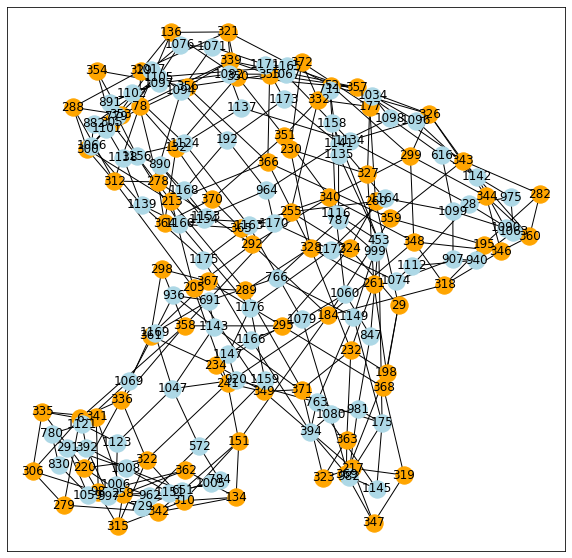

In [5]:
gpn.show_all()

(array([142., 187.,   6.,   1.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([ 2. ,  4.6,  7.2,  9.8, 12.4, 15. , 17.6, 20.2, 22.8, 25.4, 28. ]),
 <BarContainer object of 10 artists>)

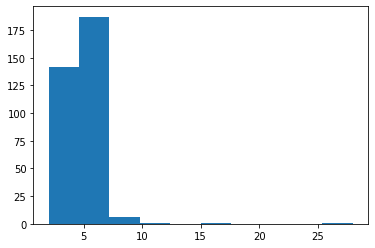

In [13]:
plt.hist([len(gpn.ngb(x)) for x in gpn.G.nodes])

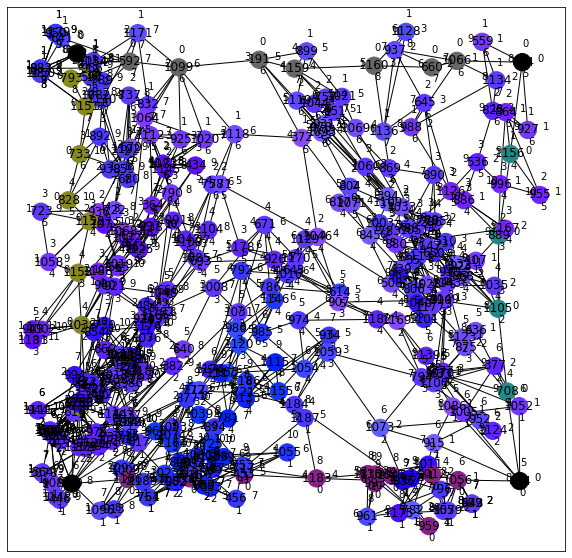

In [12]:
gpn.update_all_dist()
pos = embedded_viz(gpn, finetune=True)
gpn.show_dist(pos=pos)

In [ ]:
gpn.dual_cycle_pairs(203)

In [ ]:
gpn.show_all()

In [ ]:
gpn.D.nodes[640]

In [ ]:
gpn.planar_cycle_pairs(640)

In [ ]:
gc.collect()

In [ ]:
raise

Quasi lonely node 203 with #ngbs = 2
Quasi lonely node 329 with #ngbs = 2
Quasi lonely node 238 with #ngbs = 2
Quasi lonely node 329 with #ngbs = 2
{'ls_to_update': [(823, 190, 1), (823, 190, 0), (640, 190, 0)], 'dual_current': 190, 'new_edge': (823, 190, 1), 'idx': 1, 'current_edge': (823, 190), 'dual_edge': (823, -1, 1), 'planar_edge': (331, 325), 'c_idx': 6, 'current': 331, 'split_ngb_2': 107, 'split_ngb_1': 277, 'new_node': 823, 'edge': (640, 803, 1), 'map_ingb_pair': {334: (334, 315), 315: (315, 107), 107: (107, 331), 331: (331, 325), 332: (332, 96), 96: (96, 331), 325: (325, 277), 277: (277, 209), 209: (209, 308), 308: (308, 334)}, 'ingbs': [334, 315, 107, 331, 332, 96, 331, 325, 277, 209, 308], 'ordered_cycle_pairs': [(334, 315), (315, 107), (107, 331), (331, 332), (332, 96), (96, 331), (331, 325), (325, 277), (277, 209), (209, 308), (308, 334)], 'nb_ngbs': 11, 'ngb_edges': [(803, 640, 0), (640, 810, 1), (640, -1, 0), (640, 190, 0), (640, 190, 1), (640, 190, 2), (640, -1, 1), (640, 808, 0), (640, 633, 0), (640, 785, 0), (640, 803, 1)], 'Z': [(801, -1, 0), (565, -1, 2), (-1, 565, 1), (-1, 631, 0), (-1, 712, 0), (819, -1, 0), (627, -1, 0), (185, -1, 0), (-1, 808, 0), (823, -1, 1), (733, -1, 0), (-1, 620, 0), (794, -1, 0), (741, -1, 0), (-1, 755, 0), (823, -1, 0), (577, -1, 0)], 'min_pair': (277, 107), 'dual_node': 640, 'self': <relaxablegpn.RelaxableGPN object at 0x7f99f7d45c18>, 'map_edge_pair': {(803, 640, 0): (334, 315), (640, 810, 1): (315, 107), (640, -1, 0): (107, 331), (640, 190, 0): (331, 332), (640, 190, 1): (332, 96), (640, 190, 2): (96, 331), (640, -1, 1): (331, 325), (640, 808, 0): (325, 277), (640, 633, 0): (277, 209), (640, 785, 0): (209, 308), (640, 803, 1): (308, 334)}}

In [ ]:
doer = gpn.copy()
(21, 13) in doer.G.edges
# doer.show_all()

In [ ]:
doer = gpn.copy()
doer.check_all()
doer.build_new_edge(*args)

In [ ]:
args = (21, 13, 12)

## Rollback

In [ ]:
seed = 2
random.seed(seed)
np.random.seed(seed)
gpn = RGPN()
gpn.debug = True
gpn.init_tissue(8)
gpn.update_all_dist()
ignore_export = True

pos = nx.spring_layout(gpn.G, k=0.1, iterations=50)
root = "output/evonet8/"
ratio = 0
for i in range(150):
    print_run(i)
    if i < 100:
        if p_dupl():
            ratio += 1
            gpn.duplicate_random()
        else:
            ratio -= 1
            gpn.destroy_random()
        
    pos = embedded_viz(gpn)
    quick_export(gpn, pos, root + str(i).zfill(4) + "_a.png")
    
    print("Action")
    gpn.update_all_dist()
    dist_score = gpn.print_dist_metrics()
    back = gpn.copy()

    if gpn.shorten_dist():
        pos = embedded_viz(gpn)
        print("Shorten")
        gpn.update_all_dist()
        sc = gpn.print_dist_metrics()
        if not sc < dist_score:
            print("Rollback")
            gpn = back
        else:
            quick_export(gpn, pos, root + str(i).zfill(4) + "_b.png", useful=sc < dist_score)
            dist_score = sc
            
    back = gpn.copy()

    if gpn.maxen_dist():
        pos = embedded_viz(gpn)
        print("Maxen")
        gpn.update_all_dist()
        sc = gpn.print_dist_metrics()
        if not sc < dist_score:
            print("Rollback")
            gpn = back
        else:
            quick_export(gpn, pos, root + str(i).zfill(4) + "_c.png", useful=sc < dist_score)
            dist_score = sc
        
    if gpn.remove_useless_edge():
        pos = embedded_viz(gpn)
        quick_export(gpn, pos, root + str(i).zfill(4) + "_d.png")
        print("AAAAAAAAAAAAAA - Remuseless")
        gpn.update_all_dist()
        gpn.print_dist_metrics()
        
    if i % 100 == 0:
        print()
        print("Iteration", i, "ratio", ratio, "density", gpn.density())

In [ ]:
lA, lB, lC = gpn.get_all_dists()
plt.subplot(3, 1, 1)
plt.hist(lA)
plt.subplot(3, 1, 2)
plt.hist(lB)
plt.subplot(3, 1, 3)
plt.hist(lC)

In [ ]:
raise

In [ ]:
for x in [(-1, 117, 1), (117, 118, 0), (118, 47, 0), (-1, 120, 0), (120, 47, 0)]:
    print(gpn.dual(x))

In [ ]:
gpn.G.nodes[9], gpn.G.nodes[8], gpn.G.nodes[0]

In [ ]:
gpn.show_all()

In [ ]:
pos = nx.spring_layout(gpn.G, pos=pos, k=0.1, iterations=10)
gpn.update_all_dist()
gpn.show_dist(pos=pos, figsize=(8, 8))

In [ ]:
gpn.dual((125, 15)), gpn.ngb(15), gpn.ngb(7), gpn.dual((125, 7))

In [ ]:
raise

In [ ]:
list_inner = [gpn.G.degree(n) for n in gpn.G.nodes if not gpn.is_border_node(n)]
list_outer = [gpn.G.degree(n) for n in gpn.G.nodes if gpn.is_border_node(n)]

In [ ]:
plt.hist(list_inner)

In [ ]:
plt.hist(list_outer)

In [ ]:
gpn.show_all()

In [ ]:
raise

In [ ]:
# test 1
def test_func():
    gpn = GrowingPlanarNetwork()
    gpn.init_square(8)
    for i in range(500):
        if p_dupl():
            gpn.duplicate_random_node()
        else:
            gpn.remove_random_node()
    dist = np.array(list(nx.betweenness_centrality(gpn.G).values()))
    return (skew(dist), kurtosis(dist), gpn.G, gpn.D)

for i in range(10):
    S, K, G, D = test_func()
    print(G.size(), D.degree(-1))

In [ ]:
G = gpn.G

In [ ]:
pos = nx.spring_layout(G, k=0.1, iterations=50)
pos = nx.planar_layout(gpn.G)
plt.figure(figsize=(12, 12))
nx.draw_networkx(gpn.G, pos=pos)

In [ ]:
pos = nx.planar_layout(Gstart)
plt.figure(figsize=(12, 12))
nx.draw_networkx(Gstart, pos=pos)

In [ ]:
raise

In [ ]:
gpn.show_all()

In [ ]:
ls_ngb = [len(gpn.ngb(x)) for x in gpn.G.nodes]

In [ ]:
plt.hist(ls_ngb)

In [ ]:
raise

In [ ]:
couple_ngb = [(len(gpn.ngb(x)), x) for x in gpn.G.nodes if len(gpn.ngb(x)) > 4]
couple_ngb

In [ ]:
gpn.stabilize_ngb(10)

In [ ]:
couple_ngb = [(len(gpn.ngb(x)), x) for x in gpn.G.nodes if len(gpn.ngb(x)) > 4]
couple_ngb